#Libraries' importation and installation 

In [1]:
!pip install mediapipe #Install MediaPipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 39.6 MB/s eta 0:00:00


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install tensorflow_addons

In [9]:
#Import libraries to support in the use of data, display graphs, etc.
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
import mediapipe as mp
import copy
from natsort import natsorted
import pylab as pl
import pandas as pd
import seaborn as sns
import datetime
import time
import joblib #ensure it's joblib v1.2.0 if not please update 
from google.colab import drive #To mount Google drive
from google.colab.patches import cv2_imshow #to allow cv2 to show images and frames

#Import libraries from scikit-learn for static signs recognition
import sklearn
from sklearn import svm, datasets
from sklearn.utils import shuffle
import sklearn.ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
#from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
#from sklearn.model_selection import model_selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

#Import libraries from Tenorflow for dynamic/continous signs recognition

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

#Import libraries to use javascript to display webcam video
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html


# Setup Mediapipe Funcs

In [10]:
##Folllowing code was adapted from Renotte, N. (2020). ActionDetectionforSignLanguage. GitHub. https://github.com/nicknochnack/ActionDetectionforSignLanguage
#Also, Mediapipe documentation was used for support: https://github.com/google/mediapipe/blob/master/docs/solutions/holistic.md

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [11]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable to Improve Perf.
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [12]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    '''
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    '''
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [13]:
def extract_keypoints(results):
    #Extraction of pose landmarks coordiantes
    #pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

    #Extraction of face landmarks coordiantes
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

    #Extraction of hands landmarks coordiantes
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    #return np.concatenate([pose, face, lh, rh]) #this is the complete return
    return np.concatenate([lh, rh]) # return of left and right hand landmarks coordinates only

## Setup Folders for Collection

In [14]:
#Mount Google Drive within the folder that the database is located, in this case it was called "Base de Datos"
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
#Verify its location and available existing folders
!ls "/content/drive/My Drive/Base de datos"

edited_captures  images  key_points  raw_videos


## Folder paths


In [16]:
# Path for exported data, numpy arrays

#DATA_PATH for MP Points
DATA_PATH_MP_Video = os.path.join(r'/content/drive/My Drive/Base de datos/key_points/MP_Data_videos') 
DATA_PATH_MP_Image = os.path.join(r'/content/drive/My Drive/Base de datos/key_points/MP_Data_images') 

#DATA_PATH for keypoints (coordinates) for Medipipe Holistic Landmarks
DATA_PATH_KEYP_Video = os.path.join(r'/content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos')
DATA_PATH_KEYP_Image = os.path.join(r'/content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images')


##Main variables for folders designation, feautures extraction and modeling


In [17]:
#Declaration of variables to use for path declaration, folder detection, and for labeling
number_of_cycles= np.array(['1','2','3','4','5'])

side_hand= np.array(['Derecha','Izquierda'])

dinamyc_alphabets =  np.array(['9',
'10',
'j',
'k',
'll',
'ñ',
'q',
'rr',
'x',
'z',])
dinamyc_alphabets=sorted(dinamyc_alphabets)

static_alphabets= np.array(['1',
'2',
'3',
'4',
'5',
'6',
'7',
'8',
'a',
'b',
'c',
'd',
'e',
'f',
'g',
'h',
'i',
'l',
'm',
'n',
'o',
'p',
'r',
's',
't',
'u',
'v',
'w',
'y',])
static_alphabets=sorted(static_alphabets)


##Main Folders Creation


In [ ]:
#The follwoing code support on folder creation for MP data points and keypoints, please exchange directory when neccesary according if it is startic (image) signs or dynamic/continous (video) signs

# Created 110 DataPaths for images/video
no_sequences= 1 # 1 is for image , 60 30 for video

#exchange static_alphabet(s) for dinamyc_alphabets for video

for static_alphabet in static_alphabets: 
    for sequence in range(no_sequences):
        try: 
          
            new_directionwtf= os.path.join(DATA_PATH_MP_Image, static_alphabet, str(sequence))
            os.makedirs(new_directionwtf)
           #print(static_alphabet,"   " , new_directionwtf)
        except:
            #print("failed to create: ", static_alphabet, "   ", sequence)
            pass

In [ ]:
# Created 110 DataPaths for Keypoints of MP for images/video
for static_alphabet in static_alphabets: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH_KEYP_Image, static_alphabet, str(sequence)))
        except:
          print("failed to create: ", static_alphabet, "   ", sequence)
          pass

failed to create:  1     0
failed to create:  2     0
failed to create:  3     0
failed to create:  4     0
failed to create:  5     0
failed to create:  6     0
failed to create:  7     0
failed to create:  8     0
failed to create:  a     0
failed to create:  b     0
failed to create:  c     0
failed to create:  d     0
failed to create:  e     0
failed to create:  f     0
failed to create:  g     0
failed to create:  h     0
failed to create:  i     0
failed to create:  l     0
failed to create:  m     0
failed to create:  n     0
failed to create:  o     0
failed to create:  p     0
failed to create:  r     0
failed to create:  s     0
failed to create:  t     0
failed to create:  u     0
failed to create:  v     0
failed to create:  w     0
failed to create:  y     0


In [ ]:
no_sequences_video = 110 # number of videos per class

sequence_length_video = 30 # number of frames to take intoa ccount per video

sequence_length=30 # number of framesn(frames per one sec)


In [ ]:
# Create DataPaths for Keypoints of videos
for action in dinamyc_alphabets: 
    for sequence in range(no_sequences_video):
        try: 
            os.makedirs(os.path.join(DATA_PATH_KEYP_Video, action, str(sequence)))
        except:
          print("error ", action , " ", sequence)
          pass

In [ ]:
# Create DataPaths for Videos
for action in dinamyc_alphabets: 
    for sequence in range(no_sequences_video):
        try: 
            os.makedirs(os.path.join(DATA_PATH_MP_Video, action, str(sequence)))
        except:
          print("error ", action , " ", sequence)
          pass

#Mediapipe Holistic Implementation

##Extraction of landmarks for a person for static signs



In [ ]:
#created list to save the directories that will generate an error if not saved properly
bad_static_directories=[]

In [ ]:
#### The following code is created to extract and save landmarks' coordinates for videos per persona

#VIDEO_DATA_PATH=os.path.join(r'D:\signara\Signara-main\Sign To Text\utils\video_data')
#VIDEO_DATA_PATH = os.path.join(r'/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha') 
#IMAGE_DATA_PATH = os.path.join(r'/content/drive/My Drive/Base de datos/edited_captures/persona_6/Imagenes') 
IMAGE_DATA_PATH = os.path.join(r'/content/drive/My Drive/Base de datos/edited_captures/persona_1') #Peronas 7, 8, 9 , 1_, 3<<<<<<<<


#Every persona produces 10 signs of every class, in order to label them and save them, we label them and save them according to an order into folders, in this case sequence variable will help us with the order of the saved signs per persona
#the current number '0' of the sample it begins at P4, C1, Derecha, every static sign and will go through to every cycle of that person in every hand
#sequence=0 # Persona 4 is sample 0 t 9, therfore sequence = 0
#sequence = 10 #for persona 5 from sample 10 to 19  
#sequence = 20 # for persona 6 from 20 to 29
#sequence = 30 # for persona 7 from 30 to 39
#sequence = 40 # for persona 8 from 40 to 49
#sequence = 50 # for persona 9 from 50 to 59 ** Ciclo 3_5 der e Izq
#sequence = 60 # for persona 10 from 60 to 69
#sequence = 70 # for persona 11 from 70 to 79
#sequence = 80 # for persona 3 from 80 to 89 ***Muchas diferencias de los nombres de imagens
#sequence = 90 # for persona 2 from 90 to 99 ***Muchas diferencias de los nombres de imagens
sequence = 100 # for persona 1 from 100 to 109

sequence_length=1 # number of frames, and if it's image is one only, opposite case 60 (frames per one sec)

side_hand= np.array(['Derecha','Izquierda']) #For all the other Personas

#side_hand=np.array(['Izquierda']) #to control errors per hand
#i=1 #to control errors per cycle

# Set mediapipe model 

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for i in number_of_cycles:

      for j in side_hand:
        #path to read the folder of each cycle
        current_cycle_path= str('P1_Ciclo_') + str(i) + str('_5_')+str(j) #for persona 11, 1, 2, 5??
        #current_cycle_path = str('Ciclo_') + str(i) + str('_5_')+str(j) #for persona 4 & 6, & others
        #current_cycle_path = str('Ciclo_') + str(i) + str('_5_')+str('Derecha') #for persona 3

        #path to rad the images
        IMAGE_DATA_PATH_CURRENT_CYCLE = os.path.join(IMAGE_DATA_PATH, "Imagenes", current_cycle_path  ) # persona 11, 1, 2? probable
        #IMAGE_DATA_PATH_CURRENT_CYCLE = os.path.join(IMAGE_DATA_PATH, current_cycle_path, "Imagenes" ) #for persona 7,8, 9 , 1_, 3, 5 <<<<<<<<
        #to start the alphabet list for the naming
        aux= 0

         #for persona 7 & 8 & 9 & 1_ , 3<<<<

        #if j == "Izquierda":
         # current_cycle_path= str('Ciclo_') + str(i) + str('_5_')+str('Izq')


        for k in static_alphabets:
          #path to read  sign by sign
          #CURRENT_STATIC_NAMED_ACTION = str('P1_')+str(current_cycle_path)+str('_')+str(k) # for persona may be 4 & 6
          #CURRENT_STATIC_NAMED_ACTION = str('Ss_')+str(current_cycle_path)+str('_')+str(k) # for personas 7, 8, 9 , 1_, 3<<<<
          CURRENT_STATIC_NAMED_ACTION = str(current_cycle_path)+str('_')+str(k)  #for persona 5, 11, 1, 2?
          #CURRENT_STATIC_NAMED_ACTION = str('Ss_P3_')+str(current_cycle_path)+str('_')+str(k)  #for persona 3

          #path to refer to a certain image of sign
          jpg_path = os.path.join(IMAGE_DATA_PATH_CURRENT_CYCLE, CURRENT_STATIC_NAMED_ACTION + str('.jpg'))
          #print(os.path.exists(jpg_path))

          if not os.path.exists(jpg_path):
            jpg_path = os.path.join(IMAGE_DATA_PATH_CURRENT_CYCLE, CURRENT_STATIC_NAMED_ACTION)

          if not os.path.exists(jpg_path):
            print("False  ", jpg_path)
            bad_static_directories.append(jpg_path)

          for frame_num in range(sequence_length):
            
            #print(CURRENT_STATIC_NAMED_ACTION)
            #use of cv2 to read each image
            if os.path.exists(jpg_path):
              #print(jpg_path)
              
              frame = cv2.imread(jpg_path)

              # Make detections
              try:
                #print(mp4_path)
                image, results = mediapipe_detection(frame, holistic)
              except:
                pass;

              #print(results)

              # Draw landmarks
              draw_styled_landmarks(image, results)

              #Extract landmark
              keypoints = extract_keypoints(results)

              #Create path to save the landmark
              npy_path = os.path.join(DATA_PATH_KEYP_Image, k, str(sequence), str(frame_num))
              #print(npy_path,'\n' )
              #aux=aux+1

              #Save the cooridnate of the landmarks
              np.save(npy_path, keypoints)
              

        cv2.destroyAllWindows()

        sequence=sequence+1 # se incrementa el número de muestra

#cap.release()
cv2.destroyAllWindows()
print(sequence)
#print(bad_directories)

110


In [ ]:
#Display which directories couldn't be saved
bad_static_directories


[]

In [ ]:
#Test if a certain driectory was saved
os.path.exists('/content/drive/My Drive/Base de datos/edited_captures/persona_3/Ciclo_1_5_Derecha/Imagenes/Ss_P3_Ciclo_1_5_Derecha_0.jpg')

True

##Extraction of landmarks for a person for continous/dynamic signs


In [ ]:
#created list to save the directories that will generate an error if not saved properly
bad_directories=[]

In [ ]:
#### The following code is created to extract and save landmarks' coordinates for videos per persona

#IMAGE_DATA_PATH = os.path.join(r'/content/drive/My Drive/Base de datos/edited_captures/persona_6/Imagenes') 
VIDEO_DATA_PATH = os.path.join(r'/content/drive/My Drive/Base de datos/edited_captures/persona_4') #Persona can be changed

#Every persona produces 10 signs of every class, in order to label them and save them, we label them and save them according to an order into folders, in this case sequence variable will help us with the order of the saved signs per persona
#the current number '0' of the sample it begins at P4, C1, Derecha, every static sign and will go through to every cycle of that person in every hand
sequence=0 # Persona 4 is sample 0 t 9, therfore sequence = 0
#sequence = 10 #for persona 5 from sample 10 to 19  
#sequence = 20 # for persona 6 from 20 to 29
#sequence = 30 # for persona 7 from 30 to 39
#sequence = 40 # for persona 8 from 40 to 49
#sequence = 50 # for persona 9 from 50 to 59
#sequence = 60 # for persona 10 from 60 to 69
#sequence = 70 # for persona 11 from 70 to 79
# sequence = 80 # for persona 3 from 80 to 89 ***Derechas are lacking with an underscore
# sequence = 90 # for persona 2 from 90 to 99 ***Final left is lacking, (may change it with the last right hand)
# sequence = 100 # for persona 1 from 100 to 109 ***lot of changes

sequence_length=30 # number of framesn(frames per one sec)

#side_hand= np.array(['derecha','izquierda']) #For Persona 1 only
side_hand= np.array(['Derecha','Izquierda']) #For all the other Personas

#side_hand=np.array(['Izquierda']) #to control errors per hand
#i=1 #to control errors per cycle

# Set mediapipe model 

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for i in number_of_cycles:

      for j in side_hand:

        #format to read every file and folder according to the person

        #current_cycle_path= str('P5_Ciclo_') + str(i) + str('_5_')+str(j) #for persona 5
        current_cycle_path= str('Ciclo_') + str(i) + str('_5_')+str(j) #for persona 4 & 6
        #if j == 'Derecha':#for persona 3 only
         # current_cycle_path= str('Ciclo ') + str(i) + str('_5_')+str(j)

        #format to create/refer a path to save the file
        VIDEO_DATA_PATH_CURRENT_CYCLE = os.path.join(VIDEO_DATA_PATH, current_cycle_path )

        #for persona 7 & 8 & 9 & 10
        #if j == "Izquierda":
         # current_cycle_path= str('Ciclo_') + str(i) + str('_5_')+str('Izq')

        for k in dinamyc_alphabets:

          #Create the label of the action sign
          CURRENT_DYNAMIC_NAMED_ACTION = str(current_cycle_path)+str('_')+str(k) 
          #print(CURRENT_DYNAMIC_NAMED_ACTION)

          #named path to read of the sign
          mp4_path = os.path.join(VIDEO_DATA_PATH_CURRENT_CYCLE, CURRENT_DYNAMIC_NAMED_ACTION + str('.mp4'))
          #mp4_path = os.path.join(VIDEO_DATA_PATH_CURRENT_CYCLE, CURRENT_DYNAMIC_NAMED_ACTION) #persona 2
          if not os.path.exists(mp4_path):
            mp4_path = os.path.join(VIDEO_DATA_PATH_CURRENT_CYCLE, CURRENT_DYNAMIC_NAMED_ACTION)

          if not os.path.exists(mp4_path):
            print("False  ", mp4_path)
            bad_directories.append(mp4_path)

          #use of sv2 to read the video file
          cap = cv2.VideoCapture(mp4_path)
          ret, frame = cap.read()
          
            
          for frame_num in range(sequence_length):

            if os.path.exists(mp4_path):
              # Make detections

              try:
                #print(mp4_path)

                image, results = mediapipe_detection(frame, holistic)
              except:
                pass;

              # Draw landmarks
              draw_styled_landmarks(image, results)

              #extracting the landmark's coordinates
              keypoints = extract_keypoints(results)

              #create the path to save the lanrmkaks' information sign
              npy_path = os.path.join(DATA_PATH_KEYP_Video, k, str(sequence), str(frame_num))

              #save the landmarks' coordinates
              np.save(npy_path, keypoints)
              

        cv2.destroyAllWindows()

        sequence=sequence+1 # se incrementa el número de muestra

#cap.release()
cv2.destroyAllWindows()
print(sequence)
#print(bad_directories)


False   /content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha/Ciclo_1_5_Derecha_rr
False   /content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha/Ciclo_1_5_Derecha_ñ
2
['/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha/Ciclo_1_5_Derecha_rr', '/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha/Ciclo_1_5_Derecha_ñ']


'\nCiclo_1_5_Izquierda/Ciclo_1_5_Izquierda_j\n\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha/Ciclo_1_5_Derecha_rr.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Derecha/Ciclo_1_5_Derecha_ñ.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Izquierda/Ciclo_1_5_Izquierda_10.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Izquierda/Ciclo_1_5_Izquierda_9.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Izquierda/Ciclo_1_5_Izquierda_j.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Izquierda/Ciclo_1_5_Izquierda_k.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Izquierda/Ciclo_1_5_Izquierda_ll.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo_1_5_Izquierda/Ciclo_1_5_Izquierda_q.mp4\n/content/drive/My Drive/Base de datos/edited_captures/persona_4/Ciclo

In [ ]:
print(len(keypoints)) #42 landmarks with 3 axis each one (42*3=126)

126


In [ ]:
print(keypoints)

[ 5.94070435e-01  4.13339853e-01 -8.38843803e-08  5.94999194e-01
  3.76171678e-01  1.53812836e-03  5.92286110e-01  3.42590868e-01
 -3.73215531e-04  5.91849625e-01  3.16970676e-01 -2.48383079e-03
  5.97268701e-01  3.00049245e-01 -4.76585515e-03  5.81786275e-01
  3.48388344e-01 -8.50967225e-03  5.65887511e-01  3.39698017e-01
 -9.91060771e-03  5.69664657e-01  3.48448187e-01 -9.20388103e-03
  5.74931026e-01  3.52927357e-01 -9.02639702e-03  5.78238189e-01
  3.65941435e-01 -1.07386457e-02  5.62737107e-01  3.59440476e-01
 -1.09916450e-02  5.66509426e-01  3.65137517e-01 -9.35348030e-03
  5.72105467e-01  3.69115233e-01 -9.83733218e-03  5.74967682e-01
  3.84008527e-01 -1.22411707e-02  5.61771750e-01  3.77052516e-01
 -1.19759571e-02  5.65371513e-01  3.81426454e-01 -1.01952134e-02
  5.70839405e-01  3.84547204e-01 -1.08036920e-02  5.72680891e-01
  4.01732057e-01 -1.34835150e-02  5.60062051e-01  3.99093330e-01
 -1.43416831e-02  5.52591383e-01  3.99173260e-01 -1.43665429e-02
  5.46273768e-01  3.99710

In [ ]:
IMAGE_DATA_PATH = os.path.join(r'/content/drive/My Drive/Base de datos/edited_captures/persona_6/Imagenes') 
#test of a ceratin folder to verify if exists
print(os.path.exists(os.path.join(IMAGE_DATA_PATH )))

True


#Data labeling for modeling

In [ ]:
#Assigment of the dactylology and the first ten numbers to a certain number label according if it is a static or continous/dynamic sign
label_map_dynamic = {label:num for num, label in enumerate(dinamyc_alphabets)}
label_map_static = {label:num for num, label in enumerate(static_alphabets)}

In [ ]:
label_map_dynamic

{'10': 0,
 '9': 1,
 'j': 2,
 'k': 3,
 'll': 4,
 'q': 5,
 'rr': 6,
 'x': 7,
 'z': 8,
 'ñ': 9}

In [ ]:
label_map_static

{'1': 0,
 '2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 'a': 8,
 'b': 9,
 'c': 10,
 'd': 11,
 'e': 12,
 'f': 13,
 'g': 14,
 'h': 15,
 'i': 16,
 'l': 17,
 'm': 18,
 'n': 19,
 'o': 20,
 'p': 21,
 'r': 22,
 's': 23,
 't': 24,
 'u': 25,
 'v': 26,
 'w': 27,
 'y': 28}

###Declare the paths to save the keypoints data in Google Drive 

In [18]:
DYNAMIC_DATA = os.path.join(r'/content/drive/My Drive/Base de datos/key_points/dynamic_data') 
STATIC_DATA = os.path.join(r'/content/drive/My Drive/Base de datos/key_points/static_data') 


###Check dynamic mistakes

####Lankdmark recopliation and Mistake detector dynamic/continous signs

In [ ]:
#The following code detects which files/sign were not saved accordingly for dynamic/continoous signs and recopilas all the saved landmarks
bad_static_detections=[]
sequence_length=30
sequences, labels = [], []
for action in dinamyc_alphabets:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH_KEYP_Video, action))).astype(int):
        window = []
        if not os.path.exists(os.path.join(DATA_PATH_KEYP_Video, action, str(sequence), "{}.npy".format('29'))):
            bad_static_detections.append(os.path.join(DATA_PATH_KEYP_Video, action, str(sequence)))
            print("FALSE   ", os.path.join(DATA_PATH_KEYP_Video, action, str(sequence)))
            continue
        for frame_num in range(sequence_length):

            res = np.load(os.path.join(DATA_PATH_KEYP_Video, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map_dynamic[action]) 

FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/11
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/17
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/31
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/32
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/80
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/82
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/84
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/86
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/88
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/10/99
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_videos/9/11
FALSE    /content/driv

####Save labels and data

In [ ]:
#the following code creates a path to save all the landmarks per sign in only one path
npy_path_seq_dyn = os.path.join(DYNAMIC_DATA, 'sequences')
np.save(npy_path_seq_dyn, sequences)

npy_path_lab_dyn = os.path.join(DYNAMIC_DATA, 'labels')
np.save(npy_path_lab_dyn, labels)

NameError: ignored

####Load labels and data

In [19]:
#the following code load landmarks information
labels_dynamic = np.load(os.path.join(DYNAMIC_DATA,str('labels.npy')))
sequences_dynamic = np.load(os.path.join(DYNAMIC_DATA,str('sequences.npy')))

In [ ]:
#test of a certain sign
np.array(os.listdir(os.path.join(DATA_PATH_KEYP_Video, 'j'))).astype(int)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109])

In [ ]:
#test if a certain path exist
os.path.exists(os.path.join(DATA_PATH_KEYP_Video, 'j', str("1"), "{}.npy".format('0')))

True

###Check static mistakes




####Lankdmark recopliation and Mistake detector static signs

In [ ]:
#The following code checks which static file were not saved for static signs and recopilation of landmarks per sign 
sequence_length=1
sequences, labels = [], []
for action in static_alphabets:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH_KEYP_Image, action))).astype(int):
        window = []
        if not os.path.exists(os.path.join(DATA_PATH_KEYP_Image, action, str(sequence), "{}.npy".format('0'))):
            bad_static_detections.append(os.path.join(DATA_PATH_KEYP_Image, action, str(sequence)))
            print("FALSE   ", os.path.join(DATA_PATH_KEYP_Image, action, str(sequence)))
            continue
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH_KEYP_Image, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map_static[action])

FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/13
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/17
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/54
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/55
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/82
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/84
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/86
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/89
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/90
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/91
FALSE    /content/drive/My Drive/Base de datos/key_points/MP_Data_KEYPOINTS_images/1/92
FALSE    /content/drive/My Drive

####Save labels and data

In [ ]:
#the following code creates a path to save all the landmarks per sign in only one path

npy_path_seq_stat = os.path.join(STATIC_DATA, 'sequences')
np.save(npy_path_seq_stat, sequences)

npy_path_lab_stat = os.path.join(STATIC_DATA, 'labels')
np.save(npy_path_lab_stat, labels)

####Load labels and data

In [20]:
#the following code load landmarks information

labels_static = np.load(os.path.join(STATIC_DATA,str('labels.npy')))
sequences_static = np.load(os.path.join(STATIC_DATA,str('sequences.npy')))

In [ ]:
#Test to see if certain landmark exist
os.path.exists(os.path.join(DATA_PATH_KEYP_Video, 'j', str("1"), "{}.npy".format('0')))

In [ ]:
#check if npy files qere saved
!ls "/content/drive/My Drive/Base de datos/key_points/static_data"


labels.npy  sequences.npy


###Consult size of the labels and sequences accordingly

In [ ]:
#check the size of the saved landmarks coordinates for continous signs
np.array(sequences_dynamic).shape
#(size of the saved files, number of frames saved per file, number of landmarks saved per frame)

(981, 30, 126)

In [ ]:
np.array(labels_dynamic).shape
#(size of the saved files, )

(981,)

In [ ]:
np.array(sequences_static).shape
#(size of the saved files, number of frames saved per file (1 since it's only an image), number of landmarks saved per frame)

(2696, 1, 126)

In [ ]:
np.array(labels_static).shape
#(size of the saved files, )

(2696,)

In [ ]:
#the following lines checks the structure 
print(sequences_dynamic[0].shape)


(30, 126)


In [ ]:
print(sequences_dynamic[1][0])

[ 5.30367076e-01  2.80238330e-01  6.87930992e-08  5.41301966e-01
  2.51855999e-01  2.10945006e-03  5.44586718e-01  2.27309212e-01
  1.38219516e-03  5.37563145e-01  2.14655980e-01  2.46940093e-04
  5.28551936e-01  2.13348955e-01 -1.89202046e-03  5.37617385e-01
  2.15380266e-01 -6.86892448e-03  5.37626028e-01  1.79678023e-01
 -1.14916218e-02  5.36823392e-01  1.57942683e-01 -1.41193252e-02
  5.36041796e-01  1.39843166e-01 -1.57569665e-02  5.26404381e-01
  2.15866759e-01 -1.00556947e-02  5.22453964e-01  1.75567195e-01
 -1.37624275e-02  5.19266427e-01  1.51388362e-01 -1.60670374e-02
  5.16664028e-01  1.32525235e-01 -1.79594085e-02  5.16440928e-01
  2.20673904e-01 -1.25353849e-02  5.11326969e-01  1.83875412e-01
 -1.53009864e-02  5.07957578e-01  1.60387427e-01 -1.78950671e-02
  5.05515695e-01  1.41914159e-01 -2.00661924e-02  5.08624017e-01
  2.28668123e-01 -1.45349344e-02  5.04231215e-01  2.01367155e-01
 -1.72148086e-02  5.02004564e-01  1.83788031e-01 -1.85837261e-02
  5.00313699e-01  1.68434

In [ ]:
print(labels_dynamic[400])

3


### Checker of how many unique values does every label has accordingly

In [21]:
unique_, counts_ = np.unique(labels_dynamic, return_counts=True)

#display unique values and counts of every continous sign
print(np.asarray((unique_, counts_)).T)

[[  0 100]
 [  1 100]
 [  2 102]
 [  3 102]
 [  4  86]
 [  5 101]
 [  6  88]
 [  7 101]
 [  8 101]
 [  9 100]]


In [22]:
unique_s, counts_s = np.unique(labels_static, return_counts=True)

#display unique values and counts of every static sign
print(np.asarray((unique_s, counts_s)).T)

[[ 0 92]
 [ 1 92]
 [ 2 92]
 [ 3 92]
 [ 4 92]
 [ 5 92]
 [ 6 92]
 [ 7 92]
 [ 8 94]
 [ 9 94]
 [10 94]
 [11 94]
 [12 94]
 [13 94]
 [14 94]
 [15 94]
 [16 93]
 [17 93]
 [18 93]
 [19 93]
 [20 93]
 [21 93]
 [22 93]
 [23 93]
 [24 93]
 [25 92]
 [26 93]
 [27 93]
 [28 93]]


#Modeling

##Load initial variable preparation for static signs modeling

In [23]:
#Declaration of variables and formating for static sign for modeling input
X_static = np.array(sequences_static)
y_static = labels_static
rows, cols = (2696, 126)
arr = [[0 for i in range(cols)] for j in range(rows)]
for i in range(2696):
  for j in range(126):
    arr[i][j]=X_static[i][0][j]
arr = np.array(arr)
arr.shape

(2696, 126)

In [24]:
#following lines check the size of each input for independent and dependent variables for static sign modeling
y_static.shape

(2696,)

In [25]:
arr.shape


(2696, 126)

##Load initial variable preparation for continous signs modeling

In [ ]:
#Declaration of variables and formating for dynamic/continous inputs for modeling

X = np.array(sequences_dynamic) 

y = to_categorical(labels_dynamic).astype(int)

y.shape

(981, 10)

## Data distribution according to the type of sign that is going to be trained

In [26]:
#Variables declaration of static signs for training , testing and validation staging
X_train, X_test, y_train, y_test = train_test_split(arr, y_static, test_size=0.2, random_state=1) ###STATIC

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.5 x 0.2 = 0.1

In [ ]:
#Variables declaration of continous signs for training , testing and validation staging
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) ###DYNAMIC

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.5 x 0.2 = 0.1

In [ ]:
#check size of variables assigned per stage
y_train.shape

(2156,)

In [ ]:
X_train.shape

(2156, 126)

In [ ]:
y_test.shape[0]

98

##Tensorboard path

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%reload_ext tensorboard

In [ ]:
#Create path for logs for tensorboard

log_dir = os.path.join(DYNAMIC_DATA,'Logs','fit')
#tb_callback = TensorBoard(log_dir=log_dir)
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Static Models settup and training


### Hist Gradient Boosting Classifier 

In [27]:
#Create params' option for the HistGradientBoostingClassifier model in order to put into GridSearch
params_grid={'loss':['categorical_crossentropy'], 
             'learning_rate':[ 0.09, 0.1, 0.11, 0.125, 0.15], 
             'max_iter':[100, 150, 200, 250, 300, 350],
             }

'''
Other params that can be seen according to the documentation in scikit-learn:
            'max_leaf_nodes':31, 
             'max_depth':None,
             'min_samples_leaf':20,
             'max_bins':255,
             'categorical_features':None,
             'monotonic_cst':None,
             'interaction_cst':None,
             'warm_start':False,
             'early_stopping':'auto',
             'scoring':'loss',
             'validation_fraction':0.1,
             'n_iter_no_change':10,
             'tol':1e-07,
             'verbose':0,
             'random_state':None,
             'class_weight':None
'''

"\nOther params that can be seen according to the documentation in scikit-learn:\n            'max_leaf_nodes':31, \n             'max_depth':None,\n             'min_samples_leaf':20,\n             'max_bins':255,\n             'categorical_features':None,\n             'monotonic_cst':None,\n             'interaction_cst':None,\n             'warm_start':False,\n             'early_stopping':'auto',\n             'scoring':'loss',\n             'validation_fraction':0.1,\n             'n_iter_no_change':10,\n             'tol':1e-07,\n             'verbose':0,\n             'random_state':None,\n             'class_weight':None\n"

In [ ]:
#prepare the model with grid search and train accordingly
hist_GDB_model = GridSearchCV(HistGradientBoostingClassifier(), params_grid, refit=True, cv=3, n_jobs=-1)
#train
hist_GDB_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.09, 0.1, 0.11, 0.125, 0.15],
                         'loss': ['categorical_crossentropy'],
                         'max_iter': [100, 150, 200, 250, 300, 350]})

In [ ]:
#save best model
final_model = hist_GDB_model.best_estimator_
#predict
y_pred = final_model.predict(X_test)

In [ ]:
#show best params of the best model
hist_GDB_model.best_params_

{'learning_rate': 0.11, 'loss': 'categorical_crossentropy', 'max_iter': 250}

In [ ]:
y_pred
#matrix of prediction display

array([ 5,  9, 12,  6, 16,  5, 17, 13,  8,  7, 23,  2, 13,  0, 13,  0, 15,
       17, 18,  0, 20,  8,  7, 22, 18, 25,  9,  1,  4, 10, 28, 21,  0, 20,
       20, 27, 28,  5,  9,  6, 11, 25, 16, 19, 12, 20, 25, 19,  2, 15, 19,
        8, 20, 22,  3, 13, 28, 13,  8,  2, 10,  5,  2,  2, 21, 14,  0, 18,
        6, 12, 27, 21, 26, 16,  3,  4, 14, 24,  1,  8, 25, 20,  8, 14, 12,
        6, 28,  2, 10,  2, 20, 20,  5, 24, 25, 11,  5,  2, 12, 21, 12, 28,
       18, 21, 28, 19, 13, 18,  4, 19, 12, 28, 19, 20, 21,  1, 10, 24,  6,
        0, 20, 23, 26,  1,  4, 14,  6, 24, 14,  8, 15, 12, 21, 28, 23, 10,
        7, 12, 25, 27, 17, 16, 22, 22, 15, 15,  9, 13, 19, 25, 16,  2, 17,
       11, 12, 18,  1,  3,  0, 23, 21, 28, 25,  6, 22,  4, 22,  7, 22, 21,
        9, 24,  7, 13,  5, 22, 13,  3, 19, 11, 22, 18,  6,  8, 26,  8,  0,
       11,  9, 27,  3, 22, 12,  5,  2, 18, 21, 16, 20,  6,  4,  6, 23, 27,
       11,  5, 26, 18,  7,  9, 21, 28, 19, 25, 12, 27,  1, 13, 21, 19,  2,
       12, 26, 20, 24, 15

###SVM

In [28]:
#Create params' option for the SVM model in order to put into GridSearch
params_grid = { 'C':[0.1, 1, 10, 100, 800, 1000, 1200], 
'kernel':['rbf','linear', 'poly', 'sigmoid'], 
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

In [ ]:
#prepare the model with grid search and train accordingly
svm_model = GridSearchCV(SVC(), params_grid, refit=True, cv=5, n_jobs=-1)
#train the model
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 800, 1000, 1200],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [ ]:
#check the the best score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_ #save best model into variable
y_pred = final_model.predict(X_test)
#Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.9086330239752514 

Best C: 1200 

Best Kernel: poly 

Best Gamma: 0.1 



## Dynamic/Continous Models settup and training

###LSTM

In [ ]:
#LSTM Model

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='elu', input_shape=(30,126),kernel_initializer='he_normal' ))   #30, 1662
model.add(LSTM(128, return_sequences=True, activation='elu',kernel_initializer='he_normal' ))
model.add(LSTM(64, return_sequences=False, activation='elu',kernel_initializer='he_normal' ))
model.add(Dense(64, activation='elu',kernel_initializer='he_normal' ))
model.add(Dense(32, activation='elu',kernel_initializer='he_normal'))
model.add(Dense(y_test.shape[1], activation='softmax', kernel_initializer='glorot_uniform', 
                kernel_regularizer='l2'))

In [ ]:
#FOR LSTM's checkpoints of the model metrics  

checkpoint_filepath = MODEL_PATH = os.path.join(DYNAMIC_DATA,'models', 'checkpoints_lstm')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                       tf.keras.metrics.Precision(name='precision') ,
                       tf.keras.metrics.Recall(name='recall')
          ]

model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics= METRICS
              )
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 203,690
Trainable params: 203,690
Non-tr

###GRU

In [ ]:
#GRU Model WITH L2
model = Sequential()

model.add(GRU(128, return_sequences=True, activation='elu', input_shape=(30,126),kernel_initializer='he_normal' ))   #30, 1662
model.add(Dropout(0.2))
model.add(Dense(64, activation='elu',kernel_initializer='he_normal' ))

model.add(GRU(64, return_sequences=True, activation='elu',kernel_initializer='he_normal' ))
model.add(Dropout(0.2))
model.add(Dense(64, activation='elu',kernel_initializer='he_normal'  ))

model.add(GRU(32, return_sequences=False, activation='elu',kernel_initializer='he_normal'  ))
model.add(BatchNormalization())
model.add(Dense(32, activation='elu',kernel_initializer='he_normal' ))

model.add(Dense(10, activation='softmax', kernel_initializer='glorot_uniform', kernel_regularizer='l2'))


In [ ]:
#FOR GRU's checkpoints of the model metrics  
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                       tf.keras.metrics.Precision(name='precision') ,
                       tf.keras.metrics.Recall(name='recall')
          ]
          
checkpoint_filepath = MODEL_PATH = os.path.join(DYNAMIC_DATA,'models', 'checkpoints_gru')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001,  beta_1 = 0.9, beta_2 = 0.999 ), loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           98304     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 dense_2 (Dense)             (None, 30, 64)            8256      
                                                                 
 gru_1 (GRU)                 (None, 30, 64)            24960     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 dense_3 (Dense)             (None, 30, 64)            4160      
                                                                 
 gru_2 (GRU)                 (None, 32)               

##Training

In [ ]:
# Total of epochs to train the model
EPOCHS = 1200 

#Training settup
model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[tensorboard_callback, model_checkpoint_callback ] , validation_data=(X_test, y_test))


Epoch 1/1200
25/25 [==============================] - ETA: 0s - loss: 3.1005 - categorical_accuracy: 0.0804 - precision: 0.0122 - recall: 0.0013

25/25 [==============================] - 9s 133ms/step - loss: 3.1005 - categorical_accuracy: 0.0804 - precision: 0.0122 - recall: 0.0013 - val_loss: 2.5329 - val_categorical_accuracy: 0.1224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1200
25/25 [==============================] - ETA: 0s - loss: 2.7665 - categorical_accuracy: 0.1135 - precision: 0.1111 - recall: 0.0026

25/25 [==============================] - 2s 94ms/step - loss: 2.7665 - categorical_accuracy: 0.1135 - precision: 0.1111 - recall: 0.0026 - val_loss: 2.5057 - val_categorical_accuracy: 0.1429 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1200
25/25 [==============================] - ETA: 0s - loss: 2.6827 - categorical_accuracy: 0.1301 - precision: 0.0909 - recall: 0.0013

25/25 [==============================] - 2s 93ms/step - loss: 2.6827 - categorical_accuracy: 0.1301 - precision: 0.0909 - recall: 0.0013 - val_loss: 2.5059 - val_categorical_accuracy: 0.1735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1200
25/25 [==============================] - ETA: 0s - loss: 2.6662 - categorical_accuracy: 0.0906 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 92ms/step - loss: 2.6662 - categorical_accuracy: 0.0906 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5220 - val_categorical_accuracy: 0.1531 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1200
25/25 [==============================] - ETA: 0s - loss: 2.5682 - categorical_accuracy: 0.1237 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 90ms/step - loss: 2.5682 - categorical_accuracy: 0.1237 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4670 - val_categorical_accuracy: 0.1429 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/1200
25/25 [==============================] - ETA: 0s - loss: 2.5561 - categorical_accuracy: 0.1301 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 96ms/step - loss: 2.5561 - categorical_accuracy: 0.1301 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4748 - val_categorical_accuracy: 0.1224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/1200
25/25 [==============================] - ETA: 0s - loss: 2.5555 - categorical_accuracy: 0.1110 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 94ms/step - loss: 2.5555 - categorical_accuracy: 0.1110 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4773 - val_categorical_accuracy: 0.1122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/1200
25/25 [==============================] - ETA: 0s - loss: 2.5349 - categorical_accuracy: 0.1301 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 92ms/step - loss: 2.5349 - categorical_accuracy: 0.1301 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5058 - val_categorical_accuracy: 0.1122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/1200
25/25 [==============================] - ETA: 0s - loss: 2.5030 - categorical_accuracy: 0.1288 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 91ms/step - loss: 2.5030 - categorical_accuracy: 0.1288 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4758 - val_categorical_accuracy: 0.1327 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/1200
25/25 [==============================] - ETA: 0s - loss: 2.5008 - categorical_accuracy: 0.1186 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 93ms/step - loss: 2.5008 - categorical_accuracy: 0.1186 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4858 - val_categorical_accuracy: 0.1122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/1200
25/25 [==============================] - ETA: 0s - loss: 2.5022 - categorical_accuracy: 0.1212 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 92ms/step - loss: 2.5022 - categorical_accuracy: 0.1212 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5196 - val_categorical_accuracy: 0.1122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/1200
25/25 [==============================] - ETA: 0s - loss: 2.4685 - categorical_accuracy: 0.1365 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 93ms/step - loss: 2.4685 - categorical_accuracy: 0.1365 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5042 - val_categorical_accuracy: 0.1122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 13/1200
25/25 [==============================] - ETA: 0s - loss: 2.4500 - categorical_accuracy: 0.1429 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 94ms/step - loss: 2.4500 - categorical_accuracy: 0.1429 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4771 - val_categorical_accuracy: 0.1122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 14/1200
25/25 [==============================] - ETA: 0s - loss: 2.4359 - categorical_accuracy: 0.1480 - precision: 1.0000 - recall: 0.0013

25/25 [==============================] - 2s 93ms/step - loss: 2.4359 - categorical_accuracy: 0.1480 - precision: 1.0000 - recall: 0.0013 - val_loss: 2.4880 - val_categorical_accuracy: 0.1020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 15/1200
25/25 [==============================] - ETA: 0s - loss: 2.4163 - categorical_accuracy: 0.1633 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 92ms/step - loss: 2.4163 - categorical_accuracy: 0.1633 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4768 - val_categorical_accuracy: 0.0714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/1200
25/25 [==============================] - ETA: 0s - loss: 2.4087 - categorical_accuracy: 0.1696 - precision: 0.0000e+00 - recall: 0.0000e+00

25/25 [==============================] - 2s 94ms/step - loss: 2.4087 - categorical_accuracy: 0.1696 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4626 - val_categorical_accuracy: 0.1224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/1200
25/25 [==============================] - ETA: 0s - loss: 2.4010 - categorical_accuracy: 0.1696 - precision: 1.0000 - recall: 0.0013

25/25 [==============================] - 2s 90ms/step - loss: 2.4010 - categorical_accuracy: 0.1696 - precision: 1.0000 - recall: 0.0013 - val_loss: 2.4694 - val_categorical_accuracy: 0.1224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/1200
25/25 [==============================] - ETA: 0s - loss: 2.3686 - categorical_accuracy: 0.1811 - precision: 1.0000 - recall: 0.0013

25/25 [==============================] - 2s 90ms/step - loss: 2.3686 - categorical_accuracy: 0.1811 - precision: 1.0000 - recall: 0.0013 - val_loss: 2.4737 - val_categorical_accuracy: 0.1020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/1200
25/25 [==============================] - ETA: 0s - loss: 2.3628 - categorical_accuracy: 0.1798 - precision: 1.0000 - recall: 0.0013

25/25 [==============================] - 2s 94ms/step - loss: 2.3628 - categorical_accuracy: 0.1798 - precision: 1.0000 - recall: 0.0013 - val_loss: 2.4386 - val_categorical_accuracy: 0.1224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 20/1200
25/25 [==============================] - ETA: 0s - loss: 2.3619 - categorical_accuracy: 0.1811 - precision: 1.0000 - recall: 0.0013

25/25 [==============================] - 2s 91ms/step - loss: 2.3619 - categorical_accuracy: 0.1811 - precision: 1.0000 - recall: 0.0013 - val_loss: 2.4207 - val_categorical_accuracy: 0.0918 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 21/1200
25/25 [==============================] - ETA: 0s - loss: 2.3028 - categorical_accuracy: 0.2194 - precision: 0.5000 - recall: 0.0013

25/25 [==============================] - 2s 93ms/step - loss: 2.3028 - categorical_accuracy: 0.2194 - precision: 0.5000 - recall: 0.0013 - val_loss: 2.3642 - val_categorical_accuracy: 0.2143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 22/1200
25/25 [==============================] - ETA: 0s - loss: 2.3196 - categorical_accuracy: 0.2105 - precision: 1.0000 - recall: 0.0026

25/25 [==============================] - 2s 90ms/step - loss: 2.3196 - categorical_accuracy: 0.2105 - precision: 1.0000 - recall: 0.0026 - val_loss: 2.3479 - val_categorical_accuracy: 0.1429 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 23/1200
25/25 [==============================] - ETA: 0s - loss: 2.2792 - categorical_accuracy: 0.2270 - precision: 0.8571 - recall: 0.0077

25/25 [==============================] - 2s 92ms/step - loss: 2.2792 - categorical_accuracy: 0.2270 - precision: 0.8571 - recall: 0.0077 - val_loss: 2.3328 - val_categorical_accuracy: 0.1633 - val_precision: 1.0000 - val_recall: 0.0102
Epoch 24/1200
25/25 [==============================] - ETA: 0s - loss: 2.2709 - categorical_accuracy: 0.2500 - precision: 0.7143 - recall: 0.0064

25/25 [==============================] - 2s 94ms/step - loss: 2.2709 - categorical_accuracy: 0.2500 - precision: 0.7143 - recall: 0.0064 - val_loss: 2.2963 - val_categorical_accuracy: 0.2551 - val_precision: 1.0000 - val_recall: 0.0102
Epoch 25/1200
25/25 [==============================] - ETA: 0s - loss: 2.2480 - categorical_accuracy: 0.2436 - precision: 0.8500 - recall: 0.0217

25/25 [==============================] - 2s 90ms/step - loss: 2.2480 - categorical_accuracy: 0.2436 - precision: 0.8500 - recall: 0.0217 - val_loss: 2.2594 - val_categorical_accuracy: 0.2551 - val_precision: 1.0000 - val_recall: 0.0102
Epoch 26/1200
25/25 [==============================] - ETA: 0s - loss: 2.2097 - categorical_accuracy: 0.2577 - precision: 0.7895 - recall: 0.0191

25/25 [==============================] - 2s 94ms/step - loss: 2.2097 - categorical_accuracy: 0.2577 - precision: 0.7895 - recall: 0.0191 - val_loss: 2.2370 - val_categorical_accuracy: 0.2347 - val_precision: 1.0000 - val_recall: 0.0204
Epoch 27/1200
25/25 [==============================] - ETA: 0s - loss: 2.1497 - categorical_accuracy: 0.2615 - precision: 0.9032 - recall: 0.0357

25/25 [==============================] - 2s 93ms/step - loss: 2.1497 - categorical_accuracy: 0.2615 - precision: 0.9032 - recall: 0.0357 - val_loss: 2.2489 - val_categorical_accuracy: 0.2347 - val_precision: 1.0000 - val_recall: 0.0102
Epoch 28/1200
25/25 [==============================] - ETA: 0s - loss: 2.1134 - categorical_accuracy: 0.2806 - precision: 0.8478 - recall: 0.0497

25/25 [==============================] - 2s 93ms/step - loss: 2.1134 - categorical_accuracy: 0.2806 - precision: 0.8478 - recall: 0.0497 - val_loss: 2.1228 - val_categorical_accuracy: 0.2959 - val_precision: 1.0000 - val_recall: 0.0306
Epoch 29/1200
25/25 [==============================] - ETA: 0s - loss: 2.0923 - categorical_accuracy: 0.3048 - precision: 0.7600 - recall: 0.0485

25/25 [==============================] - 2s 94ms/step - loss: 2.0923 - categorical_accuracy: 0.3048 - precision: 0.7600 - recall: 0.0485 - val_loss: 2.0786 - val_categorical_accuracy: 0.3163 - val_precision: 1.0000 - val_recall: 0.0612
Epoch 30/1200
25/25 [==============================] - ETA: 0s - loss: 2.0509 - categorical_accuracy: 0.3112 - precision: 0.8036 - recall: 0.0574

25/25 [==============================] - 2s 94ms/step - loss: 2.0509 - categorical_accuracy: 0.3112 - precision: 0.8036 - recall: 0.0574 - val_loss: 2.1461 - val_categorical_accuracy: 0.2449 - val_precision: 0.6364 - val_recall: 0.0714
Epoch 31/1200
25/25 [==============================] - ETA: 0s - loss: 2.0274 - categorical_accuracy: 0.3240 - precision: 0.8197 - recall: 0.0638

25/25 [==============================] - 2s 93ms/step - loss: 2.0274 - categorical_accuracy: 0.3240 - precision: 0.8197 - recall: 0.0638 - val_loss: 2.1689 - val_categorical_accuracy: 0.2347 - val_precision: 0.4667 - val_recall: 0.0714
Epoch 32/1200
25/25 [==============================] - ETA: 0s - loss: 1.9892 - categorical_accuracy: 0.3329 - precision: 0.7436 - recall: 0.0740

25/25 [==============================] - 2s 96ms/step - loss: 1.9892 - categorical_accuracy: 0.3329 - precision: 0.7436 - recall: 0.0740 - val_loss: 2.0266 - val_categorical_accuracy: 0.3265 - val_precision: 0.7778 - val_recall: 0.0714
Epoch 33/1200
25/25 [==============================] - ETA: 0s - loss: 1.9637 - categorical_accuracy: 0.3380 - precision: 0.8313 - recall: 0.0880

25/25 [==============================] - 2s 101ms/step - loss: 1.9637 - categorical_accuracy: 0.3380 - precision: 0.8313 - recall: 0.0880 - val_loss: 1.9865 - val_categorical_accuracy: 0.2653 - val_precision: 0.8750 - val_recall: 0.0714
Epoch 34/1200
25/25 [==============================] - ETA: 0s - loss: 1.9143 - categorical_accuracy: 0.3482 - precision: 0.8554 - recall: 0.0906

25/25 [==============================] - 4s 168ms/step - loss: 1.9143 - categorical_accuracy: 0.3482 - precision: 0.8554 - recall: 0.0906 - val_loss: 2.3441 - val_categorical_accuracy: 0.2143 - val_precision: 0.2353 - val_recall: 0.0816
Epoch 35/1200
25/25 [==============================] - ETA: 0s - loss: 1.8934 - categorical_accuracy: 0.3610 - precision: 0.8265 - recall: 0.1033

25/25 [==============================] - 4s 175ms/step - loss: 1.8934 - categorical_accuracy: 0.3610 - precision: 0.8265 - recall: 0.1033 - val_loss: 2.1534 - val_categorical_accuracy: 0.2347 - val_precision: 0.3636 - val_recall: 0.0816
Epoch 36/1200
25/25 [==============================] - ETA: 0s - loss: 1.8256 - categorical_accuracy: 0.3941 - precision: 0.8276 - recall: 0.1224

25/25 [==============================] - 3s 109ms/step - loss: 1.8256 - categorical_accuracy: 0.3941 - precision: 0.8276 - recall: 0.1224 - val_loss: 1.9357 - val_categorical_accuracy: 0.3265 - val_precision: 0.7692 - val_recall: 0.1020
Epoch 37/1200
25/25 [==============================] - ETA: 0s - loss: 1.7831 - categorical_accuracy: 0.4056 - precision: 0.8462 - recall: 0.1543

25/25 [==============================] - 2s 90ms/step - loss: 1.7831 - categorical_accuracy: 0.4056 - precision: 0.8462 - recall: 0.1543 - val_loss: 1.9750 - val_categorical_accuracy: 0.2857 - val_precision: 0.5294 - val_recall: 0.0918
Epoch 38/1200
25/25 [==============================] - ETA: 0s - loss: 1.7799 - categorical_accuracy: 0.4069 - precision: 0.8477 - recall: 0.1633

25/25 [==============================] - 2s 90ms/step - loss: 1.7799 - categorical_accuracy: 0.4069 - precision: 0.8477 - recall: 0.1633 - val_loss: 1.7012 - val_categorical_accuracy: 0.4898 - val_precision: 0.9091 - val_recall: 0.1020
Epoch 39/1200
25/25 [==============================] - ETA: 0s - loss: 1.7286 - categorical_accuracy: 0.4196 - precision: 0.8035 - recall: 0.1773

25/25 [==============================] - 2s 97ms/step - loss: 1.7286 - categorical_accuracy: 0.4196 - precision: 0.8035 - recall: 0.1773 - val_loss: 1.7541 - val_categorical_accuracy: 0.4388 - val_precision: 0.9412 - val_recall: 0.1633
Epoch 40/1200
25/25 [==============================] - ETA: 0s - loss: 1.6932 - categorical_accuracy: 0.4388 - precision: 0.8475 - recall: 0.1913

25/25 [==============================] - 2s 90ms/step - loss: 1.6932 - categorical_accuracy: 0.4388 - precision: 0.8475 - recall: 0.1913 - val_loss: 1.7426 - val_categorical_accuracy: 0.3878 - val_precision: 0.8182 - val_recall: 0.1837
Epoch 41/1200
25/25 [==============================] - ETA: 0s - loss: 1.6555 - categorical_accuracy: 0.4515 - precision: 0.8316 - recall: 0.2015

25/25 [==============================] - 2s 94ms/step - loss: 1.6555 - categorical_accuracy: 0.4515 - precision: 0.8316 - recall: 0.2015 - val_loss: 1.7078 - val_categorical_accuracy: 0.4592 - val_precision: 0.8696 - val_recall: 0.2041
Epoch 42/1200
25/25 [==============================] - ETA: 0s - loss: 1.6351 - categorical_accuracy: 0.4758 - precision: 0.8624 - recall: 0.2079

25/25 [==============================] - 2s 91ms/step - loss: 1.6351 - categorical_accuracy: 0.4758 - precision: 0.8624 - recall: 0.2079 - val_loss: 1.6616 - val_categorical_accuracy: 0.4184 - val_precision: 0.8696 - val_recall: 0.2041
Epoch 43/1200
25/25 [==============================] - ETA: 0s - loss: 1.5991 - categorical_accuracy: 0.4809 - precision: 0.8439 - recall: 0.2207

25/25 [==============================] - 2s 97ms/step - loss: 1.5991 - categorical_accuracy: 0.4809 - precision: 0.8439 - recall: 0.2207 - val_loss: 1.5943 - val_categorical_accuracy: 0.5102 - val_precision: 0.9091 - val_recall: 0.2041
Epoch 44/1200
25/25 [==============================] - ETA: 0s - loss: 1.5987 - categorical_accuracy: 0.4707 - precision: 0.8281 - recall: 0.2028

25/25 [==============================] - 2s 94ms/step - loss: 1.5987 - categorical_accuracy: 0.4707 - precision: 0.8281 - recall: 0.2028 - val_loss: 1.6161 - val_categorical_accuracy: 0.4286 - val_precision: 0.7600 - val_recall: 0.1939
Epoch 45/1200
25/25 [==============================] - ETA: 0s - loss: 1.5575 - categorical_accuracy: 0.4936 - precision: 0.8873 - recall: 0.2309

25/25 [==============================] - 2s 92ms/step - loss: 1.5575 - categorical_accuracy: 0.4936 - precision: 0.8873 - recall: 0.2309 - val_loss: 1.5436 - val_categorical_accuracy: 0.5000 - val_precision: 0.9167 - val_recall: 0.2245
Epoch 46/1200
25/25 [==============================] - ETA: 0s - loss: 1.5398 - categorical_accuracy: 0.5000 - precision: 0.8571 - recall: 0.2296

25/25 [==============================] - 2s 95ms/step - loss: 1.5398 - categorical_accuracy: 0.5000 - precision: 0.8571 - recall: 0.2296 - val_loss: 1.6054 - val_categorical_accuracy: 0.4490 - val_precision: 0.7500 - val_recall: 0.2143
Epoch 47/1200
25/25 [==============================] - ETA: 0s - loss: 1.5032 - categorical_accuracy: 0.5140 - precision: 0.8584 - recall: 0.2398

25/25 [==============================] - 2s 92ms/step - loss: 1.5032 - categorical_accuracy: 0.5140 - precision: 0.8584 - recall: 0.2398 - val_loss: 1.4553 - val_categorical_accuracy: 0.5408 - val_precision: 0.9091 - val_recall: 0.2041
Epoch 48/1200
25/25 [==============================] - ETA: 0s - loss: 1.5020 - categorical_accuracy: 0.5102 - precision: 0.8734 - recall: 0.2551

25/25 [==============================] - 2s 91ms/step - loss: 1.5020 - categorical_accuracy: 0.5102 - precision: 0.8734 - recall: 0.2551 - val_loss: 1.7702 - val_categorical_accuracy: 0.4286 - val_precision: 0.5263 - val_recall: 0.2041
Epoch 49/1200
25/25 [==============================] - ETA: 0s - loss: 1.4857 - categorical_accuracy: 0.5026 - precision: 0.8678 - recall: 0.2513

25/25 [==============================] - 2s 93ms/step - loss: 1.4857 - categorical_accuracy: 0.5026 - precision: 0.8678 - recall: 0.2513 - val_loss: 1.5823 - val_categorical_accuracy: 0.4796 - val_precision: 0.8077 - val_recall: 0.2143
Epoch 50/1200
25/25 [==============================] - ETA: 0s - loss: 1.4548 - categorical_accuracy: 0.5332 - precision: 0.8595 - recall: 0.2653

25/25 [==============================] - 2s 92ms/step - loss: 1.4548 - categorical_accuracy: 0.5332 - precision: 0.8595 - recall: 0.2653 - val_loss: 1.4822 - val_categorical_accuracy: 0.5306 - val_precision: 0.9032 - val_recall: 0.2857
Epoch 51/1200
25/25 [==============================] - ETA: 0s - loss: 1.4333 - categorical_accuracy: 0.5293 - precision: 0.8548 - recall: 0.2628

25/25 [==============================] - 2s 95ms/step - loss: 1.4333 - categorical_accuracy: 0.5293 - precision: 0.8548 - recall: 0.2628 - val_loss: 1.5755 - val_categorical_accuracy: 0.4592 - val_precision: 0.8611 - val_recall: 0.3163
Epoch 52/1200
25/25 [==============================] - ETA: 0s - loss: 1.4040 - categorical_accuracy: 0.5306 - precision: 0.8964 - recall: 0.2870

25/25 [==============================] - 2s 93ms/step - loss: 1.4040 - categorical_accuracy: 0.5306 - precision: 0.8964 - recall: 0.2870 - val_loss: 1.4675 - val_categorical_accuracy: 0.5000 - val_precision: 0.9062 - val_recall: 0.2959
Epoch 53/1200
25/25 [==============================] - ETA: 0s - loss: 1.4076 - categorical_accuracy: 0.5472 - precision: 0.8571 - recall: 0.2832

25/25 [==============================] - 2s 95ms/step - loss: 1.4076 - categorical_accuracy: 0.5472 - precision: 0.8571 - recall: 0.2832 - val_loss: 1.6690 - val_categorical_accuracy: 0.4184 - val_precision: 0.7941 - val_recall: 0.2755
Epoch 54/1200
25/25 [==============================] - ETA: 0s - loss: 1.3793 - categorical_accuracy: 0.5472 - precision: 0.8225 - recall: 0.2895

25/25 [==============================] - 2s 93ms/step - loss: 1.3793 - categorical_accuracy: 0.5472 - precision: 0.8225 - recall: 0.2895 - val_loss: 1.4502 - val_categorical_accuracy: 0.5612 - val_precision: 0.9333 - val_recall: 0.2857
Epoch 55/1200
25/25 [==============================] - ETA: 0s - loss: 1.3891 - categorical_accuracy: 0.5485 - precision: 0.8276 - recall: 0.3061

25/25 [==============================] - 2s 95ms/step - loss: 1.3891 - categorical_accuracy: 0.5485 - precision: 0.8276 - recall: 0.3061 - val_loss: 1.3957 - val_categorical_accuracy: 0.5306 - val_precision: 0.8182 - val_recall: 0.2755
Epoch 56/1200
25/25 [==============================] - ETA: 0s - loss: 1.3308 - categorical_accuracy: 0.5944 - precision: 0.8664 - recall: 0.3227

25/25 [==============================] - 2s 92ms/step - loss: 1.3308 - categorical_accuracy: 0.5944 - precision: 0.8664 - recall: 0.3227 - val_loss: 1.3314 - val_categorical_accuracy: 0.5918 - val_precision: 0.8857 - val_recall: 0.3163
Epoch 57/1200
25/25 [==============================] - ETA: 0s - loss: 1.3162 - categorical_accuracy: 0.5867 - precision: 0.8552 - recall: 0.3163

25/25 [==============================] - 2s 92ms/step - loss: 1.3162 - categorical_accuracy: 0.5867 - precision: 0.8552 - recall: 0.3163 - val_loss: 1.4325 - val_categorical_accuracy: 0.4592 - val_precision: 0.8125 - val_recall: 0.2653
Epoch 58/1200
25/25 [==============================] - ETA: 0s - loss: 1.2961 - categorical_accuracy: 0.5867 - precision: 0.8721 - recall: 0.3393

25/25 [==============================] - 2s 91ms/step - loss: 1.2961 - categorical_accuracy: 0.5867 - precision: 0.8721 - recall: 0.3393 - val_loss: 1.4315 - val_categorical_accuracy: 0.5510 - val_precision: 0.7895 - val_recall: 0.3061
Epoch 59/1200
25/25 [==============================] - ETA: 0s - loss: 1.3056 - categorical_accuracy: 0.5931 - precision: 0.8426 - recall: 0.3278

25/25 [==============================] - 2s 94ms/step - loss: 1.3056 - categorical_accuracy: 0.5931 - precision: 0.8426 - recall: 0.3278 - val_loss: 1.3726 - val_categorical_accuracy: 0.5306 - val_precision: 0.8085 - val_recall: 0.3878
Epoch 60/1200
25/25 [==============================] - ETA: 0s - loss: 1.2738 - categorical_accuracy: 0.5727 - precision: 0.8466 - recall: 0.3380

25/25 [==============================] - 2s 92ms/step - loss: 1.2738 - categorical_accuracy: 0.5727 - precision: 0.8466 - recall: 0.3380 - val_loss: 1.3620 - val_categorical_accuracy: 0.4796 - val_precision: 0.8571 - val_recall: 0.3673
Epoch 61/1200
25/25 [==============================] - ETA: 0s - loss: 1.2661 - categorical_accuracy: 0.5995 - precision: 0.8242 - recall: 0.3469

25/25 [==============================] - 2s 92ms/step - loss: 1.2661 - categorical_accuracy: 0.5995 - precision: 0.8242 - recall: 0.3469 - val_loss: 1.3630 - val_categorical_accuracy: 0.5612 - val_precision: 0.7500 - val_recall: 0.3061
Epoch 62/1200
25/25 [==============================] - ETA: 0s - loss: 1.2807 - categorical_accuracy: 0.5778 - precision: 0.8182 - recall: 0.3559

25/25 [==============================] - 2s 93ms/step - loss: 1.2807 - categorical_accuracy: 0.5778 - precision: 0.8182 - recall: 0.3559 - val_loss: 1.5268 - val_categorical_accuracy: 0.4592 - val_precision: 0.6522 - val_recall: 0.3061
Epoch 63/1200
25/25 [==============================] - ETA: 0s - loss: 1.2663 - categorical_accuracy: 0.5969 - precision: 0.8338 - recall: 0.3648

25/25 [==============================] - 2s 92ms/step - loss: 1.2663 - categorical_accuracy: 0.5969 - precision: 0.8338 - recall: 0.3648 - val_loss: 1.5158 - val_categorical_accuracy: 0.5306 - val_precision: 0.6905 - val_recall: 0.2959
Epoch 64/1200
25/25 [==============================] - ETA: 0s - loss: 1.2464 - categorical_accuracy: 0.6148 - precision: 0.8473 - recall: 0.3610

25/25 [==============================] - 2s 94ms/step - loss: 1.2464 - categorical_accuracy: 0.6148 - precision: 0.8473 - recall: 0.3610 - val_loss: 1.3100 - val_categorical_accuracy: 0.6224 - val_precision: 0.8718 - val_recall: 0.3469
Epoch 65/1200
25/25 [==============================] - ETA: 0s - loss: 1.2008 - categorical_accuracy: 0.6161 - precision: 0.8453 - recall: 0.3903

25/25 [==============================] - 2s 98ms/step - loss: 1.2008 - categorical_accuracy: 0.6161 - precision: 0.8453 - recall: 0.3903 - val_loss: 1.3374 - val_categorical_accuracy: 0.5816 - val_precision: 0.8000 - val_recall: 0.3673
Epoch 66/1200
25/25 [==============================] - ETA: 0s - loss: 1.2109 - categorical_accuracy: 0.6122 - precision: 0.8144 - recall: 0.3750

25/25 [==============================] - 2s 93ms/step - loss: 1.2109 - categorical_accuracy: 0.6122 - precision: 0.8144 - recall: 0.3750 - val_loss: 1.2502 - val_categorical_accuracy: 0.5306 - val_precision: 0.8039 - val_recall: 0.4184
Epoch 67/1200
25/25 [==============================] - ETA: 0s - loss: 1.1886 - categorical_accuracy: 0.6212 - precision: 0.8503 - recall: 0.3839

25/25 [==============================] - 2s 93ms/step - loss: 1.1886 - categorical_accuracy: 0.6212 - precision: 0.8503 - recall: 0.3839 - val_loss: 1.3603 - val_categorical_accuracy: 0.4898 - val_precision: 0.8000 - val_recall: 0.4082
Epoch 68/1200
25/25 [==============================] - ETA: 0s - loss: 1.1955 - categorical_accuracy: 0.6097 - precision: 0.7967 - recall: 0.3699

25/25 [==============================] - 2s 94ms/step - loss: 1.1955 - categorical_accuracy: 0.6097 - precision: 0.7967 - recall: 0.3699 - val_loss: 1.2657 - val_categorical_accuracy: 0.5510 - val_precision: 0.8085 - val_recall: 0.3878
Epoch 69/1200
25/25 [==============================] - ETA: 0s - loss: 1.1695 - categorical_accuracy: 0.6352 - precision: 0.8372 - recall: 0.4196

25/25 [==============================] - 2s 92ms/step - loss: 1.1695 - categorical_accuracy: 0.6352 - precision: 0.8372 - recall: 0.4196 - val_loss: 1.2543 - val_categorical_accuracy: 0.5918 - val_precision: 0.8125 - val_recall: 0.3980
Epoch 70/1200
25/25 [==============================] - ETA: 0s - loss: 1.1710 - categorical_accuracy: 0.6416 - precision: 0.8511 - recall: 0.4082

25/25 [==============================] - 2s 90ms/step - loss: 1.1710 - categorical_accuracy: 0.6416 - precision: 0.8511 - recall: 0.4082 - val_loss: 1.1910 - val_categorical_accuracy: 0.5816 - val_precision: 0.8667 - val_recall: 0.3980
Epoch 71/1200
25/25 [==============================] - ETA: 0s - loss: 1.1372 - categorical_accuracy: 0.6365 - precision: 0.8452 - recall: 0.4247

25/25 [==============================] - 2s 94ms/step - loss: 1.1372 - categorical_accuracy: 0.6365 - precision: 0.8452 - recall: 0.4247 - val_loss: 1.1381 - val_categorical_accuracy: 0.6429 - val_precision: 0.9020 - val_recall: 0.4694
Epoch 72/1200
25/25 [==============================] - ETA: 0s - loss: 1.1314 - categorical_accuracy: 0.6709 - precision: 0.8535 - recall: 0.4235

25/25 [==============================] - 2s 91ms/step - loss: 1.1314 - categorical_accuracy: 0.6709 - precision: 0.8535 - recall: 0.4235 - val_loss: 1.1272 - val_categorical_accuracy: 0.6531 - val_precision: 0.8600 - val_recall: 0.4388
Epoch 73/1200
25/25 [==============================] - ETA: 0s - loss: 1.1166 - categorical_accuracy: 0.6518 - precision: 0.8337 - recall: 0.4349

25/25 [==============================] - 2s 91ms/step - loss: 1.1166 - categorical_accuracy: 0.6518 - precision: 0.8337 - recall: 0.4349 - val_loss: 1.1464 - val_categorical_accuracy: 0.6327 - val_precision: 0.8269 - val_recall: 0.4388
Epoch 74/1200
25/25 [==============================] - ETA: 0s - loss: 1.1324 - categorical_accuracy: 0.6352 - precision: 0.8235 - recall: 0.4286

25/25 [==============================] - 2s 96ms/step - loss: 1.1324 - categorical_accuracy: 0.6352 - precision: 0.8235 - recall: 0.4286 - val_loss: 1.3226 - val_categorical_accuracy: 0.5204 - val_precision: 0.6481 - val_recall: 0.3571
Epoch 75/1200
25/25 [==============================] - ETA: 0s - loss: 1.1057 - categorical_accuracy: 0.6658 - precision: 0.8432 - recall: 0.4528

25/25 [==============================] - 2s 94ms/step - loss: 1.1057 - categorical_accuracy: 0.6658 - precision: 0.8432 - recall: 0.4528 - val_loss: 1.1391 - val_categorical_accuracy: 0.6224 - val_precision: 0.8333 - val_recall: 0.4592
Epoch 76/1200
25/25 [==============================] - ETA: 0s - loss: 1.0906 - categorical_accuracy: 0.6594 - precision: 0.8167 - recall: 0.4490

25/25 [==============================] - 2s 90ms/step - loss: 1.0906 - categorical_accuracy: 0.6594 - precision: 0.8167 - recall: 0.4490 - val_loss: 1.2724 - val_categorical_accuracy: 0.5510 - val_precision: 0.8333 - val_recall: 0.4082
Epoch 77/1200
25/25 [==============================] - ETA: 0s - loss: 1.0917 - categorical_accuracy: 0.6607 - precision: 0.8585 - recall: 0.4566

25/25 [==============================] - 2s 91ms/step - loss: 1.0917 - categorical_accuracy: 0.6607 - precision: 0.8585 - recall: 0.4566 - val_loss: 1.5787 - val_categorical_accuracy: 0.4388 - val_precision: 0.4918 - val_recall: 0.3061
Epoch 78/1200
25/25 [==============================] - ETA: 0s - loss: 1.0905 - categorical_accuracy: 0.6543 - precision: 0.8537 - recall: 0.4541

25/25 [==============================] - 2s 93ms/step - loss: 1.0905 - categorical_accuracy: 0.6543 - precision: 0.8537 - recall: 0.4541 - val_loss: 1.2182 - val_categorical_accuracy: 0.6224 - val_precision: 0.8667 - val_recall: 0.3980
Epoch 79/1200
25/25 [==============================] - ETA: 0s - loss: 1.0727 - categorical_accuracy: 0.6620 - precision: 0.8581 - recall: 0.4783

25/25 [==============================] - 2s 95ms/step - loss: 1.0727 - categorical_accuracy: 0.6620 - precision: 0.8581 - recall: 0.4783 - val_loss: 1.3437 - val_categorical_accuracy: 0.5612 - val_precision: 0.7826 - val_recall: 0.3673
Epoch 80/1200
25/25 [==============================] - ETA: 0s - loss: 1.0756 - categorical_accuracy: 0.6556 - precision: 0.8456 - recall: 0.4681

25/25 [==============================] - 2s 91ms/step - loss: 1.0756 - categorical_accuracy: 0.6556 - precision: 0.8456 - recall: 0.4681 - val_loss: 1.3138 - val_categorical_accuracy: 0.5816 - val_precision: 0.7872 - val_recall: 0.3776
Epoch 81/1200
25/25 [==============================] - ETA: 0s - loss: 1.0771 - categorical_accuracy: 0.6645 - precision: 0.8239 - recall: 0.4656

25/25 [==============================] - 2s 95ms/step - loss: 1.0771 - categorical_accuracy: 0.6645 - precision: 0.8239 - recall: 0.4656 - val_loss: 1.1650 - val_categorical_accuracy: 0.6429 - val_precision: 0.8800 - val_recall: 0.4490
Epoch 82/1200
25/25 [==============================] - ETA: 0s - loss: 1.0333 - categorical_accuracy: 0.6901 - precision: 0.8462 - recall: 0.4911

25/25 [==============================] - 2s 92ms/step - loss: 1.0333 - categorical_accuracy: 0.6901 - precision: 0.8462 - recall: 0.4911 - val_loss: 1.2900 - val_categorical_accuracy: 0.5306 - val_precision: 0.8261 - val_recall: 0.3878
Epoch 83/1200
25/25 [==============================] - ETA: 0s - loss: 1.0648 - categorical_accuracy: 0.6556 - precision: 0.8256 - recall: 0.4770

25/25 [==============================] - 2s 95ms/step - loss: 1.0648 - categorical_accuracy: 0.6556 - precision: 0.8256 - recall: 0.4770 - val_loss: 1.3659 - val_categorical_accuracy: 0.5102 - val_precision: 0.6964 - val_recall: 0.3980
Epoch 84/1200
25/25 [==============================] - ETA: 0s - loss: 1.0484 - categorical_accuracy: 0.6811 - precision: 0.8322 - recall: 0.4872

25/25 [==============================] - 2s 93ms/step - loss: 1.0484 - categorical_accuracy: 0.6811 - precision: 0.8322 - recall: 0.4872 - val_loss: 1.0314 - val_categorical_accuracy: 0.6633 - val_precision: 0.8333 - val_recall: 0.4592
Epoch 85/1200
25/25 [==============================] - ETA: 0s - loss: 1.0389 - categorical_accuracy: 0.6582 - precision: 0.8330 - recall: 0.4962

25/25 [==============================] - 2s 91ms/step - loss: 1.0389 - categorical_accuracy: 0.6582 - precision: 0.8330 - recall: 0.4962 - val_loss: 1.1094 - val_categorical_accuracy: 0.6020 - val_precision: 0.7931 - val_recall: 0.4694
Epoch 86/1200
25/25 [==============================] - ETA: 0s - loss: 1.0321 - categorical_accuracy: 0.6862 - precision: 0.8431 - recall: 0.5140

25/25 [==============================] - 2s 91ms/step - loss: 1.0321 - categorical_accuracy: 0.6862 - precision: 0.8431 - recall: 0.5140 - val_loss: 1.0392 - val_categorical_accuracy: 0.6633 - val_precision: 0.8846 - val_recall: 0.4694
Epoch 87/1200
25/25 [==============================] - ETA: 0s - loss: 0.9857 - categorical_accuracy: 0.6977 - precision: 0.8528 - recall: 0.5319

25/25 [==============================] - 2s 92ms/step - loss: 0.9857 - categorical_accuracy: 0.6977 - precision: 0.8528 - recall: 0.5319 - val_loss: 1.0442 - val_categorical_accuracy: 0.6837 - val_precision: 0.8654 - val_recall: 0.4592
Epoch 88/1200
25/25 [==============================] - ETA: 0s - loss: 0.9690 - categorical_accuracy: 0.7092 - precision: 0.8619 - recall: 0.5255

25/25 [==============================] - 2s 93ms/step - loss: 0.9690 - categorical_accuracy: 0.7092 - precision: 0.8619 - recall: 0.5255 - val_loss: 1.1048 - val_categorical_accuracy: 0.6633 - val_precision: 0.8868 - val_recall: 0.4796
Epoch 89/1200
25/25 [==============================] - ETA: 0s - loss: 0.9937 - categorical_accuracy: 0.6977 - precision: 0.8392 - recall: 0.5128

25/25 [==============================] - 2s 91ms/step - loss: 0.9937 - categorical_accuracy: 0.6977 - precision: 0.8392 - recall: 0.5128 - val_loss: 1.4748 - val_categorical_accuracy: 0.5000 - val_precision: 0.6441 - val_recall: 0.3878
Epoch 90/1200
25/25 [==============================] - ETA: 0s - loss: 1.0713 - categorical_accuracy: 0.6518 - precision: 0.8091 - recall: 0.4758

25/25 [==============================] - 2s 92ms/step - loss: 1.0713 - categorical_accuracy: 0.6518 - precision: 0.8091 - recall: 0.4758 - val_loss: 1.1813 - val_categorical_accuracy: 0.6020 - val_precision: 0.7164 - val_recall: 0.4898
Epoch 91/1200
25/25 [==============================] - ETA: 0s - loss: 0.9996 - categorical_accuracy: 0.6888 - precision: 0.8379 - recall: 0.5077

25/25 [==============================] - 2s 93ms/step - loss: 0.9996 - categorical_accuracy: 0.6888 - precision: 0.8379 - recall: 0.5077 - val_loss: 1.0978 - val_categorical_accuracy: 0.6327 - val_precision: 0.8361 - val_recall: 0.5204
Epoch 92/1200
25/25 [==============================] - ETA: 0s - loss: 0.9509 - categorical_accuracy: 0.7117 - precision: 0.8626 - recall: 0.5446

25/25 [==============================] - 2s 92ms/step - loss: 0.9509 - categorical_accuracy: 0.7117 - precision: 0.8626 - recall: 0.5446 - val_loss: 1.0919 - val_categorical_accuracy: 0.6735 - val_precision: 0.7869 - val_recall: 0.4898
Epoch 93/1200
25/25 [==============================] - ETA: 0s - loss: 0.9622 - categorical_accuracy: 0.6913 - precision: 0.8340 - recall: 0.5191

25/25 [==============================] - 2s 90ms/step - loss: 0.9622 - categorical_accuracy: 0.6913 - precision: 0.8340 - recall: 0.5191 - val_loss: 0.9956 - val_categorical_accuracy: 0.7143 - val_precision: 0.8852 - val_recall: 0.5510
Epoch 94/1200
25/25 [==============================] - ETA: 0s - loss: 0.9370 - categorical_accuracy: 0.7143 - precision: 0.8645 - recall: 0.5370

25/25 [==============================] - 2s 88ms/step - loss: 0.9370 - categorical_accuracy: 0.7143 - precision: 0.8645 - recall: 0.5370 - val_loss: 0.9994 - val_categorical_accuracy: 0.6735 - val_precision: 0.8548 - val_recall: 0.5408
Epoch 95/1200
25/25 [==============================] - ETA: 0s - loss: 0.9322 - categorical_accuracy: 0.7156 - precision: 0.8492 - recall: 0.5676

25/25 [==============================] - 2s 93ms/step - loss: 0.9322 - categorical_accuracy: 0.7156 - precision: 0.8492 - recall: 0.5676 - val_loss: 1.0425 - val_categorical_accuracy: 0.6429 - val_precision: 0.8033 - val_recall: 0.5000
Epoch 96/1200
25/25 [==============================] - ETA: 0s - loss: 0.9370 - categorical_accuracy: 0.7066 - precision: 0.8563 - recall: 0.5395

25/25 [==============================] - 2s 91ms/step - loss: 0.9370 - categorical_accuracy: 0.7066 - precision: 0.8563 - recall: 0.5395 - val_loss: 1.0671 - val_categorical_accuracy: 0.6327 - val_precision: 0.7703 - val_recall: 0.5816
Epoch 97/1200
25/25 [==============================] - ETA: 0s - loss: 0.9231 - categorical_accuracy: 0.7411 - precision: 0.8362 - recall: 0.5536

25/25 [==============================] - 2s 89ms/step - loss: 0.9231 - categorical_accuracy: 0.7411 - precision: 0.8362 - recall: 0.5536 - val_loss: 0.9604 - val_categorical_accuracy: 0.7245 - val_precision: 0.8769 - val_recall: 0.5816
Epoch 98/1200
25/25 [==============================] - ETA: 0s - loss: 0.8909 - categorical_accuracy: 0.7526 - precision: 0.8740 - recall: 0.5753

25/25 [==============================] - 2s 92ms/step - loss: 0.8909 - categorical_accuracy: 0.7526 - precision: 0.8740 - recall: 0.5753 - val_loss: 1.4458 - val_categorical_accuracy: 0.4490 - val_precision: 0.6552 - val_recall: 0.3878
Epoch 99/1200
25/25 [==============================] - ETA: 0s - loss: 0.9253 - categorical_accuracy: 0.7283 - precision: 0.8436 - recall: 0.5778

25/25 [==============================] - 2s 93ms/step - loss: 0.9253 - categorical_accuracy: 0.7283 - precision: 0.8436 - recall: 0.5778 - val_loss: 1.1872 - val_categorical_accuracy: 0.5816 - val_precision: 0.6769 - val_recall: 0.4490
Epoch 100/1200
25/25 [==============================] - ETA: 0s - loss: 0.9322 - categorical_accuracy: 0.7041 - precision: 0.8216 - recall: 0.5344

25/25 [==============================] - 2s 90ms/step - loss: 0.9322 - categorical_accuracy: 0.7041 - precision: 0.8216 - recall: 0.5344 - val_loss: 1.2765 - val_categorical_accuracy: 0.5714 - val_precision: 0.7241 - val_recall: 0.4286
Epoch 101/1200
25/25 [==============================] - ETA: 0s - loss: 0.9071 - categorical_accuracy: 0.7219 - precision: 0.8607 - recall: 0.5753

25/25 [==============================] - 2s 90ms/step - loss: 0.9071 - categorical_accuracy: 0.7219 - precision: 0.8607 - recall: 0.5753 - val_loss: 1.0445 - val_categorical_accuracy: 0.6633 - val_precision: 0.8475 - val_recall: 0.5102
Epoch 102/1200
25/25 [==============================] - ETA: 0s - loss: 0.9501 - categorical_accuracy: 0.6952 - precision: 0.8536 - recall: 0.5651

25/25 [==============================] - 2s 93ms/step - loss: 0.9501 - categorical_accuracy: 0.6952 - precision: 0.8536 - recall: 0.5651 - val_loss: 1.0406 - val_categorical_accuracy: 0.6327 - val_precision: 0.7714 - val_recall: 0.5510
Epoch 103/1200
25/25 [==============================] - ETA: 0s - loss: 0.9366 - categorical_accuracy: 0.7130 - precision: 0.8473 - recall: 0.5663

25/25 [==============================] - 2s 89ms/step - loss: 0.9366 - categorical_accuracy: 0.7130 - precision: 0.8473 - recall: 0.5663 - val_loss: 1.8486 - val_categorical_accuracy: 0.4184 - val_precision: 0.5070 - val_recall: 0.3673
Epoch 104/1200
25/25 [==============================] - ETA: 0s - loss: 0.8914 - categorical_accuracy: 0.7436 - precision: 0.8725 - recall: 0.6020

25/25 [==============================] - 2s 91ms/step - loss: 0.8914 - categorical_accuracy: 0.7436 - precision: 0.8725 - recall: 0.6020 - val_loss: 0.9224 - val_categorical_accuracy: 0.7347 - val_precision: 0.8806 - val_recall: 0.6020
Epoch 105/1200
25/25 [==============================] - ETA: 0s - loss: 0.8630 - categorical_accuracy: 0.7462 - precision: 0.8579 - recall: 0.6084

25/25 [==============================] - 2s 93ms/step - loss: 0.8630 - categorical_accuracy: 0.7462 - precision: 0.8579 - recall: 0.6084 - val_loss: 1.1040 - val_categorical_accuracy: 0.6531 - val_precision: 0.8030 - val_recall: 0.5408
Epoch 106/1200
25/25 [==============================] - ETA: 0s - loss: 0.8560 - categorical_accuracy: 0.7449 - precision: 0.8708 - recall: 0.6020

25/25 [==============================] - 2s 93ms/step - loss: 0.8560 - categorical_accuracy: 0.7449 - precision: 0.8708 - recall: 0.6020 - val_loss: 0.9470 - val_categorical_accuracy: 0.7041 - val_precision: 0.8209 - val_recall: 0.5612
Epoch 107/1200
25/25 [==============================] - ETA: 0s - loss: 0.8757 - categorical_accuracy: 0.7398 - precision: 0.8638 - recall: 0.5906

25/25 [==============================] - 2s 93ms/step - loss: 0.8757 - categorical_accuracy: 0.7398 - precision: 0.8638 - recall: 0.5906 - val_loss: 1.0781 - val_categorical_accuracy: 0.6429 - val_precision: 0.7460 - val_recall: 0.4796
Epoch 108/1200
25/25 [==============================] - ETA: 0s - loss: 0.9059 - categorical_accuracy: 0.7117 - precision: 0.8287 - recall: 0.5676

25/25 [==============================] - 2s 90ms/step - loss: 0.9059 - categorical_accuracy: 0.7117 - precision: 0.8287 - recall: 0.5676 - val_loss: 0.9640 - val_categorical_accuracy: 0.7041 - val_precision: 0.8689 - val_recall: 0.5408
Epoch 109/1200
25/25 [==============================] - ETA: 0s - loss: 0.8737 - categorical_accuracy: 0.7436 - precision: 0.8532 - recall: 0.5855

25/25 [==============================] - 2s 90ms/step - loss: 0.8737 - categorical_accuracy: 0.7436 - precision: 0.8532 - recall: 0.5855 - val_loss: 0.9277 - val_categorical_accuracy: 0.7041 - val_precision: 0.8286 - val_recall: 0.5918
Epoch 110/1200
25/25 [==============================] - ETA: 0s - loss: 0.8377 - categorical_accuracy: 0.7602 - precision: 0.8703 - recall: 0.6161

25/25 [==============================] - 2s 93ms/step - loss: 0.8377 - categorical_accuracy: 0.7602 - precision: 0.8703 - recall: 0.6161 - val_loss: 0.9220 - val_categorical_accuracy: 0.7143 - val_precision: 0.8571 - val_recall: 0.6122
Epoch 111/1200
25/25 [==============================] - ETA: 0s - loss: 0.8575 - categorical_accuracy: 0.7449 - precision: 0.8512 - recall: 0.5982

25/25 [==============================] - 2s 91ms/step - loss: 0.8575 - categorical_accuracy: 0.7449 - precision: 0.8512 - recall: 0.5982 - val_loss: 1.0427 - val_categorical_accuracy: 0.6531 - val_precision: 0.7727 - val_recall: 0.5204
Epoch 112/1200
25/25 [==============================] - ETA: 0s - loss: 0.8675 - categorical_accuracy: 0.7551 - precision: 0.8449 - recall: 0.6046

25/25 [==============================] - 2s 92ms/step - loss: 0.8675 - categorical_accuracy: 0.7551 - precision: 0.8449 - recall: 0.6046 - val_loss: 1.0157 - val_categorical_accuracy: 0.6939 - val_precision: 0.7879 - val_recall: 0.5306
Epoch 113/1200
25/25 [==============================] - ETA: 0s - loss: 0.8518 - categorical_accuracy: 0.7577 - precision: 0.8499 - recall: 0.5995

25/25 [==============================] - 2s 90ms/step - loss: 0.8518 - categorical_accuracy: 0.7577 - precision: 0.8499 - recall: 0.5995 - val_loss: 0.8687 - val_categorical_accuracy: 0.7551 - val_precision: 0.8571 - val_recall: 0.6122
Epoch 114/1200
25/25 [==============================] - ETA: 0s - loss: 0.8376 - categorical_accuracy: 0.7474 - precision: 0.8584 - recall: 0.6263

25/25 [==============================] - 2s 94ms/step - loss: 0.8376 - categorical_accuracy: 0.7474 - precision: 0.8584 - recall: 0.6263 - val_loss: 0.8577 - val_categorical_accuracy: 0.7449 - val_precision: 0.8676 - val_recall: 0.6020
Epoch 115/1200
25/25 [==============================] - ETA: 0s - loss: 0.8377 - categorical_accuracy: 0.7296 - precision: 0.8363 - recall: 0.6059

25/25 [==============================] - 2s 90ms/step - loss: 0.8377 - categorical_accuracy: 0.7296 - precision: 0.8363 - recall: 0.6059 - val_loss: 0.9736 - val_categorical_accuracy: 0.6837 - val_precision: 0.7808 - val_recall: 0.5816
Epoch 116/1200
25/25 [==============================] - ETA: 0s - loss: 0.8325 - categorical_accuracy: 0.7602 - precision: 0.8472 - recall: 0.6365

25/25 [==============================] - 2s 91ms/step - loss: 0.8325 - categorical_accuracy: 0.7602 - precision: 0.8472 - recall: 0.6365 - val_loss: 1.0928 - val_categorical_accuracy: 0.6224 - val_precision: 0.7429 - val_recall: 0.5306
Epoch 117/1200
25/25 [==============================] - ETA: 0s - loss: 0.8641 - categorical_accuracy: 0.7436 - precision: 0.8459 - recall: 0.6020

25/25 [==============================] - 2s 92ms/step - loss: 0.8641 - categorical_accuracy: 0.7436 - precision: 0.8459 - recall: 0.6020 - val_loss: 0.8947 - val_categorical_accuracy: 0.7347 - val_precision: 0.8636 - val_recall: 0.5816
Epoch 118/1200
25/25 [==============================] - ETA: 0s - loss: 0.8577 - categorical_accuracy: 0.7500 - precision: 0.8539 - recall: 0.6263

25/25 [==============================] - 2s 92ms/step - loss: 0.8577 - categorical_accuracy: 0.7500 - precision: 0.8539 - recall: 0.6263 - val_loss: 1.1215 - val_categorical_accuracy: 0.6224 - val_precision: 0.7619 - val_recall: 0.4898
Epoch 119/1200
25/25 [==============================] - ETA: 0s - loss: 0.8488 - categorical_accuracy: 0.7577 - precision: 0.8474 - recall: 0.6161

25/25 [==============================] - 2s 93ms/step - loss: 0.8488 - categorical_accuracy: 0.7577 - precision: 0.8474 - recall: 0.6161 - val_loss: 0.9220 - val_categorical_accuracy: 0.6939 - val_precision: 0.7922 - val_recall: 0.6224
Epoch 120/1200
25/25 [==============================] - ETA: 0s - loss: 0.8245 - categorical_accuracy: 0.7589 - precision: 0.8586 - recall: 0.6429

25/25 [==============================] - 2s 91ms/step - loss: 0.8245 - categorical_accuracy: 0.7589 - precision: 0.8586 - recall: 0.6429 - val_loss: 1.1246 - val_categorical_accuracy: 0.6020 - val_precision: 0.7083 - val_recall: 0.5204
Epoch 121/1200
25/25 [==============================] - ETA: 0s - loss: 0.8076 - categorical_accuracy: 0.7577 - precision: 0.8611 - recall: 0.6327

25/25 [==============================] - 2s 90ms/step - loss: 0.8076 - categorical_accuracy: 0.7577 - precision: 0.8611 - recall: 0.6327 - val_loss: 1.1400 - val_categorical_accuracy: 0.6020 - val_precision: 0.7077 - val_recall: 0.4694
Epoch 122/1200
25/25 [==============================] - ETA: 0s - loss: 0.8251 - categorical_accuracy: 0.7500 - precision: 0.8555 - recall: 0.6492

25/25 [==============================] - 2s 92ms/step - loss: 0.8251 - categorical_accuracy: 0.7500 - precision: 0.8555 - recall: 0.6492 - val_loss: 1.1114 - val_categorical_accuracy: 0.6327 - val_precision: 0.7692 - val_recall: 0.5102
Epoch 123/1200
25/25 [==============================] - ETA: 0s - loss: 0.8147 - categorical_accuracy: 0.7602 - precision: 0.8681 - recall: 0.6378

25/25 [==============================] - 2s 93ms/step - loss: 0.8147 - categorical_accuracy: 0.7602 - precision: 0.8681 - recall: 0.6378 - val_loss: 0.8517 - val_categorical_accuracy: 0.7449 - val_precision: 0.8382 - val_recall: 0.5816
Epoch 124/1200
25/25 [==============================] - ETA: 0s - loss: 0.8211 - categorical_accuracy: 0.7717 - precision: 0.8576 - recall: 0.6378

25/25 [==============================] - 2s 94ms/step - loss: 0.8211 - categorical_accuracy: 0.7717 - precision: 0.8576 - recall: 0.6378 - val_loss: 1.1294 - val_categorical_accuracy: 0.6327 - val_precision: 0.6795 - val_recall: 0.5408
Epoch 125/1200
25/25 [==============================] - ETA: 0s - loss: 0.8172 - categorical_accuracy: 0.7640 - precision: 0.8729 - recall: 0.6480

25/25 [==============================] - 2s 91ms/step - loss: 0.8172 - categorical_accuracy: 0.7640 - precision: 0.8729 - recall: 0.6480 - val_loss: 0.9433 - val_categorical_accuracy: 0.6837 - val_precision: 0.8028 - val_recall: 0.5816
Epoch 126/1200
25/25 [==============================] - ETA: 0s - loss: 0.8205 - categorical_accuracy: 0.7513 - precision: 0.8655 - recall: 0.6403

25/25 [==============================] - 2s 92ms/step - loss: 0.8205 - categorical_accuracy: 0.7513 - precision: 0.8655 - recall: 0.6403 - val_loss: 0.9148 - val_categorical_accuracy: 0.6939 - val_precision: 0.7973 - val_recall: 0.6020
Epoch 127/1200
25/25 [==============================] - ETA: 0s - loss: 0.8160 - categorical_accuracy: 0.7602 - precision: 0.8479 - recall: 0.6327

25/25 [==============================] - 2s 92ms/step - loss: 0.8160 - categorical_accuracy: 0.7602 - precision: 0.8479 - recall: 0.6327 - val_loss: 0.8674 - val_categorical_accuracy: 0.7347 - val_precision: 0.8630 - val_recall: 0.6429
Epoch 128/1200
25/25 [==============================] - ETA: 0s - loss: 0.7848 - categorical_accuracy: 0.7691 - precision: 0.8679 - recall: 0.6620

25/25 [==============================] - 2s 91ms/step - loss: 0.7848 - categorical_accuracy: 0.7691 - precision: 0.8679 - recall: 0.6620 - val_loss: 0.8655 - val_categorical_accuracy: 0.7041 - val_precision: 0.8462 - val_recall: 0.5612
Epoch 129/1200
25/25 [==============================] - ETA: 0s - loss: 0.7764 - categorical_accuracy: 0.7730 - precision: 0.8667 - recall: 0.6633

25/25 [==============================] - 2s 93ms/step - loss: 0.7764 - categorical_accuracy: 0.7730 - precision: 0.8667 - recall: 0.6633 - val_loss: 0.8913 - val_categorical_accuracy: 0.7245 - val_precision: 0.8056 - val_recall: 0.5918
Epoch 130/1200
25/25 [==============================] - ETA: 0s - loss: 0.7703 - categorical_accuracy: 0.7857 - precision: 0.8731 - recall: 0.6671

25/25 [==============================] - 2s 90ms/step - loss: 0.7703 - categorical_accuracy: 0.7857 - precision: 0.8731 - recall: 0.6671 - val_loss: 0.7921 - val_categorical_accuracy: 0.7449 - val_precision: 0.9155 - val_recall: 0.6633
Epoch 131/1200
25/25 [==============================] - ETA: 0s - loss: 0.7703 - categorical_accuracy: 0.7602 - precision: 0.8754 - recall: 0.6633

25/25 [==============================] - 2s 90ms/step - loss: 0.7703 - categorical_accuracy: 0.7602 - precision: 0.8754 - recall: 0.6633 - val_loss: 0.8972 - val_categorical_accuracy: 0.7245 - val_precision: 0.8267 - val_recall: 0.6327
Epoch 132/1200
25/25 [==============================] - ETA: 0s - loss: 0.7896 - categorical_accuracy: 0.7640 - precision: 0.8627 - recall: 0.6735

25/25 [==============================] - 2s 93ms/step - loss: 0.7896 - categorical_accuracy: 0.7640 - precision: 0.8627 - recall: 0.6735 - val_loss: 0.8766 - val_categorical_accuracy: 0.7041 - val_precision: 0.8158 - val_recall: 0.6327
Epoch 133/1200
25/25 [==============================] - ETA: 0s - loss: 0.7657 - categorical_accuracy: 0.7806 - precision: 0.8608 - recall: 0.6786

25/25 [==============================] - 4s 154ms/step - loss: 0.7657 - categorical_accuracy: 0.7806 - precision: 0.8608 - recall: 0.6786 - val_loss: 0.8917 - val_categorical_accuracy: 0.7143 - val_precision: 0.8026 - val_recall: 0.6224
Epoch 134/1200
25/25 [==============================] - ETA: 0s - loss: 0.7370 - categorical_accuracy: 0.8074 - precision: 0.8812 - recall: 0.7003

25/25 [==============================] - 4s 180ms/step - loss: 0.7370 - categorical_accuracy: 0.8074 - precision: 0.8812 - recall: 0.7003 - val_loss: 0.9723 - val_categorical_accuracy: 0.6735 - val_precision: 0.7561 - val_recall: 0.6327
Epoch 135/1200
25/25 [==============================] - ETA: 0s - loss: 0.7505 - categorical_accuracy: 0.7857 - precision: 0.8667 - recall: 0.6798

25/25 [==============================] - 3s 124ms/step - loss: 0.7505 - categorical_accuracy: 0.7857 - precision: 0.8667 - recall: 0.6798 - val_loss: 0.8911 - val_categorical_accuracy: 0.7245 - val_precision: 0.8000 - val_recall: 0.6531
Epoch 136/1200
25/25 [==============================] - ETA: 0s - loss: 0.7766 - categorical_accuracy: 0.7755 - precision: 0.8576 - recall: 0.6684

25/25 [==============================] - 2s 93ms/step - loss: 0.7766 - categorical_accuracy: 0.7755 - precision: 0.8576 - recall: 0.6684 - val_loss: 1.0700 - val_categorical_accuracy: 0.6633 - val_precision: 0.7284 - val_recall: 0.6020
Epoch 137/1200
25/25 [==============================] - ETA: 0s - loss: 0.7878 - categorical_accuracy: 0.7640 - precision: 0.8381 - recall: 0.6735

25/25 [==============================] - 2s 91ms/step - loss: 0.7878 - categorical_accuracy: 0.7640 - precision: 0.8381 - recall: 0.6735 - val_loss: 0.9171 - val_categorical_accuracy: 0.6837 - val_precision: 0.7821 - val_recall: 0.6224
Epoch 138/1200
25/25 [==============================] - ETA: 0s - loss: 0.7433 - categorical_accuracy: 0.7768 - precision: 0.8636 - recall: 0.6862

25/25 [==============================] - 2s 95ms/step - loss: 0.7433 - categorical_accuracy: 0.7768 - precision: 0.8636 - recall: 0.6862 - val_loss: 0.7890 - val_categorical_accuracy: 0.7449 - val_precision: 0.8750 - val_recall: 0.6429
Epoch 139/1200
25/25 [==============================] - ETA: 0s - loss: 0.7422 - categorical_accuracy: 0.7908 - precision: 0.8774 - recall: 0.6939

25/25 [==============================] - 2s 89ms/step - loss: 0.7422 - categorical_accuracy: 0.7908 - precision: 0.8774 - recall: 0.6939 - val_loss: 0.8210 - val_categorical_accuracy: 0.7347 - val_precision: 0.8101 - val_recall: 0.6531
Epoch 140/1200
25/25 [==============================] - ETA: 0s - loss: 0.7421 - categorical_accuracy: 0.7819 - precision: 0.8652 - recall: 0.6875

25/25 [==============================] - 2s 89ms/step - loss: 0.7421 - categorical_accuracy: 0.7819 - precision: 0.8652 - recall: 0.6875 - val_loss: 0.7930 - val_categorical_accuracy: 0.7653 - val_precision: 0.8400 - val_recall: 0.6429
Epoch 141/1200
25/25 [==============================] - ETA: 0s - loss: 0.7521 - categorical_accuracy: 0.7857 - precision: 0.8654 - recall: 0.6722

25/25 [==============================] - 2s 93ms/step - loss: 0.7521 - categorical_accuracy: 0.7857 - precision: 0.8654 - recall: 0.6722 - val_loss: 0.8607 - val_categorical_accuracy: 0.6837 - val_precision: 0.7733 - val_recall: 0.5918
Epoch 142/1200
25/25 [==============================] - ETA: 0s - loss: 0.7681 - categorical_accuracy: 0.7602 - precision: 0.8576 - recall: 0.6837

25/25 [==============================] - 2s 92ms/step - loss: 0.7681 - categorical_accuracy: 0.7602 - precision: 0.8576 - recall: 0.6837 - val_loss: 0.8423 - val_categorical_accuracy: 0.7245 - val_precision: 0.8333 - val_recall: 0.6633
Epoch 143/1200
25/25 [==============================] - ETA: 0s - loss: 0.7532 - categorical_accuracy: 0.7806 - precision: 0.8464 - recall: 0.6888

25/25 [==============================] - 2s 89ms/step - loss: 0.7532 - categorical_accuracy: 0.7806 - precision: 0.8464 - recall: 0.6888 - val_loss: 0.8465 - val_categorical_accuracy: 0.6837 - val_precision: 0.8289 - val_recall: 0.6429
Epoch 144/1200
25/25 [==============================] - ETA: 0s - loss: 0.7557 - categorical_accuracy: 0.7793 - precision: 0.8677 - recall: 0.6862

25/25 [==============================] - 2s 88ms/step - loss: 0.7557 - categorical_accuracy: 0.7793 - precision: 0.8677 - recall: 0.6862 - val_loss: 0.8998 - val_categorical_accuracy: 0.7347 - val_precision: 0.8077 - val_recall: 0.6429
Epoch 145/1200
25/25 [==============================] - ETA: 0s - loss: 0.7716 - categorical_accuracy: 0.7589 - precision: 0.8505 - recall: 0.6747

25/25 [==============================] - 2s 89ms/step - loss: 0.7716 - categorical_accuracy: 0.7589 - precision: 0.8505 - recall: 0.6747 - val_loss: 0.8076 - val_categorical_accuracy: 0.7347 - val_precision: 0.8608 - val_recall: 0.6939
Epoch 146/1200
25/25 [==============================] - ETA: 0s - loss: 0.7338 - categorical_accuracy: 0.7806 - precision: 0.8694 - recall: 0.6964

25/25 [==============================] - 2s 90ms/step - loss: 0.7338 - categorical_accuracy: 0.7806 - precision: 0.8694 - recall: 0.6964 - val_loss: 1.0653 - val_categorical_accuracy: 0.6327 - val_precision: 0.7125 - val_recall: 0.5816
Epoch 147/1200
25/25 [==============================] - ETA: 0s - loss: 0.7607 - categorical_accuracy: 0.7666 - precision: 0.8594 - recall: 0.6862

25/25 [==============================] - 2s 88ms/step - loss: 0.7607 - categorical_accuracy: 0.7666 - precision: 0.8594 - recall: 0.6862 - val_loss: 1.0813 - val_categorical_accuracy: 0.5918 - val_precision: 0.6420 - val_recall: 0.5306
Epoch 148/1200
25/25 [==============================] - ETA: 0s - loss: 0.7203 - categorical_accuracy: 0.7959 - precision: 0.8766 - recall: 0.7066

25/25 [==============================] - 2s 90ms/step - loss: 0.7203 - categorical_accuracy: 0.7959 - precision: 0.8766 - recall: 0.7066 - val_loss: 1.9301 - val_categorical_accuracy: 0.4286 - val_precision: 0.4578 - val_recall: 0.3878
Epoch 149/1200
25/25 [==============================] - ETA: 0s - loss: 0.7388 - categorical_accuracy: 0.7895 - precision: 0.8618 - recall: 0.7079

25/25 [==============================] - 2s 91ms/step - loss: 0.7388 - categorical_accuracy: 0.7895 - precision: 0.8618 - recall: 0.7079 - val_loss: 1.0509 - val_categorical_accuracy: 0.6020 - val_precision: 0.6790 - val_recall: 0.5612
Epoch 150/1200
25/25 [==============================] - ETA: 0s - loss: 0.6885 - categorical_accuracy: 0.8099 - precision: 0.8915 - recall: 0.7334

25/25 [==============================] - 2s 91ms/step - loss: 0.6885 - categorical_accuracy: 0.8099 - precision: 0.8915 - recall: 0.7334 - val_loss: 0.7384 - val_categorical_accuracy: 0.7653 - val_precision: 0.8608 - val_recall: 0.6939
Epoch 151/1200
25/25 [==============================] - ETA: 0s - loss: 0.7303 - categorical_accuracy: 0.7870 - precision: 0.8521 - recall: 0.7054

25/25 [==============================] - 2s 91ms/step - loss: 0.7303 - categorical_accuracy: 0.7870 - precision: 0.8521 - recall: 0.7054 - val_loss: 1.0096 - val_categorical_accuracy: 0.6531 - val_precision: 0.7808 - val_recall: 0.5816
Epoch 152/1200
25/25 [==============================] - ETA: 0s - loss: 0.7331 - categorical_accuracy: 0.7883 - precision: 0.8748 - recall: 0.6862

25/25 [==============================] - 2s 89ms/step - loss: 0.7331 - categorical_accuracy: 0.7883 - precision: 0.8748 - recall: 0.6862 - val_loss: 1.1138 - val_categorical_accuracy: 0.6224 - val_precision: 0.7237 - val_recall: 0.5612
Epoch 153/1200
25/25 [==============================] - ETA: 0s - loss: 0.7079 - categorical_accuracy: 0.8099 - precision: 0.8785 - recall: 0.7283

25/25 [==============================] - 2s 90ms/step - loss: 0.7079 - categorical_accuracy: 0.8099 - precision: 0.8785 - recall: 0.7283 - val_loss: 0.7538 - val_categorical_accuracy: 0.7551 - val_precision: 0.8395 - val_recall: 0.6939
Epoch 154/1200
25/25 [==============================] - ETA: 0s - loss: 0.6875 - categorical_accuracy: 0.7985 - precision: 0.8699 - recall: 0.7334

25/25 [==============================] - 2s 88ms/step - loss: 0.6875 - categorical_accuracy: 0.7985 - precision: 0.8699 - recall: 0.7334 - val_loss: 0.9656 - val_categorical_accuracy: 0.6633 - val_precision: 0.8030 - val_recall: 0.5408
Epoch 155/1200
25/25 [==============================] - ETA: 0s - loss: 0.7425 - categorical_accuracy: 0.7755 - precision: 0.8627 - recall: 0.7054

25/25 [==============================] - 2s 89ms/step - loss: 0.7425 - categorical_accuracy: 0.7755 - precision: 0.8627 - recall: 0.7054 - val_loss: 0.8748 - val_categorical_accuracy: 0.6735 - val_precision: 0.7564 - val_recall: 0.6020
Epoch 156/1200
25/25 [==============================] - ETA: 0s - loss: 0.7283 - categorical_accuracy: 0.7832 - precision: 0.8589 - recall: 0.7066

25/25 [==============================] - 2s 91ms/step - loss: 0.7283 - categorical_accuracy: 0.7832 - precision: 0.8589 - recall: 0.7066 - val_loss: 1.1050 - val_categorical_accuracy: 0.6327 - val_precision: 0.6706 - val_recall: 0.5816
Epoch 157/1200
25/25 [==============================] - ETA: 0s - loss: 0.7592 - categorical_accuracy: 0.7691 - precision: 0.8612 - recall: 0.6888

25/25 [==============================] - 2s 89ms/step - loss: 0.7592 - categorical_accuracy: 0.7691 - precision: 0.8612 - recall: 0.6888 - val_loss: 0.9041 - val_categorical_accuracy: 0.7245 - val_precision: 0.8382 - val_recall: 0.5816
Epoch 158/1200
25/25 [==============================] - ETA: 0s - loss: 0.7432 - categorical_accuracy: 0.7921 - precision: 0.8605 - recall: 0.7079

25/25 [==============================] - 2s 91ms/step - loss: 0.7432 - categorical_accuracy: 0.7921 - precision: 0.8605 - recall: 0.7079 - val_loss: 0.8822 - val_categorical_accuracy: 0.7551 - val_precision: 0.8049 - val_recall: 0.6735
Epoch 159/1200
25/25 [==============================] - ETA: 0s - loss: 0.6963 - categorical_accuracy: 0.8010 - precision: 0.8818 - recall: 0.7232

25/25 [==============================] - 2s 91ms/step - loss: 0.6963 - categorical_accuracy: 0.8010 - precision: 0.8818 - recall: 0.7232 - val_loss: 0.7640 - val_categorical_accuracy: 0.7959 - val_precision: 0.8919 - val_recall: 0.6735
Epoch 160/1200
25/25 [==============================] - ETA: 0s - loss: 0.6931 - categorical_accuracy: 0.8010 - precision: 0.8746 - recall: 0.7296

25/25 [==============================] - 2s 88ms/step - loss: 0.6931 - categorical_accuracy: 0.8010 - precision: 0.8746 - recall: 0.7296 - val_loss: 0.7771 - val_categorical_accuracy: 0.7959 - val_precision: 0.8553 - val_recall: 0.6633
Epoch 161/1200
25/25 [==============================] - ETA: 0s - loss: 0.6435 - categorical_accuracy: 0.8253 - precision: 0.8839 - recall: 0.7474

25/25 [==============================] - 2s 91ms/step - loss: 0.6435 - categorical_accuracy: 0.8253 - precision: 0.8839 - recall: 0.7474 - val_loss: 0.7571 - val_categorical_accuracy: 0.7755 - val_precision: 0.8025 - val_recall: 0.6633
Epoch 162/1200
25/25 [==============================] - ETA: 0s - loss: 0.7043 - categorical_accuracy: 0.7832 - precision: 0.8641 - recall: 0.7219

25/25 [==============================] - 2s 89ms/step - loss: 0.7043 - categorical_accuracy: 0.7832 - precision: 0.8641 - recall: 0.7219 - val_loss: 0.8342 - val_categorical_accuracy: 0.7245 - val_precision: 0.8026 - val_recall: 0.6224
Epoch 163/1200
25/25 [==============================] - ETA: 0s - loss: 0.6627 - categorical_accuracy: 0.8163 - precision: 0.8903 - recall: 0.7347

25/25 [==============================] - 2s 91ms/step - loss: 0.6627 - categorical_accuracy: 0.8163 - precision: 0.8903 - recall: 0.7347 - val_loss: 0.8003 - val_categorical_accuracy: 0.7449 - val_precision: 0.7976 - val_recall: 0.6837
Epoch 164/1200
25/25 [==============================] - ETA: 0s - loss: 0.7036 - categorical_accuracy: 0.7857 - precision: 0.8563 - recall: 0.7219

25/25 [==============================] - 2s 91ms/step - loss: 0.7036 - categorical_accuracy: 0.7857 - precision: 0.8563 - recall: 0.7219 - val_loss: 0.8788 - val_categorical_accuracy: 0.6837 - val_precision: 0.7821 - val_recall: 0.6224
Epoch 165/1200
25/25 [==============================] - ETA: 0s - loss: 0.6870 - categorical_accuracy: 0.8036 - precision: 0.8802 - recall: 0.7219

25/25 [==============================] - 2s 90ms/step - loss: 0.6870 - categorical_accuracy: 0.8036 - precision: 0.8802 - recall: 0.7219 - val_loss: 0.7523 - val_categorical_accuracy: 0.7449 - val_precision: 0.8228 - val_recall: 0.6633
Epoch 166/1200
25/25 [==============================] - ETA: 0s - loss: 0.6708 - categorical_accuracy: 0.8099 - precision: 0.8849 - recall: 0.7551

25/25 [==============================] - 2s 88ms/step - loss: 0.6708 - categorical_accuracy: 0.8099 - precision: 0.8849 - recall: 0.7551 - val_loss: 0.7594 - val_categorical_accuracy: 0.7449 - val_precision: 0.8434 - val_recall: 0.7143
Epoch 167/1200
25/25 [==============================] - ETA: 0s - loss: 0.7094 - categorical_accuracy: 0.7895 - precision: 0.8674 - recall: 0.7258

25/25 [==============================] - 2s 88ms/step - loss: 0.7094 - categorical_accuracy: 0.7895 - precision: 0.8674 - recall: 0.7258 - val_loss: 0.7470 - val_categorical_accuracy: 0.7755 - val_precision: 0.8395 - val_recall: 0.6939
Epoch 168/1200
25/25 [==============================] - ETA: 0s - loss: 0.6724 - categorical_accuracy: 0.8036 - precision: 0.8651 - recall: 0.7360

25/25 [==============================] - 2s 91ms/step - loss: 0.6724 - categorical_accuracy: 0.8036 - precision: 0.8651 - recall: 0.7360 - val_loss: 0.8314 - val_categorical_accuracy: 0.7143 - val_precision: 0.8171 - val_recall: 0.6837
Epoch 169/1200
25/25 [==============================] - ETA: 0s - loss: 0.6336 - categorical_accuracy: 0.8202 - precision: 0.8943 - recall: 0.7551

25/25 [==============================] - 2s 91ms/step - loss: 0.6336 - categorical_accuracy: 0.8202 - precision: 0.8943 - recall: 0.7551 - val_loss: 0.9857 - val_categorical_accuracy: 0.6122 - val_precision: 0.6706 - val_recall: 0.5816
Epoch 170/1200
25/25 [==============================] - ETA: 0s - loss: 0.7020 - categorical_accuracy: 0.8061 - precision: 0.8589 - recall: 0.7219

25/25 [==============================] - 2s 93ms/step - loss: 0.7020 - categorical_accuracy: 0.8061 - precision: 0.8589 - recall: 0.7219 - val_loss: 1.1468 - val_categorical_accuracy: 0.6020 - val_precision: 0.6883 - val_recall: 0.5408
Epoch 171/1200
25/25 [==============================] - ETA: 0s - loss: 0.6933 - categorical_accuracy: 0.7997 - precision: 0.8841 - recall: 0.7398

25/25 [==============================] - 2s 88ms/step - loss: 0.6933 - categorical_accuracy: 0.7997 - precision: 0.8841 - recall: 0.7398 - val_loss: 0.8896 - val_categorical_accuracy: 0.6633 - val_precision: 0.7407 - val_recall: 0.6122
Epoch 172/1200
25/25 [==============================] - ETA: 0s - loss: 0.6722 - categorical_accuracy: 0.8023 - precision: 0.8660 - recall: 0.7334

25/25 [==============================] - 2s 91ms/step - loss: 0.6722 - categorical_accuracy: 0.8023 - precision: 0.8660 - recall: 0.7334 - val_loss: 0.9859 - val_categorical_accuracy: 0.6327 - val_precision: 0.7037 - val_recall: 0.5816
Epoch 173/1200
25/25 [==============================] - ETA: 0s - loss: 0.6708 - categorical_accuracy: 0.8112 - precision: 0.8696 - recall: 0.7398

25/25 [==============================] - 2s 86ms/step - loss: 0.6708 - categorical_accuracy: 0.8112 - precision: 0.8696 - recall: 0.7398 - val_loss: 0.7814 - val_categorical_accuracy: 0.7551 - val_precision: 0.8375 - val_recall: 0.6837
Epoch 174/1200
25/25 [==============================] - ETA: 0s - loss: 0.6792 - categorical_accuracy: 0.8048 - precision: 0.8698 - recall: 0.7411

25/25 [==============================] - 2s 88ms/step - loss: 0.6792 - categorical_accuracy: 0.8048 - precision: 0.8698 - recall: 0.7411 - val_loss: 0.7065 - val_categorical_accuracy: 0.7959 - val_precision: 0.8810 - val_recall: 0.7551
Epoch 175/1200
25/25 [==============================] - ETA: 0s - loss: 0.6140 - categorical_accuracy: 0.8304 - precision: 0.8963 - recall: 0.7717

25/25 [==============================] - 2s 89ms/step - loss: 0.6140 - categorical_accuracy: 0.8304 - precision: 0.8963 - recall: 0.7717 - val_loss: 0.8244 - val_categorical_accuracy: 0.6939 - val_precision: 0.8333 - val_recall: 0.6633
Epoch 176/1200
25/25 [==============================] - ETA: 0s - loss: 0.6389 - categorical_accuracy: 0.8240 - precision: 0.8884 - recall: 0.7513

25/25 [==============================] - 2s 88ms/step - loss: 0.6389 - categorical_accuracy: 0.8240 - precision: 0.8884 - recall: 0.7513 - val_loss: 0.8037 - val_categorical_accuracy: 0.7347 - val_precision: 0.7901 - val_recall: 0.6531
Epoch 177/1200
25/25 [==============================] - ETA: 0s - loss: 0.6834 - categorical_accuracy: 0.8061 - precision: 0.8697 - recall: 0.7321

25/25 [==============================] - 2s 88ms/step - loss: 0.6834 - categorical_accuracy: 0.8061 - precision: 0.8697 - recall: 0.7321 - val_loss: 1.0581 - val_categorical_accuracy: 0.6327 - val_precision: 0.6585 - val_recall: 0.5510
Epoch 178/1200
25/25 [==============================] - ETA: 0s - loss: 0.6599 - categorical_accuracy: 0.8176 - precision: 0.8896 - recall: 0.7500

25/25 [==============================] - 2s 93ms/step - loss: 0.6599 - categorical_accuracy: 0.8176 - precision: 0.8896 - recall: 0.7500 - val_loss: 0.7035 - val_categorical_accuracy: 0.7755 - val_precision: 0.8795 - val_recall: 0.7449
Epoch 179/1200
25/25 [==============================] - ETA: 0s - loss: 0.6545 - categorical_accuracy: 0.8125 - precision: 0.8910 - recall: 0.7615

25/25 [==============================] - 2s 89ms/step - loss: 0.6545 - categorical_accuracy: 0.8125 - precision: 0.8910 - recall: 0.7615 - val_loss: 0.8009 - val_categorical_accuracy: 0.7449 - val_precision: 0.8023 - val_recall: 0.7041
Epoch 180/1200
25/25 [==============================] - ETA: 0s - loss: 0.6587 - categorical_accuracy: 0.7934 - precision: 0.8614 - recall: 0.7296

25/25 [==============================] - 2s 91ms/step - loss: 0.6587 - categorical_accuracy: 0.7934 - precision: 0.8614 - recall: 0.7296 - val_loss: 0.9079 - val_categorical_accuracy: 0.6939 - val_precision: 0.7558 - val_recall: 0.6633
Epoch 181/1200
25/25 [==============================] - ETA: 0s - loss: 0.6517 - categorical_accuracy: 0.8099 - precision: 0.8769 - recall: 0.7449

25/25 [==============================] - 2s 88ms/step - loss: 0.6517 - categorical_accuracy: 0.8099 - precision: 0.8769 - recall: 0.7449 - val_loss: 0.8028 - val_categorical_accuracy: 0.7755 - val_precision: 0.8312 - val_recall: 0.6531
Epoch 182/1200
25/25 [==============================] - ETA: 0s - loss: 0.6528 - categorical_accuracy: 0.8099 - precision: 0.8714 - recall: 0.7436

25/25 [==============================] - 2s 89ms/step - loss: 0.6528 - categorical_accuracy: 0.8099 - precision: 0.8714 - recall: 0.7436 - val_loss: 0.6647 - val_categorical_accuracy: 0.8061 - val_precision: 0.8902 - val_recall: 0.7449
Epoch 183/1200
25/25 [==============================] - ETA: 0s - loss: 0.6097 - categorical_accuracy: 0.8227 - precision: 0.8994 - recall: 0.7640

25/25 [==============================] - 2s 88ms/step - loss: 0.6097 - categorical_accuracy: 0.8227 - precision: 0.8994 - recall: 0.7640 - val_loss: 0.7365 - val_categorical_accuracy: 0.7755 - val_precision: 0.8434 - val_recall: 0.7143
Epoch 184/1200
25/25 [==============================] - ETA: 0s - loss: 0.6114 - categorical_accuracy: 0.8304 - precision: 0.8830 - recall: 0.7704

25/25 [==============================] - 2s 93ms/step - loss: 0.6114 - categorical_accuracy: 0.8304 - precision: 0.8830 - recall: 0.7704 - val_loss: 0.8914 - val_categorical_accuracy: 0.7041 - val_precision: 0.7442 - val_recall: 0.6531
Epoch 185/1200
25/25 [==============================] - ETA: 0s - loss: 0.6952 - categorical_accuracy: 0.7819 - precision: 0.8385 - recall: 0.7219

25/25 [==============================] - 2s 92ms/step - loss: 0.6952 - categorical_accuracy: 0.7819 - precision: 0.8385 - recall: 0.7219 - val_loss: 0.9903 - val_categorical_accuracy: 0.6939 - val_precision: 0.7975 - val_recall: 0.6429
Epoch 186/1200
25/25 [==============================] - ETA: 0s - loss: 0.6429 - categorical_accuracy: 0.8163 - precision: 0.8807 - recall: 0.7436

25/25 [==============================] - 2s 90ms/step - loss: 0.6429 - categorical_accuracy: 0.8163 - precision: 0.8807 - recall: 0.7436 - val_loss: 0.7720 - val_categorical_accuracy: 0.7755 - val_precision: 0.8590 - val_recall: 0.6837
Epoch 187/1200
25/25 [==============================] - ETA: 0s - loss: 0.6072 - categorical_accuracy: 0.8265 - precision: 0.8960 - recall: 0.7691

25/25 [==============================] - 2s 92ms/step - loss: 0.6072 - categorical_accuracy: 0.8265 - precision: 0.8960 - recall: 0.7691 - val_loss: 0.8098 - val_categorical_accuracy: 0.7245 - val_precision: 0.8025 - val_recall: 0.6633
Epoch 188/1200
25/25 [==============================] - ETA: 0s - loss: 0.7042 - categorical_accuracy: 0.7870 - precision: 0.8606 - recall: 0.7321

25/25 [==============================] - 2s 90ms/step - loss: 0.7042 - categorical_accuracy: 0.7870 - precision: 0.8606 - recall: 0.7321 - val_loss: 0.9072 - val_categorical_accuracy: 0.7245 - val_precision: 0.8205 - val_recall: 0.6531
Epoch 189/1200
25/25 [==============================] - ETA: 0s - loss: 0.6552 - categorical_accuracy: 0.8048 - precision: 0.8721 - recall: 0.7564

25/25 [==============================] - 2s 88ms/step - loss: 0.6552 - categorical_accuracy: 0.8048 - precision: 0.8721 - recall: 0.7564 - val_loss: 0.7317 - val_categorical_accuracy: 0.7653 - val_precision: 0.8571 - val_recall: 0.7347
Epoch 190/1200
25/25 [==============================] - ETA: 0s - loss: 0.6689 - categorical_accuracy: 0.7997 - precision: 0.8786 - recall: 0.7385

25/25 [==============================] - 2s 91ms/step - loss: 0.6689 - categorical_accuracy: 0.7997 - precision: 0.8786 - recall: 0.7385 - val_loss: 0.9150 - val_categorical_accuracy: 0.6939 - val_precision: 0.7468 - val_recall: 0.6020
Epoch 191/1200
25/25 [==============================] - ETA: 0s - loss: 0.6004 - categorical_accuracy: 0.8304 - precision: 0.8896 - recall: 0.7602

25/25 [==============================] - 2s 92ms/step - loss: 0.6004 - categorical_accuracy: 0.8304 - precision: 0.8896 - recall: 0.7602 - val_loss: 0.8589 - val_categorical_accuracy: 0.6939 - val_precision: 0.7531 - val_recall: 0.6224
Epoch 192/1200
25/25 [==============================] - ETA: 0s - loss: 0.6299 - categorical_accuracy: 0.8151 - precision: 0.8804 - recall: 0.7602

25/25 [==============================] - 2s 91ms/step - loss: 0.6299 - categorical_accuracy: 0.8151 - precision: 0.8804 - recall: 0.7602 - val_loss: 0.8368 - val_categorical_accuracy: 0.7653 - val_precision: 0.8375 - val_recall: 0.6837
Epoch 193/1200
25/25 [==============================] - ETA: 0s - loss: 0.6299 - categorical_accuracy: 0.8214 - precision: 0.8737 - recall: 0.7500

25/25 [==============================] - 2s 93ms/step - loss: 0.6299 - categorical_accuracy: 0.8214 - precision: 0.8737 - recall: 0.7500 - val_loss: 0.8423 - val_categorical_accuracy: 0.6939 - val_precision: 0.7683 - val_recall: 0.6429
Epoch 194/1200
25/25 [==============================] - ETA: 0s - loss: 0.6323 - categorical_accuracy: 0.8138 - precision: 0.8759 - recall: 0.7564

25/25 [==============================] - 2s 92ms/step - loss: 0.6323 - categorical_accuracy: 0.8138 - precision: 0.8759 - recall: 0.7564 - val_loss: 0.7166 - val_categorical_accuracy: 0.8061 - val_precision: 0.8706 - val_recall: 0.7551
Epoch 195/1200
25/25 [==============================] - ETA: 0s - loss: 0.6169 - categorical_accuracy: 0.8202 - precision: 0.8874 - recall: 0.7640

25/25 [==============================] - 2s 90ms/step - loss: 0.6169 - categorical_accuracy: 0.8202 - precision: 0.8874 - recall: 0.7640 - val_loss: 0.8293 - val_categorical_accuracy: 0.7245 - val_precision: 0.8049 - val_recall: 0.6735
Epoch 196/1200
25/25 [==============================] - ETA: 0s - loss: 0.6596 - categorical_accuracy: 0.8048 - precision: 0.8543 - recall: 0.7551

25/25 [==============================] - 2s 91ms/step - loss: 0.6596 - categorical_accuracy: 0.8048 - precision: 0.8543 - recall: 0.7551 - val_loss: 0.6842 - val_categorical_accuracy: 0.7551 - val_precision: 0.8642 - val_recall: 0.7143
Epoch 197/1200
25/25 [==============================] - ETA: 0s - loss: 0.6193 - categorical_accuracy: 0.8099 - precision: 0.8732 - recall: 0.7640

25/25 [==============================] - 2s 93ms/step - loss: 0.6193 - categorical_accuracy: 0.8099 - precision: 0.8732 - recall: 0.7640 - val_loss: 0.8558 - val_categorical_accuracy: 0.6939 - val_precision: 0.7750 - val_recall: 0.6327
Epoch 198/1200
25/25 [==============================] - ETA: 0s - loss: 0.6221 - categorical_accuracy: 0.8163 - precision: 0.8803 - recall: 0.7691

25/25 [==============================] - 2s 91ms/step - loss: 0.6221 - categorical_accuracy: 0.8163 - precision: 0.8803 - recall: 0.7691 - val_loss: 0.6826 - val_categorical_accuracy: 0.8061 - val_precision: 0.8506 - val_recall: 0.7551
Epoch 199/1200
25/25 [==============================] - ETA: 0s - loss: 0.5912 - categorical_accuracy: 0.8265 - precision: 0.8785 - recall: 0.7653

25/25 [==============================] - 2s 91ms/step - loss: 0.5912 - categorical_accuracy: 0.8265 - precision: 0.8785 - recall: 0.7653 - val_loss: 0.6927 - val_categorical_accuracy: 0.7755 - val_precision: 0.8372 - val_recall: 0.7347
Epoch 200/1200
25/25 [==============================] - ETA: 0s - loss: 0.5707 - categorical_accuracy: 0.8457 - precision: 0.9055 - recall: 0.7946

25/25 [==============================] - 2s 88ms/step - loss: 0.5707 - categorical_accuracy: 0.8457 - precision: 0.9055 - recall: 0.7946 - val_loss: 0.6959 - val_categorical_accuracy: 0.7857 - val_precision: 0.8452 - val_recall: 0.7245
Epoch 201/1200
25/25 [==============================] - ETA: 0s - loss: 0.6046 - categorical_accuracy: 0.8265 - precision: 0.8835 - recall: 0.7640

25/25 [==============================] - 2s 88ms/step - loss: 0.6046 - categorical_accuracy: 0.8265 - precision: 0.8835 - recall: 0.7640 - val_loss: 0.7726 - val_categorical_accuracy: 0.7857 - val_precision: 0.8276 - val_recall: 0.7347
Epoch 202/1200
25/25 [==============================] - ETA: 0s - loss: 0.6129 - categorical_accuracy: 0.8240 - precision: 0.8932 - recall: 0.7679

25/25 [==============================] - 2s 92ms/step - loss: 0.6129 - categorical_accuracy: 0.8240 - precision: 0.8932 - recall: 0.7679 - val_loss: 0.6635 - val_categorical_accuracy: 0.7857 - val_precision: 0.8675 - val_recall: 0.7347
Epoch 203/1200
25/25 [==============================] - ETA: 0s - loss: 0.6467 - categorical_accuracy: 0.8151 - precision: 0.8759 - recall: 0.7474

25/25 [==============================] - 2s 90ms/step - loss: 0.6467 - categorical_accuracy: 0.8151 - precision: 0.8759 - recall: 0.7474 - val_loss: 0.7611 - val_categorical_accuracy: 0.7755 - val_precision: 0.8140 - val_recall: 0.7143
Epoch 204/1200
25/25 [==============================] - ETA: 0s - loss: 0.6077 - categorical_accuracy: 0.8367 - precision: 0.8853 - recall: 0.7679

25/25 [==============================] - 2s 90ms/step - loss: 0.6077 - categorical_accuracy: 0.8367 - precision: 0.8853 - recall: 0.7679 - val_loss: 1.0055 - val_categorical_accuracy: 0.6327 - val_precision: 0.7179 - val_recall: 0.5714
Epoch 205/1200
25/25 [==============================] - ETA: 0s - loss: 0.6303 - categorical_accuracy: 0.8074 - precision: 0.8603 - recall: 0.7462

25/25 [==============================] - 2s 88ms/step - loss: 0.6303 - categorical_accuracy: 0.8074 - precision: 0.8603 - recall: 0.7462 - val_loss: 0.7514 - val_categorical_accuracy: 0.7653 - val_precision: 0.8235 - val_recall: 0.7143
Epoch 206/1200
25/25 [==============================] - ETA: 0s - loss: 0.6031 - categorical_accuracy: 0.8406 - precision: 0.8846 - recall: 0.7819

25/25 [==============================] - 2s 93ms/step - loss: 0.6031 - categorical_accuracy: 0.8406 - precision: 0.8846 - recall: 0.7819 - val_loss: 0.7488 - val_categorical_accuracy: 0.7449 - val_precision: 0.8395 - val_recall: 0.6939
Epoch 207/1200
25/25 [==============================] - ETA: 0s - loss: 0.6189 - categorical_accuracy: 0.8151 - precision: 0.8788 - recall: 0.7679

25/25 [==============================] - 2s 90ms/step - loss: 0.6189 - categorical_accuracy: 0.8151 - precision: 0.8788 - recall: 0.7679 - val_loss: 0.8001 - val_categorical_accuracy: 0.7551 - val_precision: 0.7978 - val_recall: 0.7245
Epoch 208/1200
25/25 [==============================] - ETA: 0s - loss: 0.6133 - categorical_accuracy: 0.8202 - precision: 0.8774 - recall: 0.7666

25/25 [==============================] - 2s 92ms/step - loss: 0.6133 - categorical_accuracy: 0.8202 - precision: 0.8774 - recall: 0.7666 - val_loss: 0.6323 - val_categorical_accuracy: 0.8163 - val_precision: 0.8837 - val_recall: 0.7755
Epoch 209/1200
25/25 [==============================] - ETA: 0s - loss: 0.6144 - categorical_accuracy: 0.8176 - precision: 0.8654 - recall: 0.7628

25/25 [==============================] - 2s 89ms/step - loss: 0.6144 - categorical_accuracy: 0.8176 - precision: 0.8654 - recall: 0.7628 - val_loss: 0.9506 - val_categorical_accuracy: 0.6735 - val_precision: 0.7468 - val_recall: 0.6020
Epoch 210/1200
25/25 [==============================] - ETA: 0s - loss: 0.6593 - categorical_accuracy: 0.8151 - precision: 0.8789 - recall: 0.7500

25/25 [==============================] - 2s 90ms/step - loss: 0.6593 - categorical_accuracy: 0.8151 - precision: 0.8789 - recall: 0.7500 - val_loss: 0.9481 - val_categorical_accuracy: 0.6837 - val_precision: 0.7229 - val_recall: 0.6122
Epoch 211/1200
25/25 [==============================] - ETA: 0s - loss: 0.6660 - categorical_accuracy: 0.7997 - precision: 0.8439 - recall: 0.7309

25/25 [==============================] - 2s 88ms/step - loss: 0.6660 - categorical_accuracy: 0.7997 - precision: 0.8439 - recall: 0.7309 - val_loss: 0.7762 - val_categorical_accuracy: 0.7245 - val_precision: 0.7907 - val_recall: 0.6939
Epoch 212/1200
25/25 [==============================] - ETA: 0s - loss: 0.6243 - categorical_accuracy: 0.8227 - precision: 0.8803 - recall: 0.7691

25/25 [==============================] - 2s 90ms/step - loss: 0.6243 - categorical_accuracy: 0.8227 - precision: 0.8803 - recall: 0.7691 - val_loss: 0.8176 - val_categorical_accuracy: 0.7245 - val_precision: 0.7674 - val_recall: 0.6735
Epoch 213/1200
25/25 [==============================] - ETA: 0s - loss: 0.5893 - categorical_accuracy: 0.8342 - precision: 0.8902 - recall: 0.7755

25/25 [==============================] - 2s 89ms/step - loss: 0.5893 - categorical_accuracy: 0.8342 - precision: 0.8902 - recall: 0.7755 - val_loss: 0.7512 - val_categorical_accuracy: 0.7449 - val_precision: 0.8072 - val_recall: 0.6837
Epoch 214/1200
25/25 [==============================] - ETA: 0s - loss: 0.5704 - categorical_accuracy: 0.8380 - precision: 0.8957 - recall: 0.7883

25/25 [==============================] - 2s 88ms/step - loss: 0.5704 - categorical_accuracy: 0.8380 - precision: 0.8957 - recall: 0.7883 - val_loss: 0.7995 - val_categorical_accuracy: 0.7755 - val_precision: 0.8312 - val_recall: 0.6531
Epoch 215/1200
25/25 [==============================] - ETA: 0s - loss: 0.5567 - categorical_accuracy: 0.8431 - precision: 0.9069 - recall: 0.8074

25/25 [==============================] - 2s 94ms/step - loss: 0.5567 - categorical_accuracy: 0.8431 - precision: 0.9069 - recall: 0.8074 - val_loss: 0.7181 - val_categorical_accuracy: 0.7755 - val_precision: 0.8554 - val_recall: 0.7245
Epoch 216/1200
25/25 [==============================] - ETA: 0s - loss: 0.5643 - categorical_accuracy: 0.8380 - precision: 0.9001 - recall: 0.7819

25/25 [==============================] - 2s 89ms/step - loss: 0.5643 - categorical_accuracy: 0.8380 - precision: 0.9001 - recall: 0.7819 - val_loss: 0.6826 - val_categorical_accuracy: 0.7959 - val_precision: 0.8721 - val_recall: 0.7653
Epoch 217/1200
25/25 [==============================] - ETA: 0s - loss: 0.5697 - categorical_accuracy: 0.8508 - precision: 0.8984 - recall: 0.7781

25/25 [==============================] - 2s 89ms/step - loss: 0.5697 - categorical_accuracy: 0.8508 - precision: 0.8984 - recall: 0.7781 - val_loss: 0.7801 - val_categorical_accuracy: 0.7347 - val_precision: 0.8095 - val_recall: 0.6939
Epoch 218/1200
25/25 [==============================] - ETA: 0s - loss: 0.5606 - categorical_accuracy: 0.8520 - precision: 0.8980 - recall: 0.7972

25/25 [==============================] - 2s 91ms/step - loss: 0.5606 - categorical_accuracy: 0.8520 - precision: 0.8980 - recall: 0.7972 - val_loss: 0.7491 - val_categorical_accuracy: 0.7449 - val_precision: 0.8046 - val_recall: 0.7143
Epoch 219/1200
25/25 [==============================] - ETA: 0s - loss: 0.5497 - categorical_accuracy: 0.8431 - precision: 0.9120 - recall: 0.8061

25/25 [==============================] - 2s 89ms/step - loss: 0.5497 - categorical_accuracy: 0.8431 - precision: 0.9120 - recall: 0.8061 - val_loss: 0.7230 - val_categorical_accuracy: 0.7653 - val_precision: 0.8471 - val_recall: 0.7347
Epoch 220/1200
25/25 [==============================] - ETA: 0s - loss: 0.5820 - categorical_accuracy: 0.8406 - precision: 0.8771 - recall: 0.7832

25/25 [==============================] - 2s 89ms/step - loss: 0.5820 - categorical_accuracy: 0.8406 - precision: 0.8771 - recall: 0.7832 - val_loss: 0.9679 - val_categorical_accuracy: 0.7143 - val_precision: 0.7857 - val_recall: 0.6735
Epoch 221/1200
25/25 [==============================] - ETA: 0s - loss: 0.5477 - categorical_accuracy: 0.8418 - precision: 0.9010 - recall: 0.8010

25/25 [==============================] - 2s 91ms/step - loss: 0.5477 - categorical_accuracy: 0.8418 - precision: 0.9010 - recall: 0.8010 - val_loss: 0.7150 - val_categorical_accuracy: 0.7959 - val_precision: 0.8471 - val_recall: 0.7347
Epoch 222/1200
25/25 [==============================] - ETA: 0s - loss: 0.5508 - categorical_accuracy: 0.8482 - precision: 0.8981 - recall: 0.7985

25/25 [==============================] - 2s 93ms/step - loss: 0.5508 - categorical_accuracy: 0.8482 - precision: 0.8981 - recall: 0.7985 - val_loss: 0.6972 - val_categorical_accuracy: 0.7857 - val_precision: 0.8929 - val_recall: 0.7653
Epoch 223/1200
25/25 [==============================] - ETA: 0s - loss: 0.5555 - categorical_accuracy: 0.8533 - precision: 0.8990 - recall: 0.8061

25/25 [==============================] - 2s 92ms/step - loss: 0.5555 - categorical_accuracy: 0.8533 - precision: 0.8990 - recall: 0.8061 - val_loss: 0.8516 - val_categorical_accuracy: 0.7449 - val_precision: 0.7955 - val_recall: 0.7143
Epoch 224/1200
25/25 [==============================] - ETA: 0s - loss: 0.5665 - categorical_accuracy: 0.8508 - precision: 0.9090 - recall: 0.8023

25/25 [==============================] - 2s 94ms/step - loss: 0.5665 - categorical_accuracy: 0.8508 - precision: 0.9090 - recall: 0.8023 - val_loss: 1.2043 - val_categorical_accuracy: 0.6224 - val_precision: 0.6951 - val_recall: 0.5816
Epoch 225/1200
25/25 [==============================] - ETA: 0s - loss: 0.5826 - categorical_accuracy: 0.8355 - precision: 0.8940 - recall: 0.7857

25/25 [==============================] - 2s 91ms/step - loss: 0.5826 - categorical_accuracy: 0.8355 - precision: 0.8940 - recall: 0.7857 - val_loss: 0.6554 - val_categorical_accuracy: 0.8265 - val_precision: 0.8941 - val_recall: 0.7755
Epoch 226/1200
25/25 [==============================] - ETA: 0s - loss: 0.5588 - categorical_accuracy: 0.8482 - precision: 0.8895 - recall: 0.7908

25/25 [==============================] - 2s 89ms/step - loss: 0.5588 - categorical_accuracy: 0.8482 - precision: 0.8895 - recall: 0.7908 - val_loss: 0.7566 - val_categorical_accuracy: 0.7449 - val_precision: 0.7955 - val_recall: 0.7143
Epoch 227/1200
25/25 [==============================] - ETA: 0s - loss: 0.5442 - categorical_accuracy: 0.8584 - precision: 0.9052 - recall: 0.8036

25/25 [==============================] - 2s 92ms/step - loss: 0.5442 - categorical_accuracy: 0.8584 - precision: 0.9052 - recall: 0.8036 - val_loss: 0.6926 - val_categorical_accuracy: 0.7653 - val_precision: 0.7889 - val_recall: 0.7245
Epoch 228/1200
25/25 [==============================] - ETA: 0s - loss: 0.5273 - categorical_accuracy: 0.8610 - precision: 0.9034 - recall: 0.8112

25/25 [==============================] - 2s 91ms/step - loss: 0.5273 - categorical_accuracy: 0.8610 - precision: 0.9034 - recall: 0.8112 - val_loss: 0.7474 - val_categorical_accuracy: 0.7347 - val_precision: 0.8333 - val_recall: 0.7143
Epoch 229/1200
25/25 [==============================] - ETA: 0s - loss: 0.5265 - categorical_accuracy: 0.8571 - precision: 0.9046 - recall: 0.7985

25/25 [==============================] - 2s 88ms/step - loss: 0.5265 - categorical_accuracy: 0.8571 - precision: 0.9046 - recall: 0.7985 - val_loss: 0.7296 - val_categorical_accuracy: 0.7857 - val_precision: 0.8353 - val_recall: 0.7245
Epoch 230/1200
25/25 [==============================] - ETA: 0s - loss: 0.5429 - categorical_accuracy: 0.8457 - precision: 0.8999 - recall: 0.8023

25/25 [==============================] - 2s 89ms/step - loss: 0.5429 - categorical_accuracy: 0.8457 - precision: 0.8999 - recall: 0.8023 - val_loss: 0.6766 - val_categorical_accuracy: 0.7857 - val_precision: 0.8488 - val_recall: 0.7449
Epoch 231/1200
25/25 [==============================] - ETA: 0s - loss: 0.5469 - categorical_accuracy: 0.8457 - precision: 0.8944 - recall: 0.7997

25/25 [==============================] - 2s 89ms/step - loss: 0.5469 - categorical_accuracy: 0.8457 - precision: 0.8944 - recall: 0.7997 - val_loss: 0.6364 - val_categorical_accuracy: 0.8061 - val_precision: 0.9036 - val_recall: 0.7653
Epoch 232/1200
25/25 [==============================] - ETA: 0s - loss: 0.5322 - categorical_accuracy: 0.8661 - precision: 0.9018 - recall: 0.8087

25/25 [==============================] - 2s 93ms/step - loss: 0.5322 - categorical_accuracy: 0.8661 - precision: 0.9018 - recall: 0.8087 - val_loss: 0.6251 - val_categorical_accuracy: 0.8469 - val_precision: 0.8977 - val_recall: 0.8061
Epoch 233/1200
25/25 [==============================] - ETA: 0s - loss: 0.5365 - categorical_accuracy: 0.8457 - precision: 0.9004 - recall: 0.8074

25/25 [==============================] - 2s 92ms/step - loss: 0.5365 - categorical_accuracy: 0.8457 - precision: 0.9004 - recall: 0.8074 - val_loss: 0.6786 - val_categorical_accuracy: 0.7959 - val_precision: 0.8372 - val_recall: 0.7347
Epoch 234/1200
25/25 [==============================] - ETA: 0s - loss: 0.5189 - categorical_accuracy: 0.8495 - precision: 0.9023 - recall: 0.8010

25/25 [==============================] - 2s 89ms/step - loss: 0.5189 - categorical_accuracy: 0.8495 - precision: 0.9023 - recall: 0.8010 - val_loss: 0.6437 - val_categorical_accuracy: 0.8265 - val_precision: 0.8916 - val_recall: 0.7551
Epoch 235/1200
25/25 [==============================] - ETA: 0s - loss: 0.5448 - categorical_accuracy: 0.8495 - precision: 0.9022 - recall: 0.7883

25/25 [==============================] - 2s 92ms/step - loss: 0.5448 - categorical_accuracy: 0.8495 - precision: 0.9022 - recall: 0.7883 - val_loss: 0.7250 - val_categorical_accuracy: 0.7653 - val_precision: 0.8182 - val_recall: 0.7347
Epoch 236/1200
25/25 [==============================] - ETA: 0s - loss: 0.5776 - categorical_accuracy: 0.8316 - precision: 0.8732 - recall: 0.7819

25/25 [==============================] - 2s 93ms/step - loss: 0.5776 - categorical_accuracy: 0.8316 - precision: 0.8732 - recall: 0.7819 - val_loss: 0.6969 - val_categorical_accuracy: 0.7857 - val_precision: 0.8675 - val_recall: 0.7347
Epoch 237/1200
25/25 [==============================] - ETA: 0s - loss: 0.5727 - categorical_accuracy: 0.8329 - precision: 0.8777 - recall: 0.7870

25/25 [==============================] - 2s 100ms/step - loss: 0.5727 - categorical_accuracy: 0.8329 - precision: 0.8777 - recall: 0.7870 - val_loss: 0.7744 - val_categorical_accuracy: 0.7347 - val_precision: 0.8256 - val_recall: 0.7245
Epoch 238/1200
25/25 [==============================] - ETA: 0s - loss: 0.5722 - categorical_accuracy: 0.8304 - precision: 0.8757 - recall: 0.7908

25/25 [==============================] - 4s 166ms/step - loss: 0.5722 - categorical_accuracy: 0.8304 - precision: 0.8757 - recall: 0.7908 - val_loss: 0.7646 - val_categorical_accuracy: 0.7551 - val_precision: 0.7955 - val_recall: 0.7143
Epoch 239/1200
25/25 [==============================] - ETA: 0s - loss: 0.5588 - categorical_accuracy: 0.8342 - precision: 0.8876 - recall: 0.7857

25/25 [==============================] - 4s 160ms/step - loss: 0.5588 - categorical_accuracy: 0.8342 - precision: 0.8876 - recall: 0.7857 - val_loss: 0.8880 - val_categorical_accuracy: 0.6735 - val_precision: 0.7561 - val_recall: 0.6327
Epoch 240/1200
25/25 [==============================] - ETA: 0s - loss: 0.5310 - categorical_accuracy: 0.8610 - precision: 0.9015 - recall: 0.8176

25/25 [==============================] - 3s 113ms/step - loss: 0.5310 - categorical_accuracy: 0.8610 - precision: 0.9015 - recall: 0.8176 - val_loss: 0.8023 - val_categorical_accuracy: 0.7857 - val_precision: 0.7955 - val_recall: 0.7143
Epoch 241/1200
25/25 [==============================] - ETA: 0s - loss: 0.5303 - categorical_accuracy: 0.8571 - precision: 0.9018 - recall: 0.8087

25/25 [==============================] - 2s 90ms/step - loss: 0.5303 - categorical_accuracy: 0.8571 - precision: 0.9018 - recall: 0.8087 - val_loss: 0.7284 - val_categorical_accuracy: 0.7653 - val_precision: 0.8488 - val_recall: 0.7449
Epoch 242/1200
25/25 [==============================] - ETA: 0s - loss: 0.5220 - categorical_accuracy: 0.8520 - precision: 0.9021 - recall: 0.8112

25/25 [==============================] - 2s 92ms/step - loss: 0.5220 - categorical_accuracy: 0.8520 - precision: 0.9021 - recall: 0.8112 - val_loss: 0.6815 - val_categorical_accuracy: 0.7959 - val_precision: 0.8659 - val_recall: 0.7245
Epoch 243/1200
25/25 [==============================] - ETA: 0s - loss: 0.5373 - categorical_accuracy: 0.8508 - precision: 0.8983 - recall: 0.8112

25/25 [==============================] - 2s 93ms/step - loss: 0.5373 - categorical_accuracy: 0.8508 - precision: 0.8983 - recall: 0.8112 - val_loss: 1.0280 - val_categorical_accuracy: 0.6633 - val_precision: 0.7011 - val_recall: 0.6224
Epoch 244/1200
25/25 [==============================] - ETA: 0s - loss: 0.6072 - categorical_accuracy: 0.8214 - precision: 0.8712 - recall: 0.7679

25/25 [==============================] - 2s 88ms/step - loss: 0.6072 - categorical_accuracy: 0.8214 - precision: 0.8712 - recall: 0.7679 - val_loss: 0.7278 - val_categorical_accuracy: 0.7653 - val_precision: 0.8090 - val_recall: 0.7347
Epoch 245/1200
25/25 [==============================] - ETA: 0s - loss: 0.5354 - categorical_accuracy: 0.8342 - precision: 0.8897 - recall: 0.8023

25/25 [==============================] - 2s 92ms/step - loss: 0.5354 - categorical_accuracy: 0.8342 - precision: 0.8897 - recall: 0.8023 - val_loss: 0.6787 - val_categorical_accuracy: 0.7857 - val_precision: 0.8372 - val_recall: 0.7347
Epoch 246/1200
25/25 [==============================] - ETA: 0s - loss: 0.5108 - categorical_accuracy: 0.8571 - precision: 0.9058 - recall: 0.8099

25/25 [==============================] - 2s 91ms/step - loss: 0.5108 - categorical_accuracy: 0.8571 - precision: 0.9058 - recall: 0.8099 - val_loss: 0.7056 - val_categorical_accuracy: 0.8163 - val_precision: 0.8588 - val_recall: 0.7449
Epoch 247/1200
25/25 [==============================] - ETA: 0s - loss: 0.5230 - categorical_accuracy: 0.8444 - precision: 0.8898 - recall: 0.7934

25/25 [==============================] - 2s 90ms/step - loss: 0.5230 - categorical_accuracy: 0.8444 - precision: 0.8898 - recall: 0.7934 - val_loss: 0.6189 - val_categorical_accuracy: 0.8367 - val_precision: 0.8824 - val_recall: 0.7653
Epoch 248/1200
25/25 [==============================] - ETA: 0s - loss: 0.4859 - categorical_accuracy: 0.8635 - precision: 0.9229 - recall: 0.8240

25/25 [==============================] - 2s 92ms/step - loss: 0.4859 - categorical_accuracy: 0.8635 - precision: 0.9229 - recall: 0.8240 - val_loss: 0.9444 - val_categorical_accuracy: 0.7143 - val_precision: 0.7529 - val_recall: 0.6531
Epoch 249/1200
25/25 [==============================] - ETA: 0s - loss: 0.5159 - categorical_accuracy: 0.8597 - precision: 0.9135 - recall: 0.8087

25/25 [==============================] - 2s 94ms/step - loss: 0.5159 - categorical_accuracy: 0.8597 - precision: 0.9135 - recall: 0.8087 - val_loss: 0.6670 - val_categorical_accuracy: 0.7755 - val_precision: 0.8256 - val_recall: 0.7245
Epoch 250/1200
25/25 [==============================] - ETA: 0s - loss: 0.4735 - categorical_accuracy: 0.8763 - precision: 0.9098 - recall: 0.8367

25/25 [==============================] - 2s 93ms/step - loss: 0.4735 - categorical_accuracy: 0.8763 - precision: 0.9098 - recall: 0.8367 - val_loss: 0.7205 - val_categorical_accuracy: 0.7755 - val_precision: 0.8256 - val_recall: 0.7245
Epoch 251/1200
25/25 [==============================] - ETA: 0s - loss: 0.5007 - categorical_accuracy: 0.8712 - precision: 0.9020 - recall: 0.8214

25/25 [==============================] - 2s 89ms/step - loss: 0.5007 - categorical_accuracy: 0.8712 - precision: 0.9020 - recall: 0.8214 - val_loss: 0.9530 - val_categorical_accuracy: 0.7041 - val_precision: 0.7470 - val_recall: 0.6327
Epoch 252/1200
25/25 [==============================] - ETA: 0s - loss: 0.5418 - categorical_accuracy: 0.8406 - precision: 0.8895 - recall: 0.8010

25/25 [==============================] - 2s 90ms/step - loss: 0.5418 - categorical_accuracy: 0.8406 - precision: 0.8895 - recall: 0.8010 - val_loss: 0.8493 - val_categorical_accuracy: 0.7041 - val_precision: 0.7674 - val_recall: 0.6735
Epoch 253/1200
25/25 [==============================] - ETA: 0s - loss: 0.5201 - categorical_accuracy: 0.8508 - precision: 0.9040 - recall: 0.8163

25/25 [==============================] - 2s 93ms/step - loss: 0.5201 - categorical_accuracy: 0.8508 - precision: 0.9040 - recall: 0.8163 - val_loss: 0.6689 - val_categorical_accuracy: 0.7857 - val_precision: 0.8605 - val_recall: 0.7551
Epoch 254/1200
25/25 [==============================] - ETA: 0s - loss: 0.5173 - categorical_accuracy: 0.8469 - precision: 0.8942 - recall: 0.8189

25/25 [==============================] - 2s 92ms/step - loss: 0.5173 - categorical_accuracy: 0.8469 - precision: 0.8942 - recall: 0.8189 - val_loss: 0.8139 - val_categorical_accuracy: 0.7653 - val_precision: 0.8202 - val_recall: 0.7449
Epoch 255/1200
25/25 [==============================] - ETA: 0s - loss: 0.5583 - categorical_accuracy: 0.8291 - precision: 0.8840 - recall: 0.7972

25/25 [==============================] - 2s 92ms/step - loss: 0.5583 - categorical_accuracy: 0.8291 - precision: 0.8840 - recall: 0.7972 - val_loss: 0.6850 - val_categorical_accuracy: 0.8061 - val_precision: 0.8588 - val_recall: 0.7449
Epoch 256/1200
25/25 [==============================] - ETA: 0s - loss: 0.5157 - categorical_accuracy: 0.8533 - precision: 0.8980 - recall: 0.7972

25/25 [==============================] - 2s 89ms/step - loss: 0.5157 - categorical_accuracy: 0.8533 - precision: 0.8980 - recall: 0.7972 - val_loss: 0.6969 - val_categorical_accuracy: 0.8163 - val_precision: 0.8736 - val_recall: 0.7755
Epoch 257/1200
25/25 [==============================] - ETA: 0s - loss: 0.4960 - categorical_accuracy: 0.8610 - precision: 0.8968 - recall: 0.8316

25/25 [==============================] - 2s 89ms/step - loss: 0.4960 - categorical_accuracy: 0.8610 - precision: 0.8968 - recall: 0.8316 - val_loss: 0.6601 - val_categorical_accuracy: 0.8061 - val_precision: 0.8810 - val_recall: 0.7551
Epoch 258/1200
25/25 [==============================] - ETA: 0s - loss: 0.5066 - categorical_accuracy: 0.8661 - precision: 0.9056 - recall: 0.8202

25/25 [==============================] - 2s 91ms/step - loss: 0.5066 - categorical_accuracy: 0.8661 - precision: 0.9056 - recall: 0.8202 - val_loss: 0.9172 - val_categorical_accuracy: 0.6735 - val_precision: 0.7033 - val_recall: 0.6531
Epoch 259/1200
25/25 [==============================] - ETA: 0s - loss: 0.5470 - categorical_accuracy: 0.8355 - precision: 0.8796 - recall: 0.8010

25/25 [==============================] - 2s 91ms/step - loss: 0.5470 - categorical_accuracy: 0.8355 - precision: 0.8796 - recall: 0.8010 - val_loss: 0.8479 - val_categorical_accuracy: 0.7449 - val_precision: 0.8095 - val_recall: 0.6939
Epoch 260/1200
25/25 [==============================] - ETA: 0s - loss: 0.4880 - categorical_accuracy: 0.8661 - precision: 0.9066 - recall: 0.8176

25/25 [==============================] - 2s 89ms/step - loss: 0.4880 - categorical_accuracy: 0.8661 - precision: 0.9066 - recall: 0.8176 - val_loss: 0.7504 - val_categorical_accuracy: 0.7347 - val_precision: 0.7882 - val_recall: 0.6837
Epoch 261/1200
25/25 [==============================] - ETA: 0s - loss: 0.5443 - categorical_accuracy: 0.8380 - precision: 0.8837 - recall: 0.7946

25/25 [==============================] - 2s 91ms/step - loss: 0.5443 - categorical_accuracy: 0.8380 - precision: 0.8837 - recall: 0.7946 - val_loss: 0.8674 - val_categorical_accuracy: 0.7143 - val_precision: 0.7765 - val_recall: 0.6735
Epoch 262/1200
25/25 [==============================] - ETA: 0s - loss: 0.5301 - categorical_accuracy: 0.8533 - precision: 0.9011 - recall: 0.8023

25/25 [==============================] - 2s 92ms/step - loss: 0.5301 - categorical_accuracy: 0.8533 - precision: 0.9011 - recall: 0.8023 - val_loss: 1.0400 - val_categorical_accuracy: 0.6327 - val_precision: 0.6782 - val_recall: 0.6020
Epoch 263/1200
25/25 [==============================] - ETA: 0s - loss: 0.4996 - categorical_accuracy: 0.8712 - precision: 0.9030 - recall: 0.8316

25/25 [==============================] - 2s 93ms/step - loss: 0.4996 - categorical_accuracy: 0.8712 - precision: 0.9030 - recall: 0.8316 - val_loss: 0.7213 - val_categorical_accuracy: 0.8163 - val_precision: 0.8471 - val_recall: 0.7347
Epoch 264/1200
25/25 [==============================] - ETA: 0s - loss: 0.4789 - categorical_accuracy: 0.8750 - precision: 0.9107 - recall: 0.8329

25/25 [==============================] - 2s 91ms/step - loss: 0.4789 - categorical_accuracy: 0.8750 - precision: 0.9107 - recall: 0.8329 - val_loss: 0.7591 - val_categorical_accuracy: 0.7653 - val_precision: 0.8046 - val_recall: 0.7143
Epoch 265/1200
25/25 [==============================] - ETA: 0s - loss: 0.4926 - categorical_accuracy: 0.8673 - precision: 0.9044 - recall: 0.8329

25/25 [==============================] - 2s 93ms/step - loss: 0.4926 - categorical_accuracy: 0.8673 - precision: 0.9044 - recall: 0.8329 - val_loss: 0.7033 - val_categorical_accuracy: 0.8061 - val_precision: 0.8427 - val_recall: 0.7653
Epoch 266/1200
25/25 [==============================] - ETA: 0s - loss: 0.5011 - categorical_accuracy: 0.8622 - precision: 0.9000 - recall: 0.8265

25/25 [==============================] - 2s 90ms/step - loss: 0.5011 - categorical_accuracy: 0.8622 - precision: 0.9000 - recall: 0.8265 - val_loss: 0.7307 - val_categorical_accuracy: 0.7551 - val_precision: 0.8537 - val_recall: 0.7143
Epoch 267/1200
25/25 [==============================] - ETA: 0s - loss: 0.5073 - categorical_accuracy: 0.8508 - precision: 0.9011 - recall: 0.8138

25/25 [==============================] - 2s 93ms/step - loss: 0.5073 - categorical_accuracy: 0.8508 - precision: 0.9011 - recall: 0.8138 - val_loss: 0.7229 - val_categorical_accuracy: 0.7551 - val_precision: 0.8276 - val_recall: 0.7347
Epoch 268/1200
25/25 [==============================] - ETA: 0s - loss: 0.4919 - categorical_accuracy: 0.8673 - precision: 0.9127 - recall: 0.8265

25/25 [==============================] - 2s 93ms/step - loss: 0.4919 - categorical_accuracy: 0.8673 - precision: 0.9127 - recall: 0.8265 - val_loss: 0.6641 - val_categorical_accuracy: 0.8163 - val_precision: 0.8132 - val_recall: 0.7551
Epoch 269/1200
25/25 [==============================] - ETA: 0s - loss: 0.4853 - categorical_accuracy: 0.8686 - precision: 0.9088 - recall: 0.8265

25/25 [==============================] - 2s 91ms/step - loss: 0.4853 - categorical_accuracy: 0.8686 - precision: 0.9088 - recall: 0.8265 - val_loss: 0.6597 - val_categorical_accuracy: 0.8061 - val_precision: 0.8539 - val_recall: 0.7755
Epoch 270/1200
25/25 [==============================] - ETA: 0s - loss: 0.4893 - categorical_accuracy: 0.8648 - precision: 0.9069 - recall: 0.8329

25/25 [==============================] - 2s 92ms/step - loss: 0.4893 - categorical_accuracy: 0.8648 - precision: 0.9069 - recall: 0.8329 - val_loss: 0.6662 - val_categorical_accuracy: 0.7959 - val_precision: 0.8605 - val_recall: 0.7551
Epoch 271/1200
25/25 [==============================] - ETA: 0s - loss: 0.4831 - categorical_accuracy: 0.8610 - precision: 0.9017 - recall: 0.8304

25/25 [==============================] - 2s 90ms/step - loss: 0.4831 - categorical_accuracy: 0.8610 - precision: 0.9017 - recall: 0.8304 - val_loss: 0.7512 - val_categorical_accuracy: 0.7551 - val_precision: 0.7907 - val_recall: 0.6939
Epoch 272/1200
25/25 [==============================] - ETA: 0s - loss: 0.4887 - categorical_accuracy: 0.8661 - precision: 0.9038 - recall: 0.8265

25/25 [==============================] - 2s 94ms/step - loss: 0.4887 - categorical_accuracy: 0.8661 - precision: 0.9038 - recall: 0.8265 - val_loss: 0.9212 - val_categorical_accuracy: 0.6531 - val_precision: 0.7000 - val_recall: 0.6429
Epoch 273/1200
25/25 [==============================] - ETA: 0s - loss: 0.5030 - categorical_accuracy: 0.8584 - precision: 0.9008 - recall: 0.8227

25/25 [==============================] - 2s 90ms/step - loss: 0.5030 - categorical_accuracy: 0.8584 - precision: 0.9008 - recall: 0.8227 - val_loss: 0.6756 - val_categorical_accuracy: 0.8061 - val_precision: 0.8556 - val_recall: 0.7857
Epoch 274/1200
25/25 [==============================] - ETA: 0s - loss: 0.5007 - categorical_accuracy: 0.8495 - precision: 0.8911 - recall: 0.8036

25/25 [==============================] - 2s 89ms/step - loss: 0.5007 - categorical_accuracy: 0.8495 - precision: 0.8911 - recall: 0.8036 - val_loss: 0.9415 - val_categorical_accuracy: 0.6531 - val_precision: 0.6966 - val_recall: 0.6327
Epoch 275/1200
25/25 [==============================] - ETA: 0s - loss: 0.5216 - categorical_accuracy: 0.8533 - precision: 0.9025 - recall: 0.8151

25/25 [==============================] - 2s 90ms/step - loss: 0.5216 - categorical_accuracy: 0.8533 - precision: 0.9025 - recall: 0.8151 - val_loss: 0.7843 - val_categorical_accuracy: 0.7551 - val_precision: 0.7978 - val_recall: 0.7245
Epoch 276/1200
25/25 [==============================] - ETA: 0s - loss: 0.4758 - categorical_accuracy: 0.8737 - precision: 0.9093 - recall: 0.8316

25/25 [==============================] - 2s 91ms/step - loss: 0.4758 - categorical_accuracy: 0.8737 - precision: 0.9093 - recall: 0.8316 - val_loss: 0.6692 - val_categorical_accuracy: 0.7857 - val_precision: 0.8488 - val_recall: 0.7449
Epoch 277/1200
25/25 [==============================] - ETA: 0s - loss: 0.4504 - categorical_accuracy: 0.8776 - precision: 0.9229 - recall: 0.8393

25/25 [==============================] - 2s 89ms/step - loss: 0.4504 - categorical_accuracy: 0.8776 - precision: 0.9229 - recall: 0.8393 - val_loss: 0.6674 - val_categorical_accuracy: 0.7653 - val_precision: 0.8276 - val_recall: 0.7347
Epoch 278/1200
25/25 [==============================] - ETA: 0s - loss: 0.4644 - categorical_accuracy: 0.8737 - precision: 0.9114 - recall: 0.8393

25/25 [==============================] - 2s 89ms/step - loss: 0.4644 - categorical_accuracy: 0.8737 - precision: 0.9114 - recall: 0.8393 - val_loss: 0.6739 - val_categorical_accuracy: 0.7857 - val_precision: 0.8276 - val_recall: 0.7347
Epoch 279/1200
25/25 [==============================] - ETA: 0s - loss: 0.5236 - categorical_accuracy: 0.8584 - precision: 0.8994 - recall: 0.8214

25/25 [==============================] - 2s 94ms/step - loss: 0.5236 - categorical_accuracy: 0.8584 - precision: 0.8994 - recall: 0.8214 - val_loss: 0.7026 - val_categorical_accuracy: 0.7755 - val_precision: 0.8353 - val_recall: 0.7245
Epoch 280/1200
25/25 [==============================] - ETA: 0s - loss: 0.4597 - categorical_accuracy: 0.8724 - precision: 0.9116 - recall: 0.8418

25/25 [==============================] - 2s 92ms/step - loss: 0.4597 - categorical_accuracy: 0.8724 - precision: 0.9116 - recall: 0.8418 - val_loss: 0.5903 - val_categorical_accuracy: 0.8367 - val_precision: 0.8864 - val_recall: 0.7959
Epoch 281/1200
25/25 [==============================] - ETA: 0s - loss: 0.4539 - categorical_accuracy: 0.8827 - precision: 0.9141 - recall: 0.8418

25/25 [==============================] - 2s 94ms/step - loss: 0.4539 - categorical_accuracy: 0.8827 - precision: 0.9141 - recall: 0.8418 - val_loss: 0.6239 - val_categorical_accuracy: 0.8265 - val_precision: 0.8864 - val_recall: 0.7959
Epoch 282/1200
25/25 [==============================] - ETA: 0s - loss: 0.4705 - categorical_accuracy: 0.8776 - precision: 0.9241 - recall: 0.8380

25/25 [==============================] - 2s 91ms/step - loss: 0.4705 - categorical_accuracy: 0.8776 - precision: 0.9241 - recall: 0.8380 - val_loss: 0.7098 - val_categorical_accuracy: 0.8061 - val_precision: 0.8391 - val_recall: 0.7449
Epoch 283/1200
25/25 [==============================] - ETA: 0s - loss: 0.4647 - categorical_accuracy: 0.8724 - precision: 0.9004 - recall: 0.8418

25/25 [==============================] - 2s 94ms/step - loss: 0.4647 - categorical_accuracy: 0.8724 - precision: 0.9004 - recall: 0.8418 - val_loss: 0.6893 - val_categorical_accuracy: 0.7449 - val_precision: 0.8161 - val_recall: 0.7245
Epoch 284/1200
25/25 [==============================] - ETA: 0s - loss: 0.4471 - categorical_accuracy: 0.8814 - precision: 0.9211 - recall: 0.8482

25/25 [==============================] - 2s 93ms/step - loss: 0.4471 - categorical_accuracy: 0.8814 - precision: 0.9211 - recall: 0.8482 - val_loss: 0.7454 - val_categorical_accuracy: 0.7449 - val_precision: 0.8256 - val_recall: 0.7245
Epoch 285/1200
25/25 [==============================] - ETA: 0s - loss: 0.4661 - categorical_accuracy: 0.8763 - precision: 0.9181 - recall: 0.8431

25/25 [==============================] - 2s 94ms/step - loss: 0.4661 - categorical_accuracy: 0.8763 - precision: 0.9181 - recall: 0.8431 - val_loss: 0.7169 - val_categorical_accuracy: 0.7857 - val_precision: 0.8506 - val_recall: 0.7551
Epoch 286/1200
25/25 [==============================] - ETA: 0s - loss: 0.4524 - categorical_accuracy: 0.8827 - precision: 0.9190 - recall: 0.8393

25/25 [==============================] - 2s 91ms/step - loss: 0.4524 - categorical_accuracy: 0.8827 - precision: 0.9190 - recall: 0.8393 - val_loss: 0.7394 - val_categorical_accuracy: 0.7755 - val_precision: 0.8161 - val_recall: 0.7245
Epoch 287/1200
25/25 [==============================] - ETA: 0s - loss: 0.4735 - categorical_accuracy: 0.8686 - precision: 0.9091 - recall: 0.8291

25/25 [==============================] - 2s 93ms/step - loss: 0.4735 - categorical_accuracy: 0.8686 - precision: 0.9091 - recall: 0.8291 - val_loss: 0.6584 - val_categorical_accuracy: 0.8265 - val_precision: 0.8750 - val_recall: 0.7857
Epoch 288/1200
25/25 [==============================] - ETA: 0s - loss: 0.4911 - categorical_accuracy: 0.8584 - precision: 0.9025 - recall: 0.8151

25/25 [==============================] - 2s 93ms/step - loss: 0.4911 - categorical_accuracy: 0.8584 - precision: 0.9025 - recall: 0.8151 - val_loss: 0.8052 - val_categorical_accuracy: 0.7245 - val_precision: 0.7727 - val_recall: 0.6939
Epoch 289/1200
25/25 [==============================] - ETA: 0s - loss: 0.4908 - categorical_accuracy: 0.8661 - precision: 0.9046 - recall: 0.8227

25/25 [==============================] - 2s 95ms/step - loss: 0.4908 - categorical_accuracy: 0.8661 - precision: 0.9046 - recall: 0.8227 - val_loss: 0.7032 - val_categorical_accuracy: 0.7857 - val_precision: 0.8152 - val_recall: 0.7653
Epoch 290/1200
25/25 [==============================] - ETA: 0s - loss: 0.4836 - categorical_accuracy: 0.8673 - precision: 0.9144 - recall: 0.8316

25/25 [==============================] - 2s 93ms/step - loss: 0.4836 - categorical_accuracy: 0.8673 - precision: 0.9144 - recall: 0.8316 - val_loss: 0.6600 - val_categorical_accuracy: 0.7959 - val_precision: 0.8261 - val_recall: 0.7755
Epoch 291/1200
25/25 [==============================] - ETA: 0s - loss: 0.4556 - categorical_accuracy: 0.8941 - precision: 0.9193 - recall: 0.8571

25/25 [==============================] - 2s 89ms/step - loss: 0.4556 - categorical_accuracy: 0.8941 - precision: 0.9193 - recall: 0.8571 - val_loss: 0.7664 - val_categorical_accuracy: 0.7857 - val_precision: 0.8022 - val_recall: 0.7449
Epoch 292/1200
25/25 [==============================] - ETA: 0s - loss: 0.4730 - categorical_accuracy: 0.8673 - precision: 0.9079 - recall: 0.8304

25/25 [==============================] - 2s 89ms/step - loss: 0.4730 - categorical_accuracy: 0.8673 - precision: 0.9079 - recall: 0.8304 - val_loss: 0.9889 - val_categorical_accuracy: 0.6122 - val_precision: 0.6705 - val_recall: 0.6020
Epoch 293/1200
25/25 [==============================] - ETA: 0s - loss: 0.4411 - categorical_accuracy: 0.8839 - precision: 0.9147 - recall: 0.8482

25/25 [==============================] - 2s 92ms/step - loss: 0.4411 - categorical_accuracy: 0.8839 - precision: 0.9147 - recall: 0.8482 - val_loss: 0.6649 - val_categorical_accuracy: 0.8061 - val_precision: 0.8636 - val_recall: 0.7755
Epoch 294/1200
25/25 [==============================] - ETA: 0s - loss: 0.4198 - categorical_accuracy: 0.8890 - precision: 0.9227 - recall: 0.8520

25/25 [==============================] - 2s 93ms/step - loss: 0.4198 - categorical_accuracy: 0.8890 - precision: 0.9227 - recall: 0.8520 - val_loss: 0.6018 - val_categorical_accuracy: 0.8163 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 295/1200
25/25 [==============================] - ETA: 0s - loss: 0.4665 - categorical_accuracy: 0.8737 - precision: 0.9081 - recall: 0.8444

25/25 [==============================] - 2s 92ms/step - loss: 0.4665 - categorical_accuracy: 0.8737 - precision: 0.9081 - recall: 0.8444 - val_loss: 0.7484 - val_categorical_accuracy: 0.7755 - val_precision: 0.8000 - val_recall: 0.7347
Epoch 296/1200
25/25 [==============================] - ETA: 0s - loss: 0.4599 - categorical_accuracy: 0.8724 - precision: 0.9160 - recall: 0.8482

25/25 [==============================] - 2s 93ms/step - loss: 0.4599 - categorical_accuracy: 0.8724 - precision: 0.9160 - recall: 0.8482 - val_loss: 0.6682 - val_categorical_accuracy: 0.7857 - val_precision: 0.8172 - val_recall: 0.7755
Epoch 297/1200
25/25 [==============================] - ETA: 0s - loss: 0.4758 - categorical_accuracy: 0.8546 - precision: 0.8957 - recall: 0.8214

25/25 [==============================] - 2s 93ms/step - loss: 0.4758 - categorical_accuracy: 0.8546 - precision: 0.8957 - recall: 0.8214 - val_loss: 0.6357 - val_categorical_accuracy: 0.8367 - val_precision: 0.8778 - val_recall: 0.8061
Epoch 298/1200
25/25 [==============================] - ETA: 0s - loss: 0.4719 - categorical_accuracy: 0.8699 - precision: 0.9036 - recall: 0.8367

25/25 [==============================] - 2s 94ms/step - loss: 0.4719 - categorical_accuracy: 0.8699 - precision: 0.9036 - recall: 0.8367 - val_loss: 1.1324 - val_categorical_accuracy: 0.6327 - val_precision: 0.6452 - val_recall: 0.6122
Epoch 299/1200
25/25 [==============================] - ETA: 0s - loss: 0.4529 - categorical_accuracy: 0.8750 - precision: 0.9175 - recall: 0.8367

25/25 [==============================] - 2s 93ms/step - loss: 0.4529 - categorical_accuracy: 0.8750 - precision: 0.9175 - recall: 0.8367 - val_loss: 0.7556 - val_categorical_accuracy: 0.7653 - val_precision: 0.8095 - val_recall: 0.6939
Epoch 300/1200
25/25 [==============================] - ETA: 0s - loss: 0.4585 - categorical_accuracy: 0.8686 - precision: 0.9121 - recall: 0.8342

25/25 [==============================] - 2s 93ms/step - loss: 0.4585 - categorical_accuracy: 0.8686 - precision: 0.9121 - recall: 0.8342 - val_loss: 0.8092 - val_categorical_accuracy: 0.7041 - val_precision: 0.7640 - val_recall: 0.6939
Epoch 301/1200
25/25 [==============================] - ETA: 0s - loss: 0.4548 - categorical_accuracy: 0.8839 - precision: 0.9199 - recall: 0.8495

25/25 [==============================] - 2s 92ms/step - loss: 0.4548 - categorical_accuracy: 0.8839 - precision: 0.9199 - recall: 0.8495 - val_loss: 0.6092 - val_categorical_accuracy: 0.8571 - val_precision: 0.8889 - val_recall: 0.8163
Epoch 302/1200
25/25 [==============================] - ETA: 0s - loss: 0.4468 - categorical_accuracy: 0.8878 - precision: 0.9159 - recall: 0.8469

25/25 [==============================] - 2s 94ms/step - loss: 0.4468 - categorical_accuracy: 0.8878 - precision: 0.9159 - recall: 0.8469 - val_loss: 0.6412 - val_categorical_accuracy: 0.8163 - val_precision: 0.8556 - val_recall: 0.7857
Epoch 303/1200
25/25 [==============================] - ETA: 0s - loss: 0.4680 - categorical_accuracy: 0.8661 - precision: 0.9025 - recall: 0.8380

25/25 [==============================] - 2s 90ms/step - loss: 0.4680 - categorical_accuracy: 0.8661 - precision: 0.9025 - recall: 0.8380 - val_loss: 0.8736 - val_categorical_accuracy: 0.7551 - val_precision: 0.7907 - val_recall: 0.6939
Epoch 304/1200
25/25 [==============================] - ETA: 0s - loss: 0.4564 - categorical_accuracy: 0.8724 - precision: 0.9077 - recall: 0.8406

25/25 [==============================] - 2s 88ms/step - loss: 0.4564 - categorical_accuracy: 0.8724 - precision: 0.9077 - recall: 0.8406 - val_loss: 0.9708 - val_categorical_accuracy: 0.6837 - val_precision: 0.7444 - val_recall: 0.6837
Epoch 305/1200
25/25 [==============================] - ETA: 0s - loss: 0.4261 - categorical_accuracy: 0.8941 - precision: 0.9278 - recall: 0.8520

25/25 [==============================] - 2s 92ms/step - loss: 0.4261 - categorical_accuracy: 0.8941 - precision: 0.9278 - recall: 0.8520 - val_loss: 0.6798 - val_categorical_accuracy: 0.7857 - val_precision: 0.8427 - val_recall: 0.7653
Epoch 306/1200
25/25 [==============================] - ETA: 0s - loss: 0.4098 - categorical_accuracy: 0.8992 - precision: 0.9275 - recall: 0.8648

25/25 [==============================] - 2s 91ms/step - loss: 0.4098 - categorical_accuracy: 0.8992 - precision: 0.9275 - recall: 0.8648 - val_loss: 0.6054 - val_categorical_accuracy: 0.8469 - val_precision: 0.8889 - val_recall: 0.8163
Epoch 307/1200
25/25 [==============================] - ETA: 0s - loss: 0.4077 - categorical_accuracy: 0.9031 - precision: 0.9365 - recall: 0.8648

25/25 [==============================] - 2s 95ms/step - loss: 0.4077 - categorical_accuracy: 0.9031 - precision: 0.9365 - recall: 0.8648 - val_loss: 0.6012 - val_categorical_accuracy: 0.8265 - val_precision: 0.8889 - val_recall: 0.8163
Epoch 308/1200
25/25 [==============================] - ETA: 0s - loss: 0.4238 - categorical_accuracy: 0.8929 - precision: 0.9184 - recall: 0.8610

25/25 [==============================] - 2s 95ms/step - loss: 0.4238 - categorical_accuracy: 0.8929 - precision: 0.9184 - recall: 0.8610 - val_loss: 0.6391 - val_categorical_accuracy: 0.8061 - val_precision: 0.8539 - val_recall: 0.7755
Epoch 309/1200
25/25 [==============================] - ETA: 0s - loss: 0.4573 - categorical_accuracy: 0.8788 - precision: 0.9091 - recall: 0.8418

25/25 [==============================] - 2s 92ms/step - loss: 0.4573 - categorical_accuracy: 0.8788 - precision: 0.9091 - recall: 0.8418 - val_loss: 0.6220 - val_categorical_accuracy: 0.8367 - val_precision: 0.8851 - val_recall: 0.7857
Epoch 310/1200
25/25 [==============================] - ETA: 0s - loss: 0.4317 - categorical_accuracy: 0.8827 - precision: 0.9132 - recall: 0.8457

25/25 [==============================] - 2s 90ms/step - loss: 0.4317 - categorical_accuracy: 0.8827 - precision: 0.9132 - recall: 0.8457 - val_loss: 0.8129 - val_categorical_accuracy: 0.7449 - val_precision: 0.7931 - val_recall: 0.7041
Epoch 311/1200
25/25 [==============================] - ETA: 0s - loss: 0.4274 - categorical_accuracy: 0.8941 - precision: 0.9191 - recall: 0.8546

25/25 [==============================] - 2s 92ms/step - loss: 0.4274 - categorical_accuracy: 0.8941 - precision: 0.9191 - recall: 0.8546 - val_loss: 1.0289 - val_categorical_accuracy: 0.6939 - val_precision: 0.7303 - val_recall: 0.6633
Epoch 312/1200
25/25 [==============================] - ETA: 0s - loss: 0.5053 - categorical_accuracy: 0.8444 - precision: 0.8877 - recall: 0.8163

25/25 [==============================] - 2s 94ms/step - loss: 0.5053 - categorical_accuracy: 0.8444 - precision: 0.8877 - recall: 0.8163 - val_loss: 0.7725 - val_categorical_accuracy: 0.7551 - val_precision: 0.8068 - val_recall: 0.7245
Epoch 313/1200
25/25 [==============================] - ETA: 0s - loss: 0.4525 - categorical_accuracy: 0.8763 - precision: 0.9066 - recall: 0.8418

25/25 [==============================] - 2s 93ms/step - loss: 0.4525 - categorical_accuracy: 0.8763 - precision: 0.9066 - recall: 0.8418 - val_loss: 0.6862 - val_categorical_accuracy: 0.7857 - val_precision: 0.8315 - val_recall: 0.7551
Epoch 314/1200
25/25 [==============================] - ETA: 0s - loss: 0.4992 - categorical_accuracy: 0.8546 - precision: 0.8932 - recall: 0.8214

25/25 [==============================] - 2s 96ms/step - loss: 0.4992 - categorical_accuracy: 0.8546 - precision: 0.8932 - recall: 0.8214 - val_loss: 0.6833 - val_categorical_accuracy: 0.8469 - val_precision: 0.8556 - val_recall: 0.7857
Epoch 315/1200
25/25 [==============================] - ETA: 0s - loss: 0.4280 - categorical_accuracy: 0.8890 - precision: 0.9200 - recall: 0.8508

25/25 [==============================] - 2s 96ms/step - loss: 0.4280 - categorical_accuracy: 0.8890 - precision: 0.9200 - recall: 0.8508 - val_loss: 0.6265 - val_categorical_accuracy: 0.8265 - val_precision: 0.8681 - val_recall: 0.8061
Epoch 316/1200
25/25 [==============================] - ETA: 0s - loss: 0.4759 - categorical_accuracy: 0.8648 - precision: 0.9000 - recall: 0.8380

25/25 [==============================] - 2s 94ms/step - loss: 0.4759 - categorical_accuracy: 0.8648 - precision: 0.9000 - recall: 0.8380 - val_loss: 0.8382 - val_categorical_accuracy: 0.7245 - val_precision: 0.7778 - val_recall: 0.7143
Epoch 317/1200
25/25 [==============================] - ETA: 0s - loss: 0.4583 - categorical_accuracy: 0.8814 - precision: 0.9135 - recall: 0.8482

25/25 [==============================] - 2s 94ms/step - loss: 0.4583 - categorical_accuracy: 0.8814 - precision: 0.9135 - recall: 0.8482 - val_loss: 0.6124 - val_categorical_accuracy: 0.7959 - val_precision: 0.8352 - val_recall: 0.7755
Epoch 318/1200
25/25 [==============================] - ETA: 0s - loss: 0.4775 - categorical_accuracy: 0.8546 - precision: 0.8938 - recall: 0.8265

25/25 [==============================] - 2s 91ms/step - loss: 0.4775 - categorical_accuracy: 0.8546 - precision: 0.8938 - recall: 0.8265 - val_loss: 0.5725 - val_categorical_accuracy: 0.8571 - val_precision: 0.8901 - val_recall: 0.8265
Epoch 319/1200
25/25 [==============================] - ETA: 0s - loss: 0.4217 - categorical_accuracy: 0.8967 - precision: 0.9324 - recall: 0.8622

25/25 [==============================] - 2s 93ms/step - loss: 0.4217 - categorical_accuracy: 0.8967 - precision: 0.9324 - recall: 0.8622 - val_loss: 0.6769 - val_categorical_accuracy: 0.8265 - val_precision: 0.8636 - val_recall: 0.7755
Epoch 320/1200
25/25 [==============================] - ETA: 0s - loss: 0.5833 - categorical_accuracy: 0.8112 - precision: 0.8542 - recall: 0.7844

25/25 [==============================] - 2s 95ms/step - loss: 0.5833 - categorical_accuracy: 0.8112 - precision: 0.8542 - recall: 0.7844 - val_loss: 1.0700 - val_categorical_accuracy: 0.6531 - val_precision: 0.6941 - val_recall: 0.6020
Epoch 321/1200
25/25 [==============================] - ETA: 0s - loss: 0.4673 - categorical_accuracy: 0.8673 - precision: 0.9069 - recall: 0.8329

25/25 [==============================] - 2s 96ms/step - loss: 0.4673 - categorical_accuracy: 0.8673 - precision: 0.9069 - recall: 0.8329 - val_loss: 0.6030 - val_categorical_accuracy: 0.8265 - val_precision: 0.8750 - val_recall: 0.7857
Epoch 322/1200
25/25 [==============================] - ETA: 0s - loss: 0.4130 - categorical_accuracy: 0.8916 - precision: 0.9263 - recall: 0.8495

25/25 [==============================] - 2s 94ms/step - loss: 0.4130 - categorical_accuracy: 0.8916 - precision: 0.9263 - recall: 0.8495 - val_loss: 0.5899 - val_categorical_accuracy: 0.8571 - val_precision: 0.9070 - val_recall: 0.7959
Epoch 323/1200
25/25 [==============================] - ETA: 0s - loss: 0.4025 - categorical_accuracy: 0.8954 - precision: 0.9403 - recall: 0.8635

25/25 [==============================] - 2s 90ms/step - loss: 0.4025 - categorical_accuracy: 0.8954 - precision: 0.9403 - recall: 0.8635 - val_loss: 0.5994 - val_categorical_accuracy: 0.8367 - val_precision: 0.8681 - val_recall: 0.8061
Epoch 324/1200
25/25 [==============================] - ETA: 0s - loss: 0.4162 - categorical_accuracy: 0.8903 - precision: 0.9183 - recall: 0.8597

25/25 [==============================] - 2s 97ms/step - loss: 0.4162 - categorical_accuracy: 0.8903 - precision: 0.9183 - recall: 0.8597 - val_loss: 0.6100 - val_categorical_accuracy: 0.8265 - val_precision: 0.8791 - val_recall: 0.8163
Epoch 325/1200
25/25 [==============================] - ETA: 0s - loss: 0.4174 - categorical_accuracy: 0.8967 - precision: 0.9238 - recall: 0.8661

25/25 [==============================] - 2s 91ms/step - loss: 0.4174 - categorical_accuracy: 0.8967 - precision: 0.9238 - recall: 0.8661 - val_loss: 0.7246 - val_categorical_accuracy: 0.7755 - val_precision: 0.8202 - val_recall: 0.7449
Epoch 326/1200
25/25 [==============================] - ETA: 0s - loss: 0.4203 - categorical_accuracy: 0.8890 - precision: 0.9185 - recall: 0.8622

25/25 [==============================] - 2s 92ms/step - loss: 0.4203 - categorical_accuracy: 0.8890 - precision: 0.9185 - recall: 0.8622 - val_loss: 0.5836 - val_categorical_accuracy: 0.8469 - val_precision: 0.8977 - val_recall: 0.8061
Epoch 327/1200
25/25 [==============================] - ETA: 0s - loss: 0.4516 - categorical_accuracy: 0.8686 - precision: 0.9010 - recall: 0.8355

25/25 [==============================] - 2s 93ms/step - loss: 0.4516 - categorical_accuracy: 0.8686 - precision: 0.9010 - recall: 0.8355 - val_loss: 0.5624 - val_categorical_accuracy: 0.8571 - val_precision: 0.9080 - val_recall: 0.8061
Epoch 328/1200
25/25 [==============================] - ETA: 0s - loss: 0.3915 - categorical_accuracy: 0.8954 - precision: 0.9298 - recall: 0.8622

25/25 [==============================] - 2s 93ms/step - loss: 0.3915 - categorical_accuracy: 0.8954 - precision: 0.9298 - recall: 0.8622 - val_loss: 0.5767 - val_categorical_accuracy: 0.8469 - val_precision: 0.9111 - val_recall: 0.8367
Epoch 329/1200
25/25 [==============================] - ETA: 0s - loss: 0.4082 - categorical_accuracy: 0.8980 - precision: 0.9167 - recall: 0.8559

25/25 [==============================] - 2s 90ms/step - loss: 0.4082 - categorical_accuracy: 0.8980 - precision: 0.9167 - recall: 0.8559 - val_loss: 0.7004 - val_categorical_accuracy: 0.8163 - val_precision: 0.8539 - val_recall: 0.7755
Epoch 330/1200
25/25 [==============================] - ETA: 0s - loss: 0.4171 - categorical_accuracy: 0.8878 - precision: 0.9256 - recall: 0.8571

25/25 [==============================] - 2s 91ms/step - loss: 0.4171 - categorical_accuracy: 0.8878 - precision: 0.9256 - recall: 0.8571 - val_loss: 0.7299 - val_categorical_accuracy: 0.7959 - val_precision: 0.8333 - val_recall: 0.7653
Epoch 331/1200
25/25 [==============================] - ETA: 0s - loss: 0.4175 - categorical_accuracy: 0.8941 - precision: 0.9195 - recall: 0.8597

25/25 [==============================] - 2s 94ms/step - loss: 0.4175 - categorical_accuracy: 0.8941 - precision: 0.9195 - recall: 0.8597 - val_loss: 0.5682 - val_categorical_accuracy: 0.8673 - val_precision: 0.9000 - val_recall: 0.8265
Epoch 332/1200
25/25 [==============================] - ETA: 0s - loss: 0.4012 - categorical_accuracy: 0.8878 - precision: 0.9239 - recall: 0.8673

25/25 [==============================] - 2s 91ms/step - loss: 0.4012 - categorical_accuracy: 0.8878 - precision: 0.9239 - recall: 0.8673 - val_loss: 0.5265 - val_categorical_accuracy: 0.8776 - val_precision: 0.8913 - val_recall: 0.8367
Epoch 333/1200
25/25 [==============================] - ETA: 0s - loss: 0.3903 - categorical_accuracy: 0.8992 - precision: 0.9401 - recall: 0.8801

25/25 [==============================] - 2s 93ms/step - loss: 0.3903 - categorical_accuracy: 0.8992 - precision: 0.9401 - recall: 0.8801 - val_loss: 0.5622 - val_categorical_accuracy: 0.8469 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 334/1200
25/25 [==============================] - ETA: 0s - loss: 0.3719 - categorical_accuracy: 0.9043 - precision: 0.9376 - recall: 0.8814

25/25 [==============================] - 2s 90ms/step - loss: 0.3719 - categorical_accuracy: 0.9043 - precision: 0.9376 - recall: 0.8814 - val_loss: 0.6936 - val_categorical_accuracy: 0.7959 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 335/1200
25/25 [==============================] - ETA: 0s - loss: 0.4422 - categorical_accuracy: 0.8776 - precision: 0.9138 - recall: 0.8520

25/25 [==============================] - 2s 95ms/step - loss: 0.4422 - categorical_accuracy: 0.8776 - precision: 0.9138 - recall: 0.8520 - val_loss: 0.5636 - val_categorical_accuracy: 0.8776 - val_precision: 0.9111 - val_recall: 0.8367
Epoch 336/1200
25/25 [==============================] - ETA: 0s - loss: 0.4091 - categorical_accuracy: 0.9005 - precision: 0.9260 - recall: 0.8622

25/25 [==============================] - 2s 94ms/step - loss: 0.4091 - categorical_accuracy: 0.9005 - precision: 0.9260 - recall: 0.8622 - val_loss: 0.8559 - val_categorical_accuracy: 0.7551 - val_precision: 0.8235 - val_recall: 0.7143
Epoch 337/1200
25/25 [==============================] - ETA: 0s - loss: 0.4170 - categorical_accuracy: 0.8878 - precision: 0.9145 - recall: 0.8597

25/25 [==============================] - 2s 93ms/step - loss: 0.4170 - categorical_accuracy: 0.8878 - precision: 0.9145 - recall: 0.8597 - val_loss: 0.6025 - val_categorical_accuracy: 0.8469 - val_precision: 0.8710 - val_recall: 0.8265
Epoch 338/1200
25/25 [==============================] - ETA: 0s - loss: 0.3868 - categorical_accuracy: 0.9043 - precision: 0.9299 - recall: 0.8801

25/25 [==============================] - 2s 91ms/step - loss: 0.3868 - categorical_accuracy: 0.9043 - precision: 0.9299 - recall: 0.8801 - val_loss: 0.6359 - val_categorical_accuracy: 0.8061 - val_precision: 0.8571 - val_recall: 0.7959
Epoch 339/1200
25/25 [==============================] - ETA: 0s - loss: 0.3853 - categorical_accuracy: 0.8954 - precision: 0.9188 - recall: 0.8661

25/25 [==============================] - 3s 126ms/step - loss: 0.3853 - categorical_accuracy: 0.8954 - precision: 0.9188 - recall: 0.8661 - val_loss: 0.5820 - val_categorical_accuracy: 0.8367 - val_precision: 0.8764 - val_recall: 0.7959
Epoch 340/1200
25/25 [==============================] - ETA: 0s - loss: 0.3791 - categorical_accuracy: 0.9120 - precision: 0.9324 - recall: 0.8801

25/25 [==============================] - 4s 169ms/step - loss: 0.3791 - categorical_accuracy: 0.9120 - precision: 0.9324 - recall: 0.8801 - val_loss: 0.6302 - val_categorical_accuracy: 0.8265 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 341/1200
25/25 [==============================] - ETA: 0s - loss: 0.3964 - categorical_accuracy: 0.9031 - precision: 0.9197 - recall: 0.8763

25/25 [==============================] - 4s 159ms/step - loss: 0.3964 - categorical_accuracy: 0.9031 - precision: 0.9197 - recall: 0.8763 - val_loss: 0.5396 - val_categorical_accuracy: 0.8776 - val_precision: 0.9130 - val_recall: 0.8571
Epoch 342/1200
25/25 [==============================] - ETA: 0s - loss: 0.4068 - categorical_accuracy: 0.8852 - precision: 0.9122 - recall: 0.8610

25/25 [==============================] - 2s 98ms/step - loss: 0.4068 - categorical_accuracy: 0.8852 - precision: 0.9122 - recall: 0.8610 - val_loss: 0.6724 - val_categorical_accuracy: 0.7959 - val_precision: 0.8444 - val_recall: 0.7755
Epoch 343/1200
25/25 [==============================] - ETA: 0s - loss: 0.4299 - categorical_accuracy: 0.8776 - precision: 0.9096 - recall: 0.8469

25/25 [==============================] - 2s 91ms/step - loss: 0.4299 - categorical_accuracy: 0.8776 - precision: 0.9096 - recall: 0.8469 - val_loss: 0.6859 - val_categorical_accuracy: 0.7959 - val_precision: 0.8427 - val_recall: 0.7653
Epoch 344/1200
25/25 [==============================] - ETA: 0s - loss: 0.3845 - categorical_accuracy: 0.9082 - precision: 0.9372 - recall: 0.8763

25/25 [==============================] - 2s 93ms/step - loss: 0.3845 - categorical_accuracy: 0.9082 - precision: 0.9372 - recall: 0.8763 - val_loss: 0.5786 - val_categorical_accuracy: 0.8469 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 345/1200
25/25 [==============================] - ETA: 0s - loss: 0.3926 - categorical_accuracy: 0.8992 - precision: 0.9307 - recall: 0.8737

25/25 [==============================] - 2s 90ms/step - loss: 0.3926 - categorical_accuracy: 0.8992 - precision: 0.9307 - recall: 0.8737 - val_loss: 0.5687 - val_categorical_accuracy: 0.8571 - val_precision: 0.8989 - val_recall: 0.8163
Epoch 346/1200
25/25 [==============================] - ETA: 0s - loss: 0.3789 - categorical_accuracy: 0.9043 - precision: 0.9389 - recall: 0.8814

25/25 [==============================] - 2s 94ms/step - loss: 0.3789 - categorical_accuracy: 0.9043 - precision: 0.9389 - recall: 0.8814 - val_loss: 0.5792 - val_categorical_accuracy: 0.8571 - val_precision: 0.8876 - val_recall: 0.8061
Epoch 347/1200
25/25 [==============================] - ETA: 0s - loss: 0.3908 - categorical_accuracy: 0.9005 - precision: 0.9252 - recall: 0.8673

25/25 [==============================] - 2s 93ms/step - loss: 0.3908 - categorical_accuracy: 0.9005 - precision: 0.9252 - recall: 0.8673 - val_loss: 0.8701 - val_categorical_accuracy: 0.7653 - val_precision: 0.8256 - val_recall: 0.7245
Epoch 348/1200
25/25 [==============================] - ETA: 0s - loss: 0.3705 - categorical_accuracy: 0.9133 - precision: 0.9388 - recall: 0.8801

25/25 [==============================] - 2s 92ms/step - loss: 0.3705 - categorical_accuracy: 0.9133 - precision: 0.9388 - recall: 0.8801 - val_loss: 0.5991 - val_categorical_accuracy: 0.8469 - val_precision: 0.9000 - val_recall: 0.8265
Epoch 349/1200
25/25 [==============================] - ETA: 0s - loss: 0.3909 - categorical_accuracy: 0.8967 - precision: 0.9204 - recall: 0.8699

25/25 [==============================] - 2s 94ms/step - loss: 0.3909 - categorical_accuracy: 0.8967 - precision: 0.9204 - recall: 0.8699 - val_loss: 0.5730 - val_categorical_accuracy: 0.8571 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 350/1200
25/25 [==============================] - ETA: 0s - loss: 0.4138 - categorical_accuracy: 0.8878 - precision: 0.9215 - recall: 0.8686

25/25 [==============================] - 2s 91ms/step - loss: 0.4138 - categorical_accuracy: 0.8878 - precision: 0.9215 - recall: 0.8686 - val_loss: 0.6932 - val_categorical_accuracy: 0.7755 - val_precision: 0.8132 - val_recall: 0.7551
Epoch 351/1200
25/25 [==============================] - ETA: 0s - loss: 0.3839 - categorical_accuracy: 0.9069 - precision: 0.9318 - recall: 0.8712

25/25 [==============================] - 2s 91ms/step - loss: 0.3839 - categorical_accuracy: 0.9069 - precision: 0.9318 - recall: 0.8712 - val_loss: 0.6891 - val_categorical_accuracy: 0.7857 - val_precision: 0.8202 - val_recall: 0.7449
Epoch 352/1200
25/25 [==============================] - ETA: 0s - loss: 0.3700 - categorical_accuracy: 0.9018 - precision: 0.9324 - recall: 0.8801

25/25 [==============================] - 2s 94ms/step - loss: 0.3700 - categorical_accuracy: 0.9018 - precision: 0.9324 - recall: 0.8801 - val_loss: 0.6542 - val_categorical_accuracy: 0.8265 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 353/1200
25/25 [==============================] - ETA: 0s - loss: 0.4163 - categorical_accuracy: 0.8903 - precision: 0.9212 - recall: 0.8648

25/25 [==============================] - 2s 94ms/step - loss: 0.4163 - categorical_accuracy: 0.8903 - precision: 0.9212 - recall: 0.8648 - val_loss: 0.6813 - val_categorical_accuracy: 0.7959 - val_precision: 0.8105 - val_recall: 0.7857
Epoch 354/1200
25/25 [==============================] - ETA: 0s - loss: 0.3751 - categorical_accuracy: 0.9056 - precision: 0.9361 - recall: 0.8776

25/25 [==============================] - 2s 89ms/step - loss: 0.3751 - categorical_accuracy: 0.9056 - precision: 0.9361 - recall: 0.8776 - val_loss: 0.5819 - val_categorical_accuracy: 0.8776 - val_precision: 0.9130 - val_recall: 0.8571
Epoch 355/1200
25/25 [==============================] - ETA: 0s - loss: 0.3879 - categorical_accuracy: 0.9005 - precision: 0.9225 - recall: 0.8801

25/25 [==============================] - 2s 91ms/step - loss: 0.3879 - categorical_accuracy: 0.9005 - precision: 0.9225 - recall: 0.8801 - val_loss: 0.6292 - val_categorical_accuracy: 0.8163 - val_precision: 0.8370 - val_recall: 0.7857
Epoch 356/1200
25/25 [==============================] - ETA: 0s - loss: 0.4030 - categorical_accuracy: 0.8941 - precision: 0.9169 - recall: 0.8584

25/25 [==============================] - 2s 94ms/step - loss: 0.4030 - categorical_accuracy: 0.8941 - precision: 0.9169 - recall: 0.8584 - val_loss: 0.7233 - val_categorical_accuracy: 0.8469 - val_precision: 0.8539 - val_recall: 0.7755
Epoch 357/1200
25/25 [==============================] - ETA: 0s - loss: 0.4020 - categorical_accuracy: 0.8814 - precision: 0.9158 - recall: 0.8597

25/25 [==============================] - 2s 92ms/step - loss: 0.4020 - categorical_accuracy: 0.8814 - precision: 0.9158 - recall: 0.8597 - val_loss: 0.6154 - val_categorical_accuracy: 0.8163 - val_precision: 0.8791 - val_recall: 0.8163
Epoch 358/1200
25/25 [==============================] - ETA: 0s - loss: 0.4992 - categorical_accuracy: 0.8482 - precision: 0.8889 - recall: 0.8163

25/25 [==============================] - 2s 91ms/step - loss: 0.4992 - categorical_accuracy: 0.8482 - precision: 0.8889 - recall: 0.8163 - val_loss: 0.8885 - val_categorical_accuracy: 0.7041 - val_precision: 0.7416 - val_recall: 0.6735
Epoch 359/1200
25/25 [==============================] - ETA: 0s - loss: 0.4574 - categorical_accuracy: 0.8724 - precision: 0.8939 - recall: 0.8380

25/25 [==============================] - 2s 92ms/step - loss: 0.4574 - categorical_accuracy: 0.8724 - precision: 0.8939 - recall: 0.8380 - val_loss: 0.7965 - val_categorical_accuracy: 0.7551 - val_precision: 0.7849 - val_recall: 0.7449
Epoch 360/1200
25/25 [==============================] - ETA: 0s - loss: 0.4426 - categorical_accuracy: 0.8814 - precision: 0.9153 - recall: 0.8546

25/25 [==============================] - 2s 95ms/step - loss: 0.4426 - categorical_accuracy: 0.8814 - precision: 0.9153 - recall: 0.8546 - val_loss: 0.8718 - val_categorical_accuracy: 0.6939 - val_precision: 0.7391 - val_recall: 0.6939
Epoch 361/1200
25/25 [==============================] - ETA: 0s - loss: 0.3719 - categorical_accuracy: 0.9005 - precision: 0.9155 - recall: 0.8839

25/25 [==============================] - 2s 92ms/step - loss: 0.3719 - categorical_accuracy: 0.9005 - precision: 0.9155 - recall: 0.8839 - val_loss: 0.6268 - val_categorical_accuracy: 0.8265 - val_precision: 0.8681 - val_recall: 0.8061
Epoch 362/1200
25/25 [==============================] - ETA: 0s - loss: 0.3773 - categorical_accuracy: 0.9069 - precision: 0.9322 - recall: 0.8763

25/25 [==============================] - 2s 96ms/step - loss: 0.3773 - categorical_accuracy: 0.9069 - precision: 0.9322 - recall: 0.8763 - val_loss: 0.6661 - val_categorical_accuracy: 0.7653 - val_precision: 0.8242 - val_recall: 0.7653
Epoch 363/1200
25/25 [==============================] - ETA: 0s - loss: 0.3752 - categorical_accuracy: 0.9069 - precision: 0.9237 - recall: 0.8801

25/25 [==============================] - 2s 96ms/step - loss: 0.3752 - categorical_accuracy: 0.9069 - precision: 0.9237 - recall: 0.8801 - val_loss: 0.6532 - val_categorical_accuracy: 0.8265 - val_precision: 0.8556 - val_recall: 0.7857
Epoch 364/1200
25/25 [==============================] - ETA: 0s - loss: 0.3836 - categorical_accuracy: 0.9069 - precision: 0.9484 - recall: 0.8903

25/25 [==============================] - 2s 94ms/step - loss: 0.3836 - categorical_accuracy: 0.9069 - precision: 0.9484 - recall: 0.8903 - val_loss: 0.5719 - val_categorical_accuracy: 0.8673 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 365/1200
25/25 [==============================] - ETA: 0s - loss: 0.4011 - categorical_accuracy: 0.8929 - precision: 0.9198 - recall: 0.8635

25/25 [==============================] - 2s 94ms/step - loss: 0.4011 - categorical_accuracy: 0.8929 - precision: 0.9198 - recall: 0.8635 - val_loss: 0.8209 - val_categorical_accuracy: 0.7857 - val_precision: 0.7766 - val_recall: 0.7449
Epoch 366/1200
25/25 [==============================] - ETA: 0s - loss: 0.3912 - categorical_accuracy: 0.8967 - precision: 0.9243 - recall: 0.8724

25/25 [==============================] - 2s 93ms/step - loss: 0.3912 - categorical_accuracy: 0.8967 - precision: 0.9243 - recall: 0.8724 - val_loss: 0.5655 - val_categorical_accuracy: 0.8367 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 367/1200
25/25 [==============================] - ETA: 0s - loss: 0.3596 - categorical_accuracy: 0.9005 - precision: 0.9363 - recall: 0.8814

25/25 [==============================] - 2s 94ms/step - loss: 0.3596 - categorical_accuracy: 0.9005 - precision: 0.9363 - recall: 0.8814 - val_loss: 0.6904 - val_categorical_accuracy: 0.8367 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 368/1200
25/25 [==============================] - ETA: 0s - loss: 0.3913 - categorical_accuracy: 0.9005 - precision: 0.9155 - recall: 0.8712

25/25 [==============================] - 2s 94ms/step - loss: 0.3913 - categorical_accuracy: 0.9005 - precision: 0.9155 - recall: 0.8712 - val_loss: 0.6917 - val_categorical_accuracy: 0.8061 - val_precision: 0.8085 - val_recall: 0.7755
Epoch 369/1200
25/25 [==============================] - ETA: 0s - loss: 0.3687 - categorical_accuracy: 0.9043 - precision: 0.9350 - recall: 0.8801

25/25 [==============================] - 2s 93ms/step - loss: 0.3687 - categorical_accuracy: 0.9043 - precision: 0.9350 - recall: 0.8801 - val_loss: 0.6407 - val_categorical_accuracy: 0.8265 - val_precision: 0.8750 - val_recall: 0.7857
Epoch 370/1200
25/25 [==============================] - ETA: 0s - loss: 0.3792 - categorical_accuracy: 0.8903 - precision: 0.9255 - recall: 0.8712

25/25 [==============================] - 2s 95ms/step - loss: 0.3792 - categorical_accuracy: 0.8903 - precision: 0.9255 - recall: 0.8712 - val_loss: 0.6117 - val_categorical_accuracy: 0.8367 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 371/1200
25/25 [==============================] - ETA: 0s - loss: 0.3826 - categorical_accuracy: 0.8992 - precision: 0.9295 - recall: 0.8750

25/25 [==============================] - 2s 96ms/step - loss: 0.3826 - categorical_accuracy: 0.8992 - precision: 0.9295 - recall: 0.8750 - val_loss: 0.5458 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 372/1200
25/25 [==============================] - ETA: 0s - loss: 0.3743 - categorical_accuracy: 0.9094 - precision: 0.9416 - recall: 0.8839

25/25 [==============================] - 2s 93ms/step - loss: 0.3743 - categorical_accuracy: 0.9094 - precision: 0.9416 - recall: 0.8839 - val_loss: 0.6329 - val_categorical_accuracy: 0.8163 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 373/1200
25/25 [==============================] - ETA: 0s - loss: 0.4167 - categorical_accuracy: 0.8839 - precision: 0.9127 - recall: 0.8533

25/25 [==============================] - 2s 91ms/step - loss: 0.4167 - categorical_accuracy: 0.8839 - precision: 0.9127 - recall: 0.8533 - val_loss: 0.8685 - val_categorical_accuracy: 0.7449 - val_precision: 0.7931 - val_recall: 0.7041
Epoch 374/1200
25/25 [==============================] - ETA: 0s - loss: 0.4721 - categorical_accuracy: 0.8699 - precision: 0.8908 - recall: 0.8431

25/25 [==============================] - 2s 95ms/step - loss: 0.4721 - categorical_accuracy: 0.8699 - precision: 0.8908 - recall: 0.8431 - val_loss: 0.8618 - val_categorical_accuracy: 0.7143 - val_precision: 0.7333 - val_recall: 0.6735
Epoch 375/1200
25/25 [==============================] - ETA: 0s - loss: 0.3842 - categorical_accuracy: 0.9056 - precision: 0.9213 - recall: 0.8814

25/25 [==============================] - 2s 95ms/step - loss: 0.3842 - categorical_accuracy: 0.9056 - precision: 0.9213 - recall: 0.8814 - val_loss: 0.5645 - val_categorical_accuracy: 0.8571 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 376/1200
25/25 [==============================] - ETA: 0s - loss: 0.3685 - categorical_accuracy: 0.8980 - precision: 0.9356 - recall: 0.8712

25/25 [==============================] - 2s 95ms/step - loss: 0.3685 - categorical_accuracy: 0.8980 - precision: 0.9356 - recall: 0.8712 - val_loss: 0.6179 - val_categorical_accuracy: 0.8469 - val_precision: 0.8791 - val_recall: 0.8163
Epoch 377/1200
25/25 [==============================] - ETA: 0s - loss: 0.4148 - categorical_accuracy: 0.8724 - precision: 0.8987 - recall: 0.8597

25/25 [==============================] - 2s 92ms/step - loss: 0.4148 - categorical_accuracy: 0.8724 - precision: 0.8987 - recall: 0.8597 - val_loss: 0.9057 - val_categorical_accuracy: 0.7755 - val_precision: 0.8132 - val_recall: 0.7551
Epoch 378/1200
25/25 [==============================] - ETA: 0s - loss: 0.4038 - categorical_accuracy: 0.8903 - precision: 0.9151 - recall: 0.8661

25/25 [==============================] - 2s 96ms/step - loss: 0.4038 - categorical_accuracy: 0.8903 - precision: 0.9151 - recall: 0.8661 - val_loss: 0.5991 - val_categorical_accuracy: 0.8673 - val_precision: 0.8913 - val_recall: 0.8367
Epoch 379/1200
25/25 [==============================] - ETA: 0s - loss: 0.3574 - categorical_accuracy: 0.9158 - precision: 0.9430 - recall: 0.8865

25/25 [==============================] - 2s 97ms/step - loss: 0.3574 - categorical_accuracy: 0.9158 - precision: 0.9430 - recall: 0.8865 - val_loss: 0.6371 - val_categorical_accuracy: 0.8265 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 380/1200
25/25 [==============================] - ETA: 0s - loss: 0.3456 - categorical_accuracy: 0.9133 - precision: 0.9432 - recall: 0.8903

25/25 [==============================] - 2s 92ms/step - loss: 0.3456 - categorical_accuracy: 0.9133 - precision: 0.9432 - recall: 0.8903 - val_loss: 0.6141 - val_categorical_accuracy: 0.8367 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 381/1200
25/25 [==============================] - ETA: 0s - loss: 0.3371 - categorical_accuracy: 0.9260 - precision: 0.9526 - recall: 0.8967

25/25 [==============================] - 2s 91ms/step - loss: 0.3371 - categorical_accuracy: 0.9260 - precision: 0.9526 - recall: 0.8967 - val_loss: 0.5389 - val_categorical_accuracy: 0.8878 - val_precision: 0.9121 - val_recall: 0.8469
Epoch 382/1200
25/25 [==============================] - ETA: 0s - loss: 0.3360 - categorical_accuracy: 0.9184 - precision: 0.9500 - recall: 0.8967

25/25 [==============================] - 2s 93ms/step - loss: 0.3360 - categorical_accuracy: 0.9184 - precision: 0.9500 - recall: 0.8967 - val_loss: 0.6713 - val_categorical_accuracy: 0.7857 - val_precision: 0.8352 - val_recall: 0.7755
Epoch 383/1200
25/25 [==============================] - ETA: 0s - loss: 0.3465 - categorical_accuracy: 0.9107 - precision: 0.9324 - recall: 0.8967

25/25 [==============================] - 2s 93ms/step - loss: 0.3465 - categorical_accuracy: 0.9107 - precision: 0.9324 - recall: 0.8967 - val_loss: 0.6860 - val_categorical_accuracy: 0.8265 - val_precision: 0.8370 - val_recall: 0.7857
Epoch 384/1200
25/25 [==============================] - ETA: 0s - loss: 0.3964 - categorical_accuracy: 0.8954 - precision: 0.9170 - recall: 0.8737

25/25 [==============================] - 2s 91ms/step - loss: 0.3964 - categorical_accuracy: 0.8954 - precision: 0.9170 - recall: 0.8737 - val_loss: 0.6647 - val_categorical_accuracy: 0.8367 - val_precision: 0.8571 - val_recall: 0.7959
Epoch 385/1200
25/25 [==============================] - ETA: 0s - loss: 0.3903 - categorical_accuracy: 0.9056 - precision: 0.9293 - recall: 0.8890

25/25 [==============================] - 2s 92ms/step - loss: 0.3903 - categorical_accuracy: 0.9056 - precision: 0.9293 - recall: 0.8890 - val_loss: 0.6695 - val_categorical_accuracy: 0.7755 - val_precision: 0.8261 - val_recall: 0.7755
Epoch 386/1200
25/25 [==============================] - ETA: 0s - loss: 0.3666 - categorical_accuracy: 0.9031 - precision: 0.9378 - recall: 0.8852

25/25 [==============================] - 2s 92ms/step - loss: 0.3666 - categorical_accuracy: 0.9031 - precision: 0.9378 - recall: 0.8852 - val_loss: 0.5846 - val_categorical_accuracy: 0.8367 - val_precision: 0.8791 - val_recall: 0.8163
Epoch 387/1200
25/25 [==============================] - ETA: 0s - loss: 0.3685 - categorical_accuracy: 0.9005 - precision: 0.9231 - recall: 0.8724

25/25 [==============================] - 2s 92ms/step - loss: 0.3685 - categorical_accuracy: 0.9005 - precision: 0.9231 - recall: 0.8724 - val_loss: 0.5681 - val_categorical_accuracy: 0.8469 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 388/1200
25/25 [==============================] - ETA: 0s - loss: 0.3367 - categorical_accuracy: 0.9273 - precision: 0.9453 - recall: 0.9043

25/25 [==============================] - 2s 97ms/step - loss: 0.3367 - categorical_accuracy: 0.9273 - precision: 0.9453 - recall: 0.9043 - val_loss: 0.6325 - val_categorical_accuracy: 0.8163 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 389/1200
25/25 [==============================] - ETA: 0s - loss: 0.3446 - categorical_accuracy: 0.9222 - precision: 0.9409 - recall: 0.8941

25/25 [==============================] - 2s 95ms/step - loss: 0.3446 - categorical_accuracy: 0.9222 - precision: 0.9409 - recall: 0.8941 - val_loss: 0.6791 - val_categorical_accuracy: 0.7857 - val_precision: 0.8172 - val_recall: 0.7755
Epoch 390/1200
25/25 [==============================] - ETA: 0s - loss: 0.3266 - categorical_accuracy: 0.9171 - precision: 0.9337 - recall: 0.8980

25/25 [==============================] - 2s 91ms/step - loss: 0.3266 - categorical_accuracy: 0.9171 - precision: 0.9337 - recall: 0.8980 - val_loss: 0.6194 - val_categorical_accuracy: 0.8571 - val_precision: 0.9000 - val_recall: 0.8265
Epoch 391/1200
25/25 [==============================] - ETA: 0s - loss: 0.4005 - categorical_accuracy: 0.8839 - precision: 0.9099 - recall: 0.8635

25/25 [==============================] - 2s 92ms/step - loss: 0.4005 - categorical_accuracy: 0.8839 - precision: 0.9099 - recall: 0.8635 - val_loss: 0.5778 - val_categorical_accuracy: 0.8469 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 392/1200
25/25 [==============================] - ETA: 0s - loss: 0.3525 - categorical_accuracy: 0.9082 - precision: 0.9344 - recall: 0.8903

25/25 [==============================] - 2s 96ms/step - loss: 0.3525 - categorical_accuracy: 0.9082 - precision: 0.9344 - recall: 0.8903 - val_loss: 0.5449 - val_categorical_accuracy: 0.8776 - val_precision: 0.9011 - val_recall: 0.8367
Epoch 393/1200
25/25 [==============================] - ETA: 0s - loss: 0.3677 - categorical_accuracy: 0.9069 - precision: 0.9262 - recall: 0.8801

25/25 [==============================] - 2s 95ms/step - loss: 0.3677 - categorical_accuracy: 0.9069 - precision: 0.9262 - recall: 0.8801 - val_loss: 0.5435 - val_categorical_accuracy: 0.8571 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 394/1200
25/25 [==============================] - ETA: 0s - loss: 0.3726 - categorical_accuracy: 0.8929 - precision: 0.9182 - recall: 0.8737

25/25 [==============================] - 2s 92ms/step - loss: 0.3726 - categorical_accuracy: 0.8929 - precision: 0.9182 - recall: 0.8737 - val_loss: 0.6287 - val_categorical_accuracy: 0.8367 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 395/1200
25/25 [==============================] - ETA: 0s - loss: 0.3583 - categorical_accuracy: 0.9158 - precision: 0.9361 - recall: 0.8788

25/25 [==============================] - 2s 95ms/step - loss: 0.3583 - categorical_accuracy: 0.9158 - precision: 0.9361 - recall: 0.8788 - val_loss: 0.6086 - val_categorical_accuracy: 0.8163 - val_precision: 0.8571 - val_recall: 0.7959
Epoch 396/1200
25/25 [==============================] - ETA: 0s - loss: 0.3448 - categorical_accuracy: 0.9094 - precision: 0.9339 - recall: 0.8827

25/25 [==============================] - 2s 96ms/step - loss: 0.3448 - categorical_accuracy: 0.9094 - precision: 0.9339 - recall: 0.8827 - val_loss: 0.6223 - val_categorical_accuracy: 0.8265 - val_precision: 0.8652 - val_recall: 0.7857
Epoch 397/1200
25/25 [==============================] - ETA: 0s - loss: 0.3324 - categorical_accuracy: 0.9120 - precision: 0.9270 - recall: 0.8903

25/25 [==============================] - 2s 92ms/step - loss: 0.3324 - categorical_accuracy: 0.9120 - precision: 0.9270 - recall: 0.8903 - val_loss: 0.5065 - val_categorical_accuracy: 0.8673 - val_precision: 0.9000 - val_recall: 0.8265
Epoch 398/1200
25/25 [==============================] - ETA: 0s - loss: 0.3200 - categorical_accuracy: 0.9235 - precision: 0.9479 - recall: 0.9056

25/25 [==============================] - 2s 91ms/step - loss: 0.3200 - categorical_accuracy: 0.9235 - precision: 0.9479 - recall: 0.9056 - val_loss: 0.6375 - val_categorical_accuracy: 0.8163 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 399/1200
25/25 [==============================] - ETA: 0s - loss: 0.3318 - categorical_accuracy: 0.9260 - precision: 0.9441 - recall: 0.9043

25/25 [==============================] - 2s 94ms/step - loss: 0.3318 - categorical_accuracy: 0.9260 - precision: 0.9441 - recall: 0.9043 - val_loss: 0.5744 - val_categorical_accuracy: 0.8367 - val_precision: 0.8710 - val_recall: 0.8265
Epoch 400/1200
25/25 [==============================] - ETA: 0s - loss: 0.3296 - categorical_accuracy: 0.9209 - precision: 0.9388 - recall: 0.9005

25/25 [==============================] - 2s 91ms/step - loss: 0.3296 - categorical_accuracy: 0.9209 - precision: 0.9388 - recall: 0.9005 - val_loss: 0.5546 - val_categorical_accuracy: 0.8469 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 401/1200
25/25 [==============================] - ETA: 0s - loss: 0.3058 - categorical_accuracy: 0.9362 - precision: 0.9548 - recall: 0.9158

25/25 [==============================] - 2s 95ms/step - loss: 0.3058 - categorical_accuracy: 0.9362 - precision: 0.9548 - recall: 0.9158 - val_loss: 0.6552 - val_categorical_accuracy: 0.8265 - val_precision: 0.8602 - val_recall: 0.8163
Epoch 402/1200
25/25 [==============================] - ETA: 0s - loss: 0.3352 - categorical_accuracy: 0.9209 - precision: 0.9359 - recall: 0.8941

25/25 [==============================] - 2s 95ms/step - loss: 0.3352 - categorical_accuracy: 0.9209 - precision: 0.9359 - recall: 0.8941 - val_loss: 0.6936 - val_categorical_accuracy: 0.8061 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 403/1200
25/25 [==============================] - ETA: 0s - loss: 0.3320 - categorical_accuracy: 0.9247 - precision: 0.9401 - recall: 0.9005

25/25 [==============================] - 2s 94ms/step - loss: 0.3320 - categorical_accuracy: 0.9247 - precision: 0.9401 - recall: 0.9005 - val_loss: 0.5519 - val_categorical_accuracy: 0.8776 - val_precision: 0.9140 - val_recall: 0.8673
Epoch 404/1200
25/25 [==============================] - ETA: 0s - loss: 0.3245 - categorical_accuracy: 0.9209 - precision: 0.9364 - recall: 0.9018

25/25 [==============================] - 2s 92ms/step - loss: 0.3245 - categorical_accuracy: 0.9209 - precision: 0.9364 - recall: 0.9018 - val_loss: 0.7486 - val_categorical_accuracy: 0.7755 - val_precision: 0.8276 - val_recall: 0.7347
Epoch 405/1200
25/25 [==============================] - ETA: 0s - loss: 0.3333 - categorical_accuracy: 0.9209 - precision: 0.9412 - recall: 0.8980

25/25 [==============================] - 2s 92ms/step - loss: 0.3333 - categorical_accuracy: 0.9209 - precision: 0.9412 - recall: 0.8980 - val_loss: 0.5600 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 406/1200
25/25 [==============================] - ETA: 0s - loss: 0.3295 - categorical_accuracy: 0.9298 - precision: 0.9408 - recall: 0.9120

25/25 [==============================] - 2s 95ms/step - loss: 0.3295 - categorical_accuracy: 0.9298 - precision: 0.9408 - recall: 0.9120 - val_loss: 0.5842 - val_categorical_accuracy: 0.8571 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 407/1200
25/25 [==============================] - ETA: 0s - loss: 0.3342 - categorical_accuracy: 0.9145 - precision: 0.9357 - recall: 0.8916

25/25 [==============================] - 2s 96ms/step - loss: 0.3342 - categorical_accuracy: 0.9145 - precision: 0.9357 - recall: 0.8916 - val_loss: 0.5390 - val_categorical_accuracy: 0.8571 - val_precision: 0.9022 - val_recall: 0.8469
Epoch 408/1200
25/25 [==============================] - ETA: 0s - loss: 0.3483 - categorical_accuracy: 0.9094 - precision: 0.9338 - recall: 0.8814

25/25 [==============================] - 2s 93ms/step - loss: 0.3483 - categorical_accuracy: 0.9094 - precision: 0.9338 - recall: 0.8814 - val_loss: 0.5680 - val_categorical_accuracy: 0.8469 - val_precision: 0.8696 - val_recall: 0.8163
Epoch 409/1200
25/25 [==============================] - ETA: 0s - loss: 0.3194 - categorical_accuracy: 0.9362 - precision: 0.9513 - recall: 0.9222

25/25 [==============================] - 2s 93ms/step - loss: 0.3194 - categorical_accuracy: 0.9362 - precision: 0.9513 - recall: 0.9222 - val_loss: 0.5695 - val_categorical_accuracy: 0.8469 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 410/1200
25/25 [==============================] - ETA: 0s - loss: 0.3998 - categorical_accuracy: 0.8788 - precision: 0.8936 - recall: 0.8571

25/25 [==============================] - 2s 92ms/step - loss: 0.3998 - categorical_accuracy: 0.8788 - precision: 0.8936 - recall: 0.8571 - val_loss: 0.4875 - val_categorical_accuracy: 0.8878 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 411/1200
25/25 [==============================] - ETA: 0s - loss: 0.3961 - categorical_accuracy: 0.8801 - precision: 0.9090 - recall: 0.8533

25/25 [==============================] - 2s 96ms/step - loss: 0.3961 - categorical_accuracy: 0.8801 - precision: 0.9090 - recall: 0.8533 - val_loss: 0.8055 - val_categorical_accuracy: 0.7959 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 412/1200
25/25 [==============================] - ETA: 0s - loss: 0.3806 - categorical_accuracy: 0.8992 - precision: 0.9235 - recall: 0.8776

25/25 [==============================] - 2s 94ms/step - loss: 0.3806 - categorical_accuracy: 0.8992 - precision: 0.9235 - recall: 0.8776 - val_loss: 1.1120 - val_categorical_accuracy: 0.7041 - val_precision: 0.7191 - val_recall: 0.6531
Epoch 413/1200
25/25 [==============================] - ETA: 0s - loss: 0.3635 - categorical_accuracy: 0.9069 - precision: 0.9229 - recall: 0.8852

25/25 [==============================] - 2s 92ms/step - loss: 0.3635 - categorical_accuracy: 0.9069 - precision: 0.9229 - recall: 0.8852 - val_loss: 0.5923 - val_categorical_accuracy: 0.8265 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 414/1200
25/25 [==============================] - ETA: 0s - loss: 0.3946 - categorical_accuracy: 0.8929 - precision: 0.9144 - recall: 0.8724

25/25 [==============================] - 2s 98ms/step - loss: 0.3946 - categorical_accuracy: 0.8929 - precision: 0.9144 - recall: 0.8724 - val_loss: 0.6706 - val_categorical_accuracy: 0.7959 - val_precision: 0.8242 - val_recall: 0.7653
Epoch 415/1200
25/25 [==============================] - ETA: 0s - loss: 0.3238 - categorical_accuracy: 0.9196 - precision: 0.9414 - recall: 0.9018

25/25 [==============================] - 2s 95ms/step - loss: 0.3238 - categorical_accuracy: 0.9196 - precision: 0.9414 - recall: 0.9018 - val_loss: 0.5765 - val_categorical_accuracy: 0.8265 - val_precision: 0.8571 - val_recall: 0.7959
Epoch 416/1200
25/25 [==============================] - ETA: 0s - loss: 0.3301 - categorical_accuracy: 0.9145 - precision: 0.9345 - recall: 0.8916

25/25 [==============================] - 2s 95ms/step - loss: 0.3301 - categorical_accuracy: 0.9145 - precision: 0.9345 - recall: 0.8916 - val_loss: 0.6012 - val_categorical_accuracy: 0.8571 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 417/1200
25/25 [==============================] - ETA: 0s - loss: 0.3428 - categorical_accuracy: 0.9031 - precision: 0.9282 - recall: 0.8903

25/25 [==============================] - 2s 93ms/step - loss: 0.3428 - categorical_accuracy: 0.9031 - precision: 0.9282 - recall: 0.8903 - val_loss: 0.6562 - val_categorical_accuracy: 0.8367 - val_precision: 0.8387 - val_recall: 0.7959
Epoch 418/1200
25/25 [==============================] - ETA: 0s - loss: 0.3344 - categorical_accuracy: 0.9222 - precision: 0.9362 - recall: 0.8980

25/25 [==============================] - 2s 96ms/step - loss: 0.3344 - categorical_accuracy: 0.9222 - precision: 0.9362 - recall: 0.8980 - val_loss: 0.5469 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 419/1200
25/25 [==============================] - ETA: 0s - loss: 0.3310 - categorical_accuracy: 0.9171 - precision: 0.9365 - recall: 0.9031

25/25 [==============================] - 2s 97ms/step - loss: 0.3310 - categorical_accuracy: 0.9171 - precision: 0.9365 - recall: 0.9031 - val_loss: 0.5266 - val_categorical_accuracy: 0.8571 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 420/1200
25/25 [==============================] - ETA: 0s - loss: 0.3366 - categorical_accuracy: 0.9069 - precision: 0.9209 - recall: 0.8916

25/25 [==============================] - 2s 93ms/step - loss: 0.3366 - categorical_accuracy: 0.9069 - precision: 0.9209 - recall: 0.8916 - val_loss: 0.6754 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 421/1200
25/25 [==============================] - ETA: 0s - loss: 0.3279 - categorical_accuracy: 0.9171 - precision: 0.9373 - recall: 0.8967

25/25 [==============================] - 2s 95ms/step - loss: 0.3279 - categorical_accuracy: 0.9171 - precision: 0.9373 - recall: 0.8967 - val_loss: 0.4969 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 422/1200
25/25 [==============================] - ETA: 0s - loss: 0.3126 - categorical_accuracy: 0.9235 - precision: 0.9372 - recall: 0.8954

25/25 [==============================] - 2s 96ms/step - loss: 0.3126 - categorical_accuracy: 0.9235 - precision: 0.9372 - recall: 0.8954 - val_loss: 0.7179 - val_categorical_accuracy: 0.8265 - val_precision: 0.8370 - val_recall: 0.7857
Epoch 423/1200
25/25 [==============================] - ETA: 0s - loss: 0.3333 - categorical_accuracy: 0.9120 - precision: 0.9297 - recall: 0.8941

25/25 [==============================] - 2s 93ms/step - loss: 0.3333 - categorical_accuracy: 0.9120 - precision: 0.9297 - recall: 0.8941 - val_loss: 0.7776 - val_categorical_accuracy: 0.7959 - val_precision: 0.7935 - val_recall: 0.7449
Epoch 424/1200
25/25 [==============================] - ETA: 0s - loss: 0.3399 - categorical_accuracy: 0.9158 - precision: 0.9383 - recall: 0.8916

25/25 [==============================] - 2s 92ms/step - loss: 0.3399 - categorical_accuracy: 0.9158 - precision: 0.9383 - recall: 0.8916 - val_loss: 0.5655 - val_categorical_accuracy: 0.8571 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 425/1200
25/25 [==============================] - ETA: 0s - loss: 0.3076 - categorical_accuracy: 0.9298 - precision: 0.9448 - recall: 0.9171

25/25 [==============================] - 2s 94ms/step - loss: 0.3076 - categorical_accuracy: 0.9298 - precision: 0.9448 - recall: 0.9171 - val_loss: 0.5709 - val_categorical_accuracy: 0.8469 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 426/1200
25/25 [==============================] - ETA: 0s - loss: 0.3078 - categorical_accuracy: 0.9247 - precision: 0.9419 - recall: 0.9094

25/25 [==============================] - 2s 96ms/step - loss: 0.3078 - categorical_accuracy: 0.9247 - precision: 0.9419 - recall: 0.9094 - val_loss: 0.7341 - val_categorical_accuracy: 0.8061 - val_precision: 0.8370 - val_recall: 0.7857
Epoch 427/1200
25/25 [==============================] - ETA: 0s - loss: 0.3424 - categorical_accuracy: 0.9107 - precision: 0.9312 - recall: 0.8980

25/25 [==============================] - 2s 92ms/step - loss: 0.3424 - categorical_accuracy: 0.9107 - precision: 0.9312 - recall: 0.8980 - val_loss: 0.4879 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 428/1200
25/25 [==============================] - ETA: 0s - loss: 0.3587 - categorical_accuracy: 0.9056 - precision: 0.9271 - recall: 0.8916

25/25 [==============================] - 2s 92ms/step - loss: 0.3587 - categorical_accuracy: 0.9056 - precision: 0.9271 - recall: 0.8916 - val_loss: 0.7449 - val_categorical_accuracy: 0.7857 - val_precision: 0.8280 - val_recall: 0.7857
Epoch 429/1200
25/25 [==============================] - ETA: 0s - loss: 0.4608 - categorical_accuracy: 0.8686 - precision: 0.8904 - recall: 0.8495

25/25 [==============================] - 2s 96ms/step - loss: 0.4608 - categorical_accuracy: 0.8686 - precision: 0.8904 - recall: 0.8495 - val_loss: 0.6519 - val_categorical_accuracy: 0.8061 - val_precision: 0.8681 - val_recall: 0.8061
Epoch 430/1200
25/25 [==============================] - ETA: 0s - loss: 0.3909 - categorical_accuracy: 0.8852 - precision: 0.9073 - recall: 0.8610

25/25 [==============================] - 2s 92ms/step - loss: 0.3909 - categorical_accuracy: 0.8852 - precision: 0.9073 - recall: 0.8610 - val_loss: 0.6341 - val_categorical_accuracy: 0.8265 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 431/1200
25/25 [==============================] - ETA: 0s - loss: 0.3107 - categorical_accuracy: 0.9184 - precision: 0.9343 - recall: 0.9069

25/25 [==============================] - 2s 94ms/step - loss: 0.3107 - categorical_accuracy: 0.9184 - precision: 0.9343 - recall: 0.9069 - val_loss: 0.6194 - val_categorical_accuracy: 0.8469 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 432/1200
25/25 [==============================] - ETA: 0s - loss: 0.3061 - categorical_accuracy: 0.9209 - precision: 0.9401 - recall: 0.9005

25/25 [==============================] - 2s 95ms/step - loss: 0.3061 - categorical_accuracy: 0.9209 - precision: 0.9401 - recall: 0.9005 - val_loss: 0.6694 - val_categorical_accuracy: 0.8265 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 433/1200
25/25 [==============================] - ETA: 0s - loss: 0.3046 - categorical_accuracy: 0.9184 - precision: 0.9455 - recall: 0.9069

25/25 [==============================] - 2s 95ms/step - loss: 0.3046 - categorical_accuracy: 0.9184 - precision: 0.9455 - recall: 0.9069 - val_loss: 0.7685 - val_categorical_accuracy: 0.7857 - val_precision: 0.8000 - val_recall: 0.7755
Epoch 434/1200
25/25 [==============================] - ETA: 0s - loss: 0.3256 - categorical_accuracy: 0.9235 - precision: 0.9348 - recall: 0.8954

25/25 [==============================] - 2s 94ms/step - loss: 0.3256 - categorical_accuracy: 0.9235 - precision: 0.9348 - recall: 0.8954 - val_loss: 0.8982 - val_categorical_accuracy: 0.7449 - val_precision: 0.7579 - val_recall: 0.7347
Epoch 435/1200
25/25 [==============================] - ETA: 0s - loss: 0.3339 - categorical_accuracy: 0.9209 - precision: 0.9373 - recall: 0.8967

25/25 [==============================] - 2s 92ms/step - loss: 0.3339 - categorical_accuracy: 0.9209 - precision: 0.9373 - recall: 0.8967 - val_loss: 0.5952 - val_categorical_accuracy: 0.8163 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 436/1200
25/25 [==============================] - ETA: 0s - loss: 0.3282 - categorical_accuracy: 0.9158 - precision: 0.9339 - recall: 0.9005

25/25 [==============================] - 4s 147ms/step - loss: 0.3282 - categorical_accuracy: 0.9158 - precision: 0.9339 - recall: 0.9005 - val_loss: 0.6513 - val_categorical_accuracy: 0.8265 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 437/1200
25/25 [==============================] - ETA: 0s - loss: 0.3215 - categorical_accuracy: 0.9196 - precision: 0.9469 - recall: 0.9094

25/25 [==============================] - 4s 170ms/step - loss: 0.3215 - categorical_accuracy: 0.9196 - precision: 0.9469 - recall: 0.9094 - val_loss: 0.6654 - val_categorical_accuracy: 0.8265 - val_precision: 0.8404 - val_recall: 0.8061
Epoch 438/1200
25/25 [==============================] - ETA: 0s - loss: 0.3512 - categorical_accuracy: 0.8992 - precision: 0.9238 - recall: 0.8814

25/25 [==============================] - 4s 148ms/step - loss: 0.3512 - categorical_accuracy: 0.8992 - precision: 0.9238 - recall: 0.8814 - val_loss: 0.5970 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 439/1200
25/25 [==============================] - ETA: 0s - loss: 0.3192 - categorical_accuracy: 0.9209 - precision: 0.9340 - recall: 0.9031

25/25 [==============================] - 2s 94ms/step - loss: 0.3192 - categorical_accuracy: 0.9209 - precision: 0.9340 - recall: 0.9031 - val_loss: 0.5491 - val_categorical_accuracy: 0.8469 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 440/1200
25/25 [==============================] - ETA: 0s - loss: 0.3292 - categorical_accuracy: 0.9120 - precision: 0.9351 - recall: 0.9005

25/25 [==============================] - 2s 95ms/step - loss: 0.3292 - categorical_accuracy: 0.9120 - precision: 0.9351 - recall: 0.9005 - val_loss: 0.6098 - val_categorical_accuracy: 0.8673 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 441/1200
25/25 [==============================] - ETA: 0s - loss: 0.3017 - categorical_accuracy: 0.9298 - precision: 0.9521 - recall: 0.9133

25/25 [==============================] - 2s 93ms/step - loss: 0.3017 - categorical_accuracy: 0.9298 - precision: 0.9521 - recall: 0.9133 - val_loss: 0.5404 - val_categorical_accuracy: 0.8265 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 442/1200
25/25 [==============================] - ETA: 0s - loss: 0.2864 - categorical_accuracy: 0.9375 - precision: 0.9586 - recall: 0.9145

25/25 [==============================] - 2s 93ms/step - loss: 0.2864 - categorical_accuracy: 0.9375 - precision: 0.9586 - recall: 0.9145 - val_loss: 0.5256 - val_categorical_accuracy: 0.8571 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 443/1200
25/25 [==============================] - ETA: 0s - loss: 0.3195 - categorical_accuracy: 0.9209 - precision: 0.9353 - recall: 0.9031

25/25 [==============================] - 2s 91ms/step - loss: 0.3195 - categorical_accuracy: 0.9209 - precision: 0.9353 - recall: 0.9031 - val_loss: 0.6804 - val_categorical_accuracy: 0.8163 - val_precision: 0.8444 - val_recall: 0.7755
Epoch 444/1200
25/25 [==============================] - ETA: 0s - loss: 0.3430 - categorical_accuracy: 0.9145 - precision: 0.9285 - recall: 0.8941

25/25 [==============================] - 2s 92ms/step - loss: 0.3430 - categorical_accuracy: 0.9145 - precision: 0.9285 - recall: 0.8941 - val_loss: 0.6743 - val_categorical_accuracy: 0.7857 - val_precision: 0.8132 - val_recall: 0.7551
Epoch 445/1200
25/25 [==============================] - ETA: 0s - loss: 0.3302 - categorical_accuracy: 0.9133 - precision: 0.9287 - recall: 0.8967

25/25 [==============================] - 2s 92ms/step - loss: 0.3302 - categorical_accuracy: 0.9133 - precision: 0.9287 - recall: 0.8967 - val_loss: 0.6414 - val_categorical_accuracy: 0.8163 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 446/1200
25/25 [==============================] - ETA: 0s - loss: 0.3078 - categorical_accuracy: 0.9311 - precision: 0.9473 - recall: 0.9171

25/25 [==============================] - 2s 94ms/step - loss: 0.3078 - categorical_accuracy: 0.9311 - precision: 0.9473 - recall: 0.9171 - val_loss: 0.5026 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 447/1200
25/25 [==============================] - ETA: 0s - loss: 0.3170 - categorical_accuracy: 0.9209 - precision: 0.9305 - recall: 0.9056

25/25 [==============================] - 2s 93ms/step - loss: 0.3170 - categorical_accuracy: 0.9209 - precision: 0.9305 - recall: 0.9056 - val_loss: 0.7239 - val_categorical_accuracy: 0.8061 - val_precision: 0.8041 - val_recall: 0.7959
Epoch 448/1200
25/25 [==============================] - ETA: 0s - loss: 0.3333 - categorical_accuracy: 0.9171 - precision: 0.9321 - recall: 0.8929

25/25 [==============================] - 2s 95ms/step - loss: 0.3333 - categorical_accuracy: 0.9171 - precision: 0.9321 - recall: 0.8929 - val_loss: 0.5901 - val_categorical_accuracy: 0.8367 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 449/1200
25/25 [==============================] - ETA: 0s - loss: 0.3914 - categorical_accuracy: 0.8890 - precision: 0.9079 - recall: 0.8673

25/25 [==============================] - 2s 93ms/step - loss: 0.3914 - categorical_accuracy: 0.8890 - precision: 0.9079 - recall: 0.8673 - val_loss: 0.5318 - val_categorical_accuracy: 0.8571 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 450/1200
25/25 [==============================] - ETA: 0s - loss: 0.3005 - categorical_accuracy: 0.9260 - precision: 0.9441 - recall: 0.9056

25/25 [==============================] - 2s 90ms/step - loss: 0.3005 - categorical_accuracy: 0.9260 - precision: 0.9441 - recall: 0.9056 - val_loss: 0.5939 - val_categorical_accuracy: 0.8163 - val_precision: 0.8571 - val_recall: 0.7959
Epoch 451/1200
25/25 [==============================] - ETA: 0s - loss: 0.3150 - categorical_accuracy: 0.9222 - precision: 0.9355 - recall: 0.9069

25/25 [==============================] - 2s 93ms/step - loss: 0.3150 - categorical_accuracy: 0.9222 - precision: 0.9355 - recall: 0.9069 - val_loss: 0.6900 - val_categorical_accuracy: 0.7755 - val_precision: 0.8152 - val_recall: 0.7653
Epoch 452/1200
25/25 [==============================] - ETA: 0s - loss: 0.2948 - categorical_accuracy: 0.9222 - precision: 0.9389 - recall: 0.9018

25/25 [==============================] - 2s 94ms/step - loss: 0.2948 - categorical_accuracy: 0.9222 - precision: 0.9389 - recall: 0.9018 - val_loss: 0.6888 - val_categorical_accuracy: 0.7857 - val_precision: 0.8172 - val_recall: 0.7755
Epoch 453/1200
25/25 [==============================] - ETA: 0s - loss: 0.2876 - categorical_accuracy: 0.9298 - precision: 0.9481 - recall: 0.9094

25/25 [==============================] - 2s 92ms/step - loss: 0.2876 - categorical_accuracy: 0.9298 - precision: 0.9481 - recall: 0.9094 - val_loss: 0.5578 - val_categorical_accuracy: 0.8367 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 454/1200
25/25 [==============================] - ETA: 0s - loss: 0.3098 - categorical_accuracy: 0.9120 - precision: 0.9320 - recall: 0.8916

25/25 [==============================] - 2s 92ms/step - loss: 0.3098 - categorical_accuracy: 0.9120 - precision: 0.9320 - recall: 0.8916 - val_loss: 0.7081 - val_categorical_accuracy: 0.8061 - val_precision: 0.8280 - val_recall: 0.7857
Epoch 455/1200
25/25 [==============================] - ETA: 0s - loss: 0.3212 - categorical_accuracy: 0.9184 - precision: 0.9466 - recall: 0.9043

25/25 [==============================] - 2s 94ms/step - loss: 0.3212 - categorical_accuracy: 0.9184 - precision: 0.9466 - recall: 0.9043 - val_loss: 0.7609 - val_categorical_accuracy: 0.7959 - val_precision: 0.7872 - val_recall: 0.7551
Epoch 456/1200
25/25 [==============================] - ETA: 0s - loss: 0.3090 - categorical_accuracy: 0.9286 - precision: 0.9439 - recall: 0.9005

25/25 [==============================] - 2s 93ms/step - loss: 0.3090 - categorical_accuracy: 0.9286 - precision: 0.9439 - recall: 0.9005 - val_loss: 0.5784 - val_categorical_accuracy: 0.8571 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 457/1200
25/25 [==============================] - ETA: 0s - loss: 0.2883 - categorical_accuracy: 0.9349 - precision: 0.9461 - recall: 0.9184

25/25 [==============================] - 2s 96ms/step - loss: 0.2883 - categorical_accuracy: 0.9349 - precision: 0.9461 - recall: 0.9184 - val_loss: 0.5739 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 458/1200
25/25 [==============================] - ETA: 0s - loss: 0.2705 - categorical_accuracy: 0.9388 - precision: 0.9589 - recall: 0.9222

25/25 [==============================] - 2s 95ms/step - loss: 0.2705 - categorical_accuracy: 0.9388 - precision: 0.9589 - recall: 0.9222 - val_loss: 0.6583 - val_categorical_accuracy: 0.8265 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 459/1200
25/25 [==============================] - ETA: 0s - loss: 0.3021 - categorical_accuracy: 0.9337 - precision: 0.9439 - recall: 0.9222

25/25 [==============================] - 2s 95ms/step - loss: 0.3021 - categorical_accuracy: 0.9337 - precision: 0.9439 - recall: 0.9222 - val_loss: 0.7490 - val_categorical_accuracy: 0.8061 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 460/1200
25/25 [==============================] - ETA: 0s - loss: 0.3037 - categorical_accuracy: 0.9235 - precision: 0.9382 - recall: 0.9107

25/25 [==============================] - 2s 94ms/step - loss: 0.3037 - categorical_accuracy: 0.9235 - precision: 0.9382 - recall: 0.9107 - val_loss: 0.6519 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 461/1200
25/25 [==============================] - ETA: 0s - loss: 0.2762 - categorical_accuracy: 0.9337 - precision: 0.9463 - recall: 0.9209

25/25 [==============================] - 2s 93ms/step - loss: 0.2762 - categorical_accuracy: 0.9337 - precision: 0.9463 - recall: 0.9209 - val_loss: 0.5756 - val_categorical_accuracy: 0.8571 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 462/1200
25/25 [==============================] - ETA: 0s - loss: 0.2689 - categorical_accuracy: 0.9337 - precision: 0.9441 - recall: 0.9260

25/25 [==============================] - 2s 94ms/step - loss: 0.2689 - categorical_accuracy: 0.9337 - precision: 0.9441 - recall: 0.9260 - val_loss: 0.6010 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 463/1200
25/25 [==============================] - ETA: 0s - loss: 0.2558 - categorical_accuracy: 0.9490 - precision: 0.9620 - recall: 0.9362

25/25 [==============================] - 2s 93ms/step - loss: 0.2558 - categorical_accuracy: 0.9490 - precision: 0.9620 - recall: 0.9362 - val_loss: 0.5828 - val_categorical_accuracy: 0.8367 - val_precision: 0.8602 - val_recall: 0.8163
Epoch 464/1200
25/25 [==============================] - ETA: 0s - loss: 0.2710 - categorical_accuracy: 0.9401 - precision: 0.9515 - recall: 0.9260

25/25 [==============================] - 2s 92ms/step - loss: 0.2710 - categorical_accuracy: 0.9401 - precision: 0.9515 - recall: 0.9260 - val_loss: 0.5739 - val_categorical_accuracy: 0.8367 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 465/1200
25/25 [==============================] - ETA: 0s - loss: 0.2955 - categorical_accuracy: 0.9311 - precision: 0.9472 - recall: 0.9145

25/25 [==============================] - 2s 96ms/step - loss: 0.2955 - categorical_accuracy: 0.9311 - precision: 0.9472 - recall: 0.9145 - val_loss: 0.6217 - val_categorical_accuracy: 0.7959 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 466/1200
25/25 [==============================] - ETA: 0s - loss: 0.3049 - categorical_accuracy: 0.9222 - precision: 0.9391 - recall: 0.9043

25/25 [==============================] - 2s 92ms/step - loss: 0.3049 - categorical_accuracy: 0.9222 - precision: 0.9391 - recall: 0.9043 - val_loss: 0.5192 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 467/1200
25/25 [==============================] - ETA: 0s - loss: 0.2790 - categorical_accuracy: 0.9401 - precision: 0.9524 - recall: 0.9196

25/25 [==============================] - 2s 92ms/step - loss: 0.2790 - categorical_accuracy: 0.9401 - precision: 0.9524 - recall: 0.9196 - val_loss: 0.6186 - val_categorical_accuracy: 0.7959 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 468/1200
25/25 [==============================] - ETA: 0s - loss: 0.3130 - categorical_accuracy: 0.9209 - precision: 0.9465 - recall: 0.9031

25/25 [==============================] - 2s 93ms/step - loss: 0.3130 - categorical_accuracy: 0.9209 - precision: 0.9465 - recall: 0.9031 - val_loss: 0.5545 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 469/1200
25/25 [==============================] - ETA: 0s - loss: 0.3280 - categorical_accuracy: 0.9184 - precision: 0.9413 - recall: 0.9005

25/25 [==============================] - 2s 93ms/step - loss: 0.3280 - categorical_accuracy: 0.9184 - precision: 0.9413 - recall: 0.9005 - val_loss: 0.6549 - val_categorical_accuracy: 0.8163 - val_precision: 0.8387 - val_recall: 0.7959
Epoch 470/1200
25/25 [==============================] - ETA: 0s - loss: 0.2914 - categorical_accuracy: 0.9286 - precision: 0.9469 - recall: 0.9094

25/25 [==============================] - 2s 95ms/step - loss: 0.2914 - categorical_accuracy: 0.9286 - precision: 0.9469 - recall: 0.9094 - val_loss: 0.5459 - val_categorical_accuracy: 0.8673 - val_precision: 0.9022 - val_recall: 0.8469
Epoch 471/1200
25/25 [==============================] - ETA: 0s - loss: 0.2792 - categorical_accuracy: 0.9349 - precision: 0.9500 - recall: 0.9209

25/25 [==============================] - 2s 93ms/step - loss: 0.2792 - categorical_accuracy: 0.9349 - precision: 0.9500 - recall: 0.9209 - val_loss: 0.4766 - val_categorical_accuracy: 0.8878 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 472/1200
25/25 [==============================] - ETA: 0s - loss: 0.3133 - categorical_accuracy: 0.9120 - precision: 0.9336 - recall: 0.8967

25/25 [==============================] - 2s 92ms/step - loss: 0.3133 - categorical_accuracy: 0.9120 - precision: 0.9336 - recall: 0.8967 - val_loss: 0.7021 - val_categorical_accuracy: 0.7857 - val_precision: 0.7872 - val_recall: 0.7551
Epoch 473/1200
25/25 [==============================] - ETA: 0s - loss: 0.2907 - categorical_accuracy: 0.9209 - precision: 0.9402 - recall: 0.9031

25/25 [==============================] - 2s 94ms/step - loss: 0.2907 - categorical_accuracy: 0.9209 - precision: 0.9402 - recall: 0.9031 - val_loss: 0.6081 - val_categorical_accuracy: 0.8265 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 474/1200
25/25 [==============================] - ETA: 0s - loss: 0.2772 - categorical_accuracy: 0.9349 - precision: 0.9490 - recall: 0.9260

25/25 [==============================] - 2s 96ms/step - loss: 0.2772 - categorical_accuracy: 0.9349 - precision: 0.9490 - recall: 0.9260 - val_loss: 0.6555 - val_categorical_accuracy: 0.8367 - val_precision: 0.8421 - val_recall: 0.8163
Epoch 475/1200
25/25 [==============================] - ETA: 0s - loss: 0.3046 - categorical_accuracy: 0.9235 - precision: 0.9343 - recall: 0.9069

25/25 [==============================] - 2s 91ms/step - loss: 0.3046 - categorical_accuracy: 0.9235 - precision: 0.9343 - recall: 0.9069 - val_loss: 0.6308 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 476/1200
25/25 [==============================] - ETA: 0s - loss: 0.3319 - categorical_accuracy: 0.9056 - precision: 0.9224 - recall: 0.8941

25/25 [==============================] - 2s 93ms/step - loss: 0.3319 - categorical_accuracy: 0.9056 - precision: 0.9224 - recall: 0.8941 - val_loss: 1.2414 - val_categorical_accuracy: 0.7347 - val_precision: 0.7419 - val_recall: 0.7041
Epoch 477/1200
25/25 [==============================] - ETA: 0s - loss: 0.3994 - categorical_accuracy: 0.8878 - precision: 0.9085 - recall: 0.8737

25/25 [==============================] - 2s 92ms/step - loss: 0.3994 - categorical_accuracy: 0.8878 - precision: 0.9085 - recall: 0.8737 - val_loss: 0.8519 - val_categorical_accuracy: 0.7653 - val_precision: 0.7979 - val_recall: 0.7653
Epoch 478/1200
25/25 [==============================] - ETA: 0s - loss: 0.3048 - categorical_accuracy: 0.9260 - precision: 0.9432 - recall: 0.9107

25/25 [==============================] - 2s 91ms/step - loss: 0.3048 - categorical_accuracy: 0.9260 - precision: 0.9432 - recall: 0.9107 - val_loss: 0.5093 - val_categorical_accuracy: 0.8776 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 479/1200
25/25 [==============================] - ETA: 0s - loss: 0.2921 - categorical_accuracy: 0.9235 - precision: 0.9373 - recall: 0.9158

25/25 [==============================] - 2s 94ms/step - loss: 0.2921 - categorical_accuracy: 0.9235 - precision: 0.9373 - recall: 0.9158 - val_loss: 0.6888 - val_categorical_accuracy: 0.8061 - val_precision: 0.8404 - val_recall: 0.8061
Epoch 480/1200
25/25 [==============================] - ETA: 0s - loss: 0.3271 - categorical_accuracy: 0.9120 - precision: 0.9238 - recall: 0.8967

25/25 [==============================] - 2s 93ms/step - loss: 0.3271 - categorical_accuracy: 0.9120 - precision: 0.9238 - recall: 0.8967 - val_loss: 0.6140 - val_categorical_accuracy: 0.8367 - val_precision: 0.8804 - val_recall: 0.8265
Epoch 481/1200
25/25 [==============================] - ETA: 0s - loss: 0.2931 - categorical_accuracy: 0.9324 - precision: 0.9495 - recall: 0.9107

25/25 [==============================] - 2s 93ms/step - loss: 0.2931 - categorical_accuracy: 0.9324 - precision: 0.9495 - recall: 0.9107 - val_loss: 0.6942 - val_categorical_accuracy: 0.8061 - val_precision: 0.8370 - val_recall: 0.7857
Epoch 482/1200
25/25 [==============================] - ETA: 0s - loss: 0.2937 - categorical_accuracy: 0.9298 - precision: 0.9447 - recall: 0.9145

25/25 [==============================] - 2s 93ms/step - loss: 0.2937 - categorical_accuracy: 0.9298 - precision: 0.9447 - recall: 0.9145 - val_loss: 0.7565 - val_categorical_accuracy: 0.7449 - val_precision: 0.7935 - val_recall: 0.7449
Epoch 483/1200
25/25 [==============================] - ETA: 0s - loss: 0.3694 - categorical_accuracy: 0.9056 - precision: 0.9240 - recall: 0.8839

25/25 [==============================] - 2s 92ms/step - loss: 0.3694 - categorical_accuracy: 0.9056 - precision: 0.9240 - recall: 0.8839 - val_loss: 0.5395 - val_categorical_accuracy: 0.8673 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 484/1200
25/25 [==============================] - ETA: 0s - loss: 0.2574 - categorical_accuracy: 0.9490 - precision: 0.9563 - recall: 0.9222

25/25 [==============================] - 2s 92ms/step - loss: 0.2574 - categorical_accuracy: 0.9490 - precision: 0.9563 - recall: 0.9222 - val_loss: 0.4589 - val_categorical_accuracy: 0.8673 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 485/1200
25/25 [==============================] - ETA: 0s - loss: 0.2780 - categorical_accuracy: 0.9349 - precision: 0.9553 - recall: 0.9260

25/25 [==============================] - 2s 92ms/step - loss: 0.2780 - categorical_accuracy: 0.9349 - precision: 0.9553 - recall: 0.9260 - val_loss: 0.7297 - val_categorical_accuracy: 0.7857 - val_precision: 0.8085 - val_recall: 0.7755
Epoch 486/1200
25/25 [==============================] - ETA: 0s - loss: 0.2713 - categorical_accuracy: 0.9324 - precision: 0.9548 - recall: 0.9158

25/25 [==============================] - 2s 94ms/step - loss: 0.2713 - categorical_accuracy: 0.9324 - precision: 0.9548 - recall: 0.9158 - val_loss: 0.5435 - val_categorical_accuracy: 0.8163 - val_precision: 0.8696 - val_recall: 0.8163
Epoch 487/1200
25/25 [==============================] - ETA: 0s - loss: 0.2683 - categorical_accuracy: 0.9452 - precision: 0.9551 - recall: 0.9222

25/25 [==============================] - 2s 93ms/step - loss: 0.2683 - categorical_accuracy: 0.9452 - precision: 0.9551 - recall: 0.9222 - val_loss: 0.5515 - val_categorical_accuracy: 0.8571 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 488/1200
25/25 [==============================] - ETA: 0s - loss: 0.2718 - categorical_accuracy: 0.9324 - precision: 0.9476 - recall: 0.9222

25/25 [==============================] - 2s 95ms/step - loss: 0.2718 - categorical_accuracy: 0.9324 - precision: 0.9476 - recall: 0.9222 - val_loss: 0.5589 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 489/1200
25/25 [==============================] - ETA: 0s - loss: 0.2606 - categorical_accuracy: 0.9375 - precision: 0.9469 - recall: 0.9324

25/25 [==============================] - 2s 93ms/step - loss: 0.2606 - categorical_accuracy: 0.9375 - precision: 0.9469 - recall: 0.9324 - val_loss: 0.4903 - val_categorical_accuracy: 0.8980 - val_precision: 0.9255 - val_recall: 0.8878
Epoch 490/1200
25/25 [==============================] - ETA: 0s - loss: 0.2738 - categorical_accuracy: 0.9362 - precision: 0.9466 - recall: 0.9273

25/25 [==============================] - 2s 95ms/step - loss: 0.2738 - categorical_accuracy: 0.9362 - precision: 0.9466 - recall: 0.9273 - val_loss: 0.5374 - val_categorical_accuracy: 0.8776 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 491/1200
25/25 [==============================] - ETA: 0s - loss: 0.2690 - categorical_accuracy: 0.9401 - precision: 0.9528 - recall: 0.9273

25/25 [==============================] - 2s 95ms/step - loss: 0.2690 - categorical_accuracy: 0.9401 - precision: 0.9528 - recall: 0.9273 - val_loss: 0.5962 - val_categorical_accuracy: 0.8469 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 492/1200
25/25 [==============================] - ETA: 0s - loss: 0.2578 - categorical_accuracy: 0.9426 - precision: 0.9595 - recall: 0.9362

25/25 [==============================] - 2s 94ms/step - loss: 0.2578 - categorical_accuracy: 0.9426 - precision: 0.9595 - recall: 0.9362 - val_loss: 0.4902 - val_categorical_accuracy: 0.8673 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 493/1200
25/25 [==============================] - ETA: 0s - loss: 0.2651 - categorical_accuracy: 0.9311 - precision: 0.9476 - recall: 0.9222

25/25 [==============================] - 2s 92ms/step - loss: 0.2651 - categorical_accuracy: 0.9311 - precision: 0.9476 - recall: 0.9222 - val_loss: 0.5948 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 494/1200
25/25 [==============================] - ETA: 0s - loss: 0.2442 - categorical_accuracy: 0.9452 - precision: 0.9569 - recall: 0.9349

25/25 [==============================] - 2s 93ms/step - loss: 0.2442 - categorical_accuracy: 0.9452 - precision: 0.9569 - recall: 0.9349 - val_loss: 0.7116 - val_categorical_accuracy: 0.7959 - val_precision: 0.7938 - val_recall: 0.7857
Epoch 495/1200
25/25 [==============================] - ETA: 0s - loss: 0.2667 - categorical_accuracy: 0.9388 - precision: 0.9550 - recall: 0.9196

25/25 [==============================] - 2s 94ms/step - loss: 0.2667 - categorical_accuracy: 0.9388 - precision: 0.9550 - recall: 0.9196 - val_loss: 0.5455 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 496/1200
25/25 [==============================] - ETA: 0s - loss: 0.2766 - categorical_accuracy: 0.9324 - precision: 0.9433 - recall: 0.9120

25/25 [==============================] - 2s 95ms/step - loss: 0.2766 - categorical_accuracy: 0.9324 - precision: 0.9433 - recall: 0.9120 - val_loss: 0.4925 - val_categorical_accuracy: 0.9184 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 497/1200
25/25 [==============================] - ETA: 0s - loss: 0.2989 - categorical_accuracy: 0.9337 - precision: 0.9460 - recall: 0.9158

25/25 [==============================] - 2s 91ms/step - loss: 0.2989 - categorical_accuracy: 0.9337 - precision: 0.9460 - recall: 0.9158 - val_loss: 0.5018 - val_categorical_accuracy: 0.8776 - val_precision: 0.9032 - val_recall: 0.8571
Epoch 498/1200
25/25 [==============================] - ETA: 0s - loss: 0.2448 - categorical_accuracy: 0.9515 - precision: 0.9648 - recall: 0.9426

25/25 [==============================] - 2s 95ms/step - loss: 0.2448 - categorical_accuracy: 0.9515 - precision: 0.9648 - recall: 0.9426 - val_loss: 0.6503 - val_categorical_accuracy: 0.8061 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 499/1200
25/25 [==============================] - ETA: 0s - loss: 0.2887 - categorical_accuracy: 0.9222 - precision: 0.9441 - recall: 0.9056

25/25 [==============================] - 2s 93ms/step - loss: 0.2887 - categorical_accuracy: 0.9222 - precision: 0.9441 - recall: 0.9056 - val_loss: 0.6692 - val_categorical_accuracy: 0.8367 - val_precision: 0.8804 - val_recall: 0.8265
Epoch 500/1200
25/25 [==============================] - ETA: 0s - loss: 0.2862 - categorical_accuracy: 0.9311 - precision: 0.9409 - recall: 0.9145

25/25 [==============================] - 2s 93ms/step - loss: 0.2862 - categorical_accuracy: 0.9311 - precision: 0.9409 - recall: 0.9145 - val_loss: 0.6740 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 501/1200
25/25 [==============================] - ETA: 0s - loss: 0.2882 - categorical_accuracy: 0.9222 - precision: 0.9430 - recall: 0.9082

25/25 [==============================] - 2s 94ms/step - loss: 0.2882 - categorical_accuracy: 0.9222 - precision: 0.9430 - recall: 0.9082 - val_loss: 1.0228 - val_categorical_accuracy: 0.6939 - val_precision: 0.7416 - val_recall: 0.6735
Epoch 502/1200
25/25 [==============================] - ETA: 0s - loss: 0.3188 - categorical_accuracy: 0.9120 - precision: 0.9193 - recall: 0.8865

25/25 [==============================] - 2s 91ms/step - loss: 0.3188 - categorical_accuracy: 0.9120 - precision: 0.9193 - recall: 0.8865 - val_loss: 0.5982 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 503/1200
25/25 [==============================] - ETA: 0s - loss: 0.2804 - categorical_accuracy: 0.9247 - precision: 0.9410 - recall: 0.9158

25/25 [==============================] - 2s 94ms/step - loss: 0.2804 - categorical_accuracy: 0.9247 - precision: 0.9410 - recall: 0.9158 - val_loss: 0.6906 - val_categorical_accuracy: 0.7959 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 504/1200
25/25 [==============================] - ETA: 0s - loss: 0.2744 - categorical_accuracy: 0.9362 - precision: 0.9501 - recall: 0.9235

25/25 [==============================] - 2s 93ms/step - loss: 0.2744 - categorical_accuracy: 0.9362 - precision: 0.9501 - recall: 0.9235 - val_loss: 0.5595 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 505/1200
25/25 [==============================] - ETA: 0s - loss: 0.2512 - categorical_accuracy: 0.9413 - precision: 0.9504 - recall: 0.9286

25/25 [==============================] - 2s 92ms/step - loss: 0.2512 - categorical_accuracy: 0.9413 - precision: 0.9504 - recall: 0.9286 - val_loss: 0.5298 - val_categorical_accuracy: 0.8673 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 506/1200
25/25 [==============================] - ETA: 0s - loss: 0.2913 - categorical_accuracy: 0.9337 - precision: 0.9440 - recall: 0.9247

25/25 [==============================] - 2s 92ms/step - loss: 0.2913 - categorical_accuracy: 0.9337 - precision: 0.9440 - recall: 0.9247 - val_loss: 0.5237 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 507/1200
25/25 [==============================] - ETA: 0s - loss: 0.2499 - categorical_accuracy: 0.9490 - precision: 0.9533 - recall: 0.9375

25/25 [==============================] - 2s 94ms/step - loss: 0.2499 - categorical_accuracy: 0.9490 - precision: 0.9533 - recall: 0.9375 - val_loss: 0.5198 - val_categorical_accuracy: 0.8571 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 508/1200
25/25 [==============================] - ETA: 0s - loss: 0.2588 - categorical_accuracy: 0.9413 - precision: 0.9466 - recall: 0.9273

25/25 [==============================] - 2s 96ms/step - loss: 0.2588 - categorical_accuracy: 0.9413 - precision: 0.9466 - recall: 0.9273 - val_loss: 0.5397 - val_categorical_accuracy: 0.8571 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 509/1200
25/25 [==============================] - ETA: 0s - loss: 0.2550 - categorical_accuracy: 0.9337 - precision: 0.9514 - recall: 0.9247

25/25 [==============================] - 2s 94ms/step - loss: 0.2550 - categorical_accuracy: 0.9337 - precision: 0.9514 - recall: 0.9247 - val_loss: 0.5601 - val_categorical_accuracy: 0.8469 - val_precision: 0.8901 - val_recall: 0.8265
Epoch 510/1200
25/25 [==============================] - ETA: 0s - loss: 0.2671 - categorical_accuracy: 0.9439 - precision: 0.9542 - recall: 0.9298

25/25 [==============================] - 2s 92ms/step - loss: 0.2671 - categorical_accuracy: 0.9439 - precision: 0.9542 - recall: 0.9298 - val_loss: 0.5821 - val_categorical_accuracy: 0.8367 - val_precision: 0.8710 - val_recall: 0.8265
Epoch 511/1200
25/25 [==============================] - ETA: 0s - loss: 0.2357 - categorical_accuracy: 0.9464 - precision: 0.9582 - recall: 0.9349

25/25 [==============================] - 2s 95ms/step - loss: 0.2357 - categorical_accuracy: 0.9464 - precision: 0.9582 - recall: 0.9349 - val_loss: 0.5756 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 512/1200
25/25 [==============================] - ETA: 0s - loss: 0.2603 - categorical_accuracy: 0.9401 - precision: 0.9617 - recall: 0.9298

25/25 [==============================] - 2s 97ms/step - loss: 0.2603 - categorical_accuracy: 0.9401 - precision: 0.9617 - recall: 0.9298 - val_loss: 0.5847 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 513/1200
25/25 [==============================] - ETA: 0s - loss: 0.3011 - categorical_accuracy: 0.9260 - precision: 0.9358 - recall: 0.9107

25/25 [==============================] - 2s 91ms/step - loss: 0.3011 - categorical_accuracy: 0.9260 - precision: 0.9358 - recall: 0.9107 - val_loss: 0.5730 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 514/1200
25/25 [==============================] - ETA: 0s - loss: 0.3167 - categorical_accuracy: 0.9133 - precision: 0.9358 - recall: 0.8929

25/25 [==============================] - 2s 96ms/step - loss: 0.3167 - categorical_accuracy: 0.9133 - precision: 0.9358 - recall: 0.8929 - val_loss: 0.5946 - val_categorical_accuracy: 0.8265 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 515/1200
25/25 [==============================] - ETA: 0s - loss: 0.2602 - categorical_accuracy: 0.9401 - precision: 0.9477 - recall: 0.9247

25/25 [==============================] - 2s 95ms/step - loss: 0.2602 - categorical_accuracy: 0.9401 - precision: 0.9477 - recall: 0.9247 - val_loss: 0.5466 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 516/1200
25/25 [==============================] - ETA: 0s - loss: 0.3120 - categorical_accuracy: 0.9120 - precision: 0.9229 - recall: 0.9005

25/25 [==============================] - 2s 95ms/step - loss: 0.3120 - categorical_accuracy: 0.9120 - precision: 0.9229 - recall: 0.9005 - val_loss: 0.6690 - val_categorical_accuracy: 0.8061 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 517/1200
25/25 [==============================] - ETA: 0s - loss: 0.2575 - categorical_accuracy: 0.9426 - precision: 0.9517 - recall: 0.9298

25/25 [==============================] - 2s 91ms/step - loss: 0.2575 - categorical_accuracy: 0.9426 - precision: 0.9517 - recall: 0.9298 - val_loss: 0.5685 - val_categorical_accuracy: 0.8571 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 518/1200
25/25 [==============================] - ETA: 0s - loss: 0.2408 - categorical_accuracy: 0.9464 - precision: 0.9595 - recall: 0.9362

25/25 [==============================] - 2s 93ms/step - loss: 0.2408 - categorical_accuracy: 0.9464 - precision: 0.9595 - recall: 0.9362 - val_loss: 0.5055 - val_categorical_accuracy: 0.8571 - val_precision: 0.9032 - val_recall: 0.8571
Epoch 519/1200
25/25 [==============================] - ETA: 0s - loss: 0.2584 - categorical_accuracy: 0.9401 - precision: 0.9553 - recall: 0.9273

25/25 [==============================] - 2s 92ms/step - loss: 0.2584 - categorical_accuracy: 0.9401 - precision: 0.9553 - recall: 0.9273 - val_loss: 0.7703 - val_categorical_accuracy: 0.7959 - val_precision: 0.8152 - val_recall: 0.7653
Epoch 520/1200
25/25 [==============================] - ETA: 0s - loss: 0.2460 - categorical_accuracy: 0.9477 - precision: 0.9594 - recall: 0.9349

25/25 [==============================] - 2s 95ms/step - loss: 0.2460 - categorical_accuracy: 0.9477 - precision: 0.9594 - recall: 0.9349 - val_loss: 0.7994 - val_categorical_accuracy: 0.7755 - val_precision: 0.7766 - val_recall: 0.7449
Epoch 521/1200
25/25 [==============================] - ETA: 0s - loss: 0.2783 - categorical_accuracy: 0.9337 - precision: 0.9461 - recall: 0.9171

25/25 [==============================] - 2s 92ms/step - loss: 0.2783 - categorical_accuracy: 0.9337 - precision: 0.9461 - recall: 0.9171 - val_loss: 0.6326 - val_categorical_accuracy: 0.8265 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 522/1200
25/25 [==============================] - ETA: 0s - loss: 0.3003 - categorical_accuracy: 0.9133 - precision: 0.9304 - recall: 0.9043

25/25 [==============================] - 2s 93ms/step - loss: 0.3003 - categorical_accuracy: 0.9133 - precision: 0.9304 - recall: 0.9043 - val_loss: 0.5690 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 523/1200
25/25 [==============================] - ETA: 0s - loss: 0.2405 - categorical_accuracy: 0.9426 - precision: 0.9565 - recall: 0.9260

25/25 [==============================] - 2s 94ms/step - loss: 0.2405 - categorical_accuracy: 0.9426 - precision: 0.9565 - recall: 0.9260 - val_loss: 0.5206 - val_categorical_accuracy: 0.8776 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 524/1200
25/25 [==============================] - ETA: 0s - loss: 0.2516 - categorical_accuracy: 0.9413 - precision: 0.9578 - recall: 0.9273

25/25 [==============================] - 2s 92ms/step - loss: 0.2516 - categorical_accuracy: 0.9413 - precision: 0.9578 - recall: 0.9273 - val_loss: 0.6096 - val_categorical_accuracy: 0.8163 - val_precision: 0.8421 - val_recall: 0.8163
Epoch 525/1200
25/25 [==============================] - ETA: 0s - loss: 0.2326 - categorical_accuracy: 0.9452 - precision: 0.9570 - recall: 0.9375

25/25 [==============================] - 2s 95ms/step - loss: 0.2326 - categorical_accuracy: 0.9452 - precision: 0.9570 - recall: 0.9375 - val_loss: 0.5098 - val_categorical_accuracy: 0.8469 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 526/1200
25/25 [==============================] - ETA: 0s - loss: 0.2494 - categorical_accuracy: 0.9388 - precision: 0.9592 - recall: 0.9286

25/25 [==============================] - 2s 94ms/step - loss: 0.2494 - categorical_accuracy: 0.9388 - precision: 0.9592 - recall: 0.9286 - val_loss: 0.5415 - val_categorical_accuracy: 0.8878 - val_precision: 0.9158 - val_recall: 0.8878
Epoch 527/1200
25/25 [==============================] - ETA: 0s - loss: 0.2425 - categorical_accuracy: 0.9490 - precision: 0.9644 - recall: 0.9324

25/25 [==============================] - 2s 94ms/step - loss: 0.2425 - categorical_accuracy: 0.9490 - precision: 0.9644 - recall: 0.9324 - val_loss: 0.4951 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 528/1200
25/25 [==============================] - ETA: 0s - loss: 0.2844 - categorical_accuracy: 0.9222 - precision: 0.9396 - recall: 0.9133

25/25 [==============================] - 2s 96ms/step - loss: 0.2844 - categorical_accuracy: 0.9222 - precision: 0.9396 - recall: 0.9133 - val_loss: 0.6605 - val_categorical_accuracy: 0.8571 - val_precision: 0.8804 - val_recall: 0.8265
Epoch 529/1200
25/25 [==============================] - ETA: 0s - loss: 0.2685 - categorical_accuracy: 0.9311 - precision: 0.9576 - recall: 0.9222

25/25 [==============================] - 2s 93ms/step - loss: 0.2685 - categorical_accuracy: 0.9311 - precision: 0.9576 - recall: 0.9222 - val_loss: 0.7967 - val_categorical_accuracy: 0.7959 - val_precision: 0.8000 - val_recall: 0.7755
Epoch 530/1200
25/25 [==============================] - ETA: 0s - loss: 0.2323 - categorical_accuracy: 0.9464 - precision: 0.9594 - recall: 0.9337

25/25 [==============================] - 2s 91ms/step - loss: 0.2323 - categorical_accuracy: 0.9464 - precision: 0.9594 - recall: 0.9337 - val_loss: 0.5342 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 531/1200
25/25 [==============================] - ETA: 0s - loss: 0.2744 - categorical_accuracy: 0.9349 - precision: 0.9437 - recall: 0.9196

25/25 [==============================] - 2s 91ms/step - loss: 0.2744 - categorical_accuracy: 0.9349 - precision: 0.9437 - recall: 0.9196 - val_loss: 0.7315 - val_categorical_accuracy: 0.7857 - val_precision: 0.7979 - val_recall: 0.7653
Epoch 532/1200
25/25 [==============================] - ETA: 0s - loss: 0.2500 - categorical_accuracy: 0.9490 - precision: 0.9609 - recall: 0.9401

25/25 [==============================] - 2s 95ms/step - loss: 0.2500 - categorical_accuracy: 0.9490 - precision: 0.9609 - recall: 0.9401 - val_loss: 0.6941 - val_categorical_accuracy: 0.8367 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 533/1200
25/25 [==============================] - ETA: 0s - loss: 0.2624 - categorical_accuracy: 0.9375 - precision: 0.9524 - recall: 0.9184

25/25 [==============================] - 2s 96ms/step - loss: 0.2624 - categorical_accuracy: 0.9375 - precision: 0.9524 - recall: 0.9184 - val_loss: 0.7130 - val_categorical_accuracy: 0.8163 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 534/1200
25/25 [==============================] - ETA: 0s - loss: 0.2657 - categorical_accuracy: 0.9349 - precision: 0.9464 - recall: 0.9235

25/25 [==============================] - 2s 92ms/step - loss: 0.2657 - categorical_accuracy: 0.9349 - precision: 0.9464 - recall: 0.9235 - val_loss: 0.5289 - val_categorical_accuracy: 0.8469 - val_precision: 0.8602 - val_recall: 0.8163
Epoch 535/1200
25/25 [==============================] - ETA: 0s - loss: 0.2462 - categorical_accuracy: 0.9503 - precision: 0.9583 - recall: 0.9375

25/25 [==============================] - 2s 95ms/step - loss: 0.2462 - categorical_accuracy: 0.9503 - precision: 0.9583 - recall: 0.9375 - val_loss: 0.5885 - val_categorical_accuracy: 0.8571 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 536/1200
25/25 [==============================] - ETA: 0s - loss: 0.2435 - categorical_accuracy: 0.9413 - precision: 0.9491 - recall: 0.9273

25/25 [==============================] - 3s 129ms/step - loss: 0.2435 - categorical_accuracy: 0.9413 - precision: 0.9491 - recall: 0.9273 - val_loss: 0.4824 - val_categorical_accuracy: 0.8571 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 537/1200
25/25 [==============================] - ETA: 0s - loss: 0.2436 - categorical_accuracy: 0.9388 - precision: 0.9505 - recall: 0.9298

25/25 [==============================] - 4s 166ms/step - loss: 0.2436 - categorical_accuracy: 0.9388 - precision: 0.9505 - recall: 0.9298 - val_loss: 0.5686 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 538/1200
25/25 [==============================] - ETA: 0s - loss: 0.2241 - categorical_accuracy: 0.9579 - precision: 0.9635 - recall: 0.9426

25/25 [==============================] - 4s 156ms/step - loss: 0.2241 - categorical_accuracy: 0.9579 - precision: 0.9635 - recall: 0.9426 - val_loss: 0.5470 - val_categorical_accuracy: 0.8673 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 539/1200
25/25 [==============================] - ETA: 0s - loss: 0.2462 - categorical_accuracy: 0.9490 - precision: 0.9568 - recall: 0.9324

25/25 [==============================] - 3s 99ms/step - loss: 0.2462 - categorical_accuracy: 0.9490 - precision: 0.9568 - recall: 0.9324 - val_loss: 0.6847 - val_categorical_accuracy: 0.7857 - val_precision: 0.8242 - val_recall: 0.7653
Epoch 540/1200
25/25 [==============================] - ETA: 0s - loss: 0.2888 - categorical_accuracy: 0.9209 - precision: 0.9345 - recall: 0.9094

25/25 [==============================] - 2s 96ms/step - loss: 0.2888 - categorical_accuracy: 0.9209 - precision: 0.9345 - recall: 0.9094 - val_loss: 0.8058 - val_categorical_accuracy: 0.7755 - val_precision: 0.7917 - val_recall: 0.7755
Epoch 541/1200
25/25 [==============================] - ETA: 0s - loss: 0.3137 - categorical_accuracy: 0.9184 - precision: 0.9351 - recall: 0.9005

25/25 [==============================] - 2s 95ms/step - loss: 0.3137 - categorical_accuracy: 0.9184 - precision: 0.9351 - recall: 0.9005 - val_loss: 0.5795 - val_categorical_accuracy: 0.8673 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 542/1200
25/25 [==============================] - ETA: 0s - loss: 0.2456 - categorical_accuracy: 0.9439 - precision: 0.9518 - recall: 0.9311

25/25 [==============================] - 2s 96ms/step - loss: 0.2456 - categorical_accuracy: 0.9439 - precision: 0.9518 - recall: 0.9311 - val_loss: 0.6299 - val_categorical_accuracy: 0.8367 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 543/1200
25/25 [==============================] - ETA: 0s - loss: 0.2767 - categorical_accuracy: 0.9209 - precision: 0.9311 - recall: 0.9133

25/25 [==============================] - 2s 93ms/step - loss: 0.2767 - categorical_accuracy: 0.9209 - precision: 0.9311 - recall: 0.9133 - val_loss: 0.7315 - val_categorical_accuracy: 0.8163 - val_precision: 0.8387 - val_recall: 0.7959
Epoch 544/1200
25/25 [==============================] - ETA: 0s - loss: 0.3176 - categorical_accuracy: 0.9094 - precision: 0.9214 - recall: 0.8967

25/25 [==============================] - 2s 91ms/step - loss: 0.3176 - categorical_accuracy: 0.9094 - precision: 0.9214 - recall: 0.8967 - val_loss: 0.5220 - val_categorical_accuracy: 0.8673 - val_precision: 0.9111 - val_recall: 0.8367
Epoch 545/1200
25/25 [==============================] - ETA: 0s - loss: 0.2454 - categorical_accuracy: 0.9452 - precision: 0.9529 - recall: 0.9298

25/25 [==============================] - 2s 95ms/step - loss: 0.2454 - categorical_accuracy: 0.9452 - precision: 0.9529 - recall: 0.9298 - val_loss: 0.6386 - val_categorical_accuracy: 0.8367 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 546/1200
25/25 [==============================] - ETA: 0s - loss: 0.2627 - categorical_accuracy: 0.9298 - precision: 0.9463 - recall: 0.9209

25/25 [==============================] - 2s 91ms/step - loss: 0.2627 - categorical_accuracy: 0.9298 - precision: 0.9463 - recall: 0.9209 - val_loss: 0.5470 - val_categorical_accuracy: 0.8571 - val_precision: 0.8778 - val_recall: 0.8061
Epoch 547/1200
25/25 [==============================] - ETA: 0s - loss: 0.2877 - categorical_accuracy: 0.9235 - precision: 0.9359 - recall: 0.9120

25/25 [==============================] - 2s 93ms/step - loss: 0.2877 - categorical_accuracy: 0.9235 - precision: 0.9359 - recall: 0.9120 - val_loss: 0.5558 - val_categorical_accuracy: 0.8469 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 548/1200
25/25 [==============================] - ETA: 0s - loss: 0.2445 - categorical_accuracy: 0.9464 - precision: 0.9580 - recall: 0.9311

25/25 [==============================] - 2s 93ms/step - loss: 0.2445 - categorical_accuracy: 0.9464 - precision: 0.9580 - recall: 0.9311 - val_loss: 0.5877 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 549/1200
25/25 [==============================] - ETA: 0s - loss: 0.2313 - categorical_accuracy: 0.9554 - precision: 0.9648 - recall: 0.9439

25/25 [==============================] - 2s 94ms/step - loss: 0.2313 - categorical_accuracy: 0.9554 - precision: 0.9648 - recall: 0.9439 - val_loss: 0.5694 - val_categorical_accuracy: 0.8469 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 550/1200
25/25 [==============================] - ETA: 0s - loss: 0.2440 - categorical_accuracy: 0.9426 - precision: 0.9505 - recall: 0.9298

25/25 [==============================] - 2s 93ms/step - loss: 0.2440 - categorical_accuracy: 0.9426 - precision: 0.9505 - recall: 0.9298 - val_loss: 0.6213 - val_categorical_accuracy: 0.8061 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 551/1200
25/25 [==============================] - ETA: 0s - loss: 0.2251 - categorical_accuracy: 0.9630 - precision: 0.9699 - recall: 0.9464

25/25 [==============================] - 2s 96ms/step - loss: 0.2251 - categorical_accuracy: 0.9630 - precision: 0.9699 - recall: 0.9464 - val_loss: 0.5583 - val_categorical_accuracy: 0.8776 - val_precision: 0.9022 - val_recall: 0.8469
Epoch 552/1200
25/25 [==============================] - ETA: 0s - loss: 0.2174 - categorical_accuracy: 0.9605 - precision: 0.9674 - recall: 0.9477

25/25 [==============================] - 2s 95ms/step - loss: 0.2174 - categorical_accuracy: 0.9605 - precision: 0.9674 - recall: 0.9477 - val_loss: 0.5174 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 553/1200
25/25 [==============================] - ETA: 0s - loss: 0.2312 - categorical_accuracy: 0.9477 - precision: 0.9659 - recall: 0.9401

25/25 [==============================] - 2s 92ms/step - loss: 0.2312 - categorical_accuracy: 0.9477 - precision: 0.9659 - recall: 0.9401 - val_loss: 0.7341 - val_categorical_accuracy: 0.8061 - val_precision: 0.8444 - val_recall: 0.7755
Epoch 554/1200
25/25 [==============================] - ETA: 0s - loss: 0.3184 - categorical_accuracy: 0.9043 - precision: 0.9154 - recall: 0.8967

25/25 [==============================] - 2s 91ms/step - loss: 0.3184 - categorical_accuracy: 0.9043 - precision: 0.9154 - recall: 0.8967 - val_loss: 0.5740 - val_categorical_accuracy: 0.8878 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 555/1200
25/25 [==============================] - ETA: 0s - loss: 0.2663 - categorical_accuracy: 0.9388 - precision: 0.9490 - recall: 0.9260

25/25 [==============================] - 2s 94ms/step - loss: 0.2663 - categorical_accuracy: 0.9388 - precision: 0.9490 - recall: 0.9260 - val_loss: 0.5817 - val_categorical_accuracy: 0.8163 - val_precision: 0.8421 - val_recall: 0.8163
Epoch 556/1200
25/25 [==============================] - ETA: 0s - loss: 0.2686 - categorical_accuracy: 0.9349 - precision: 0.9426 - recall: 0.9222

25/25 [==============================] - 2s 90ms/step - loss: 0.2686 - categorical_accuracy: 0.9349 - precision: 0.9426 - recall: 0.9222 - val_loss: 0.4765 - val_categorical_accuracy: 0.8673 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 557/1200
25/25 [==============================] - ETA: 0s - loss: 0.2419 - categorical_accuracy: 0.9452 - precision: 0.9580 - recall: 0.9298

25/25 [==============================] - 2s 98ms/step - loss: 0.2419 - categorical_accuracy: 0.9452 - precision: 0.9580 - recall: 0.9298 - val_loss: 0.4798 - val_categorical_accuracy: 0.8673 - val_precision: 0.9239 - val_recall: 0.8673
Epoch 558/1200
25/25 [==============================] - ETA: 0s - loss: 0.2313 - categorical_accuracy: 0.9503 - precision: 0.9574 - recall: 0.9452

25/25 [==============================] - 2s 96ms/step - loss: 0.2313 - categorical_accuracy: 0.9503 - precision: 0.9574 - recall: 0.9452 - val_loss: 0.5751 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 559/1200
25/25 [==============================] - ETA: 0s - loss: 0.2138 - categorical_accuracy: 0.9579 - precision: 0.9648 - recall: 0.9452

25/25 [==============================] - 2s 94ms/step - loss: 0.2138 - categorical_accuracy: 0.9579 - precision: 0.9648 - recall: 0.9452 - val_loss: 0.5688 - val_categorical_accuracy: 0.8367 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 560/1200
25/25 [==============================] - ETA: 0s - loss: 0.2055 - categorical_accuracy: 0.9617 - precision: 0.9702 - recall: 0.9566

25/25 [==============================] - 2s 95ms/step - loss: 0.2055 - categorical_accuracy: 0.9617 - precision: 0.9702 - recall: 0.9566 - val_loss: 0.4793 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 561/1200
25/25 [==============================] - ETA: 0s - loss: 0.2064 - categorical_accuracy: 0.9566 - precision: 0.9621 - recall: 0.9388

25/25 [==============================] - 2s 94ms/step - loss: 0.2064 - categorical_accuracy: 0.9566 - precision: 0.9621 - recall: 0.9388 - val_loss: 0.5521 - val_categorical_accuracy: 0.8367 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 562/1200
25/25 [==============================] - ETA: 0s - loss: 0.2299 - categorical_accuracy: 0.9439 - precision: 0.9533 - recall: 0.9375

25/25 [==============================] - 2s 97ms/step - loss: 0.2299 - categorical_accuracy: 0.9439 - precision: 0.9533 - recall: 0.9375 - val_loss: 0.5600 - val_categorical_accuracy: 0.8571 - val_precision: 0.8913 - val_recall: 0.8367
Epoch 563/1200
25/25 [==============================] - ETA: 0s - loss: 0.2614 - categorical_accuracy: 0.9337 - precision: 0.9475 - recall: 0.9209

25/25 [==============================] - 2s 92ms/step - loss: 0.2614 - categorical_accuracy: 0.9337 - precision: 0.9475 - recall: 0.9209 - val_loss: 0.6742 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 564/1200
25/25 [==============================] - ETA: 0s - loss: 0.2506 - categorical_accuracy: 0.9426 - precision: 0.9506 - recall: 0.9337

25/25 [==============================] - 2s 94ms/step - loss: 0.2506 - categorical_accuracy: 0.9426 - precision: 0.9506 - recall: 0.9337 - val_loss: 0.5597 - val_categorical_accuracy: 0.8571 - val_precision: 0.8804 - val_recall: 0.8265
Epoch 565/1200
25/25 [==============================] - ETA: 0s - loss: 0.2480 - categorical_accuracy: 0.9337 - precision: 0.9403 - recall: 0.9247

25/25 [==============================] - 2s 93ms/step - loss: 0.2480 - categorical_accuracy: 0.9337 - precision: 0.9403 - recall: 0.9247 - val_loss: 0.6383 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 566/1200
25/25 [==============================] - ETA: 0s - loss: 0.2157 - categorical_accuracy: 0.9490 - precision: 0.9634 - recall: 0.9388

25/25 [==============================] - 2s 94ms/step - loss: 0.2157 - categorical_accuracy: 0.9490 - precision: 0.9634 - recall: 0.9388 - val_loss: 0.6872 - val_categorical_accuracy: 0.8061 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 567/1200
25/25 [==============================] - ETA: 0s - loss: 0.2237 - categorical_accuracy: 0.9464 - precision: 0.9620 - recall: 0.9362

25/25 [==============================] - 2s 94ms/step - loss: 0.2237 - categorical_accuracy: 0.9464 - precision: 0.9620 - recall: 0.9362 - val_loss: 0.4827 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 568/1200
25/25 [==============================] - ETA: 0s - loss: 0.2572 - categorical_accuracy: 0.9401 - precision: 0.9481 - recall: 0.9324

25/25 [==============================] - 2s 95ms/step - loss: 0.2572 - categorical_accuracy: 0.9401 - precision: 0.9481 - recall: 0.9324 - val_loss: 0.9572 - val_categorical_accuracy: 0.7245 - val_precision: 0.7500 - val_recall: 0.7041
Epoch 569/1200
25/25 [==============================] - ETA: 0s - loss: 0.3440 - categorical_accuracy: 0.9082 - precision: 0.9140 - recall: 0.8941

25/25 [==============================] - 2s 93ms/step - loss: 0.3440 - categorical_accuracy: 0.9082 - precision: 0.9140 - recall: 0.8941 - val_loss: 0.5208 - val_categorical_accuracy: 0.8673 - val_precision: 0.8710 - val_recall: 0.8265
Epoch 570/1200
25/25 [==============================] - ETA: 0s - loss: 0.3076 - categorical_accuracy: 0.9158 - precision: 0.9327 - recall: 0.9018

25/25 [==============================] - 2s 97ms/step - loss: 0.3076 - categorical_accuracy: 0.9158 - precision: 0.9327 - recall: 0.9018 - val_loss: 0.8138 - val_categorical_accuracy: 0.7959 - val_precision: 0.8021 - val_recall: 0.7857
Epoch 571/1200
25/25 [==============================] - ETA: 0s - loss: 0.2799 - categorical_accuracy: 0.9235 - precision: 0.9324 - recall: 0.9145

25/25 [==============================] - 2s 93ms/step - loss: 0.2799 - categorical_accuracy: 0.9235 - precision: 0.9324 - recall: 0.9145 - val_loss: 0.5431 - val_categorical_accuracy: 0.8469 - val_precision: 0.8804 - val_recall: 0.8265
Epoch 572/1200
25/25 [==============================] - ETA: 0s - loss: 0.2225 - categorical_accuracy: 0.9566 - precision: 0.9673 - recall: 0.9426

25/25 [==============================] - 2s 92ms/step - loss: 0.2225 - categorical_accuracy: 0.9566 - precision: 0.9673 - recall: 0.9426 - val_loss: 0.6550 - val_categorical_accuracy: 0.8163 - val_precision: 0.8478 - val_recall: 0.7959
Epoch 573/1200
25/25 [==============================] - ETA: 0s - loss: 0.2404 - categorical_accuracy: 0.9464 - precision: 0.9581 - recall: 0.9324

25/25 [==============================] - 2s 93ms/step - loss: 0.2404 - categorical_accuracy: 0.9464 - precision: 0.9581 - recall: 0.9324 - val_loss: 0.6281 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 574/1200
25/25 [==============================] - ETA: 0s - loss: 0.2575 - categorical_accuracy: 0.9184 - precision: 0.9393 - recall: 0.9082

25/25 [==============================] - 2s 98ms/step - loss: 0.2575 - categorical_accuracy: 0.9184 - precision: 0.9393 - recall: 0.9082 - val_loss: 0.6009 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 575/1200
25/25 [==============================] - ETA: 0s - loss: 0.2605 - categorical_accuracy: 0.9324 - precision: 0.9541 - recall: 0.9273

25/25 [==============================] - 2s 97ms/step - loss: 0.2605 - categorical_accuracy: 0.9324 - precision: 0.9541 - recall: 0.9273 - val_loss: 0.7245 - val_categorical_accuracy: 0.8163 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 576/1200
25/25 [==============================] - ETA: 0s - loss: 0.2327 - categorical_accuracy: 0.9426 - precision: 0.9556 - recall: 0.9324

25/25 [==============================] - 2s 97ms/step - loss: 0.2327 - categorical_accuracy: 0.9426 - precision: 0.9556 - recall: 0.9324 - val_loss: 0.5483 - val_categorical_accuracy: 0.8571 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 577/1200
25/25 [==============================] - ETA: 0s - loss: 0.2327 - categorical_accuracy: 0.9477 - precision: 0.9594 - recall: 0.9349

25/25 [==============================] - 2s 97ms/step - loss: 0.2327 - categorical_accuracy: 0.9477 - precision: 0.9594 - recall: 0.9349 - val_loss: 0.5463 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 578/1200
25/25 [==============================] - ETA: 0s - loss: 0.3046 - categorical_accuracy: 0.9184 - precision: 0.9399 - recall: 0.8980

25/25 [==============================] - 2s 97ms/step - loss: 0.3046 - categorical_accuracy: 0.9184 - precision: 0.9399 - recall: 0.8980 - val_loss: 0.7084 - val_categorical_accuracy: 0.8061 - val_precision: 0.8172 - val_recall: 0.7755
Epoch 579/1200
25/25 [==============================] - ETA: 0s - loss: 0.2699 - categorical_accuracy: 0.9401 - precision: 0.9517 - recall: 0.9298

25/25 [==============================] - 2s 98ms/step - loss: 0.2699 - categorical_accuracy: 0.9401 - precision: 0.9517 - recall: 0.9298 - val_loss: 0.5775 - val_categorical_accuracy: 0.8265 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 580/1200
25/25 [==============================] - ETA: 0s - loss: 0.2499 - categorical_accuracy: 0.9401 - precision: 0.9490 - recall: 0.9260

25/25 [==============================] - 2s 94ms/step - loss: 0.2499 - categorical_accuracy: 0.9401 - precision: 0.9490 - recall: 0.9260 - val_loss: 0.5960 - val_categorical_accuracy: 0.8061 - val_precision: 0.8478 - val_recall: 0.7959
Epoch 581/1200
25/25 [==============================] - ETA: 0s - loss: 0.2558 - categorical_accuracy: 0.9349 - precision: 0.9476 - recall: 0.9222

25/25 [==============================] - 2s 97ms/step - loss: 0.2558 - categorical_accuracy: 0.9349 - precision: 0.9476 - recall: 0.9222 - val_loss: 0.5356 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 582/1200
25/25 [==============================] - ETA: 0s - loss: 0.2496 - categorical_accuracy: 0.9362 - precision: 0.9488 - recall: 0.9209

25/25 [==============================] - 2s 96ms/step - loss: 0.2496 - categorical_accuracy: 0.9362 - precision: 0.9488 - recall: 0.9209 - val_loss: 0.6440 - val_categorical_accuracy: 0.8163 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 583/1200
25/25 [==============================] - ETA: 0s - loss: 0.2915 - categorical_accuracy: 0.9069 - precision: 0.9254 - recall: 0.8865

25/25 [==============================] - 2s 95ms/step - loss: 0.2915 - categorical_accuracy: 0.9069 - precision: 0.9254 - recall: 0.8865 - val_loss: 0.6692 - val_categorical_accuracy: 0.8265 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 584/1200
25/25 [==============================] - ETA: 0s - loss: 0.3129 - categorical_accuracy: 0.9171 - precision: 0.9314 - recall: 0.9005

25/25 [==============================] - 2s 92ms/step - loss: 0.3129 - categorical_accuracy: 0.9171 - precision: 0.9314 - recall: 0.9005 - val_loss: 0.6991 - val_categorical_accuracy: 0.8061 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 585/1200
25/25 [==============================] - ETA: 0s - loss: 0.3169 - categorical_accuracy: 0.9082 - precision: 0.9229 - recall: 0.8852

25/25 [==============================] - 2s 95ms/step - loss: 0.3169 - categorical_accuracy: 0.9082 - precision: 0.9229 - recall: 0.8852 - val_loss: 0.5825 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 586/1200
25/25 [==============================] - ETA: 0s - loss: 0.3266 - categorical_accuracy: 0.9094 - precision: 0.9193 - recall: 0.9005

25/25 [==============================] - 2s 92ms/step - loss: 0.3266 - categorical_accuracy: 0.9094 - precision: 0.9193 - recall: 0.9005 - val_loss: 0.5758 - val_categorical_accuracy: 0.8673 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 587/1200
25/25 [==============================] - ETA: 0s - loss: 0.2373 - categorical_accuracy: 0.9452 - precision: 0.9531 - recall: 0.9337

25/25 [==============================] - 2s 98ms/step - loss: 0.2373 - categorical_accuracy: 0.9452 - precision: 0.9531 - recall: 0.9337 - val_loss: 0.4935 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 588/1200
25/25 [==============================] - ETA: 0s - loss: 0.1967 - categorical_accuracy: 0.9605 - precision: 0.9764 - recall: 0.9515

25/25 [==============================] - 2s 93ms/step - loss: 0.1967 - categorical_accuracy: 0.9605 - precision: 0.9764 - recall: 0.9515 - val_loss: 0.4892 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 589/1200
25/25 [==============================] - ETA: 0s - loss: 0.2079 - categorical_accuracy: 0.9592 - precision: 0.9639 - recall: 0.9528

25/25 [==============================] - 2s 97ms/step - loss: 0.2079 - categorical_accuracy: 0.9592 - precision: 0.9639 - recall: 0.9528 - val_loss: 0.5258 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 590/1200
25/25 [==============================] - ETA: 0s - loss: 0.2069 - categorical_accuracy: 0.9617 - precision: 0.9639 - recall: 0.9541

25/25 [==============================] - 2s 93ms/step - loss: 0.2069 - categorical_accuracy: 0.9617 - precision: 0.9639 - recall: 0.9541 - val_loss: 0.5631 - val_categorical_accuracy: 0.8980 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 591/1200
25/25 [==============================] - ETA: 0s - loss: 0.2155 - categorical_accuracy: 0.9541 - precision: 0.9611 - recall: 0.9464

25/25 [==============================] - 2s 96ms/step - loss: 0.2155 - categorical_accuracy: 0.9541 - precision: 0.9611 - recall: 0.9464 - val_loss: 0.4985 - val_categorical_accuracy: 0.8776 - val_precision: 0.9247 - val_recall: 0.8776
Epoch 592/1200
25/25 [==============================] - ETA: 0s - loss: 0.1936 - categorical_accuracy: 0.9592 - precision: 0.9677 - recall: 0.9541

25/25 [==============================] - 2s 93ms/step - loss: 0.1936 - categorical_accuracy: 0.9592 - precision: 0.9677 - recall: 0.9541 - val_loss: 0.5627 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 593/1200
25/25 [==============================] - ETA: 0s - loss: 0.1929 - categorical_accuracy: 0.9668 - precision: 0.9702 - recall: 0.9541

25/25 [==============================] - 2s 93ms/step - loss: 0.1929 - categorical_accuracy: 0.9668 - precision: 0.9702 - recall: 0.9541 - val_loss: 0.6384 - val_categorical_accuracy: 0.8265 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 594/1200
25/25 [==============================] - ETA: 0s - loss: 0.1892 - categorical_accuracy: 0.9566 - precision: 0.9676 - recall: 0.9515

25/25 [==============================] - 2s 93ms/step - loss: 0.1892 - categorical_accuracy: 0.9566 - precision: 0.9676 - recall: 0.9515 - val_loss: 0.5833 - val_categorical_accuracy: 0.8776 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 595/1200
25/25 [==============================] - ETA: 0s - loss: 0.2176 - categorical_accuracy: 0.9439 - precision: 0.9471 - recall: 0.9362

25/25 [==============================] - 2s 95ms/step - loss: 0.2176 - categorical_accuracy: 0.9439 - precision: 0.9471 - recall: 0.9362 - val_loss: 0.6703 - val_categorical_accuracy: 0.7857 - val_precision: 0.8105 - val_recall: 0.7857
Epoch 596/1200
25/25 [==============================] - ETA: 0s - loss: 0.2074 - categorical_accuracy: 0.9554 - precision: 0.9649 - recall: 0.9464

25/25 [==============================] - 2s 95ms/step - loss: 0.2074 - categorical_accuracy: 0.9554 - precision: 0.9649 - recall: 0.9464 - val_loss: 0.5571 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 597/1200
25/25 [==============================] - ETA: 0s - loss: 0.2088 - categorical_accuracy: 0.9490 - precision: 0.9549 - recall: 0.9452

25/25 [==============================] - 2s 96ms/step - loss: 0.2088 - categorical_accuracy: 0.9490 - precision: 0.9549 - recall: 0.9452 - val_loss: 0.5424 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 598/1200
25/25 [==============================] - ETA: 0s - loss: 0.2481 - categorical_accuracy: 0.9401 - precision: 0.9470 - recall: 0.9349

25/25 [==============================] - 2s 96ms/step - loss: 0.2481 - categorical_accuracy: 0.9401 - precision: 0.9470 - recall: 0.9349 - val_loss: 0.5791 - val_categorical_accuracy: 0.8367 - val_precision: 0.8791 - val_recall: 0.8163
Epoch 599/1200
25/25 [==============================] - ETA: 0s - loss: 0.2020 - categorical_accuracy: 0.9592 - precision: 0.9638 - recall: 0.9503

25/25 [==============================] - 2s 92ms/step - loss: 0.2020 - categorical_accuracy: 0.9592 - precision: 0.9638 - recall: 0.9503 - val_loss: 0.5506 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 600/1200
25/25 [==============================] - ETA: 0s - loss: 0.2078 - categorical_accuracy: 0.9554 - precision: 0.9612 - recall: 0.9490

25/25 [==============================] - 2s 95ms/step - loss: 0.2078 - categorical_accuracy: 0.9554 - precision: 0.9612 - recall: 0.9490 - val_loss: 0.4819 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 601/1200
25/25 [==============================] - ETA: 0s - loss: 0.1953 - categorical_accuracy: 0.9605 - precision: 0.9664 - recall: 0.9528

25/25 [==============================] - 2s 93ms/step - loss: 0.1953 - categorical_accuracy: 0.9605 - precision: 0.9664 - recall: 0.9528 - val_loss: 0.5009 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 602/1200
25/25 [==============================] - ETA: 0s - loss: 0.2030 - categorical_accuracy: 0.9515 - precision: 0.9572 - recall: 0.9413

25/25 [==============================] - 2s 95ms/step - loss: 0.2030 - categorical_accuracy: 0.9515 - precision: 0.9572 - recall: 0.9413 - val_loss: 0.4744 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 603/1200
25/25 [==============================] - ETA: 0s - loss: 0.2167 - categorical_accuracy: 0.9515 - precision: 0.9633 - recall: 0.9375

25/25 [==============================] - 2s 92ms/step - loss: 0.2167 - categorical_accuracy: 0.9515 - precision: 0.9633 - recall: 0.9375 - val_loss: 0.5893 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 604/1200
25/25 [==============================] - ETA: 0s - loss: 0.2623 - categorical_accuracy: 0.9337 - precision: 0.9379 - recall: 0.9247

25/25 [==============================] - 2s 95ms/step - loss: 0.2623 - categorical_accuracy: 0.9337 - precision: 0.9379 - recall: 0.9247 - val_loss: 0.5480 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 605/1200
25/25 [==============================] - ETA: 0s - loss: 0.2496 - categorical_accuracy: 0.9413 - precision: 0.9501 - recall: 0.9235

25/25 [==============================] - 2s 96ms/step - loss: 0.2496 - categorical_accuracy: 0.9413 - precision: 0.9501 - recall: 0.9235 - val_loss: 0.7369 - val_categorical_accuracy: 0.8061 - val_precision: 0.8280 - val_recall: 0.7857
Epoch 606/1200
25/25 [==============================] - ETA: 0s - loss: 0.2256 - categorical_accuracy: 0.9464 - precision: 0.9569 - recall: 0.9349

25/25 [==============================] - 2s 93ms/step - loss: 0.2256 - categorical_accuracy: 0.9464 - precision: 0.9569 - recall: 0.9349 - val_loss: 0.4381 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 607/1200
25/25 [==============================] - ETA: 0s - loss: 0.2254 - categorical_accuracy: 0.9426 - precision: 0.9554 - recall: 0.9298

25/25 [==============================] - 2s 95ms/step - loss: 0.2254 - categorical_accuracy: 0.9426 - precision: 0.9554 - recall: 0.9298 - val_loss: 0.6215 - val_categorical_accuracy: 0.8265 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 608/1200
25/25 [==============================] - ETA: 0s - loss: 0.1946 - categorical_accuracy: 0.9528 - precision: 0.9588 - recall: 0.9503

25/25 [==============================] - 2s 94ms/step - loss: 0.1946 - categorical_accuracy: 0.9528 - precision: 0.9588 - recall: 0.9503 - val_loss: 0.5241 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 609/1200
25/25 [==============================] - ETA: 0s - loss: 0.1854 - categorical_accuracy: 0.9656 - precision: 0.9690 - recall: 0.9554

25/25 [==============================] - 2s 96ms/step - loss: 0.1854 - categorical_accuracy: 0.9656 - precision: 0.9690 - recall: 0.9554 - val_loss: 0.4306 - val_categorical_accuracy: 0.8980 - val_precision: 0.9149 - val_recall: 0.8776
Epoch 610/1200
25/25 [==============================] - ETA: 0s - loss: 0.1825 - categorical_accuracy: 0.9630 - precision: 0.9715 - recall: 0.9566

25/25 [==============================] - 2s 98ms/step - loss: 0.1825 - categorical_accuracy: 0.9630 - precision: 0.9715 - recall: 0.9566 - val_loss: 0.4747 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 611/1200
25/25 [==============================] - ETA: 0s - loss: 0.1988 - categorical_accuracy: 0.9579 - precision: 0.9649 - recall: 0.9464

25/25 [==============================] - 2s 96ms/step - loss: 0.1988 - categorical_accuracy: 0.9579 - precision: 0.9649 - recall: 0.9464 - val_loss: 0.4746 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 612/1200
25/25 [==============================] - ETA: 0s - loss: 0.2127 - categorical_accuracy: 0.9541 - precision: 0.9648 - recall: 0.9426

25/25 [==============================] - 2s 99ms/step - loss: 0.2127 - categorical_accuracy: 0.9541 - precision: 0.9648 - recall: 0.9426 - val_loss: 0.5678 - val_categorical_accuracy: 0.8265 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 613/1200
25/25 [==============================] - ETA: 0s - loss: 0.2078 - categorical_accuracy: 0.9528 - precision: 0.9588 - recall: 0.9490

25/25 [==============================] - 2s 94ms/step - loss: 0.2078 - categorical_accuracy: 0.9528 - precision: 0.9588 - recall: 0.9490 - val_loss: 0.5322 - val_categorical_accuracy: 0.8776 - val_precision: 0.9149 - val_recall: 0.8776
Epoch 614/1200
25/25 [==============================] - ETA: 0s - loss: 0.2187 - categorical_accuracy: 0.9464 - precision: 0.9583 - recall: 0.9375

25/25 [==============================] - 2s 96ms/step - loss: 0.2187 - categorical_accuracy: 0.9464 - precision: 0.9583 - recall: 0.9375 - val_loss: 0.6219 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 615/1200
25/25 [==============================] - ETA: 0s - loss: 0.2326 - categorical_accuracy: 0.9490 - precision: 0.9523 - recall: 0.9413

25/25 [==============================] - 2s 96ms/step - loss: 0.2326 - categorical_accuracy: 0.9490 - precision: 0.9523 - recall: 0.9413 - val_loss: 0.4376 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 616/1200
25/25 [==============================] - ETA: 0s - loss: 0.2344 - categorical_accuracy: 0.9401 - precision: 0.9494 - recall: 0.9337

25/25 [==============================] - 2s 94ms/step - loss: 0.2344 - categorical_accuracy: 0.9401 - precision: 0.9494 - recall: 0.9337 - val_loss: 0.5449 - val_categorical_accuracy: 0.8163 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 617/1200
25/25 [==============================] - ETA: 0s - loss: 0.2338 - categorical_accuracy: 0.9464 - precision: 0.9521 - recall: 0.9375

25/25 [==============================] - 2s 96ms/step - loss: 0.2338 - categorical_accuracy: 0.9464 - precision: 0.9521 - recall: 0.9375 - val_loss: 0.6562 - val_categorical_accuracy: 0.8265 - val_precision: 0.8587 - val_recall: 0.8061
Epoch 618/1200
25/25 [==============================] - ETA: 0s - loss: 0.2495 - categorical_accuracy: 0.9337 - precision: 0.9476 - recall: 0.9235

25/25 [==============================] - 2s 95ms/step - loss: 0.2495 - categorical_accuracy: 0.9337 - precision: 0.9476 - recall: 0.9235 - val_loss: 0.5778 - val_categorical_accuracy: 0.8367 - val_precision: 0.8367 - val_recall: 0.8367
Epoch 619/1200
25/25 [==============================] - ETA: 0s - loss: 0.2085 - categorical_accuracy: 0.9515 - precision: 0.9585 - recall: 0.9439

25/25 [==============================] - 2s 95ms/step - loss: 0.2085 - categorical_accuracy: 0.9515 - precision: 0.9585 - recall: 0.9439 - val_loss: 0.6555 - val_categorical_accuracy: 0.8265 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 620/1200
25/25 [==============================] - ETA: 0s - loss: 0.2439 - categorical_accuracy: 0.9413 - precision: 0.9518 - recall: 0.9311

25/25 [==============================] - 2s 97ms/step - loss: 0.2439 - categorical_accuracy: 0.9413 - precision: 0.9518 - recall: 0.9311 - val_loss: 0.5810 - val_categorical_accuracy: 0.8571 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 621/1200
25/25 [==============================] - ETA: 0s - loss: 0.2022 - categorical_accuracy: 0.9554 - precision: 0.9636 - recall: 0.9464

25/25 [==============================] - 2s 98ms/step - loss: 0.2022 - categorical_accuracy: 0.9554 - precision: 0.9636 - recall: 0.9464 - val_loss: 0.7174 - val_categorical_accuracy: 0.8163 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 622/1200
25/25 [==============================] - ETA: 0s - loss: 0.1992 - categorical_accuracy: 0.9579 - precision: 0.9674 - recall: 0.9477

25/25 [==============================] - 2s 95ms/step - loss: 0.1992 - categorical_accuracy: 0.9579 - precision: 0.9674 - recall: 0.9477 - val_loss: 0.5095 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 623/1200
25/25 [==============================] - ETA: 0s - loss: 0.1764 - categorical_accuracy: 0.9745 - precision: 0.9793 - recall: 0.9643

25/25 [==============================] - 2s 93ms/step - loss: 0.1764 - categorical_accuracy: 0.9745 - precision: 0.9793 - recall: 0.9643 - val_loss: 0.4851 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 624/1200
25/25 [==============================] - ETA: 0s - loss: 0.1830 - categorical_accuracy: 0.9541 - precision: 0.9597 - recall: 0.9413

25/25 [==============================] - 2s 94ms/step - loss: 0.1830 - categorical_accuracy: 0.9541 - precision: 0.9597 - recall: 0.9413 - val_loss: 0.4923 - val_categorical_accuracy: 0.8980 - val_precision: 0.9239 - val_recall: 0.8673
Epoch 625/1200
25/25 [==============================] - ETA: 0s - loss: 0.1801 - categorical_accuracy: 0.9694 - precision: 0.9780 - recall: 0.9617

25/25 [==============================] - 2s 98ms/step - loss: 0.1801 - categorical_accuracy: 0.9694 - precision: 0.9780 - recall: 0.9617 - val_loss: 0.6345 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 626/1200
25/25 [==============================] - ETA: 0s - loss: 0.1908 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9554

25/25 [==============================] - 2s 94ms/step - loss: 0.1908 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9554 - val_loss: 0.4932 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 627/1200
25/25 [==============================] - ETA: 0s - loss: 0.2031 - categorical_accuracy: 0.9579 - precision: 0.9689 - recall: 0.9528

25/25 [==============================] - 2s 97ms/step - loss: 0.2031 - categorical_accuracy: 0.9579 - precision: 0.9689 - recall: 0.9528 - val_loss: 0.4322 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 628/1200
25/25 [==============================] - ETA: 0s - loss: 0.2077 - categorical_accuracy: 0.9464 - precision: 0.9571 - recall: 0.9388

25/25 [==============================] - 2s 97ms/step - loss: 0.2077 - categorical_accuracy: 0.9464 - precision: 0.9571 - recall: 0.9388 - val_loss: 0.5747 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 629/1200
25/25 [==============================] - ETA: 0s - loss: 0.2011 - categorical_accuracy: 0.9541 - precision: 0.9662 - recall: 0.9477

25/25 [==============================] - 2s 97ms/step - loss: 0.2011 - categorical_accuracy: 0.9541 - precision: 0.9662 - recall: 0.9477 - val_loss: 0.4373 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 630/1200
25/25 [==============================] - ETA: 0s - loss: 0.1914 - categorical_accuracy: 0.9617 - precision: 0.9714 - recall: 0.9541

25/25 [==============================] - 2s 94ms/step - loss: 0.1914 - categorical_accuracy: 0.9617 - precision: 0.9714 - recall: 0.9541 - val_loss: 0.4960 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 631/1200
25/25 [==============================] - ETA: 0s - loss: 0.1885 - categorical_accuracy: 0.9605 - precision: 0.9715 - recall: 0.9554

25/25 [==============================] - 2s 94ms/step - loss: 0.1885 - categorical_accuracy: 0.9605 - precision: 0.9715 - recall: 0.9554 - val_loss: 0.6635 - val_categorical_accuracy: 0.8061 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 632/1200
25/25 [==============================] - ETA: 0s - loss: 0.1915 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9554

25/25 [==============================] - 2s 96ms/step - loss: 0.1915 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9554 - val_loss: 0.6612 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 633/1200
25/25 [==============================] - ETA: 0s - loss: 0.1859 - categorical_accuracy: 0.9592 - precision: 0.9714 - recall: 0.9515

25/25 [==============================] - 2s 94ms/step - loss: 0.1859 - categorical_accuracy: 0.9592 - precision: 0.9714 - recall: 0.9515 - val_loss: 0.7767 - val_categorical_accuracy: 0.8163 - val_precision: 0.8144 - val_recall: 0.8061
Epoch 634/1200
25/25 [==============================] - ETA: 0s - loss: 0.2203 - categorical_accuracy: 0.9528 - precision: 0.9636 - recall: 0.9452

25/25 [==============================] - 2s 94ms/step - loss: 0.2203 - categorical_accuracy: 0.9528 - precision: 0.9636 - recall: 0.9452 - val_loss: 0.4621 - val_categorical_accuracy: 0.8776 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 635/1200
25/25 [==============================] - ETA: 0s - loss: 0.2097 - categorical_accuracy: 0.9515 - precision: 0.9647 - recall: 0.9401

25/25 [==============================] - 4s 149ms/step - loss: 0.2097 - categorical_accuracy: 0.9515 - precision: 0.9647 - recall: 0.9401 - val_loss: 0.7048 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 636/1200
25/25 [==============================] - ETA: 0s - loss: 0.2064 - categorical_accuracy: 0.9566 - precision: 0.9638 - recall: 0.9515

25/25 [==============================] - 4s 173ms/step - loss: 0.2064 - categorical_accuracy: 0.9566 - precision: 0.9638 - recall: 0.9515 - val_loss: 0.5306 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 637/1200
25/25 [==============================] - ETA: 0s - loss: 0.1785 - categorical_accuracy: 0.9656 - precision: 0.9766 - recall: 0.9579

25/25 [==============================] - 4s 146ms/step - loss: 0.1785 - categorical_accuracy: 0.9656 - precision: 0.9766 - recall: 0.9579 - val_loss: 0.4789 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 638/1200
25/25 [==============================] - ETA: 0s - loss: 0.1807 - categorical_accuracy: 0.9643 - precision: 0.9704 - recall: 0.9605

25/25 [==============================] - 2s 96ms/step - loss: 0.1807 - categorical_accuracy: 0.9643 - precision: 0.9704 - recall: 0.9605 - val_loss: 0.5688 - val_categorical_accuracy: 0.8265 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 639/1200
25/25 [==============================] - ETA: 0s - loss: 0.2240 - categorical_accuracy: 0.9439 - precision: 0.9558 - recall: 0.9375

25/25 [==============================] - 2s 97ms/step - loss: 0.2240 - categorical_accuracy: 0.9439 - precision: 0.9558 - recall: 0.9375 - val_loss: 0.5526 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 640/1200
25/25 [==============================] - ETA: 0s - loss: 0.2535 - categorical_accuracy: 0.9324 - precision: 0.9389 - recall: 0.9209

25/25 [==============================] - 2s 95ms/step - loss: 0.2535 - categorical_accuracy: 0.9324 - precision: 0.9389 - recall: 0.9209 - val_loss: 0.5524 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 641/1200
25/25 [==============================] - ETA: 0s - loss: 0.3013 - categorical_accuracy: 0.9273 - precision: 0.9400 - recall: 0.9196

25/25 [==============================] - 2s 94ms/step - loss: 0.3013 - categorical_accuracy: 0.9273 - precision: 0.9400 - recall: 0.9196 - val_loss: 1.0010 - val_categorical_accuracy: 0.7653 - val_precision: 0.7684 - val_recall: 0.7449
Epoch 642/1200
25/25 [==============================] - ETA: 0s - loss: 0.2448 - categorical_accuracy: 0.9324 - precision: 0.9436 - recall: 0.9171

25/25 [==============================] - 2s 95ms/step - loss: 0.2448 - categorical_accuracy: 0.9324 - precision: 0.9436 - recall: 0.9171 - val_loss: 0.7043 - val_categorical_accuracy: 0.8061 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 643/1200
25/25 [==============================] - ETA: 0s - loss: 0.2745 - categorical_accuracy: 0.9222 - precision: 0.9329 - recall: 0.9043

25/25 [==============================] - 2s 93ms/step - loss: 0.2745 - categorical_accuracy: 0.9222 - precision: 0.9329 - recall: 0.9043 - val_loss: 0.7711 - val_categorical_accuracy: 0.7347 - val_precision: 0.7423 - val_recall: 0.7347
Epoch 644/1200
25/25 [==============================] - ETA: 0s - loss: 0.2166 - categorical_accuracy: 0.9566 - precision: 0.9635 - recall: 0.9426

25/25 [==============================] - 2s 94ms/step - loss: 0.2166 - categorical_accuracy: 0.9566 - precision: 0.9635 - recall: 0.9426 - val_loss: 0.5189 - val_categorical_accuracy: 0.8571 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 645/1200
25/25 [==============================] - ETA: 0s - loss: 0.1688 - categorical_accuracy: 0.9732 - precision: 0.9768 - recall: 0.9681

25/25 [==============================] - 2s 93ms/step - loss: 0.1688 - categorical_accuracy: 0.9732 - precision: 0.9768 - recall: 0.9681 - val_loss: 0.5017 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 646/1200
25/25 [==============================] - ETA: 0s - loss: 0.1914 - categorical_accuracy: 0.9630 - precision: 0.9701 - recall: 0.9528

25/25 [==============================] - 2s 95ms/step - loss: 0.1914 - categorical_accuracy: 0.9630 - precision: 0.9701 - recall: 0.9528 - val_loss: 0.8114 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 647/1200
25/25 [==============================] - ETA: 0s - loss: 0.2855 - categorical_accuracy: 0.9286 - precision: 0.9444 - recall: 0.9107

25/25 [==============================] - 2s 93ms/step - loss: 0.2855 - categorical_accuracy: 0.9286 - precision: 0.9444 - recall: 0.9107 - val_loss: 0.6315 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 648/1200
25/25 [==============================] - ETA: 0s - loss: 0.2591 - categorical_accuracy: 0.9311 - precision: 0.9378 - recall: 0.9235

25/25 [==============================] - 2s 94ms/step - loss: 0.2591 - categorical_accuracy: 0.9311 - precision: 0.9378 - recall: 0.9235 - val_loss: 0.7640 - val_categorical_accuracy: 0.8163 - val_precision: 0.8261 - val_recall: 0.7755
Epoch 649/1200
25/25 [==============================] - ETA: 0s - loss: 0.2188 - categorical_accuracy: 0.9401 - precision: 0.9506 - recall: 0.9324

25/25 [==============================] - 2s 96ms/step - loss: 0.2188 - categorical_accuracy: 0.9401 - precision: 0.9506 - recall: 0.9324 - val_loss: 0.4263 - val_categorical_accuracy: 0.8776 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 650/1200
25/25 [==============================] - ETA: 0s - loss: 0.1892 - categorical_accuracy: 0.9579 - precision: 0.9651 - recall: 0.9515

25/25 [==============================] - 2s 97ms/step - loss: 0.1892 - categorical_accuracy: 0.9579 - precision: 0.9651 - recall: 0.9515 - val_loss: 0.5533 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 651/1200
25/25 [==============================] - ETA: 0s - loss: 0.1875 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9579

25/25 [==============================] - 2s 94ms/step - loss: 0.1875 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9579 - val_loss: 0.8979 - val_categorical_accuracy: 0.7755 - val_precision: 0.7835 - val_recall: 0.7755
Epoch 652/1200
25/25 [==============================] - ETA: 0s - loss: 0.1811 - categorical_accuracy: 0.9630 - precision: 0.9665 - recall: 0.9566

25/25 [==============================] - 2s 93ms/step - loss: 0.1811 - categorical_accuracy: 0.9630 - precision: 0.9665 - recall: 0.9566 - val_loss: 0.5334 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 653/1200
25/25 [==============================] - ETA: 0s - loss: 0.1848 - categorical_accuracy: 0.9605 - precision: 0.9689 - recall: 0.9528

25/25 [==============================] - 2s 97ms/step - loss: 0.1848 - categorical_accuracy: 0.9605 - precision: 0.9689 - recall: 0.9528 - val_loss: 0.4512 - val_categorical_accuracy: 0.8878 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 654/1200
25/25 [==============================] - ETA: 0s - loss: 0.1958 - categorical_accuracy: 0.9668 - precision: 0.9728 - recall: 0.9579

25/25 [==============================] - 2s 93ms/step - loss: 0.1958 - categorical_accuracy: 0.9668 - precision: 0.9728 - recall: 0.9579 - val_loss: 0.5828 - val_categorical_accuracy: 0.8367 - val_precision: 0.8602 - val_recall: 0.8163
Epoch 655/1200
25/25 [==============================] - ETA: 0s - loss: 0.1909 - categorical_accuracy: 0.9566 - precision: 0.9688 - recall: 0.9503

25/25 [==============================] - 2s 95ms/step - loss: 0.1909 - categorical_accuracy: 0.9566 - precision: 0.9688 - recall: 0.9503 - val_loss: 0.5833 - val_categorical_accuracy: 0.8265 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 656/1200
25/25 [==============================] - ETA: 0s - loss: 0.1927 - categorical_accuracy: 0.9617 - precision: 0.9674 - recall: 0.9477

25/25 [==============================] - 2s 95ms/step - loss: 0.1927 - categorical_accuracy: 0.9617 - precision: 0.9674 - recall: 0.9477 - val_loss: 0.5604 - val_categorical_accuracy: 0.8469 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 657/1200
25/25 [==============================] - ETA: 0s - loss: 0.1639 - categorical_accuracy: 0.9707 - precision: 0.9768 - recall: 0.9656

25/25 [==============================] - 2s 98ms/step - loss: 0.1639 - categorical_accuracy: 0.9707 - precision: 0.9768 - recall: 0.9656 - val_loss: 0.4997 - val_categorical_accuracy: 0.8673 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 658/1200
25/25 [==============================] - ETA: 0s - loss: 0.1882 - categorical_accuracy: 0.9592 - precision: 0.9662 - recall: 0.9490

25/25 [==============================] - 2s 97ms/step - loss: 0.1882 - categorical_accuracy: 0.9592 - precision: 0.9662 - recall: 0.9490 - val_loss: 0.5297 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 659/1200
25/25 [==============================] - ETA: 0s - loss: 0.2250 - categorical_accuracy: 0.9452 - precision: 0.9519 - recall: 0.9337

25/25 [==============================] - 2s 93ms/step - loss: 0.2250 - categorical_accuracy: 0.9452 - precision: 0.9519 - recall: 0.9337 - val_loss: 0.6076 - val_categorical_accuracy: 0.8265 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 660/1200
25/25 [==============================] - ETA: 0s - loss: 0.2275 - categorical_accuracy: 0.9464 - precision: 0.9547 - recall: 0.9401

25/25 [==============================] - 2s 97ms/step - loss: 0.2275 - categorical_accuracy: 0.9464 - precision: 0.9547 - recall: 0.9401 - val_loss: 0.5462 - val_categorical_accuracy: 0.8571 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 661/1200
25/25 [==============================] - ETA: 0s - loss: 0.1873 - categorical_accuracy: 0.9566 - precision: 0.9639 - recall: 0.9528

25/25 [==============================] - 2s 95ms/step - loss: 0.1873 - categorical_accuracy: 0.9566 - precision: 0.9639 - recall: 0.9528 - val_loss: 0.5355 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 662/1200
25/25 [==============================] - ETA: 0s - loss: 0.2031 - categorical_accuracy: 0.9630 - precision: 0.9676 - recall: 0.9515

25/25 [==============================] - 2s 95ms/step - loss: 0.2031 - categorical_accuracy: 0.9630 - precision: 0.9676 - recall: 0.9515 - val_loss: 0.5420 - val_categorical_accuracy: 0.8776 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 663/1200
25/25 [==============================] - ETA: 0s - loss: 0.2118 - categorical_accuracy: 0.9490 - precision: 0.9573 - recall: 0.9426

25/25 [==============================] - 2s 97ms/step - loss: 0.2118 - categorical_accuracy: 0.9490 - precision: 0.9573 - recall: 0.9426 - val_loss: 0.4977 - val_categorical_accuracy: 0.8776 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 664/1200
25/25 [==============================] - ETA: 0s - loss: 0.2231 - categorical_accuracy: 0.9452 - precision: 0.9499 - recall: 0.9439

25/25 [==============================] - 2s 93ms/step - loss: 0.2231 - categorical_accuracy: 0.9452 - precision: 0.9499 - recall: 0.9439 - val_loss: 0.5919 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 665/1200
25/25 [==============================] - ETA: 0s - loss: 0.1720 - categorical_accuracy: 0.9707 - precision: 0.9743 - recall: 0.9656

25/25 [==============================] - 2s 94ms/step - loss: 0.1720 - categorical_accuracy: 0.9707 - precision: 0.9743 - recall: 0.9656 - val_loss: 0.6514 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 666/1200
25/25 [==============================] - ETA: 0s - loss: 0.1802 - categorical_accuracy: 0.9681 - precision: 0.9716 - recall: 0.9617

25/25 [==============================] - 2s 97ms/step - loss: 0.1802 - categorical_accuracy: 0.9681 - precision: 0.9716 - recall: 0.9617 - val_loss: 0.5506 - val_categorical_accuracy: 0.8776 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 667/1200
25/25 [==============================] - ETA: 0s - loss: 0.2191 - categorical_accuracy: 0.9426 - precision: 0.9531 - recall: 0.9337

25/25 [==============================] - 2s 95ms/step - loss: 0.2191 - categorical_accuracy: 0.9426 - precision: 0.9531 - recall: 0.9337 - val_loss: 0.5797 - val_categorical_accuracy: 0.8673 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 668/1200
25/25 [==============================] - ETA: 0s - loss: 0.1813 - categorical_accuracy: 0.9656 - precision: 0.9679 - recall: 0.9605

25/25 [==============================] - 2s 94ms/step - loss: 0.1813 - categorical_accuracy: 0.9656 - precision: 0.9679 - recall: 0.9605 - val_loss: 0.6875 - val_categorical_accuracy: 0.8469 - val_precision: 0.8602 - val_recall: 0.8163
Epoch 669/1200
25/25 [==============================] - ETA: 0s - loss: 0.1899 - categorical_accuracy: 0.9643 - precision: 0.9728 - recall: 0.9592

25/25 [==============================] - 2s 95ms/step - loss: 0.1899 - categorical_accuracy: 0.9643 - precision: 0.9728 - recall: 0.9592 - val_loss: 0.4237 - val_categorical_accuracy: 0.8776 - val_precision: 0.9149 - val_recall: 0.8776
Epoch 670/1200
25/25 [==============================] - ETA: 0s - loss: 0.1900 - categorical_accuracy: 0.9579 - precision: 0.9623 - recall: 0.9452

25/25 [==============================] - 2s 93ms/step - loss: 0.1900 - categorical_accuracy: 0.9579 - precision: 0.9623 - recall: 0.9452 - val_loss: 0.6906 - val_categorical_accuracy: 0.8061 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 671/1200
25/25 [==============================] - ETA: 0s - loss: 0.2004 - categorical_accuracy: 0.9541 - precision: 0.9597 - recall: 0.9426

25/25 [==============================] - 2s 96ms/step - loss: 0.2004 - categorical_accuracy: 0.9541 - precision: 0.9597 - recall: 0.9426 - val_loss: 0.5700 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 672/1200
25/25 [==============================] - ETA: 0s - loss: 0.2439 - categorical_accuracy: 0.9337 - precision: 0.9389 - recall: 0.9209

25/25 [==============================] - 2s 96ms/step - loss: 0.2439 - categorical_accuracy: 0.9337 - precision: 0.9389 - recall: 0.9209 - val_loss: 0.8005 - val_categorical_accuracy: 0.7959 - val_precision: 0.8387 - val_recall: 0.7959
Epoch 673/1200
25/25 [==============================] - ETA: 0s - loss: 0.2107 - categorical_accuracy: 0.9515 - precision: 0.9610 - recall: 0.9426

25/25 [==============================] - 2s 97ms/step - loss: 0.2107 - categorical_accuracy: 0.9515 - precision: 0.9610 - recall: 0.9426 - val_loss: 0.7954 - val_categorical_accuracy: 0.8061 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 674/1200
25/25 [==============================] - ETA: 0s - loss: 0.2219 - categorical_accuracy: 0.9503 - precision: 0.9560 - recall: 0.9426

25/25 [==============================] - 3s 104ms/step - loss: 0.2219 - categorical_accuracy: 0.9503 - precision: 0.9560 - recall: 0.9426 - val_loss: 0.6334 - val_categorical_accuracy: 0.7959 - val_precision: 0.8191 - val_recall: 0.7857
Epoch 675/1200
25/25 [==============================] - ETA: 0s - loss: 0.2507 - categorical_accuracy: 0.9375 - precision: 0.9406 - recall: 0.9298

25/25 [==============================] - 2s 96ms/step - loss: 0.2507 - categorical_accuracy: 0.9375 - precision: 0.9406 - recall: 0.9298 - val_loss: 0.6809 - val_categorical_accuracy: 0.8061 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 676/1200
25/25 [==============================] - ETA: 0s - loss: 0.2289 - categorical_accuracy: 0.9375 - precision: 0.9516 - recall: 0.9286

25/25 [==============================] - 2s 93ms/step - loss: 0.2289 - categorical_accuracy: 0.9375 - precision: 0.9516 - recall: 0.9286 - val_loss: 0.5691 - val_categorical_accuracy: 0.8367 - val_precision: 0.8367 - val_recall: 0.8367
Epoch 677/1200
25/25 [==============================] - ETA: 0s - loss: 0.1993 - categorical_accuracy: 0.9592 - precision: 0.9662 - recall: 0.9490

25/25 [==============================] - 2s 97ms/step - loss: 0.1993 - categorical_accuracy: 0.9592 - precision: 0.9662 - recall: 0.9490 - val_loss: 0.5496 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 678/1200
25/25 [==============================] - ETA: 0s - loss: 0.2034 - categorical_accuracy: 0.9503 - precision: 0.9559 - recall: 0.9401

25/25 [==============================] - 2s 94ms/step - loss: 0.2034 - categorical_accuracy: 0.9503 - precision: 0.9559 - recall: 0.9401 - val_loss: 0.5508 - val_categorical_accuracy: 0.8163 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 679/1200
25/25 [==============================] - ETA: 0s - loss: 0.1933 - categorical_accuracy: 0.9579 - precision: 0.9650 - recall: 0.9503

25/25 [==============================] - 2s 97ms/step - loss: 0.1933 - categorical_accuracy: 0.9579 - precision: 0.9650 - recall: 0.9503 - val_loss: 0.5412 - val_categorical_accuracy: 0.8673 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 680/1200
25/25 [==============================] - ETA: 0s - loss: 0.1798 - categorical_accuracy: 0.9630 - precision: 0.9678 - recall: 0.9579

25/25 [==============================] - 2s 94ms/step - loss: 0.1798 - categorical_accuracy: 0.9630 - precision: 0.9678 - recall: 0.9579 - val_loss: 0.4353 - val_categorical_accuracy: 0.8980 - val_precision: 0.9149 - val_recall: 0.8776
Epoch 681/1200
25/25 [==============================] - ETA: 0s - loss: 0.1642 - categorical_accuracy: 0.9668 - precision: 0.9717 - recall: 0.9630

25/25 [==============================] - 2s 97ms/step - loss: 0.1642 - categorical_accuracy: 0.9668 - precision: 0.9717 - recall: 0.9630 - val_loss: 0.4587 - val_categorical_accuracy: 0.9082 - val_precision: 0.9368 - val_recall: 0.9082
Epoch 682/1200
25/25 [==============================] - ETA: 0s - loss: 0.2059 - categorical_accuracy: 0.9566 - precision: 0.9588 - recall: 0.9503

25/25 [==============================] - 2s 95ms/step - loss: 0.2059 - categorical_accuracy: 0.9566 - precision: 0.9588 - recall: 0.9503 - val_loss: 0.5494 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 683/1200
25/25 [==============================] - ETA: 0s - loss: 0.1725 - categorical_accuracy: 0.9668 - precision: 0.9691 - recall: 0.9592

25/25 [==============================] - 2s 97ms/step - loss: 0.1725 - categorical_accuracy: 0.9668 - precision: 0.9691 - recall: 0.9592 - val_loss: 0.4247 - val_categorical_accuracy: 0.8776 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 684/1200
25/25 [==============================] - ETA: 0s - loss: 0.2137 - categorical_accuracy: 0.9452 - precision: 0.9558 - recall: 0.9388

25/25 [==============================] - 2s 97ms/step - loss: 0.2137 - categorical_accuracy: 0.9452 - precision: 0.9558 - recall: 0.9388 - val_loss: 0.7238 - val_categorical_accuracy: 0.7959 - val_precision: 0.8125 - val_recall: 0.7959
Epoch 685/1200
25/25 [==============================] - ETA: 0s - loss: 0.1846 - categorical_accuracy: 0.9579 - precision: 0.9590 - recall: 0.9541

25/25 [==============================] - 2s 97ms/step - loss: 0.1846 - categorical_accuracy: 0.9579 - precision: 0.9590 - recall: 0.9541 - val_loss: 0.5453 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 686/1200
25/25 [==============================] - ETA: 0s - loss: 0.1790 - categorical_accuracy: 0.9579 - precision: 0.9638 - recall: 0.9503

25/25 [==============================] - 2s 97ms/step - loss: 0.1790 - categorical_accuracy: 0.9579 - precision: 0.9638 - recall: 0.9503 - val_loss: 0.4889 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 687/1200
25/25 [==============================] - ETA: 0s - loss: 0.1813 - categorical_accuracy: 0.9643 - precision: 0.9716 - recall: 0.9592

25/25 [==============================] - 2s 97ms/step - loss: 0.1813 - categorical_accuracy: 0.9643 - precision: 0.9716 - recall: 0.9592 - val_loss: 0.6115 - val_categorical_accuracy: 0.8265 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 688/1200
25/25 [==============================] - ETA: 0s - loss: 0.1713 - categorical_accuracy: 0.9617 - precision: 0.9702 - recall: 0.9566

25/25 [==============================] - 2s 98ms/step - loss: 0.1713 - categorical_accuracy: 0.9617 - precision: 0.9702 - recall: 0.9566 - val_loss: 0.5301 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 689/1200
25/25 [==============================] - ETA: 0s - loss: 0.1684 - categorical_accuracy: 0.9668 - precision: 0.9753 - recall: 0.9554

25/25 [==============================] - 2s 94ms/step - loss: 0.1684 - categorical_accuracy: 0.9668 - precision: 0.9753 - recall: 0.9554 - val_loss: 0.5870 - val_categorical_accuracy: 0.8469 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 690/1200
25/25 [==============================] - ETA: 0s - loss: 0.1796 - categorical_accuracy: 0.9592 - precision: 0.9675 - recall: 0.9503

25/25 [==============================] - 2s 94ms/step - loss: 0.1796 - categorical_accuracy: 0.9592 - precision: 0.9675 - recall: 0.9503 - val_loss: 0.5780 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 691/1200
25/25 [==============================] - ETA: 0s - loss: 0.1876 - categorical_accuracy: 0.9503 - precision: 0.9611 - recall: 0.9452

25/25 [==============================] - 2s 96ms/step - loss: 0.1876 - categorical_accuracy: 0.9503 - precision: 0.9611 - recall: 0.9452 - val_loss: 0.6222 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 692/1200
25/25 [==============================] - ETA: 0s - loss: 0.2269 - categorical_accuracy: 0.9439 - precision: 0.9484 - recall: 0.9375

25/25 [==============================] - 2s 96ms/step - loss: 0.2269 - categorical_accuracy: 0.9439 - precision: 0.9484 - recall: 0.9375 - val_loss: 0.4468 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 693/1200
25/25 [==============================] - ETA: 0s - loss: 0.1952 - categorical_accuracy: 0.9528 - precision: 0.9611 - recall: 0.9464

25/25 [==============================] - 2s 96ms/step - loss: 0.1952 - categorical_accuracy: 0.9528 - precision: 0.9611 - recall: 0.9464 - val_loss: 0.5310 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 694/1200
25/25 [==============================] - ETA: 0s - loss: 0.1555 - categorical_accuracy: 0.9719 - precision: 0.9768 - recall: 0.9668

25/25 [==============================] - 2s 94ms/step - loss: 0.1555 - categorical_accuracy: 0.9719 - precision: 0.9768 - recall: 0.9668 - val_loss: 0.5848 - val_categorical_accuracy: 0.8163 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 695/1200
25/25 [==============================] - ETA: 0s - loss: 0.1660 - categorical_accuracy: 0.9605 - precision: 0.9626 - recall: 0.9528

25/25 [==============================] - 2s 93ms/step - loss: 0.1660 - categorical_accuracy: 0.9605 - precision: 0.9626 - recall: 0.9528 - val_loss: 0.4482 - val_categorical_accuracy: 0.8980 - val_precision: 0.9255 - val_recall: 0.8878
Epoch 696/1200
25/25 [==============================] - ETA: 0s - loss: 0.1710 - categorical_accuracy: 0.9643 - precision: 0.9704 - recall: 0.9617

25/25 [==============================] - 2s 98ms/step - loss: 0.1710 - categorical_accuracy: 0.9643 - precision: 0.9704 - recall: 0.9617 - val_loss: 0.6938 - val_categorical_accuracy: 0.8061 - val_precision: 0.8280 - val_recall: 0.7857
Epoch 697/1200
25/25 [==============================] - ETA: 0s - loss: 0.1690 - categorical_accuracy: 0.9643 - precision: 0.9716 - recall: 0.9592

25/25 [==============================] - 2s 94ms/step - loss: 0.1690 - categorical_accuracy: 0.9643 - precision: 0.9716 - recall: 0.9592 - val_loss: 0.5719 - val_categorical_accuracy: 0.8469 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 698/1200
25/25 [==============================] - ETA: 0s - loss: 0.2205 - categorical_accuracy: 0.9503 - precision: 0.9570 - recall: 0.9375

25/25 [==============================] - 2s 92ms/step - loss: 0.2205 - categorical_accuracy: 0.9503 - precision: 0.9570 - recall: 0.9375 - val_loss: 0.5639 - val_categorical_accuracy: 0.8673 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 699/1200
25/25 [==============================] - ETA: 0s - loss: 0.2918 - categorical_accuracy: 0.9120 - precision: 0.9281 - recall: 0.9056

25/25 [==============================] - 2s 94ms/step - loss: 0.2918 - categorical_accuracy: 0.9120 - precision: 0.9281 - recall: 0.9056 - val_loss: 0.7833 - val_categorical_accuracy: 0.7653 - val_precision: 0.7812 - val_recall: 0.7653
Epoch 700/1200
25/25 [==============================] - ETA: 0s - loss: 0.2230 - categorical_accuracy: 0.9426 - precision: 0.9553 - recall: 0.9273

25/25 [==============================] - 2s 97ms/step - loss: 0.2230 - categorical_accuracy: 0.9426 - precision: 0.9553 - recall: 0.9273 - val_loss: 0.5403 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 701/1200
25/25 [==============================] - ETA: 0s - loss: 0.1833 - categorical_accuracy: 0.9541 - precision: 0.9673 - recall: 0.9439

25/25 [==============================] - 2s 94ms/step - loss: 0.1833 - categorical_accuracy: 0.9541 - precision: 0.9673 - recall: 0.9439 - val_loss: 0.6458 - val_categorical_accuracy: 0.8367 - val_precision: 0.8696 - val_recall: 0.8163
Epoch 702/1200
25/25 [==============================] - ETA: 0s - loss: 0.1899 - categorical_accuracy: 0.9554 - precision: 0.9613 - recall: 0.9503

25/25 [==============================] - 2s 92ms/step - loss: 0.1899 - categorical_accuracy: 0.9554 - precision: 0.9613 - recall: 0.9503 - val_loss: 0.6458 - val_categorical_accuracy: 0.8367 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 703/1200
25/25 [==============================] - ETA: 0s - loss: 0.1806 - categorical_accuracy: 0.9630 - precision: 0.9715 - recall: 0.9566

25/25 [==============================] - 2s 93ms/step - loss: 0.1806 - categorical_accuracy: 0.9630 - precision: 0.9715 - recall: 0.9566 - val_loss: 0.5415 - val_categorical_accuracy: 0.8469 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 704/1200
25/25 [==============================] - ETA: 0s - loss: 0.1891 - categorical_accuracy: 0.9566 - precision: 0.9625 - recall: 0.9490

25/25 [==============================] - 2s 93ms/step - loss: 0.1891 - categorical_accuracy: 0.9566 - precision: 0.9625 - recall: 0.9490 - val_loss: 0.5020 - val_categorical_accuracy: 0.8878 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 705/1200
25/25 [==============================] - ETA: 0s - loss: 0.1810 - categorical_accuracy: 0.9630 - precision: 0.9689 - recall: 0.9528

25/25 [==============================] - 2s 96ms/step - loss: 0.1810 - categorical_accuracy: 0.9630 - precision: 0.9689 - recall: 0.9528 - val_loss: 0.5166 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 706/1200
25/25 [==============================] - ETA: 0s - loss: 0.2040 - categorical_accuracy: 0.9515 - precision: 0.9599 - recall: 0.9477

25/25 [==============================] - 2s 95ms/step - loss: 0.2040 - categorical_accuracy: 0.9515 - precision: 0.9599 - recall: 0.9477 - val_loss: 0.8503 - val_categorical_accuracy: 0.7959 - val_precision: 0.7959 - val_recall: 0.7959
Epoch 707/1200
25/25 [==============================] - ETA: 0s - loss: 0.2000 - categorical_accuracy: 0.9515 - precision: 0.9611 - recall: 0.9452

25/25 [==============================] - 2s 95ms/step - loss: 0.2000 - categorical_accuracy: 0.9515 - precision: 0.9611 - recall: 0.9452 - val_loss: 0.5262 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 708/1200
25/25 [==============================] - ETA: 0s - loss: 0.1596 - categorical_accuracy: 0.9656 - precision: 0.9691 - recall: 0.9605

25/25 [==============================] - 2s 96ms/step - loss: 0.1596 - categorical_accuracy: 0.9656 - precision: 0.9691 - recall: 0.9605 - val_loss: 0.4179 - val_categorical_accuracy: 0.8980 - val_precision: 0.9158 - val_recall: 0.8878
Epoch 709/1200
25/25 [==============================] - ETA: 0s - loss: 0.1623 - categorical_accuracy: 0.9694 - precision: 0.9766 - recall: 0.9592

25/25 [==============================] - 2s 98ms/step - loss: 0.1623 - categorical_accuracy: 0.9694 - precision: 0.9766 - recall: 0.9592 - val_loss: 0.5818 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 710/1200
25/25 [==============================] - ETA: 0s - loss: 0.1445 - categorical_accuracy: 0.9745 - precision: 0.9768 - recall: 0.9681

25/25 [==============================] - 2s 97ms/step - loss: 0.1445 - categorical_accuracy: 0.9745 - precision: 0.9768 - recall: 0.9681 - val_loss: 0.5423 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 711/1200
25/25 [==============================] - ETA: 0s - loss: 0.1516 - categorical_accuracy: 0.9745 - precision: 0.9769 - recall: 0.9694

25/25 [==============================] - 2s 97ms/step - loss: 0.1516 - categorical_accuracy: 0.9745 - precision: 0.9769 - recall: 0.9694 - val_loss: 0.4664 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 712/1200
25/25 [==============================] - ETA: 0s - loss: 0.1942 - categorical_accuracy: 0.9566 - precision: 0.9612 - recall: 0.9477

25/25 [==============================] - 2s 98ms/step - loss: 0.1942 - categorical_accuracy: 0.9566 - precision: 0.9612 - recall: 0.9477 - val_loss: 0.6406 - val_categorical_accuracy: 0.8265 - val_precision: 0.8421 - val_recall: 0.8163
Epoch 713/1200
25/25 [==============================] - ETA: 0s - loss: 0.2107 - categorical_accuracy: 0.9515 - precision: 0.9588 - recall: 0.9503

25/25 [==============================] - 2s 96ms/step - loss: 0.2107 - categorical_accuracy: 0.9515 - precision: 0.9588 - recall: 0.9503 - val_loss: 0.5278 - val_categorical_accuracy: 0.8776 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 714/1200
25/25 [==============================] - ETA: 0s - loss: 0.1905 - categorical_accuracy: 0.9566 - precision: 0.9626 - recall: 0.9515

25/25 [==============================] - 2s 98ms/step - loss: 0.1905 - categorical_accuracy: 0.9566 - precision: 0.9626 - recall: 0.9515 - val_loss: 0.5229 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 715/1200
25/25 [==============================] - ETA: 0s - loss: 0.1450 - categorical_accuracy: 0.9732 - precision: 0.9794 - recall: 0.9681

25/25 [==============================] - 2s 95ms/step - loss: 0.1450 - categorical_accuracy: 0.9732 - precision: 0.9794 - recall: 0.9681 - val_loss: 0.4894 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 716/1200
25/25 [==============================] - ETA: 0s - loss: 0.1609 - categorical_accuracy: 0.9745 - precision: 0.9757 - recall: 0.9732

25/25 [==============================] - 2s 94ms/step - loss: 0.1609 - categorical_accuracy: 0.9745 - precision: 0.9757 - recall: 0.9732 - val_loss: 0.5193 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 717/1200
25/25 [==============================] - ETA: 0s - loss: 0.1509 - categorical_accuracy: 0.9745 - precision: 0.9819 - recall: 0.9681

25/25 [==============================] - 2s 95ms/step - loss: 0.1509 - categorical_accuracy: 0.9745 - precision: 0.9819 - recall: 0.9681 - val_loss: 0.4414 - val_categorical_accuracy: 0.8980 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 718/1200
25/25 [==============================] - ETA: 0s - loss: 0.1704 - categorical_accuracy: 0.9707 - precision: 0.9741 - recall: 0.9592

25/25 [==============================] - 2s 95ms/step - loss: 0.1704 - categorical_accuracy: 0.9707 - precision: 0.9741 - recall: 0.9592 - val_loss: 0.4914 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 719/1200
25/25 [==============================] - ETA: 0s - loss: 0.2343 - categorical_accuracy: 0.9388 - precision: 0.9457 - recall: 0.9324

25/25 [==============================] - 2s 97ms/step - loss: 0.2343 - categorical_accuracy: 0.9388 - precision: 0.9457 - recall: 0.9324 - val_loss: 0.5279 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 720/1200
25/25 [==============================] - ETA: 0s - loss: 0.1975 - categorical_accuracy: 0.9554 - precision: 0.9587 - recall: 0.9464

25/25 [==============================] - 2s 98ms/step - loss: 0.1975 - categorical_accuracy: 0.9554 - precision: 0.9587 - recall: 0.9464 - val_loss: 0.8065 - val_categorical_accuracy: 0.7959 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 721/1200
25/25 [==============================] - ETA: 0s - loss: 0.1784 - categorical_accuracy: 0.9605 - precision: 0.9664 - recall: 0.9528

25/25 [==============================] - 2s 97ms/step - loss: 0.1784 - categorical_accuracy: 0.9605 - precision: 0.9664 - recall: 0.9528 - val_loss: 0.5385 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 722/1200
25/25 [==============================] - ETA: 0s - loss: 0.1628 - categorical_accuracy: 0.9681 - precision: 0.9704 - recall: 0.9605

25/25 [==============================] - 2s 95ms/step - loss: 0.1628 - categorical_accuracy: 0.9681 - precision: 0.9704 - recall: 0.9605 - val_loss: 0.5305 - val_categorical_accuracy: 0.8571 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 723/1200
25/25 [==============================] - ETA: 0s - loss: 0.1869 - categorical_accuracy: 0.9579 - precision: 0.9640 - recall: 0.9554

25/25 [==============================] - 2s 98ms/step - loss: 0.1869 - categorical_accuracy: 0.9579 - precision: 0.9640 - recall: 0.9554 - val_loss: 0.6321 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 724/1200
25/25 [==============================] - ETA: 0s - loss: 0.1639 - categorical_accuracy: 0.9694 - precision: 0.9742 - recall: 0.9643

25/25 [==============================] - 2s 97ms/step - loss: 0.1639 - categorical_accuracy: 0.9694 - precision: 0.9742 - recall: 0.9643 - val_loss: 0.4236 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 725/1200
25/25 [==============================] - ETA: 0s - loss: 0.1910 - categorical_accuracy: 0.9541 - precision: 0.9561 - recall: 0.9439

25/25 [==============================] - 2s 98ms/step - loss: 0.1910 - categorical_accuracy: 0.9541 - precision: 0.9561 - recall: 0.9439 - val_loss: 0.5373 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 726/1200
25/25 [==============================] - ETA: 0s - loss: 0.1662 - categorical_accuracy: 0.9681 - precision: 0.9716 - recall: 0.9592

25/25 [==============================] - 2s 95ms/step - loss: 0.1662 - categorical_accuracy: 0.9681 - precision: 0.9716 - recall: 0.9592 - val_loss: 0.6399 - val_categorical_accuracy: 0.8265 - val_precision: 0.8511 - val_recall: 0.8163
Epoch 727/1200
25/25 [==============================] - ETA: 0s - loss: 0.2247 - categorical_accuracy: 0.9401 - precision: 0.9483 - recall: 0.9362

25/25 [==============================] - 2s 95ms/step - loss: 0.2247 - categorical_accuracy: 0.9401 - precision: 0.9483 - recall: 0.9362 - val_loss: 0.6343 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 728/1200
25/25 [==============================] - ETA: 0s - loss: 0.2254 - categorical_accuracy: 0.9464 - precision: 0.9512 - recall: 0.9452

25/25 [==============================] - 2s 96ms/step - loss: 0.2254 - categorical_accuracy: 0.9464 - precision: 0.9512 - recall: 0.9452 - val_loss: 0.5074 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 729/1200
25/25 [==============================] - ETA: 0s - loss: 0.1694 - categorical_accuracy: 0.9681 - precision: 0.9692 - recall: 0.9643

25/25 [==============================] - 2s 97ms/step - loss: 0.1694 - categorical_accuracy: 0.9681 - precision: 0.9692 - recall: 0.9643 - val_loss: 0.5361 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 730/1200
25/25 [==============================] - ETA: 0s - loss: 0.1673 - categorical_accuracy: 0.9617 - precision: 0.9690 - recall: 0.9579

25/25 [==============================] - 4s 164ms/step - loss: 0.1673 - categorical_accuracy: 0.9617 - precision: 0.9690 - recall: 0.9579 - val_loss: 0.5879 - val_categorical_accuracy: 0.8367 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 731/1200
25/25 [==============================] - ETA: 0s - loss: 0.1643 - categorical_accuracy: 0.9579 - precision: 0.9676 - recall: 0.9528

25/25 [==============================] - 4s 163ms/step - loss: 0.1643 - categorical_accuracy: 0.9579 - precision: 0.9676 - recall: 0.9528 - val_loss: 0.5580 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 732/1200
25/25 [==============================] - ETA: 0s - loss: 0.1591 - categorical_accuracy: 0.9656 - precision: 0.9729 - recall: 0.9617

25/25 [==============================] - 4s 149ms/step - loss: 0.1591 - categorical_accuracy: 0.9656 - precision: 0.9729 - recall: 0.9617 - val_loss: 0.5629 - val_categorical_accuracy: 0.8673 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 733/1200
25/25 [==============================] - ETA: 0s - loss: 0.1567 - categorical_accuracy: 0.9694 - precision: 0.9767 - recall: 0.9630

25/25 [==============================] - 2s 96ms/step - loss: 0.1567 - categorical_accuracy: 0.9694 - precision: 0.9767 - recall: 0.9630 - val_loss: 0.7676 - val_categorical_accuracy: 0.8061 - val_precision: 0.8125 - val_recall: 0.7959
Epoch 734/1200
25/25 [==============================] - ETA: 0s - loss: 0.1937 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9566

25/25 [==============================] - 2s 95ms/step - loss: 0.1937 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9566 - val_loss: 0.7107 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 735/1200
25/25 [==============================] - ETA: 0s - loss: 0.1814 - categorical_accuracy: 0.9515 - precision: 0.9611 - recall: 0.9452

25/25 [==============================] - 2s 98ms/step - loss: 0.1814 - categorical_accuracy: 0.9515 - precision: 0.9611 - recall: 0.9452 - val_loss: 0.9111 - val_categorical_accuracy: 0.7959 - val_precision: 0.8085 - val_recall: 0.7755
Epoch 736/1200
25/25 [==============================] - ETA: 0s - loss: 0.1933 - categorical_accuracy: 0.9554 - precision: 0.9599 - recall: 0.9464

25/25 [==============================] - 3s 100ms/step - loss: 0.1933 - categorical_accuracy: 0.9554 - precision: 0.9599 - recall: 0.9464 - val_loss: 0.4320 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 737/1200
25/25 [==============================] - ETA: 0s - loss: 0.1957 - categorical_accuracy: 0.9515 - precision: 0.9587 - recall: 0.9477

25/25 [==============================] - 2s 96ms/step - loss: 0.1957 - categorical_accuracy: 0.9515 - precision: 0.9587 - recall: 0.9477 - val_loss: 0.5670 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 738/1200
25/25 [==============================] - ETA: 0s - loss: 0.1597 - categorical_accuracy: 0.9681 - precision: 0.9730 - recall: 0.9656

25/25 [==============================] - 2s 99ms/step - loss: 0.1597 - categorical_accuracy: 0.9681 - precision: 0.9730 - recall: 0.9656 - val_loss: 0.4553 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 739/1200
25/25 [==============================] - ETA: 0s - loss: 0.1747 - categorical_accuracy: 0.9592 - precision: 0.9665 - recall: 0.9566

25/25 [==============================] - 2s 94ms/step - loss: 0.1747 - categorical_accuracy: 0.9592 - precision: 0.9665 - recall: 0.9566 - val_loss: 0.5169 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 740/1200
25/25 [==============================] - ETA: 0s - loss: 0.1773 - categorical_accuracy: 0.9630 - precision: 0.9702 - recall: 0.9541

25/25 [==============================] - 2s 97ms/step - loss: 0.1773 - categorical_accuracy: 0.9630 - precision: 0.9702 - recall: 0.9541 - val_loss: 0.4675 - val_categorical_accuracy: 0.8673 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 741/1200
25/25 [==============================] - ETA: 0s - loss: 0.1589 - categorical_accuracy: 0.9681 - precision: 0.9730 - recall: 0.9643

25/25 [==============================] - 2s 97ms/step - loss: 0.1589 - categorical_accuracy: 0.9681 - precision: 0.9730 - recall: 0.9643 - val_loss: 0.6490 - val_categorical_accuracy: 0.8367 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 742/1200
25/25 [==============================] - ETA: 0s - loss: 0.2011 - categorical_accuracy: 0.9566 - precision: 0.9638 - recall: 0.9515

25/25 [==============================] - 2s 97ms/step - loss: 0.2011 - categorical_accuracy: 0.9566 - precision: 0.9638 - recall: 0.9515 - val_loss: 0.7663 - val_categorical_accuracy: 0.8163 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 743/1200
25/25 [==============================] - ETA: 0s - loss: 0.1915 - categorical_accuracy: 0.9528 - precision: 0.9586 - recall: 0.9452

25/25 [==============================] - 2s 98ms/step - loss: 0.1915 - categorical_accuracy: 0.9528 - precision: 0.9586 - recall: 0.9452 - val_loss: 0.5866 - val_categorical_accuracy: 0.8571 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 744/1200
25/25 [==============================] - ETA: 0s - loss: 0.2445 - categorical_accuracy: 0.9362 - precision: 0.9457 - recall: 0.9337

25/25 [==============================] - 2s 98ms/step - loss: 0.2445 - categorical_accuracy: 0.9362 - precision: 0.9457 - recall: 0.9337 - val_loss: 0.5562 - val_categorical_accuracy: 0.8469 - val_precision: 0.8817 - val_recall: 0.8367
Epoch 745/1200
25/25 [==============================] - ETA: 0s - loss: 0.1803 - categorical_accuracy: 0.9554 - precision: 0.9626 - recall: 0.9515

25/25 [==============================] - 2s 94ms/step - loss: 0.1803 - categorical_accuracy: 0.9554 - precision: 0.9626 - recall: 0.9515 - val_loss: 0.4685 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 746/1200
25/25 [==============================] - ETA: 0s - loss: 0.1979 - categorical_accuracy: 0.9554 - precision: 0.9588 - recall: 0.9503

25/25 [==============================] - 2s 98ms/step - loss: 0.1979 - categorical_accuracy: 0.9554 - precision: 0.9588 - recall: 0.9503 - val_loss: 0.7163 - val_categorical_accuracy: 0.8265 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 747/1200
25/25 [==============================] - ETA: 0s - loss: 0.1629 - categorical_accuracy: 0.9656 - precision: 0.9703 - recall: 0.9579

25/25 [==============================] - 2s 98ms/step - loss: 0.1629 - categorical_accuracy: 0.9656 - precision: 0.9703 - recall: 0.9579 - val_loss: 0.5590 - val_categorical_accuracy: 0.8469 - val_precision: 0.8710 - val_recall: 0.8265
Epoch 748/1200
25/25 [==============================] - ETA: 0s - loss: 0.1377 - categorical_accuracy: 0.9872 - precision: 0.9884 - recall: 0.9821

25/25 [==============================] - 2s 98ms/step - loss: 0.1377 - categorical_accuracy: 0.9872 - precision: 0.9884 - recall: 0.9821 - val_loss: 0.5206 - val_categorical_accuracy: 0.8673 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 749/1200
25/25 [==============================] - ETA: 0s - loss: 0.1832 - categorical_accuracy: 0.9541 - precision: 0.9612 - recall: 0.9477

25/25 [==============================] - 2s 97ms/step - loss: 0.1832 - categorical_accuracy: 0.9541 - precision: 0.9612 - recall: 0.9477 - val_loss: 0.6003 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 750/1200
25/25 [==============================] - ETA: 0s - loss: 0.1703 - categorical_accuracy: 0.9617 - precision: 0.9641 - recall: 0.9592

25/25 [==============================] - 2s 98ms/step - loss: 0.1703 - categorical_accuracy: 0.9617 - precision: 0.9641 - recall: 0.9592 - val_loss: 0.4862 - val_categorical_accuracy: 0.8776 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 751/1200
25/25 [==============================] - ETA: 0s - loss: 0.1609 - categorical_accuracy: 0.9668 - precision: 0.9715 - recall: 0.9566

25/25 [==============================] - 2s 98ms/step - loss: 0.1609 - categorical_accuracy: 0.9668 - precision: 0.9715 - recall: 0.9566 - val_loss: 0.4848 - val_categorical_accuracy: 0.8878 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 752/1200
25/25 [==============================] - ETA: 0s - loss: 0.1619 - categorical_accuracy: 0.9694 - precision: 0.9730 - recall: 0.9643

25/25 [==============================] - 2s 97ms/step - loss: 0.1619 - categorical_accuracy: 0.9694 - precision: 0.9730 - recall: 0.9643 - val_loss: 0.5224 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 753/1200
25/25 [==============================] - ETA: 0s - loss: 0.1467 - categorical_accuracy: 0.9668 - precision: 0.9705 - recall: 0.9656

25/25 [==============================] - 2s 97ms/step - loss: 0.1467 - categorical_accuracy: 0.9668 - precision: 0.9705 - recall: 0.9656 - val_loss: 0.4699 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 754/1200
25/25 [==============================] - ETA: 0s - loss: 0.1715 - categorical_accuracy: 0.9707 - precision: 0.9755 - recall: 0.9656

25/25 [==============================] - 2s 98ms/step - loss: 0.1715 - categorical_accuracy: 0.9707 - precision: 0.9755 - recall: 0.9656 - val_loss: 0.5319 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 755/1200
25/25 [==============================] - ETA: 0s - loss: 0.1535 - categorical_accuracy: 0.9707 - precision: 0.9715 - recall: 0.9566

25/25 [==============================] - 2s 98ms/step - loss: 0.1535 - categorical_accuracy: 0.9707 - precision: 0.9715 - recall: 0.9566 - val_loss: 0.4983 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 756/1200
25/25 [==============================] - ETA: 0s - loss: 0.1497 - categorical_accuracy: 0.9681 - precision: 0.9754 - recall: 0.9617

25/25 [==============================] - 2s 96ms/step - loss: 0.1497 - categorical_accuracy: 0.9681 - precision: 0.9754 - recall: 0.9617 - val_loss: 0.6594 - val_categorical_accuracy: 0.8469 - val_precision: 0.8710 - val_recall: 0.8265
Epoch 757/1200
25/25 [==============================] - ETA: 0s - loss: 0.2647 - categorical_accuracy: 0.9349 - precision: 0.9469 - recall: 0.9324

25/25 [==============================] - 2s 96ms/step - loss: 0.2647 - categorical_accuracy: 0.9349 - precision: 0.9469 - recall: 0.9324 - val_loss: 1.0844 - val_categorical_accuracy: 0.7755 - val_precision: 0.7917 - val_recall: 0.7755
Epoch 758/1200
25/25 [==============================] - ETA: 0s - loss: 0.2586 - categorical_accuracy: 0.9311 - precision: 0.9354 - recall: 0.9235

25/25 [==============================] - 2s 95ms/step - loss: 0.2586 - categorical_accuracy: 0.9311 - precision: 0.9354 - recall: 0.9235 - val_loss: 0.6671 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 759/1200
25/25 [==============================] - ETA: 0s - loss: 0.1948 - categorical_accuracy: 0.9464 - precision: 0.9571 - recall: 0.9388

25/25 [==============================] - 2s 97ms/step - loss: 0.1948 - categorical_accuracy: 0.9464 - precision: 0.9571 - recall: 0.9388 - val_loss: 0.7066 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 760/1200
25/25 [==============================] - ETA: 0s - loss: 0.1711 - categorical_accuracy: 0.9617 - precision: 0.9702 - recall: 0.9554

25/25 [==============================] - 2s 97ms/step - loss: 0.1711 - categorical_accuracy: 0.9617 - precision: 0.9702 - recall: 0.9554 - val_loss: 0.5334 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 761/1200
25/25 [==============================] - ETA: 0s - loss: 0.1684 - categorical_accuracy: 0.9605 - precision: 0.9641 - recall: 0.9579

25/25 [==============================] - 2s 96ms/step - loss: 0.1684 - categorical_accuracy: 0.9605 - precision: 0.9641 - recall: 0.9579 - val_loss: 0.4357 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 762/1200
25/25 [==============================] - ETA: 0s - loss: 0.1662 - categorical_accuracy: 0.9694 - precision: 0.9728 - recall: 0.9592

25/25 [==============================] - 2s 96ms/step - loss: 0.1662 - categorical_accuracy: 0.9694 - precision: 0.9728 - recall: 0.9592 - val_loss: 0.4263 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 763/1200
25/25 [==============================] - ETA: 0s - loss: 0.1657 - categorical_accuracy: 0.9643 - precision: 0.9729 - recall: 0.9605

25/25 [==============================] - 3s 100ms/step - loss: 0.1657 - categorical_accuracy: 0.9643 - precision: 0.9729 - recall: 0.9605 - val_loss: 0.4939 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 764/1200
25/25 [==============================] - ETA: 0s - loss: 0.1535 - categorical_accuracy: 0.9745 - precision: 0.9795 - recall: 0.9732

25/25 [==============================] - 2s 97ms/step - loss: 0.1535 - categorical_accuracy: 0.9745 - precision: 0.9795 - recall: 0.9732 - val_loss: 0.7038 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 765/1200
25/25 [==============================] - ETA: 0s - loss: 0.1685 - categorical_accuracy: 0.9668 - precision: 0.9704 - recall: 0.9605

25/25 [==============================] - 3s 100ms/step - loss: 0.1685 - categorical_accuracy: 0.9668 - precision: 0.9704 - recall: 0.9605 - val_loss: 0.5465 - val_categorical_accuracy: 0.8673 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 766/1200
25/25 [==============================] - ETA: 0s - loss: 0.1360 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 2s 94ms/step - loss: 0.1360 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.5842 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 767/1200
25/25 [==============================] - ETA: 0s - loss: 0.2131 - categorical_accuracy: 0.9541 - precision: 0.9599 - recall: 0.9464

25/25 [==============================] - 2s 97ms/step - loss: 0.2131 - categorical_accuracy: 0.9541 - precision: 0.9599 - recall: 0.9464 - val_loss: 0.3995 - val_categorical_accuracy: 0.9184 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 768/1200
25/25 [==============================] - ETA: 0s - loss: 0.2357 - categorical_accuracy: 0.9362 - precision: 0.9443 - recall: 0.9298

25/25 [==============================] - 2s 95ms/step - loss: 0.2357 - categorical_accuracy: 0.9362 - precision: 0.9443 - recall: 0.9298 - val_loss: 0.5600 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 769/1200
25/25 [==============================] - ETA: 0s - loss: 0.1705 - categorical_accuracy: 0.9643 - precision: 0.9728 - recall: 0.9579

25/25 [==============================] - 2s 95ms/step - loss: 0.1705 - categorical_accuracy: 0.9643 - precision: 0.9728 - recall: 0.9579 - val_loss: 0.5847 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 770/1200
25/25 [==============================] - ETA: 0s - loss: 0.1673 - categorical_accuracy: 0.9656 - precision: 0.9715 - recall: 0.9579

25/25 [==============================] - 2s 95ms/step - loss: 0.1673 - categorical_accuracy: 0.9656 - precision: 0.9715 - recall: 0.9579 - val_loss: 0.5583 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 771/1200
25/25 [==============================] - ETA: 0s - loss: 0.1562 - categorical_accuracy: 0.9668 - precision: 0.9693 - recall: 0.9656

25/25 [==============================] - 2s 100ms/step - loss: 0.1562 - categorical_accuracy: 0.9668 - precision: 0.9693 - recall: 0.9656 - val_loss: 0.5597 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 772/1200
25/25 [==============================] - ETA: 0s - loss: 0.1818 - categorical_accuracy: 0.9579 - precision: 0.9614 - recall: 0.9541

25/25 [==============================] - 2s 96ms/step - loss: 0.1818 - categorical_accuracy: 0.9579 - precision: 0.9614 - recall: 0.9541 - val_loss: 0.5568 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 773/1200
25/25 [==============================] - ETA: 0s - loss: 0.1644 - categorical_accuracy: 0.9656 - precision: 0.9716 - recall: 0.9605

25/25 [==============================] - 2s 97ms/step - loss: 0.1644 - categorical_accuracy: 0.9656 - precision: 0.9716 - recall: 0.9605 - val_loss: 0.4694 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 774/1200
25/25 [==============================] - ETA: 0s - loss: 0.1413 - categorical_accuracy: 0.9732 - precision: 0.9743 - recall: 0.9681

25/25 [==============================] - 3s 101ms/step - loss: 0.1413 - categorical_accuracy: 0.9732 - precision: 0.9743 - recall: 0.9681 - val_loss: 0.6192 - val_categorical_accuracy: 0.8367 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 775/1200
25/25 [==============================] - ETA: 0s - loss: 0.1630 - categorical_accuracy: 0.9605 - precision: 0.9702 - recall: 0.9554

25/25 [==============================] - 2s 95ms/step - loss: 0.1630 - categorical_accuracy: 0.9605 - precision: 0.9702 - recall: 0.9554 - val_loss: 0.5074 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 776/1200
25/25 [==============================] - ETA: 0s - loss: 0.2561 - categorical_accuracy: 0.9388 - precision: 0.9456 - recall: 0.9311

25/25 [==============================] - 3s 103ms/step - loss: 0.2561 - categorical_accuracy: 0.9388 - precision: 0.9456 - recall: 0.9311 - val_loss: 0.5130 - val_categorical_accuracy: 0.8571 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 777/1200
25/25 [==============================] - ETA: 0s - loss: 0.1664 - categorical_accuracy: 0.9656 - precision: 0.9679 - recall: 0.9617

25/25 [==============================] - 2s 97ms/step - loss: 0.1664 - categorical_accuracy: 0.9656 - precision: 0.9679 - recall: 0.9617 - val_loss: 0.6195 - val_categorical_accuracy: 0.8469 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 778/1200
25/25 [==============================] - ETA: 0s - loss: 0.1631 - categorical_accuracy: 0.9656 - precision: 0.9716 - recall: 0.9592

25/25 [==============================] - 2s 96ms/step - loss: 0.1631 - categorical_accuracy: 0.9656 - precision: 0.9716 - recall: 0.9592 - val_loss: 0.5288 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 779/1200
25/25 [==============================] - ETA: 0s - loss: 0.1745 - categorical_accuracy: 0.9592 - precision: 0.9641 - recall: 0.9579

25/25 [==============================] - 3s 101ms/step - loss: 0.1745 - categorical_accuracy: 0.9592 - precision: 0.9641 - recall: 0.9579 - val_loss: 0.6037 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 780/1200
25/25 [==============================] - ETA: 0s - loss: 0.1565 - categorical_accuracy: 0.9681 - precision: 0.9704 - recall: 0.9630

25/25 [==============================] - 3s 102ms/step - loss: 0.1565 - categorical_accuracy: 0.9681 - precision: 0.9704 - recall: 0.9630 - val_loss: 0.5228 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 781/1200
25/25 [==============================] - ETA: 0s - loss: 0.1307 - categorical_accuracy: 0.9770 - precision: 0.9820 - recall: 0.9758

25/25 [==============================] - 3s 101ms/step - loss: 0.1307 - categorical_accuracy: 0.9770 - precision: 0.9820 - recall: 0.9758 - val_loss: 0.5219 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 782/1200
25/25 [==============================] - ETA: 0s - loss: 0.1500 - categorical_accuracy: 0.9694 - precision: 0.9717 - recall: 0.9630

25/25 [==============================] - 2s 98ms/step - loss: 0.1500 - categorical_accuracy: 0.9694 - precision: 0.9717 - recall: 0.9630 - val_loss: 0.5509 - val_categorical_accuracy: 0.8673 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 783/1200
25/25 [==============================] - ETA: 0s - loss: 0.2294 - categorical_accuracy: 0.9388 - precision: 0.9458 - recall: 0.9349

25/25 [==============================] - 2s 100ms/step - loss: 0.2294 - categorical_accuracy: 0.9388 - precision: 0.9458 - recall: 0.9349 - val_loss: 0.8618 - val_categorical_accuracy: 0.7959 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 784/1200
25/25 [==============================] - ETA: 0s - loss: 0.1837 - categorical_accuracy: 0.9503 - precision: 0.9598 - recall: 0.9439

25/25 [==============================] - 3s 103ms/step - loss: 0.1837 - categorical_accuracy: 0.9503 - precision: 0.9598 - recall: 0.9439 - val_loss: 0.5259 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 785/1200
25/25 [==============================] - ETA: 0s - loss: 0.1363 - categorical_accuracy: 0.9770 - precision: 0.9832 - recall: 0.9707

25/25 [==============================] - 2s 98ms/step - loss: 0.1363 - categorical_accuracy: 0.9770 - precision: 0.9832 - recall: 0.9707 - val_loss: 0.6275 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 786/1200
25/25 [==============================] - ETA: 0s - loss: 0.1433 - categorical_accuracy: 0.9758 - precision: 0.9819 - recall: 0.9707

25/25 [==============================] - 2s 99ms/step - loss: 0.1433 - categorical_accuracy: 0.9758 - precision: 0.9819 - recall: 0.9707 - val_loss: 0.4844 - val_categorical_accuracy: 0.8571 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 787/1200
25/25 [==============================] - ETA: 0s - loss: 0.1277 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9821

25/25 [==============================] - 2s 96ms/step - loss: 0.1277 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9821 - val_loss: 0.4498 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 788/1200
25/25 [==============================] - ETA: 0s - loss: 0.1290 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9796

25/25 [==============================] - 2s 100ms/step - loss: 0.1290 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9796 - val_loss: 0.6787 - val_categorical_accuracy: 0.8367 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 789/1200
25/25 [==============================] - ETA: 0s - loss: 0.1714 - categorical_accuracy: 0.9592 - precision: 0.9665 - recall: 0.9579

25/25 [==============================] - 2s 99ms/step - loss: 0.1714 - categorical_accuracy: 0.9592 - precision: 0.9665 - recall: 0.9579 - val_loss: 0.4444 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 790/1200
25/25 [==============================] - ETA: 0s - loss: 0.1406 - categorical_accuracy: 0.9719 - precision: 0.9718 - recall: 0.9668

25/25 [==============================] - 2s 95ms/step - loss: 0.1406 - categorical_accuracy: 0.9719 - precision: 0.9718 - recall: 0.9668 - val_loss: 0.4692 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 791/1200
25/25 [==============================] - ETA: 0s - loss: 0.1830 - categorical_accuracy: 0.9605 - precision: 0.9650 - recall: 0.9503

25/25 [==============================] - 2s 97ms/step - loss: 0.1830 - categorical_accuracy: 0.9605 - precision: 0.9650 - recall: 0.9503 - val_loss: 0.4815 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 792/1200
25/25 [==============================] - ETA: 0s - loss: 0.1561 - categorical_accuracy: 0.9656 - precision: 0.9691 - recall: 0.9592

25/25 [==============================] - 2s 97ms/step - loss: 0.1561 - categorical_accuracy: 0.9656 - precision: 0.9691 - recall: 0.9592 - val_loss: 0.8241 - val_categorical_accuracy: 0.7959 - val_precision: 0.7959 - val_recall: 0.7959
Epoch 793/1200
25/25 [==============================] - ETA: 0s - loss: 0.1686 - categorical_accuracy: 0.9617 - precision: 0.9639 - recall: 0.9541

25/25 [==============================] - 2s 96ms/step - loss: 0.1686 - categorical_accuracy: 0.9617 - precision: 0.9639 - recall: 0.9541 - val_loss: 0.4694 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 794/1200
25/25 [==============================] - ETA: 0s - loss: 0.2080 - categorical_accuracy: 0.9541 - precision: 0.9599 - recall: 0.9477

25/25 [==============================] - 2s 96ms/step - loss: 0.2080 - categorical_accuracy: 0.9541 - precision: 0.9599 - recall: 0.9477 - val_loss: 0.5667 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 795/1200
25/25 [==============================] - ETA: 0s - loss: 0.1618 - categorical_accuracy: 0.9579 - precision: 0.9664 - recall: 0.9528

25/25 [==============================] - 2s 95ms/step - loss: 0.1618 - categorical_accuracy: 0.9579 - precision: 0.9664 - recall: 0.9528 - val_loss: 0.5588 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 796/1200
25/25 [==============================] - ETA: 0s - loss: 0.1327 - categorical_accuracy: 0.9783 - precision: 0.9845 - recall: 0.9745

25/25 [==============================] - 2s 100ms/step - loss: 0.1327 - categorical_accuracy: 0.9783 - precision: 0.9845 - recall: 0.9745 - val_loss: 0.5495 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 797/1200
25/25 [==============================] - ETA: 0s - loss: 0.1776 - categorical_accuracy: 0.9630 - precision: 0.9653 - recall: 0.9566

25/25 [==============================] - 2s 96ms/step - loss: 0.1776 - categorical_accuracy: 0.9630 - precision: 0.9653 - recall: 0.9566 - val_loss: 0.6295 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 798/1200
25/25 [==============================] - ETA: 0s - loss: 0.2321 - categorical_accuracy: 0.9362 - precision: 0.9432 - recall: 0.9311

25/25 [==============================] - 2s 96ms/step - loss: 0.2321 - categorical_accuracy: 0.9362 - precision: 0.9432 - recall: 0.9311 - val_loss: 0.9454 - val_categorical_accuracy: 0.7449 - val_precision: 0.7553 - val_recall: 0.7245
Epoch 799/1200
25/25 [==============================] - ETA: 0s - loss: 0.2191 - categorical_accuracy: 0.9477 - precision: 0.9534 - recall: 0.9388

25/25 [==============================] - 2s 98ms/step - loss: 0.2191 - categorical_accuracy: 0.9477 - precision: 0.9534 - recall: 0.9388 - val_loss: 0.6159 - val_categorical_accuracy: 0.8571 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 800/1200
25/25 [==============================] - ETA: 0s - loss: 0.1627 - categorical_accuracy: 0.9630 - precision: 0.9678 - recall: 0.9579

25/25 [==============================] - 2s 96ms/step - loss: 0.1627 - categorical_accuracy: 0.9630 - precision: 0.9678 - recall: 0.9579 - val_loss: 0.4998 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 801/1200
25/25 [==============================] - ETA: 0s - loss: 0.1484 - categorical_accuracy: 0.9694 - precision: 0.9793 - recall: 0.9643

25/25 [==============================] - 2s 96ms/step - loss: 0.1484 - categorical_accuracy: 0.9694 - precision: 0.9793 - recall: 0.9643 - val_loss: 0.4229 - val_categorical_accuracy: 0.9286 - val_precision: 0.9368 - val_recall: 0.9082
Epoch 802/1200
25/25 [==============================] - ETA: 0s - loss: 0.1704 - categorical_accuracy: 0.9643 - precision: 0.9690 - recall: 0.9554

25/25 [==============================] - 2s 100ms/step - loss: 0.1704 - categorical_accuracy: 0.9643 - precision: 0.9690 - recall: 0.9554 - val_loss: 0.5047 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 803/1200
25/25 [==============================] - ETA: 0s - loss: 0.1301 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 2s 99ms/step - loss: 0.1301 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.7356 - val_categorical_accuracy: 0.8061 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 804/1200
25/25 [==============================] - ETA: 0s - loss: 0.1467 - categorical_accuracy: 0.9745 - precision: 0.9743 - recall: 0.9681

25/25 [==============================] - 2s 99ms/step - loss: 0.1467 - categorical_accuracy: 0.9745 - precision: 0.9743 - recall: 0.9681 - val_loss: 0.5468 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 805/1200
25/25 [==============================] - ETA: 0s - loss: 0.1239 - categorical_accuracy: 0.9834 - precision: 0.9884 - recall: 0.9770

25/25 [==============================] - 2s 99ms/step - loss: 0.1239 - categorical_accuracy: 0.9834 - precision: 0.9884 - recall: 0.9770 - val_loss: 0.6061 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 806/1200
25/25 [==============================] - ETA: 0s - loss: 0.1350 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 2s 99ms/step - loss: 0.1350 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.5942 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 807/1200
25/25 [==============================] - ETA: 0s - loss: 0.1366 - categorical_accuracy: 0.9732 - precision: 0.9756 - recall: 0.9694

25/25 [==============================] - 2s 97ms/step - loss: 0.1366 - categorical_accuracy: 0.9732 - precision: 0.9756 - recall: 0.9694 - val_loss: 0.6856 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 808/1200
25/25 [==============================] - ETA: 0s - loss: 0.1428 - categorical_accuracy: 0.9719 - precision: 0.9794 - recall: 0.9694

25/25 [==============================] - 3s 100ms/step - loss: 0.1428 - categorical_accuracy: 0.9719 - precision: 0.9794 - recall: 0.9694 - val_loss: 0.5374 - val_categorical_accuracy: 0.8367 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 809/1200
25/25 [==============================] - ETA: 0s - loss: 0.1654 - categorical_accuracy: 0.9605 - precision: 0.9651 - recall: 0.9515

25/25 [==============================] - 2s 96ms/step - loss: 0.1654 - categorical_accuracy: 0.9605 - precision: 0.9651 - recall: 0.9515 - val_loss: 0.6830 - val_categorical_accuracy: 0.8163 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 810/1200
25/25 [==============================] - ETA: 0s - loss: 0.2353 - categorical_accuracy: 0.9375 - precision: 0.9399 - recall: 0.9184

25/25 [==============================] - 2s 96ms/step - loss: 0.2353 - categorical_accuracy: 0.9375 - precision: 0.9399 - recall: 0.9184 - val_loss: 0.5596 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 811/1200
25/25 [==============================] - ETA: 0s - loss: 0.1839 - categorical_accuracy: 0.9605 - precision: 0.9651 - recall: 0.9515

25/25 [==============================] - 2s 96ms/step - loss: 0.1839 - categorical_accuracy: 0.9605 - precision: 0.9651 - recall: 0.9515 - val_loss: 0.4692 - val_categorical_accuracy: 0.8878 - val_precision: 0.9158 - val_recall: 0.8878
Epoch 812/1200
25/25 [==============================] - ETA: 0s - loss: 0.1563 - categorical_accuracy: 0.9605 - precision: 0.9703 - recall: 0.9592

25/25 [==============================] - 2s 96ms/step - loss: 0.1563 - categorical_accuracy: 0.9605 - precision: 0.9703 - recall: 0.9592 - val_loss: 0.5302 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 813/1200
25/25 [==============================] - ETA: 0s - loss: 0.1457 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9732

25/25 [==============================] - 2s 97ms/step - loss: 0.1457 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9732 - val_loss: 0.5375 - val_categorical_accuracy: 0.9184 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 814/1200
25/25 [==============================] - ETA: 0s - loss: 0.2136 - categorical_accuracy: 0.9413 - precision: 0.9497 - recall: 0.9388

25/25 [==============================] - 2s 100ms/step - loss: 0.2136 - categorical_accuracy: 0.9413 - precision: 0.9497 - recall: 0.9388 - val_loss: 0.6750 - val_categorical_accuracy: 0.8367 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 815/1200
25/25 [==============================] - ETA: 0s - loss: 0.1636 - categorical_accuracy: 0.9707 - precision: 0.9767 - recall: 0.9605

25/25 [==============================] - 2s 95ms/step - loss: 0.1636 - categorical_accuracy: 0.9707 - precision: 0.9767 - recall: 0.9605 - val_loss: 0.4526 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 816/1200
25/25 [==============================] - ETA: 0s - loss: 0.1218 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9745

25/25 [==============================] - 2s 98ms/step - loss: 0.1218 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9745 - val_loss: 0.4971 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 817/1200
25/25 [==============================] - ETA: 0s - loss: 0.1218 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9809

25/25 [==============================] - 2s 98ms/step - loss: 0.1218 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9809 - val_loss: 0.6102 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 818/1200
25/25 [==============================] - ETA: 0s - loss: 0.1342 - categorical_accuracy: 0.9834 - precision: 0.9884 - recall: 0.9809

25/25 [==============================] - 2s 100ms/step - loss: 0.1342 - categorical_accuracy: 0.9834 - precision: 0.9884 - recall: 0.9809 - val_loss: 0.4773 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 819/1200
25/25 [==============================] - ETA: 0s - loss: 0.1453 - categorical_accuracy: 0.9668 - precision: 0.9692 - recall: 0.9617

25/25 [==============================] - 2s 99ms/step - loss: 0.1453 - categorical_accuracy: 0.9668 - precision: 0.9692 - recall: 0.9617 - val_loss: 0.8051 - val_categorical_accuracy: 0.8061 - val_precision: 0.8125 - val_recall: 0.7959
Epoch 820/1200
25/25 [==============================] - ETA: 0s - loss: 0.1539 - categorical_accuracy: 0.9605 - precision: 0.9690 - recall: 0.9566

25/25 [==============================] - 2s 100ms/step - loss: 0.1539 - categorical_accuracy: 0.9605 - precision: 0.9690 - recall: 0.9566 - val_loss: 0.5253 - val_categorical_accuracy: 0.8367 - val_precision: 0.8367 - val_recall: 0.8367
Epoch 821/1200
25/25 [==============================] - ETA: 0s - loss: 0.1200 - categorical_accuracy: 0.9796 - precision: 0.9858 - recall: 0.9732

25/25 [==============================] - 3s 102ms/step - loss: 0.1200 - categorical_accuracy: 0.9796 - precision: 0.9858 - recall: 0.9732 - val_loss: 0.5188 - val_categorical_accuracy: 0.8571 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 822/1200
25/25 [==============================] - ETA: 0s - loss: 0.1383 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9656

25/25 [==============================] - 2s 97ms/step - loss: 0.1383 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9656 - val_loss: 0.4781 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 823/1200
25/25 [==============================] - ETA: 0s - loss: 0.1348 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9656

25/25 [==============================] - 2s 95ms/step - loss: 0.1348 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9656 - val_loss: 0.5422 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 824/1200
25/25 [==============================] - ETA: 0s - loss: 0.1492 - categorical_accuracy: 0.9681 - precision: 0.9705 - recall: 0.9656

25/25 [==============================] - 2s 97ms/step - loss: 0.1492 - categorical_accuracy: 0.9681 - precision: 0.9705 - recall: 0.9656 - val_loss: 0.6512 - val_categorical_accuracy: 0.8163 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 825/1200
25/25 [==============================] - ETA: 0s - loss: 0.1266 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9770

25/25 [==============================] - 3s 138ms/step - loss: 0.1266 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9770 - val_loss: 0.5065 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 826/1200
25/25 [==============================] - ETA: 0s - loss: 0.1297 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9732

25/25 [==============================] - 4s 165ms/step - loss: 0.1297 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9732 - val_loss: 0.5787 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 827/1200
25/25 [==============================] - ETA: 0s - loss: 0.1602 - categorical_accuracy: 0.9719 - precision: 0.9769 - recall: 0.9694

25/25 [==============================] - 4s 165ms/step - loss: 0.1602 - categorical_accuracy: 0.9719 - precision: 0.9769 - recall: 0.9694 - val_loss: 0.5164 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 828/1200
25/25 [==============================] - ETA: 0s - loss: 0.1508 - categorical_accuracy: 0.9694 - precision: 0.9755 - recall: 0.9630

25/25 [==============================] - 3s 105ms/step - loss: 0.1508 - categorical_accuracy: 0.9694 - precision: 0.9755 - recall: 0.9630 - val_loss: 0.5928 - val_categorical_accuracy: 0.8469 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 829/1200
25/25 [==============================] - ETA: 0s - loss: 0.1418 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9681

25/25 [==============================] - 2s 96ms/step - loss: 0.1418 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9681 - val_loss: 0.5760 - val_categorical_accuracy: 0.8265 - val_precision: 0.8495 - val_recall: 0.8061
Epoch 830/1200
25/25 [==============================] - ETA: 0s - loss: 0.1375 - categorical_accuracy: 0.9643 - precision: 0.9692 - recall: 0.9617

25/25 [==============================] - 2s 99ms/step - loss: 0.1375 - categorical_accuracy: 0.9643 - precision: 0.9692 - recall: 0.9617 - val_loss: 0.5478 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 831/1200
25/25 [==============================] - ETA: 0s - loss: 0.1491 - categorical_accuracy: 0.9707 - precision: 0.9730 - recall: 0.9643

25/25 [==============================] - 2s 100ms/step - loss: 0.1491 - categorical_accuracy: 0.9707 - precision: 0.9730 - recall: 0.9643 - val_loss: 0.6072 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 832/1200
25/25 [==============================] - ETA: 0s - loss: 0.2091 - categorical_accuracy: 0.9554 - precision: 0.9612 - recall: 0.9490

25/25 [==============================] - 2s 97ms/step - loss: 0.2091 - categorical_accuracy: 0.9554 - precision: 0.9612 - recall: 0.9490 - val_loss: 0.6844 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 833/1200
25/25 [==============================] - ETA: 0s - loss: 0.2149 - categorical_accuracy: 0.9426 - precision: 0.9485 - recall: 0.9401

25/25 [==============================] - 2s 97ms/step - loss: 0.2149 - categorical_accuracy: 0.9426 - precision: 0.9485 - recall: 0.9401 - val_loss: 0.5323 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 834/1200
25/25 [==============================] - ETA: 0s - loss: 0.1900 - categorical_accuracy: 0.9541 - precision: 0.9576 - recall: 0.9503

25/25 [==============================] - 2s 98ms/step - loss: 0.1900 - categorical_accuracy: 0.9541 - precision: 0.9576 - recall: 0.9503 - val_loss: 0.6036 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 835/1200
25/25 [==============================] - ETA: 0s - loss: 0.1307 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 3s 100ms/step - loss: 0.1307 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.6697 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 836/1200
25/25 [==============================] - ETA: 0s - loss: 0.1515 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9566

25/25 [==============================] - 2s 97ms/step - loss: 0.1515 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9566 - val_loss: 0.4667 - val_categorical_accuracy: 0.9082 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 837/1200
25/25 [==============================] - ETA: 0s - loss: 0.1695 - categorical_accuracy: 0.9668 - precision: 0.9715 - recall: 0.9566

25/25 [==============================] - 2s 98ms/step - loss: 0.1695 - categorical_accuracy: 0.9668 - precision: 0.9715 - recall: 0.9566 - val_loss: 0.6695 - val_categorical_accuracy: 0.8061 - val_precision: 0.8298 - val_recall: 0.7959
Epoch 838/1200
25/25 [==============================] - ETA: 0s - loss: 0.1646 - categorical_accuracy: 0.9592 - precision: 0.9626 - recall: 0.9528

25/25 [==============================] - 2s 97ms/step - loss: 0.1646 - categorical_accuracy: 0.9592 - precision: 0.9626 - recall: 0.9528 - val_loss: 0.5922 - val_categorical_accuracy: 0.8673 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 839/1200
25/25 [==============================] - ETA: 0s - loss: 0.1420 - categorical_accuracy: 0.9656 - precision: 0.9717 - recall: 0.9643

25/25 [==============================] - 2s 96ms/step - loss: 0.1420 - categorical_accuracy: 0.9656 - precision: 0.9717 - recall: 0.9643 - val_loss: 0.4906 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 840/1200
25/25 [==============================] - ETA: 0s - loss: 0.1593 - categorical_accuracy: 0.9681 - precision: 0.9680 - recall: 0.9643

25/25 [==============================] - 3s 102ms/step - loss: 0.1593 - categorical_accuracy: 0.9681 - precision: 0.9680 - recall: 0.9643 - val_loss: 0.6946 - val_categorical_accuracy: 0.8061 - val_precision: 0.8144 - val_recall: 0.8061
Epoch 841/1200
25/25 [==============================] - ETA: 0s - loss: 0.1341 - categorical_accuracy: 0.9719 - precision: 0.9756 - recall: 0.9694

25/25 [==============================] - 2s 99ms/step - loss: 0.1341 - categorical_accuracy: 0.9719 - precision: 0.9756 - recall: 0.9694 - val_loss: 0.4582 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 842/1200
25/25 [==============================] - ETA: 0s - loss: 0.1319 - categorical_accuracy: 0.9707 - precision: 0.9755 - recall: 0.9656

25/25 [==============================] - 2s 96ms/step - loss: 0.1319 - categorical_accuracy: 0.9707 - precision: 0.9755 - recall: 0.9656 - val_loss: 0.4738 - val_categorical_accuracy: 0.8980 - val_precision: 0.9149 - val_recall: 0.8776
Epoch 843/1200
25/25 [==============================] - ETA: 0s - loss: 0.1746 - categorical_accuracy: 0.9630 - precision: 0.9651 - recall: 0.9528

25/25 [==============================] - 3s 100ms/step - loss: 0.1746 - categorical_accuracy: 0.9630 - precision: 0.9651 - recall: 0.9528 - val_loss: 0.7242 - val_categorical_accuracy: 0.8163 - val_precision: 0.8144 - val_recall: 0.8061
Epoch 844/1200
25/25 [==============================] - ETA: 0s - loss: 0.1448 - categorical_accuracy: 0.9745 - precision: 0.9794 - recall: 0.9719

25/25 [==============================] - 2s 98ms/step - loss: 0.1448 - categorical_accuracy: 0.9745 - precision: 0.9794 - recall: 0.9719 - val_loss: 0.6050 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 845/1200
25/25 [==============================] - ETA: 0s - loss: 0.1412 - categorical_accuracy: 0.9707 - precision: 0.9742 - recall: 0.9630

25/25 [==============================] - 2s 96ms/step - loss: 0.1412 - categorical_accuracy: 0.9707 - precision: 0.9742 - recall: 0.9630 - val_loss: 0.6734 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 846/1200
25/25 [==============================] - ETA: 0s - loss: 0.1636 - categorical_accuracy: 0.9592 - precision: 0.9640 - recall: 0.9566

25/25 [==============================] - 2s 99ms/step - loss: 0.1636 - categorical_accuracy: 0.9592 - precision: 0.9640 - recall: 0.9566 - val_loss: 0.5363 - val_categorical_accuracy: 0.8469 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 847/1200
25/25 [==============================] - ETA: 0s - loss: 0.1788 - categorical_accuracy: 0.9515 - precision: 0.9588 - recall: 0.9503

25/25 [==============================] - 2s 97ms/step - loss: 0.1788 - categorical_accuracy: 0.9515 - precision: 0.9588 - recall: 0.9503 - val_loss: 0.4849 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 848/1200
25/25 [==============================] - ETA: 0s - loss: 0.1250 - categorical_accuracy: 0.9783 - precision: 0.9846 - recall: 0.9783

25/25 [==============================] - 2s 97ms/step - loss: 0.1250 - categorical_accuracy: 0.9783 - precision: 0.9846 - recall: 0.9783 - val_loss: 0.4591 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 849/1200
25/25 [==============================] - ETA: 0s - loss: 0.1237 - categorical_accuracy: 0.9796 - precision: 0.9807 - recall: 0.9719

25/25 [==============================] - 2s 99ms/step - loss: 0.1237 - categorical_accuracy: 0.9796 - precision: 0.9807 - recall: 0.9719 - val_loss: 0.3580 - val_categorical_accuracy: 0.9184 - val_precision: 0.9375 - val_recall: 0.9184
Epoch 850/1200
25/25 [==============================] - ETA: 0s - loss: 0.1337 - categorical_accuracy: 0.9732 - precision: 0.9769 - recall: 0.9707

25/25 [==============================] - 2s 100ms/step - loss: 0.1337 - categorical_accuracy: 0.9732 - precision: 0.9769 - recall: 0.9707 - val_loss: 0.4506 - val_categorical_accuracy: 0.8980 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 851/1200
25/25 [==============================] - ETA: 0s - loss: 0.1331 - categorical_accuracy: 0.9732 - precision: 0.9769 - recall: 0.9694

25/25 [==============================] - 2s 96ms/step - loss: 0.1331 - categorical_accuracy: 0.9732 - precision: 0.9769 - recall: 0.9694 - val_loss: 0.4431 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 852/1200
25/25 [==============================] - ETA: 0s - loss: 0.1439 - categorical_accuracy: 0.9707 - precision: 0.9793 - recall: 0.9656

25/25 [==============================] - 2s 99ms/step - loss: 0.1439 - categorical_accuracy: 0.9707 - precision: 0.9793 - recall: 0.9656 - val_loss: 0.7177 - val_categorical_accuracy: 0.8163 - val_precision: 0.8404 - val_recall: 0.8061
Epoch 853/1200
25/25 [==============================] - ETA: 0s - loss: 0.1340 - categorical_accuracy: 0.9758 - precision: 0.9819 - recall: 0.9707

25/25 [==============================] - 3s 102ms/step - loss: 0.1340 - categorical_accuracy: 0.9758 - precision: 0.9819 - recall: 0.9707 - val_loss: 0.4622 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 854/1200
25/25 [==============================] - ETA: 0s - loss: 0.1177 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 2s 100ms/step - loss: 0.1177 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.5553 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 855/1200
25/25 [==============================] - ETA: 0s - loss: 0.1273 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 3s 102ms/step - loss: 0.1273 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.5819 - val_categorical_accuracy: 0.8776 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 856/1200
25/25 [==============================] - ETA: 0s - loss: 0.1260 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 3s 100ms/step - loss: 0.1260 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.4541 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 857/1200
25/25 [==============================] - ETA: 0s - loss: 0.1684 - categorical_accuracy: 0.9656 - precision: 0.9716 - recall: 0.9617

25/25 [==============================] - 2s 99ms/step - loss: 0.1684 - categorical_accuracy: 0.9656 - precision: 0.9716 - recall: 0.9617 - val_loss: 0.6978 - val_categorical_accuracy: 0.8673 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 858/1200
25/25 [==============================] - ETA: 0s - loss: 0.1350 - categorical_accuracy: 0.9770 - precision: 0.9806 - recall: 0.9681

25/25 [==============================] - 2s 100ms/step - loss: 0.1350 - categorical_accuracy: 0.9770 - precision: 0.9806 - recall: 0.9681 - val_loss: 0.4406 - val_categorical_accuracy: 0.8673 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 859/1200
25/25 [==============================] - ETA: 0s - loss: 0.1271 - categorical_accuracy: 0.9809 - precision: 0.9820 - recall: 0.9758

25/25 [==============================] - 3s 101ms/step - loss: 0.1271 - categorical_accuracy: 0.9809 - precision: 0.9820 - recall: 0.9758 - val_loss: 0.5558 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 860/1200
25/25 [==============================] - ETA: 0s - loss: 0.1378 - categorical_accuracy: 0.9707 - precision: 0.9769 - recall: 0.9707

25/25 [==============================] - 2s 97ms/step - loss: 0.1378 - categorical_accuracy: 0.9707 - precision: 0.9769 - recall: 0.9707 - val_loss: 0.4796 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 861/1200
25/25 [==============================] - ETA: 0s - loss: 0.1339 - categorical_accuracy: 0.9745 - precision: 0.9794 - recall: 0.9681

25/25 [==============================] - 2s 100ms/step - loss: 0.1339 - categorical_accuracy: 0.9745 - precision: 0.9794 - recall: 0.9681 - val_loss: 0.4442 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 862/1200
25/25 [==============================] - ETA: 0s - loss: 0.1672 - categorical_accuracy: 0.9630 - precision: 0.9642 - recall: 0.9617

25/25 [==============================] - 2s 97ms/step - loss: 0.1672 - categorical_accuracy: 0.9630 - precision: 0.9642 - recall: 0.9617 - val_loss: 0.4273 - val_categorical_accuracy: 0.9184 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 863/1200
25/25 [==============================] - ETA: 0s - loss: 0.1394 - categorical_accuracy: 0.9732 - precision: 0.9794 - recall: 0.9681

25/25 [==============================] - 2s 96ms/step - loss: 0.1394 - categorical_accuracy: 0.9732 - precision: 0.9794 - recall: 0.9681 - val_loss: 0.5567 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 864/1200
25/25 [==============================] - ETA: 0s - loss: 0.1353 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9758

25/25 [==============================] - 2s 96ms/step - loss: 0.1353 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9758 - val_loss: 0.6006 - val_categorical_accuracy: 0.8571 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 865/1200
25/25 [==============================] - ETA: 0s - loss: 0.1390 - categorical_accuracy: 0.9770 - precision: 0.9782 - recall: 0.9732

25/25 [==============================] - 3s 102ms/step - loss: 0.1390 - categorical_accuracy: 0.9770 - precision: 0.9782 - recall: 0.9732 - val_loss: 0.4885 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 866/1200
25/25 [==============================] - ETA: 0s - loss: 0.1581 - categorical_accuracy: 0.9656 - precision: 0.9667 - recall: 0.9630

25/25 [==============================] - 2s 99ms/step - loss: 0.1581 - categorical_accuracy: 0.9656 - precision: 0.9667 - recall: 0.9630 - val_loss: 0.5055 - val_categorical_accuracy: 0.8878 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 867/1200
25/25 [==============================] - ETA: 0s - loss: 0.1368 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9681

25/25 [==============================] - 3s 101ms/step - loss: 0.1368 - categorical_accuracy: 0.9719 - precision: 0.9743 - recall: 0.9681 - val_loss: 0.4726 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 868/1200
25/25 [==============================] - ETA: 0s - loss: 0.1340 - categorical_accuracy: 0.9707 - precision: 0.9744 - recall: 0.9707

25/25 [==============================] - 2s 98ms/step - loss: 0.1340 - categorical_accuracy: 0.9707 - precision: 0.9744 - recall: 0.9707 - val_loss: 0.4230 - val_categorical_accuracy: 0.9388 - val_precision: 0.9388 - val_recall: 0.9388
Epoch 869/1200
25/25 [==============================] - ETA: 0s - loss: 0.1169 - categorical_accuracy: 0.9821 - precision: 0.9847 - recall: 0.9821

25/25 [==============================] - 2s 97ms/step - loss: 0.1169 - categorical_accuracy: 0.9821 - precision: 0.9847 - recall: 0.9821 - val_loss: 0.4286 - val_categorical_accuracy: 0.9286 - val_precision: 0.9375 - val_recall: 0.9184
Epoch 870/1200
25/25 [==============================] - ETA: 0s - loss: 0.1297 - categorical_accuracy: 0.9758 - precision: 0.9782 - recall: 0.9745

25/25 [==============================] - 2s 99ms/step - loss: 0.1297 - categorical_accuracy: 0.9758 - precision: 0.9782 - recall: 0.9745 - val_loss: 0.5257 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 871/1200
25/25 [==============================] - ETA: 0s - loss: 0.1555 - categorical_accuracy: 0.9681 - precision: 0.9729 - recall: 0.9617

25/25 [==============================] - 2s 100ms/step - loss: 0.1555 - categorical_accuracy: 0.9681 - precision: 0.9729 - recall: 0.9617 - val_loss: 0.4829 - val_categorical_accuracy: 0.9184 - val_precision: 0.9263 - val_recall: 0.8980
Epoch 872/1200
25/25 [==============================] - ETA: 0s - loss: 0.1154 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9809

25/25 [==============================] - 2s 100ms/step - loss: 0.1154 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9809 - val_loss: 0.4629 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 873/1200
25/25 [==============================] - ETA: 0s - loss: 0.1345 - categorical_accuracy: 0.9643 - precision: 0.9729 - recall: 0.9605

25/25 [==============================] - 3s 103ms/step - loss: 0.1345 - categorical_accuracy: 0.9643 - precision: 0.9729 - recall: 0.9605 - val_loss: 0.4726 - val_categorical_accuracy: 0.8980 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 874/1200
25/25 [==============================] - ETA: 0s - loss: 0.1537 - categorical_accuracy: 0.9668 - precision: 0.9728 - recall: 0.9579

25/25 [==============================] - 2s 96ms/step - loss: 0.1537 - categorical_accuracy: 0.9668 - precision: 0.9728 - recall: 0.9579 - val_loss: 0.6092 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 875/1200
25/25 [==============================] - ETA: 0s - loss: 0.1327 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 2s 96ms/step - loss: 0.1327 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.4684 - val_categorical_accuracy: 0.8980 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 876/1200
25/25 [==============================] - ETA: 0s - loss: 0.1039 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847

25/25 [==============================] - 2s 98ms/step - loss: 0.1039 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847 - val_loss: 0.4797 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 877/1200
25/25 [==============================] - ETA: 0s - loss: 0.1087 - categorical_accuracy: 0.9885 - precision: 0.9897 - recall: 0.9847

25/25 [==============================] - 3s 103ms/step - loss: 0.1087 - categorical_accuracy: 0.9885 - precision: 0.9897 - recall: 0.9847 - val_loss: 0.4895 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 878/1200
25/25 [==============================] - ETA: 0s - loss: 0.1120 - categorical_accuracy: 0.9834 - precision: 0.9884 - recall: 0.9821

25/25 [==============================] - 2s 100ms/step - loss: 0.1120 - categorical_accuracy: 0.9834 - precision: 0.9884 - recall: 0.9821 - val_loss: 0.4862 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 879/1200
25/25 [==============================] - ETA: 0s - loss: 0.1069 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9821

25/25 [==============================] - 2s 98ms/step - loss: 0.1069 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9821 - val_loss: 0.5730 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 880/1200
25/25 [==============================] - ETA: 0s - loss: 0.1286 - categorical_accuracy: 0.9758 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 2s 98ms/step - loss: 0.1286 - categorical_accuracy: 0.9758 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.4841 - val_categorical_accuracy: 0.8878 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 881/1200
25/25 [==============================] - ETA: 0s - loss: 0.1391 - categorical_accuracy: 0.9694 - precision: 0.9768 - recall: 0.9668

25/25 [==============================] - 3s 102ms/step - loss: 0.1391 - categorical_accuracy: 0.9694 - precision: 0.9768 - recall: 0.9668 - val_loss: 0.5922 - val_categorical_accuracy: 0.8265 - val_precision: 0.8421 - val_recall: 0.8163
Epoch 882/1200
25/25 [==============================] - ETA: 0s - loss: 0.1346 - categorical_accuracy: 0.9707 - precision: 0.9743 - recall: 0.9681

25/25 [==============================] - 2s 97ms/step - loss: 0.1346 - categorical_accuracy: 0.9707 - precision: 0.9743 - recall: 0.9681 - val_loss: 0.5367 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 883/1200
25/25 [==============================] - ETA: 0s - loss: 0.1307 - categorical_accuracy: 0.9719 - precision: 0.9732 - recall: 0.9719

25/25 [==============================] - 2s 98ms/step - loss: 0.1307 - categorical_accuracy: 0.9719 - precision: 0.9732 - recall: 0.9719 - val_loss: 0.5664 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 884/1200
25/25 [==============================] - ETA: 0s - loss: 0.1290 - categorical_accuracy: 0.9719 - precision: 0.9769 - recall: 0.9707

25/25 [==============================] - 2s 96ms/step - loss: 0.1290 - categorical_accuracy: 0.9719 - precision: 0.9769 - recall: 0.9707 - val_loss: 0.5112 - val_categorical_accuracy: 0.8673 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 885/1200
25/25 [==============================] - ETA: 0s - loss: 0.1224 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9758

25/25 [==============================] - 3s 101ms/step - loss: 0.1224 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9758 - val_loss: 0.4166 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 886/1200
25/25 [==============================] - ETA: 0s - loss: 0.2289 - categorical_accuracy: 0.9388 - precision: 0.9454 - recall: 0.9273

25/25 [==============================] - 2s 97ms/step - loss: 0.2289 - categorical_accuracy: 0.9388 - precision: 0.9454 - recall: 0.9273 - val_loss: 0.8831 - val_categorical_accuracy: 0.8061 - val_precision: 0.8041 - val_recall: 0.7959
Epoch 887/1200
25/25 [==============================] - ETA: 0s - loss: 0.1707 - categorical_accuracy: 0.9541 - precision: 0.9613 - recall: 0.9503

25/25 [==============================] - 2s 97ms/step - loss: 0.1707 - categorical_accuracy: 0.9541 - precision: 0.9613 - recall: 0.9503 - val_loss: 0.4395 - val_categorical_accuracy: 0.9184 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 888/1200
25/25 [==============================] - ETA: 0s - loss: 0.1562 - categorical_accuracy: 0.9630 - precision: 0.9678 - recall: 0.9579

25/25 [==============================] - 2s 97ms/step - loss: 0.1562 - categorical_accuracy: 0.9630 - precision: 0.9678 - recall: 0.9579 - val_loss: 0.5849 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 889/1200
25/25 [==============================] - ETA: 0s - loss: 0.1110 - categorical_accuracy: 0.9821 - precision: 0.9821 - recall: 0.9809

25/25 [==============================] - 2s 96ms/step - loss: 0.1110 - categorical_accuracy: 0.9821 - precision: 0.9821 - recall: 0.9809 - val_loss: 0.4431 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 890/1200
25/25 [==============================] - ETA: 0s - loss: 0.0947 - categorical_accuracy: 0.9898 - precision: 0.9936 - recall: 0.9860

25/25 [==============================] - 2s 96ms/step - loss: 0.0947 - categorical_accuracy: 0.9898 - precision: 0.9936 - recall: 0.9860 - val_loss: 0.4944 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 891/1200
25/25 [==============================] - ETA: 0s - loss: 0.1086 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821

25/25 [==============================] - 2s 97ms/step - loss: 0.1086 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821 - val_loss: 0.4630 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 892/1200
25/25 [==============================] - ETA: 0s - loss: 0.1047 - categorical_accuracy: 0.9872 - precision: 0.9884 - recall: 0.9809

25/25 [==============================] - 2s 98ms/step - loss: 0.1047 - categorical_accuracy: 0.9872 - precision: 0.9884 - recall: 0.9809 - val_loss: 0.4898 - val_categorical_accuracy: 0.8571 - val_precision: 0.8723 - val_recall: 0.8367
Epoch 893/1200
25/25 [==============================] - ETA: 0s - loss: 0.1264 - categorical_accuracy: 0.9783 - precision: 0.9833 - recall: 0.9758

25/25 [==============================] - 2s 99ms/step - loss: 0.1264 - categorical_accuracy: 0.9783 - precision: 0.9833 - recall: 0.9758 - val_loss: 0.6064 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 894/1200
25/25 [==============================] - ETA: 0s - loss: 0.1668 - categorical_accuracy: 0.9605 - precision: 0.9615 - recall: 0.9566

25/25 [==============================] - 3s 101ms/step - loss: 0.1668 - categorical_accuracy: 0.9605 - precision: 0.9615 - recall: 0.9566 - val_loss: 0.8296 - val_categorical_accuracy: 0.7959 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 895/1200
25/25 [==============================] - ETA: 0s - loss: 0.1564 - categorical_accuracy: 0.9656 - precision: 0.9692 - recall: 0.9617

25/25 [==============================] - 2s 96ms/step - loss: 0.1564 - categorical_accuracy: 0.9656 - precision: 0.9692 - recall: 0.9617 - val_loss: 0.4880 - val_categorical_accuracy: 0.8673 - val_precision: 0.8830 - val_recall: 0.8469
Epoch 896/1200
25/25 [==============================] - ETA: 0s - loss: 0.1368 - categorical_accuracy: 0.9732 - precision: 0.9743 - recall: 0.9681

25/25 [==============================] - 2s 97ms/step - loss: 0.1368 - categorical_accuracy: 0.9732 - precision: 0.9743 - recall: 0.9681 - val_loss: 0.5967 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 897/1200
25/25 [==============================] - ETA: 0s - loss: 0.1111 - categorical_accuracy: 0.9821 - precision: 0.9858 - recall: 0.9745

25/25 [==============================] - 2s 97ms/step - loss: 0.1111 - categorical_accuracy: 0.9821 - precision: 0.9858 - recall: 0.9745 - val_loss: 0.4824 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 898/1200
25/25 [==============================] - ETA: 0s - loss: 0.1076 - categorical_accuracy: 0.9821 - precision: 0.9859 - recall: 0.9821

25/25 [==============================] - 2s 98ms/step - loss: 0.1076 - categorical_accuracy: 0.9821 - precision: 0.9859 - recall: 0.9821 - val_loss: 0.5290 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 899/1200
25/25 [==============================] - ETA: 0s - loss: 0.1288 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 2s 98ms/step - loss: 0.1288 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.3895 - val_categorical_accuracy: 0.9082 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 900/1200
25/25 [==============================] - ETA: 0s - loss: 0.1329 - categorical_accuracy: 0.9745 - precision: 0.9756 - recall: 0.9707

25/25 [==============================] - 2s 97ms/step - loss: 0.1329 - categorical_accuracy: 0.9745 - precision: 0.9756 - recall: 0.9707 - val_loss: 0.6106 - val_categorical_accuracy: 0.8061 - val_precision: 0.8144 - val_recall: 0.8061
Epoch 901/1200
25/25 [==============================] - ETA: 0s - loss: 0.1328 - categorical_accuracy: 0.9668 - precision: 0.9680 - recall: 0.9656

25/25 [==============================] - 2s 97ms/step - loss: 0.1328 - categorical_accuracy: 0.9668 - precision: 0.9680 - recall: 0.9656 - val_loss: 0.5979 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 902/1200
25/25 [==============================] - ETA: 0s - loss: 0.1145 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9809

25/25 [==============================] - 2s 97ms/step - loss: 0.1145 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9809 - val_loss: 0.5484 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 903/1200
25/25 [==============================] - ETA: 0s - loss: 0.1165 - categorical_accuracy: 0.9796 - precision: 0.9846 - recall: 0.9758

25/25 [==============================] - 2s 98ms/step - loss: 0.1165 - categorical_accuracy: 0.9796 - precision: 0.9846 - recall: 0.9758 - val_loss: 0.5072 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 904/1200
25/25 [==============================] - ETA: 0s - loss: 0.1677 - categorical_accuracy: 0.9579 - precision: 0.9614 - recall: 0.9528

25/25 [==============================] - 2s 97ms/step - loss: 0.1677 - categorical_accuracy: 0.9579 - precision: 0.9614 - recall: 0.9528 - val_loss: 0.7141 - val_categorical_accuracy: 0.8367 - val_precision: 0.8367 - val_recall: 0.8367
Epoch 905/1200
25/25 [==============================] - ETA: 0s - loss: 0.1552 - categorical_accuracy: 0.9656 - precision: 0.9668 - recall: 0.9643

25/25 [==============================] - 3s 101ms/step - loss: 0.1552 - categorical_accuracy: 0.9656 - precision: 0.9668 - recall: 0.9643 - val_loss: 0.5248 - val_categorical_accuracy: 0.8673 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 906/1200
25/25 [==============================] - ETA: 0s - loss: 0.1168 - categorical_accuracy: 0.9796 - precision: 0.9833 - recall: 0.9770

25/25 [==============================] - 3s 100ms/step - loss: 0.1168 - categorical_accuracy: 0.9796 - precision: 0.9833 - recall: 0.9770 - val_loss: 0.5436 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 907/1200
25/25 [==============================] - ETA: 0s - loss: 0.1193 - categorical_accuracy: 0.9783 - precision: 0.9846 - recall: 0.9770

25/25 [==============================] - 3s 101ms/step - loss: 0.1193 - categorical_accuracy: 0.9783 - precision: 0.9846 - recall: 0.9770 - val_loss: 0.3925 - val_categorical_accuracy: 0.8980 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 908/1200
25/25 [==============================] - ETA: 0s - loss: 0.1097 - categorical_accuracy: 0.9834 - precision: 0.9846 - recall: 0.9770

25/25 [==============================] - 2s 98ms/step - loss: 0.1097 - categorical_accuracy: 0.9834 - precision: 0.9846 - recall: 0.9770 - val_loss: 0.4400 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 909/1200
25/25 [==============================] - ETA: 0s - loss: 0.1213 - categorical_accuracy: 0.9783 - precision: 0.9794 - recall: 0.9719

25/25 [==============================] - 2s 97ms/step - loss: 0.1213 - categorical_accuracy: 0.9783 - precision: 0.9794 - recall: 0.9719 - val_loss: 0.7489 - val_categorical_accuracy: 0.8061 - val_precision: 0.8105 - val_recall: 0.7857
Epoch 910/1200
25/25 [==============================] - ETA: 0s - loss: 0.1703 - categorical_accuracy: 0.9541 - precision: 0.9600 - recall: 0.9490

25/25 [==============================] - 3s 101ms/step - loss: 0.1703 - categorical_accuracy: 0.9541 - precision: 0.9600 - recall: 0.9490 - val_loss: 0.7066 - val_categorical_accuracy: 0.7959 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 911/1200
25/25 [==============================] - ETA: 0s - loss: 0.1536 - categorical_accuracy: 0.9656 - precision: 0.9703 - recall: 0.9592

25/25 [==============================] - 2s 98ms/step - loss: 0.1536 - categorical_accuracy: 0.9656 - precision: 0.9703 - recall: 0.9592 - val_loss: 0.6370 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 912/1200
25/25 [==============================] - ETA: 0s - loss: 0.1407 - categorical_accuracy: 0.9719 - precision: 0.9768 - recall: 0.9668

25/25 [==============================] - 3s 100ms/step - loss: 0.1407 - categorical_accuracy: 0.9719 - precision: 0.9768 - recall: 0.9668 - val_loss: 0.5838 - val_categorical_accuracy: 0.8469 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 913/1200
25/25 [==============================] - ETA: 0s - loss: 0.1099 - categorical_accuracy: 0.9809 - precision: 0.9859 - recall: 0.9809

25/25 [==============================] - 2s 96ms/step - loss: 0.1099 - categorical_accuracy: 0.9809 - precision: 0.9859 - recall: 0.9809 - val_loss: 0.4061 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 914/1200
25/25 [==============================] - ETA: 0s - loss: 0.0954 - categorical_accuracy: 0.9885 - precision: 0.9897 - recall: 0.9821

25/25 [==============================] - 2s 98ms/step - loss: 0.0954 - categorical_accuracy: 0.9885 - precision: 0.9897 - recall: 0.9821 - val_loss: 0.4709 - val_categorical_accuracy: 0.9184 - val_precision: 0.9375 - val_recall: 0.9184
Epoch 915/1200
25/25 [==============================] - ETA: 0s - loss: 0.1216 - categorical_accuracy: 0.9783 - precision: 0.9820 - recall: 0.9745

25/25 [==============================] - 3s 100ms/step - loss: 0.1216 - categorical_accuracy: 0.9783 - precision: 0.9820 - recall: 0.9745 - val_loss: 0.6437 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 916/1200
25/25 [==============================] - ETA: 0s - loss: 0.1008 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9860

25/25 [==============================] - 3s 139ms/step - loss: 0.1008 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9860 - val_loss: 0.4810 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 917/1200
25/25 [==============================] - ETA: 0s - loss: 0.1079 - categorical_accuracy: 0.9796 - precision: 0.9821 - recall: 0.9783

25/25 [==============================] - 4s 172ms/step - loss: 0.1079 - categorical_accuracy: 0.9796 - precision: 0.9821 - recall: 0.9783 - val_loss: 0.5773 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 918/1200
25/25 [==============================] - ETA: 0s - loss: 0.2930 - categorical_accuracy: 0.9235 - precision: 0.9339 - recall: 0.9196

25/25 [==============================] - 4s 162ms/step - loss: 0.2930 - categorical_accuracy: 0.9235 - precision: 0.9339 - recall: 0.9196 - val_loss: 0.6840 - val_categorical_accuracy: 0.8265 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 919/1200
25/25 [==============================] - ETA: 0s - loss: 0.2630 - categorical_accuracy: 0.9298 - precision: 0.9393 - recall: 0.9273

25/25 [==============================] - 3s 99ms/step - loss: 0.2630 - categorical_accuracy: 0.9298 - precision: 0.9393 - recall: 0.9273 - val_loss: 0.9379 - val_categorical_accuracy: 0.8061 - val_precision: 0.8211 - val_recall: 0.7959
Epoch 920/1200
25/25 [==============================] - ETA: 0s - loss: 0.2033 - categorical_accuracy: 0.9439 - precision: 0.9469 - recall: 0.9324

25/25 [==============================] - 2s 97ms/step - loss: 0.2033 - categorical_accuracy: 0.9439 - precision: 0.9469 - recall: 0.9324 - val_loss: 0.6457 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 921/1200
25/25 [==============================] - ETA: 0s - loss: 0.1731 - categorical_accuracy: 0.9490 - precision: 0.9622 - recall: 0.9413

25/25 [==============================] - 2s 98ms/step - loss: 0.1731 - categorical_accuracy: 0.9490 - precision: 0.9622 - recall: 0.9413 - val_loss: 0.7372 - val_categorical_accuracy: 0.7857 - val_precision: 0.8105 - val_recall: 0.7857
Epoch 922/1200
25/25 [==============================] - ETA: 0s - loss: 0.1321 - categorical_accuracy: 0.9745 - precision: 0.9744 - recall: 0.9707

25/25 [==============================] - 2s 98ms/step - loss: 0.1321 - categorical_accuracy: 0.9745 - precision: 0.9744 - recall: 0.9707 - val_loss: 0.4930 - val_categorical_accuracy: 0.8776 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 923/1200
25/25 [==============================] - ETA: 0s - loss: 0.1101 - categorical_accuracy: 0.9860 - precision: 0.9885 - recall: 0.9834

25/25 [==============================] - 2s 99ms/step - loss: 0.1101 - categorical_accuracy: 0.9860 - precision: 0.9885 - recall: 0.9834 - val_loss: 0.4483 - val_categorical_accuracy: 0.9082 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 924/1200
25/25 [==============================] - ETA: 0s - loss: 0.1108 - categorical_accuracy: 0.9796 - precision: 0.9795 - recall: 0.9758

25/25 [==============================] - 2s 98ms/step - loss: 0.1108 - categorical_accuracy: 0.9796 - precision: 0.9795 - recall: 0.9758 - val_loss: 0.4096 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 925/1200
25/25 [==============================] - ETA: 0s - loss: 0.0986 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9885

25/25 [==============================] - 2s 99ms/step - loss: 0.0986 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9885 - val_loss: 0.4983 - val_categorical_accuracy: 0.9082 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 926/1200
25/25 [==============================] - ETA: 0s - loss: 0.0932 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9911

25/25 [==============================] - 3s 100ms/step - loss: 0.0932 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9911 - val_loss: 0.5159 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 927/1200
25/25 [==============================] - ETA: 0s - loss: 0.1188 - categorical_accuracy: 0.9758 - precision: 0.9794 - recall: 0.9707

25/25 [==============================] - 3s 101ms/step - loss: 0.1188 - categorical_accuracy: 0.9758 - precision: 0.9794 - recall: 0.9707 - val_loss: 0.4429 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 928/1200
25/25 [==============================] - ETA: 0s - loss: 0.1044 - categorical_accuracy: 0.9834 - precision: 0.9846 - recall: 0.9796

25/25 [==============================] - 3s 100ms/step - loss: 0.1044 - categorical_accuracy: 0.9834 - precision: 0.9846 - recall: 0.9796 - val_loss: 0.5283 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 929/1200
25/25 [==============================] - ETA: 0s - loss: 0.1125 - categorical_accuracy: 0.9796 - precision: 0.9833 - recall: 0.9783

25/25 [==============================] - 2s 99ms/step - loss: 0.1125 - categorical_accuracy: 0.9796 - precision: 0.9833 - recall: 0.9783 - val_loss: 0.5166 - val_categorical_accuracy: 0.8673 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 930/1200
25/25 [==============================] - ETA: 0s - loss: 0.1341 - categorical_accuracy: 0.9732 - precision: 0.9756 - recall: 0.9707

25/25 [==============================] - 3s 101ms/step - loss: 0.1341 - categorical_accuracy: 0.9732 - precision: 0.9756 - recall: 0.9707 - val_loss: 0.5373 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 931/1200
25/25 [==============================] - ETA: 0s - loss: 0.2725 - categorical_accuracy: 0.9209 - precision: 0.9239 - recall: 0.9133

25/25 [==============================] - 2s 100ms/step - loss: 0.2725 - categorical_accuracy: 0.9209 - precision: 0.9239 - recall: 0.9133 - val_loss: 1.0170 - val_categorical_accuracy: 0.7551 - val_precision: 0.7708 - val_recall: 0.7551
Epoch 932/1200
25/25 [==============================] - ETA: 0s - loss: 0.1918 - categorical_accuracy: 0.9490 - precision: 0.9533 - recall: 0.9375

25/25 [==============================] - 2s 99ms/step - loss: 0.1918 - categorical_accuracy: 0.9490 - precision: 0.9533 - recall: 0.9375 - val_loss: 0.4339 - val_categorical_accuracy: 0.9184 - val_precision: 0.9368 - val_recall: 0.9082
Epoch 933/1200
25/25 [==============================] - ETA: 0s - loss: 0.1631 - categorical_accuracy: 0.9643 - precision: 0.9654 - recall: 0.9605

25/25 [==============================] - 2s 100ms/step - loss: 0.1631 - categorical_accuracy: 0.9643 - precision: 0.9654 - recall: 0.9605 - val_loss: 0.5642 - val_categorical_accuracy: 0.8776 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 934/1200
25/25 [==============================] - ETA: 0s - loss: 0.1113 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9796

25/25 [==============================] - 2s 100ms/step - loss: 0.1113 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9796 - val_loss: 0.4879 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 935/1200
25/25 [==============================] - ETA: 0s - loss: 0.1212 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9783

25/25 [==============================] - 3s 100ms/step - loss: 0.1212 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9783 - val_loss: 0.5890 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 936/1200
25/25 [==============================] - ETA: 0s - loss: 0.1188 - categorical_accuracy: 0.9809 - precision: 0.9820 - recall: 0.9758

25/25 [==============================] - 2s 97ms/step - loss: 0.1188 - categorical_accuracy: 0.9809 - precision: 0.9820 - recall: 0.9758 - val_loss: 0.5458 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 937/1200
25/25 [==============================] - ETA: 0s - loss: 0.1335 - categorical_accuracy: 0.9719 - precision: 0.9781 - recall: 0.9681

25/25 [==============================] - 3s 101ms/step - loss: 0.1335 - categorical_accuracy: 0.9719 - precision: 0.9781 - recall: 0.9681 - val_loss: 0.5048 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 938/1200
25/25 [==============================] - ETA: 0s - loss: 0.1103 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9821

25/25 [==============================] - 2s 97ms/step - loss: 0.1103 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9821 - val_loss: 0.6119 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 939/1200
25/25 [==============================] - ETA: 0s - loss: 0.0924 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 2s 98ms/step - loss: 0.0924 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.4663 - val_categorical_accuracy: 0.8980 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 940/1200
25/25 [==============================] - ETA: 0s - loss: 0.0944 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 2s 100ms/step - loss: 0.0944 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.4264 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 941/1200
25/25 [==============================] - ETA: 0s - loss: 0.1134 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9796

25/25 [==============================] - 2s 97ms/step - loss: 0.1134 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9796 - val_loss: 0.5956 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 942/1200
25/25 [==============================] - ETA: 0s - loss: 0.2076 - categorical_accuracy: 0.9464 - precision: 0.9474 - recall: 0.9426

25/25 [==============================] - 3s 100ms/step - loss: 0.2076 - categorical_accuracy: 0.9464 - precision: 0.9474 - recall: 0.9426 - val_loss: 0.5431 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 943/1200
25/25 [==============================] - ETA: 0s - loss: 0.1256 - categorical_accuracy: 0.9745 - precision: 0.9820 - recall: 0.9745

25/25 [==============================] - 2s 96ms/step - loss: 0.1256 - categorical_accuracy: 0.9745 - precision: 0.9820 - recall: 0.9745 - val_loss: 0.4919 - val_categorical_accuracy: 0.8980 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 944/1200
25/25 [==============================] - ETA: 0s - loss: 0.1089 - categorical_accuracy: 0.9809 - precision: 0.9832 - recall: 0.9732

25/25 [==============================] - 2s 97ms/step - loss: 0.1089 - categorical_accuracy: 0.9809 - precision: 0.9832 - recall: 0.9732 - val_loss: 0.5419 - val_categorical_accuracy: 0.8878 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 945/1200
25/25 [==============================] - ETA: 0s - loss: 0.1107 - categorical_accuracy: 0.9809 - precision: 0.9845 - recall: 0.9745

25/25 [==============================] - 3s 100ms/step - loss: 0.1107 - categorical_accuracy: 0.9809 - precision: 0.9845 - recall: 0.9745 - val_loss: 0.4343 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 946/1200
25/25 [==============================] - ETA: 0s - loss: 0.0897 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9923

25/25 [==============================] - 2s 98ms/step - loss: 0.0897 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9923 - val_loss: 0.4366 - val_categorical_accuracy: 0.9286 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 947/1200
25/25 [==============================] - ETA: 0s - loss: 0.0982 - categorical_accuracy: 0.9898 - precision: 0.9936 - recall: 0.9860

25/25 [==============================] - 2s 98ms/step - loss: 0.0982 - categorical_accuracy: 0.9898 - precision: 0.9936 - recall: 0.9860 - val_loss: 0.5164 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 948/1200
25/25 [==============================] - ETA: 0s - loss: 0.1102 - categorical_accuracy: 0.9745 - precision: 0.9782 - recall: 0.9719

25/25 [==============================] - 3s 101ms/step - loss: 0.1102 - categorical_accuracy: 0.9745 - precision: 0.9782 - recall: 0.9719 - val_loss: 0.5414 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 949/1200
25/25 [==============================] - ETA: 0s - loss: 0.1110 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9809

25/25 [==============================] - 3s 100ms/step - loss: 0.1110 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9809 - val_loss: 0.4978 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 950/1200
25/25 [==============================] - ETA: 0s - loss: 0.1213 - categorical_accuracy: 0.9732 - precision: 0.9794 - recall: 0.9681

25/25 [==============================] - 3s 100ms/step - loss: 0.1213 - categorical_accuracy: 0.9732 - precision: 0.9794 - recall: 0.9681 - val_loss: 0.7217 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 951/1200
25/25 [==============================] - ETA: 0s - loss: 0.1030 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9796

25/25 [==============================] - 3s 101ms/step - loss: 0.1030 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9796 - val_loss: 0.7072 - val_categorical_accuracy: 0.8776 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 952/1200
25/25 [==============================] - ETA: 0s - loss: 0.1055 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9821

25/25 [==============================] - 3s 100ms/step - loss: 0.1055 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9821 - val_loss: 0.5163 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 953/1200
25/25 [==============================] - ETA: 0s - loss: 0.0873 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9898

25/25 [==============================] - 2s 96ms/step - loss: 0.0873 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9898 - val_loss: 0.4464 - val_categorical_accuracy: 0.9082 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 954/1200
25/25 [==============================] - ETA: 0s - loss: 0.0953 - categorical_accuracy: 0.9885 - precision: 0.9923 - recall: 0.9860

25/25 [==============================] - 2s 99ms/step - loss: 0.0953 - categorical_accuracy: 0.9885 - precision: 0.9923 - recall: 0.9860 - val_loss: 0.6215 - val_categorical_accuracy: 0.8163 - val_precision: 0.8316 - val_recall: 0.8061
Epoch 955/1200
25/25 [==============================] - ETA: 0s - loss: 0.1204 - categorical_accuracy: 0.9732 - precision: 0.9731 - recall: 0.9694

25/25 [==============================] - 2s 100ms/step - loss: 0.1204 - categorical_accuracy: 0.9732 - precision: 0.9731 - recall: 0.9694 - val_loss: 0.4633 - val_categorical_accuracy: 0.9082 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 956/1200
25/25 [==============================] - ETA: 0s - loss: 0.1333 - categorical_accuracy: 0.9758 - precision: 0.9781 - recall: 0.9668

25/25 [==============================] - 2s 99ms/step - loss: 0.1333 - categorical_accuracy: 0.9758 - precision: 0.9781 - recall: 0.9668 - val_loss: 0.4962 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 957/1200
25/25 [==============================] - ETA: 0s - loss: 0.1042 - categorical_accuracy: 0.9860 - precision: 0.9884 - recall: 0.9821

25/25 [==============================] - 3s 101ms/step - loss: 0.1042 - categorical_accuracy: 0.9860 - precision: 0.9884 - recall: 0.9821 - val_loss: 0.4416 - val_categorical_accuracy: 0.9082 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 958/1200
25/25 [==============================] - ETA: 0s - loss: 0.0925 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 3s 104ms/step - loss: 0.0925 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.6353 - val_categorical_accuracy: 0.8469 - val_precision: 0.8421 - val_recall: 0.8163
Epoch 959/1200
25/25 [==============================] - ETA: 0s - loss: 0.1081 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 3s 100ms/step - loss: 0.1081 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.4374 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 960/1200
25/25 [==============================] - ETA: 0s - loss: 0.0940 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9821

25/25 [==============================] - 2s 96ms/step - loss: 0.0940 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9821 - val_loss: 0.4588 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 961/1200
25/25 [==============================] - ETA: 0s - loss: 0.1353 - categorical_accuracy: 0.9719 - precision: 0.9767 - recall: 0.9643

25/25 [==============================] - 2s 96ms/step - loss: 0.1353 - categorical_accuracy: 0.9719 - precision: 0.9767 - recall: 0.9643 - val_loss: 0.5885 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 962/1200
25/25 [==============================] - ETA: 0s - loss: 0.1080 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9770

25/25 [==============================] - 3s 101ms/step - loss: 0.1080 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9770 - val_loss: 0.6229 - val_categorical_accuracy: 0.8571 - val_precision: 0.8925 - val_recall: 0.8469
Epoch 963/1200
25/25 [==============================] - ETA: 0s - loss: 0.1287 - categorical_accuracy: 0.9745 - precision: 0.9782 - recall: 0.9719

25/25 [==============================] - 2s 97ms/step - loss: 0.1287 - categorical_accuracy: 0.9745 - precision: 0.9782 - recall: 0.9719 - val_loss: 0.6205 - val_categorical_accuracy: 0.8265 - val_precision: 0.8265 - val_recall: 0.8265
Epoch 964/1200
25/25 [==============================] - ETA: 0s - loss: 0.1168 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9796

25/25 [==============================] - 2s 99ms/step - loss: 0.1168 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9796 - val_loss: 0.4404 - val_categorical_accuracy: 0.9082 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 965/1200
25/25 [==============================] - ETA: 0s - loss: 0.1505 - categorical_accuracy: 0.9630 - precision: 0.9692 - recall: 0.9617

25/25 [==============================] - 3s 100ms/step - loss: 0.1505 - categorical_accuracy: 0.9630 - precision: 0.9692 - recall: 0.9617 - val_loss: 0.7828 - val_categorical_accuracy: 0.8469 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 966/1200
25/25 [==============================] - ETA: 0s - loss: 0.1170 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732

25/25 [==============================] - 3s 100ms/step - loss: 0.1170 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9732 - val_loss: 0.5501 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 967/1200
25/25 [==============================] - ETA: 0s - loss: 0.1150 - categorical_accuracy: 0.9770 - precision: 0.9795 - recall: 0.9770

25/25 [==============================] - 2s 98ms/step - loss: 0.1150 - categorical_accuracy: 0.9770 - precision: 0.9795 - recall: 0.9770 - val_loss: 0.5444 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 968/1200
25/25 [==============================] - ETA: 0s - loss: 0.1022 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 2s 99ms/step - loss: 0.1022 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.6037 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 969/1200
25/25 [==============================] - ETA: 0s - loss: 0.1008 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9809

25/25 [==============================] - 3s 100ms/step - loss: 0.1008 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9809 - val_loss: 0.4843 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 970/1200
25/25 [==============================] - ETA: 0s - loss: 0.1089 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9770

25/25 [==============================] - 2s 99ms/step - loss: 0.1089 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9770 - val_loss: 0.6919 - val_categorical_accuracy: 0.8265 - val_precision: 0.8247 - val_recall: 0.8163
Epoch 971/1200
25/25 [==============================] - ETA: 0s - loss: 0.1054 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9783

25/25 [==============================] - 3s 102ms/step - loss: 0.1054 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9783 - val_loss: 0.6561 - val_categorical_accuracy: 0.8571 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 972/1200
25/25 [==============================] - ETA: 0s - loss: 0.1038 - categorical_accuracy: 0.9783 - precision: 0.9795 - recall: 0.9758

25/25 [==============================] - 2s 98ms/step - loss: 0.1038 - categorical_accuracy: 0.9783 - precision: 0.9795 - recall: 0.9758 - val_loss: 0.5751 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 973/1200
25/25 [==============================] - ETA: 0s - loss: 0.1303 - categorical_accuracy: 0.9758 - precision: 0.9770 - recall: 0.9732

25/25 [==============================] - 3s 101ms/step - loss: 0.1303 - categorical_accuracy: 0.9758 - precision: 0.9770 - recall: 0.9732 - val_loss: 0.4584 - val_categorical_accuracy: 0.9082 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 974/1200
25/25 [==============================] - ETA: 0s - loss: 0.1604 - categorical_accuracy: 0.9630 - precision: 0.9629 - recall: 0.9605

25/25 [==============================] - 3s 101ms/step - loss: 0.1604 - categorical_accuracy: 0.9630 - precision: 0.9629 - recall: 0.9605 - val_loss: 0.7149 - val_categorical_accuracy: 0.8571 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 975/1200
25/25 [==============================] - ETA: 0s - loss: 0.1832 - categorical_accuracy: 0.9401 - precision: 0.9459 - recall: 0.9375

25/25 [==============================] - 3s 101ms/step - loss: 0.1832 - categorical_accuracy: 0.9401 - precision: 0.9459 - recall: 0.9375 - val_loss: 0.7591 - val_categorical_accuracy: 0.8571 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 976/1200
25/25 [==============================] - ETA: 0s - loss: 0.1284 - categorical_accuracy: 0.9745 - precision: 0.9769 - recall: 0.9707

25/25 [==============================] - 2s 99ms/step - loss: 0.1284 - categorical_accuracy: 0.9745 - precision: 0.9769 - recall: 0.9707 - val_loss: 0.5494 - val_categorical_accuracy: 0.8776 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 977/1200
25/25 [==============================] - ETA: 0s - loss: 0.1059 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 3s 101ms/step - loss: 0.1059 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.5974 - val_categorical_accuracy: 0.8469 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 978/1200
25/25 [==============================] - ETA: 0s - loss: 0.1186 - categorical_accuracy: 0.9783 - precision: 0.9833 - recall: 0.9758

25/25 [==============================] - 3s 104ms/step - loss: 0.1186 - categorical_accuracy: 0.9783 - precision: 0.9833 - recall: 0.9758 - val_loss: 0.4751 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 979/1200
25/25 [==============================] - ETA: 0s - loss: 0.1155 - categorical_accuracy: 0.9847 - precision: 0.9859 - recall: 0.9834

25/25 [==============================] - 2s 97ms/step - loss: 0.1155 - categorical_accuracy: 0.9847 - precision: 0.9859 - recall: 0.9834 - val_loss: 0.4272 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 980/1200
25/25 [==============================] - ETA: 0s - loss: 0.1564 - categorical_accuracy: 0.9579 - precision: 0.9627 - recall: 0.9554

25/25 [==============================] - 2s 96ms/step - loss: 0.1564 - categorical_accuracy: 0.9579 - precision: 0.9627 - recall: 0.9554 - val_loss: 0.4330 - val_categorical_accuracy: 0.9184 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 981/1200
25/25 [==============================] - ETA: 0s - loss: 0.1758 - categorical_accuracy: 0.9541 - precision: 0.9588 - recall: 0.9490

25/25 [==============================] - 2s 99ms/step - loss: 0.1758 - categorical_accuracy: 0.9541 - precision: 0.9588 - recall: 0.9490 - val_loss: 0.7825 - val_categorical_accuracy: 0.8061 - val_precision: 0.8125 - val_recall: 0.7959
Epoch 982/1200
25/25 [==============================] - ETA: 0s - loss: 0.1853 - categorical_accuracy: 0.9515 - precision: 0.9550 - recall: 0.9477

25/25 [==============================] - 2s 99ms/step - loss: 0.1853 - categorical_accuracy: 0.9515 - precision: 0.9550 - recall: 0.9477 - val_loss: 0.9986 - val_categorical_accuracy: 0.7143 - val_precision: 0.7216 - val_recall: 0.7143
Epoch 983/1200
25/25 [==============================] - ETA: 0s - loss: 0.1853 - categorical_accuracy: 0.9566 - precision: 0.9599 - recall: 0.9477

25/25 [==============================] - 2s 96ms/step - loss: 0.1853 - categorical_accuracy: 0.9566 - precision: 0.9599 - recall: 0.9477 - val_loss: 0.6150 - val_categorical_accuracy: 0.8673 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 984/1200
25/25 [==============================] - ETA: 0s - loss: 0.1308 - categorical_accuracy: 0.9707 - precision: 0.9730 - recall: 0.9668

25/25 [==============================] - 2s 96ms/step - loss: 0.1308 - categorical_accuracy: 0.9707 - precision: 0.9730 - recall: 0.9668 - val_loss: 0.4972 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 985/1200
25/25 [==============================] - ETA: 0s - loss: 0.0996 - categorical_accuracy: 0.9847 - precision: 0.9871 - recall: 0.9796

25/25 [==============================] - 2s 99ms/step - loss: 0.0996 - categorical_accuracy: 0.9847 - precision: 0.9871 - recall: 0.9796 - val_loss: 0.4210 - val_categorical_accuracy: 0.9082 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 986/1200
25/25 [==============================] - ETA: 0s - loss: 0.0854 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9923

25/25 [==============================] - 3s 101ms/step - loss: 0.0854 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9923 - val_loss: 0.4509 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 987/1200
25/25 [==============================] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9923

25/25 [==============================] - 2s 100ms/step - loss: 0.0867 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9923 - val_loss: 0.4373 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 988/1200
25/25 [==============================] - ETA: 0s - loss: 0.0865 - categorical_accuracy: 0.9885 - precision: 0.9923 - recall: 0.9872

25/25 [==============================] - 2s 100ms/step - loss: 0.0865 - categorical_accuracy: 0.9885 - precision: 0.9923 - recall: 0.9872 - val_loss: 0.5230 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 989/1200
25/25 [==============================] - ETA: 0s - loss: 0.0802 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923

25/25 [==============================] - 2s 95ms/step - loss: 0.0802 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923 - val_loss: 0.4671 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 990/1200
25/25 [==============================] - ETA: 0s - loss: 0.1574 - categorical_accuracy: 0.9617 - precision: 0.9627 - recall: 0.9554

25/25 [==============================] - 2s 97ms/step - loss: 0.1574 - categorical_accuracy: 0.9617 - precision: 0.9627 - recall: 0.9554 - val_loss: 0.5971 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 991/1200
25/25 [==============================] - ETA: 0s - loss: 0.1521 - categorical_accuracy: 0.9579 - precision: 0.9627 - recall: 0.9554

25/25 [==============================] - 2s 99ms/step - loss: 0.1521 - categorical_accuracy: 0.9579 - precision: 0.9627 - recall: 0.9554 - val_loss: 0.6202 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 992/1200
25/25 [==============================] - ETA: 0s - loss: 0.1556 - categorical_accuracy: 0.9656 - precision: 0.9692 - recall: 0.9643

25/25 [==============================] - 2s 99ms/step - loss: 0.1556 - categorical_accuracy: 0.9656 - precision: 0.9692 - recall: 0.9643 - val_loss: 1.1190 - val_categorical_accuracy: 0.7551 - val_precision: 0.7629 - val_recall: 0.7551
Epoch 993/1200
25/25 [==============================] - ETA: 0s - loss: 0.1657 - categorical_accuracy: 0.9503 - precision: 0.9535 - recall: 0.9426

25/25 [==============================] - 3s 100ms/step - loss: 0.1657 - categorical_accuracy: 0.9503 - precision: 0.9535 - recall: 0.9426 - val_loss: 1.0237 - val_categorical_accuracy: 0.7347 - val_precision: 0.7396 - val_recall: 0.7245
Epoch 994/1200
25/25 [==============================] - ETA: 0s - loss: 0.1550 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9566

25/25 [==============================] - 3s 101ms/step - loss: 0.1550 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9566 - val_loss: 0.5216 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 995/1200
25/25 [==============================] - ETA: 0s - loss: 0.1274 - categorical_accuracy: 0.9719 - precision: 0.9769 - recall: 0.9707

25/25 [==============================] - 3s 101ms/step - loss: 0.1274 - categorical_accuracy: 0.9719 - precision: 0.9769 - recall: 0.9707 - val_loss: 0.5086 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 996/1200
25/25 [==============================] - ETA: 0s - loss: 0.1008 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 3s 100ms/step - loss: 0.1008 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.5855 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 997/1200
25/25 [==============================] - ETA: 0s - loss: 0.0884 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 2s 99ms/step - loss: 0.0884 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.5920 - val_categorical_accuracy: 0.8469 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 998/1200
25/25 [==============================] - ETA: 0s - loss: 0.0968 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 3s 100ms/step - loss: 0.0968 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.5038 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 999/1200
25/25 [==============================] - ETA: 0s - loss: 0.0994 - categorical_accuracy: 0.9860 - precision: 0.9885 - recall: 0.9847

25/25 [==============================] - 2s 100ms/step - loss: 0.0994 - categorical_accuracy: 0.9860 - precision: 0.9885 - recall: 0.9847 - val_loss: 0.4980 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1000/1200
25/25 [==============================] - ETA: 0s - loss: 0.0882 - categorical_accuracy: 0.9898 - precision: 0.9948 - recall: 0.9834

25/25 [==============================] - 3s 101ms/step - loss: 0.0882 - categorical_accuracy: 0.9898 - precision: 0.9948 - recall: 0.9834 - val_loss: 0.5147 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 1001/1200
25/25 [==============================] - ETA: 0s - loss: 0.0774 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923

25/25 [==============================] - 2s 98ms/step - loss: 0.0774 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923 - val_loss: 0.4925 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 1002/1200
25/25 [==============================] - ETA: 0s - loss: 0.1035 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9821

25/25 [==============================] - 2s 99ms/step - loss: 0.1035 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9821 - val_loss: 0.4685 - val_categorical_accuracy: 0.8878 - val_precision: 0.9053 - val_recall: 0.8776
Epoch 1003/1200
25/25 [==============================] - ETA: 0s - loss: 0.1098 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9796

25/25 [==============================] - 2s 97ms/step - loss: 0.1098 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9796 - val_loss: 0.4272 - val_categorical_accuracy: 0.9082 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1004/1200
25/25 [==============================] - ETA: 0s - loss: 0.0982 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9834

25/25 [==============================] - 3s 102ms/step - loss: 0.0982 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9834 - val_loss: 0.4870 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1005/1200
25/25 [==============================] - ETA: 0s - loss: 0.0967 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9847

25/25 [==============================] - 2s 96ms/step - loss: 0.0967 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9847 - val_loss: 0.6020 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 1006/1200
25/25 [==============================] - ETA: 0s - loss: 0.1162 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9745

25/25 [==============================] - 2s 98ms/step - loss: 0.1162 - categorical_accuracy: 0.9770 - precision: 0.9807 - recall: 0.9745 - val_loss: 0.5325 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 1007/1200
25/25 [==============================] - ETA: 0s - loss: 0.1668 - categorical_accuracy: 0.9541 - precision: 0.9575 - recall: 0.9490

25/25 [==============================] - 2s 98ms/step - loss: 0.1668 - categorical_accuracy: 0.9541 - precision: 0.9575 - recall: 0.9490 - val_loss: 1.0507 - val_categorical_accuracy: 0.7653 - val_precision: 0.7732 - val_recall: 0.7653
Epoch 1008/1200
25/25 [==============================] - ETA: 0s - loss: 0.1843 - categorical_accuracy: 0.9554 - precision: 0.9601 - recall: 0.9515

25/25 [==============================] - 4s 171ms/step - loss: 0.1843 - categorical_accuracy: 0.9554 - precision: 0.9601 - recall: 0.9515 - val_loss: 0.5722 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 1009/1200
25/25 [==============================] - ETA: 0s - loss: 0.1173 - categorical_accuracy: 0.9770 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 4s 168ms/step - loss: 0.1173 - categorical_accuracy: 0.9770 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.4732 - val_categorical_accuracy: 0.8571 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 1010/1200
25/25 [==============================] - ETA: 0s - loss: 0.1166 - categorical_accuracy: 0.9796 - precision: 0.9833 - recall: 0.9783

25/25 [==============================] - 4s 146ms/step - loss: 0.1166 - categorical_accuracy: 0.9796 - precision: 0.9833 - recall: 0.9783 - val_loss: 0.4874 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1011/1200
25/25 [==============================] - ETA: 0s - loss: 0.1131 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9758

25/25 [==============================] - 2s 97ms/step - loss: 0.1131 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9758 - val_loss: 0.4602 - val_categorical_accuracy: 0.9184 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1012/1200
25/25 [==============================] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898

25/25 [==============================] - 2s 98ms/step - loss: 0.0867 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - val_loss: 0.4232 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1013/1200
25/25 [==============================] - ETA: 0s - loss: 0.0814 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9885

25/25 [==============================] - 3s 102ms/step - loss: 0.0814 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9885 - val_loss: 0.4931 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1014/1200
25/25 [==============================] - ETA: 0s - loss: 0.0942 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9834

25/25 [==============================] - 2s 97ms/step - loss: 0.0942 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9834 - val_loss: 0.5338 - val_categorical_accuracy: 0.8367 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 1015/1200
25/25 [==============================] - ETA: 0s - loss: 0.0992 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9834

25/25 [==============================] - 2s 98ms/step - loss: 0.0992 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9834 - val_loss: 0.5146 - val_categorical_accuracy: 0.8571 - val_precision: 0.8842 - val_recall: 0.8571
Epoch 1016/1200
25/25 [==============================] - ETA: 0s - loss: 0.1140 - categorical_accuracy: 0.9796 - precision: 0.9795 - recall: 0.9770

25/25 [==============================] - 3s 100ms/step - loss: 0.1140 - categorical_accuracy: 0.9796 - precision: 0.9795 - recall: 0.9770 - val_loss: 0.5038 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1017/1200
25/25 [==============================] - ETA: 0s - loss: 0.0932 - categorical_accuracy: 0.9847 - precision: 0.9910 - recall: 0.9821

25/25 [==============================] - 3s 102ms/step - loss: 0.0932 - categorical_accuracy: 0.9847 - precision: 0.9910 - recall: 0.9821 - val_loss: 0.5183 - val_categorical_accuracy: 0.8673 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 1018/1200
25/25 [==============================] - ETA: 0s - loss: 0.0785 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923

25/25 [==============================] - 2s 100ms/step - loss: 0.0785 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - val_loss: 0.4094 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1019/1200
25/25 [==============================] - ETA: 0s - loss: 0.0774 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9898

25/25 [==============================] - 3s 101ms/step - loss: 0.0774 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9898 - val_loss: 0.4224 - val_categorical_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 1020/1200
25/25 [==============================] - ETA: 0s - loss: 0.0956 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9860

25/25 [==============================] - 3s 100ms/step - loss: 0.0956 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9860 - val_loss: 0.4215 - val_categorical_accuracy: 0.9286 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 1021/1200
25/25 [==============================] - ETA: 0s - loss: 0.0961 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9834

25/25 [==============================] - 3s 103ms/step - loss: 0.0961 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9834 - val_loss: 0.6714 - val_categorical_accuracy: 0.8265 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 1022/1200
25/25 [==============================] - ETA: 0s - loss: 0.1335 - categorical_accuracy: 0.9681 - precision: 0.9704 - recall: 0.9630

25/25 [==============================] - 3s 100ms/step - loss: 0.1335 - categorical_accuracy: 0.9681 - precision: 0.9704 - recall: 0.9630 - val_loss: 0.5174 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1023/1200
25/25 [==============================] - ETA: 0s - loss: 0.1574 - categorical_accuracy: 0.9630 - precision: 0.9664 - recall: 0.9541

25/25 [==============================] - 3s 103ms/step - loss: 0.1574 - categorical_accuracy: 0.9630 - precision: 0.9664 - recall: 0.9541 - val_loss: 1.4472 - val_categorical_accuracy: 0.7041 - val_precision: 0.7188 - val_recall: 0.7041
Epoch 1024/1200
25/25 [==============================] - ETA: 0s - loss: 0.1685 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9554

25/25 [==============================] - 3s 102ms/step - loss: 0.1685 - categorical_accuracy: 0.9605 - precision: 0.9665 - recall: 0.9554 - val_loss: 0.4385 - val_categorical_accuracy: 0.9184 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1025/1200
25/25 [==============================] - ETA: 0s - loss: 0.1051 - categorical_accuracy: 0.9796 - precision: 0.9846 - recall: 0.9783

25/25 [==============================] - 3s 104ms/step - loss: 0.1051 - categorical_accuracy: 0.9796 - precision: 0.9846 - recall: 0.9783 - val_loss: 0.4608 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1026/1200
25/25 [==============================] - ETA: 0s - loss: 0.1293 - categorical_accuracy: 0.9745 - precision: 0.9744 - recall: 0.9719

25/25 [==============================] - 3s 102ms/step - loss: 0.1293 - categorical_accuracy: 0.9745 - precision: 0.9744 - recall: 0.9719 - val_loss: 0.5010 - val_categorical_accuracy: 0.8878 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 1027/1200
25/25 [==============================] - ETA: 0s - loss: 0.1953 - categorical_accuracy: 0.9528 - precision: 0.9562 - recall: 0.9477

25/25 [==============================] - 3s 103ms/step - loss: 0.1953 - categorical_accuracy: 0.9528 - precision: 0.9562 - recall: 0.9477 - val_loss: 0.5163 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1028/1200
25/25 [==============================] - ETA: 0s - loss: 0.1304 - categorical_accuracy: 0.9668 - precision: 0.9692 - recall: 0.9630

25/25 [==============================] - 3s 106ms/step - loss: 0.1304 - categorical_accuracy: 0.9668 - precision: 0.9692 - recall: 0.9630 - val_loss: 0.4645 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1029/1200
25/25 [==============================] - ETA: 0s - loss: 0.1190 - categorical_accuracy: 0.9796 - precision: 0.9821 - recall: 0.9796

25/25 [==============================] - 3s 101ms/step - loss: 0.1190 - categorical_accuracy: 0.9796 - precision: 0.9821 - recall: 0.9796 - val_loss: 0.5029 - val_categorical_accuracy: 0.9184 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1030/1200
25/25 [==============================] - ETA: 0s - loss: 0.0940 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9821

25/25 [==============================] - 3s 100ms/step - loss: 0.0940 - categorical_accuracy: 0.9834 - precision: 0.9859 - recall: 0.9821 - val_loss: 0.4607 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1031/1200
25/25 [==============================] - ETA: 0s - loss: 0.0742 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923

25/25 [==============================] - 3s 101ms/step - loss: 0.0742 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923 - val_loss: 0.4973 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1032/1200
25/25 [==============================] - ETA: 0s - loss: 0.1034 - categorical_accuracy: 0.9847 - precision: 0.9846 - recall: 0.9796

25/25 [==============================] - 3s 102ms/step - loss: 0.1034 - categorical_accuracy: 0.9847 - precision: 0.9846 - recall: 0.9796 - val_loss: 0.5475 - val_categorical_accuracy: 0.8878 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 1033/1200
25/25 [==============================] - ETA: 0s - loss: 0.1019 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9809

25/25 [==============================] - 3s 104ms/step - loss: 0.1019 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9809 - val_loss: 0.5986 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1034/1200
25/25 [==============================] - ETA: 0s - loss: 0.0988 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9770

25/25 [==============================] - 3s 103ms/step - loss: 0.0988 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9770 - val_loss: 0.4523 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1035/1200
25/25 [==============================] - ETA: 0s - loss: 0.1179 - categorical_accuracy: 0.9783 - precision: 0.9795 - recall: 0.9758

25/25 [==============================] - 3s 102ms/step - loss: 0.1179 - categorical_accuracy: 0.9783 - precision: 0.9795 - recall: 0.9758 - val_loss: 0.6184 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 1036/1200
25/25 [==============================] - ETA: 0s - loss: 0.1552 - categorical_accuracy: 0.9515 - precision: 0.9527 - recall: 0.9503

25/25 [==============================] - 3s 101ms/step - loss: 0.1552 - categorical_accuracy: 0.9515 - precision: 0.9527 - recall: 0.9503 - val_loss: 0.6339 - val_categorical_accuracy: 0.8367 - val_precision: 0.8602 - val_recall: 0.8163
Epoch 1037/1200
25/25 [==============================] - ETA: 0s - loss: 0.1085 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9783

25/25 [==============================] - 3s 100ms/step - loss: 0.1085 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9783 - val_loss: 0.5009 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 1038/1200
25/25 [==============================] - ETA: 0s - loss: 0.0843 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9911

25/25 [==============================] - 3s 100ms/step - loss: 0.0843 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9911 - val_loss: 0.4781 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1039/1200
25/25 [==============================] - ETA: 0s - loss: 0.0773 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9911

25/25 [==============================] - 3s 100ms/step - loss: 0.0773 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9911 - val_loss: 0.4475 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1040/1200
25/25 [==============================] - ETA: 0s - loss: 0.0974 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9821

25/25 [==============================] - 3s 103ms/step - loss: 0.0974 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9821 - val_loss: 0.4818 - val_categorical_accuracy: 0.9082 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1041/1200
25/25 [==============================] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 2s 99ms/step - loss: 0.0867 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.6184 - val_categorical_accuracy: 0.8367 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 1042/1200
25/25 [==============================] - ETA: 0s - loss: 0.1082 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9796

25/25 [==============================] - 3s 100ms/step - loss: 0.1082 - categorical_accuracy: 0.9809 - precision: 0.9846 - recall: 0.9796 - val_loss: 0.5492 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 1043/1200
25/25 [==============================] - ETA: 0s - loss: 0.1321 - categorical_accuracy: 0.9694 - precision: 0.9730 - recall: 0.9643

25/25 [==============================] - 3s 104ms/step - loss: 0.1321 - categorical_accuracy: 0.9694 - precision: 0.9730 - recall: 0.9643 - val_loss: 0.4769 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 1044/1200
25/25 [==============================] - ETA: 0s - loss: 0.1413 - categorical_accuracy: 0.9643 - precision: 0.9704 - recall: 0.9617

25/25 [==============================] - 3s 100ms/step - loss: 0.1413 - categorical_accuracy: 0.9643 - precision: 0.9704 - recall: 0.9617 - val_loss: 0.6557 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 1045/1200
25/25 [==============================] - ETA: 0s - loss: 0.1188 - categorical_accuracy: 0.9796 - precision: 0.9832 - recall: 0.9719

25/25 [==============================] - 3s 105ms/step - loss: 0.1188 - categorical_accuracy: 0.9796 - precision: 0.9832 - recall: 0.9719 - val_loss: 0.5138 - val_categorical_accuracy: 0.8878 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 1046/1200
25/25 [==============================] - ETA: 0s - loss: 0.1036 - categorical_accuracy: 0.9847 - precision: 0.9859 - recall: 0.9834

25/25 [==============================] - 3s 104ms/step - loss: 0.1036 - categorical_accuracy: 0.9847 - precision: 0.9859 - recall: 0.9834 - val_loss: 0.4586 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1047/1200
25/25 [==============================] - ETA: 0s - loss: 0.0947 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9821

25/25 [==============================] - 3s 102ms/step - loss: 0.0947 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9821 - val_loss: 0.4501 - val_categorical_accuracy: 0.9082 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1048/1200
25/25 [==============================] - ETA: 0s - loss: 0.0971 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 3s 100ms/step - loss: 0.0971 - categorical_accuracy: 0.9847 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.4112 - val_categorical_accuracy: 0.8980 - val_precision: 0.9263 - val_recall: 0.8980
Epoch 1049/1200
25/25 [==============================] - ETA: 0s - loss: 0.0821 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 3s 106ms/step - loss: 0.0821 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.5045 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 1050/1200
25/25 [==============================] - ETA: 0s - loss: 0.0953 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9847

25/25 [==============================] - 2s 99ms/step - loss: 0.0953 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9847 - val_loss: 0.4403 - val_categorical_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 1051/1200
25/25 [==============================] - ETA: 0s - loss: 0.0766 - categorical_accuracy: 0.9898 - precision: 0.9911 - recall: 0.9898

25/25 [==============================] - 3s 102ms/step - loss: 0.0766 - categorical_accuracy: 0.9898 - precision: 0.9911 - recall: 0.9898 - val_loss: 0.4483 - val_categorical_accuracy: 0.8980 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 1052/1200
25/25 [==============================] - ETA: 0s - loss: 0.0804 - categorical_accuracy: 0.9872 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 3s 100ms/step - loss: 0.0804 - categorical_accuracy: 0.9872 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.5595 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1053/1200
25/25 [==============================] - ETA: 0s - loss: 0.0856 - categorical_accuracy: 0.9872 - precision: 0.9910 - recall: 0.9860

25/25 [==============================] - 3s 99ms/step - loss: 0.0856 - categorical_accuracy: 0.9872 - precision: 0.9910 - recall: 0.9860 - val_loss: 0.5589 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 1054/1200
25/25 [==============================] - ETA: 0s - loss: 0.0824 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9898

25/25 [==============================] - 3s 103ms/step - loss: 0.0824 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9898 - val_loss: 0.4286 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1055/1200
25/25 [==============================] - ETA: 0s - loss: 0.0827 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9885

25/25 [==============================] - 3s 100ms/step - loss: 0.0827 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9885 - val_loss: 0.4536 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1056/1200
25/25 [==============================] - ETA: 0s - loss: 0.0962 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821

25/25 [==============================] - 3s 105ms/step - loss: 0.0962 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821 - val_loss: 0.6562 - val_categorical_accuracy: 0.8571 - val_precision: 0.8632 - val_recall: 0.8367
Epoch 1057/1200
25/25 [==============================] - ETA: 0s - loss: 0.1175 - categorical_accuracy: 0.9732 - precision: 0.9781 - recall: 0.9707

25/25 [==============================] - 3s 103ms/step - loss: 0.1175 - categorical_accuracy: 0.9732 - precision: 0.9781 - recall: 0.9707 - val_loss: 0.5913 - val_categorical_accuracy: 0.8265 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 1058/1200
25/25 [==============================] - ETA: 0s - loss: 0.1191 - categorical_accuracy: 0.9758 - precision: 0.9794 - recall: 0.9707

25/25 [==============================] - 3s 102ms/step - loss: 0.1191 - categorical_accuracy: 0.9758 - precision: 0.9794 - recall: 0.9707 - val_loss: 0.8906 - val_categorical_accuracy: 0.8265 - val_precision: 0.8229 - val_recall: 0.8061
Epoch 1059/1200
25/25 [==============================] - ETA: 0s - loss: 0.1504 - categorical_accuracy: 0.9605 - precision: 0.9664 - recall: 0.9541

25/25 [==============================] - 3s 100ms/step - loss: 0.1504 - categorical_accuracy: 0.9605 - precision: 0.9664 - recall: 0.9541 - val_loss: 0.7966 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 1060/1200
25/25 [==============================] - ETA: 0s - loss: 0.1378 - categorical_accuracy: 0.9681 - precision: 0.9730 - recall: 0.9643

25/25 [==============================] - 3s 104ms/step - loss: 0.1378 - categorical_accuracy: 0.9681 - precision: 0.9730 - recall: 0.9643 - val_loss: 0.5825 - val_categorical_accuracy: 0.8469 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 1061/1200
25/25 [==============================] - ETA: 0s - loss: 0.1220 - categorical_accuracy: 0.9745 - precision: 0.9757 - recall: 0.9719

25/25 [==============================] - 2s 99ms/step - loss: 0.1220 - categorical_accuracy: 0.9745 - precision: 0.9757 - recall: 0.9719 - val_loss: 0.5587 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 1062/1200
25/25 [==============================] - ETA: 0s - loss: 0.1130 - categorical_accuracy: 0.9758 - precision: 0.9770 - recall: 0.9745

25/25 [==============================] - 3s 100ms/step - loss: 0.1130 - categorical_accuracy: 0.9758 - precision: 0.9770 - recall: 0.9745 - val_loss: 0.5414 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 1063/1200
25/25 [==============================] - ETA: 0s - loss: 0.0961 - categorical_accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872

25/25 [==============================] - 2s 99ms/step - loss: 0.0961 - categorical_accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - val_loss: 0.5789 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 1064/1200
25/25 [==============================] - ETA: 0s - loss: 0.1284 - categorical_accuracy: 0.9719 - precision: 0.9744 - recall: 0.9694

25/25 [==============================] - 3s 101ms/step - loss: 0.1284 - categorical_accuracy: 0.9719 - precision: 0.9744 - recall: 0.9694 - val_loss: 0.5345 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1065/1200
25/25 [==============================] - ETA: 0s - loss: 0.0927 - categorical_accuracy: 0.9898 - precision: 0.9911 - recall: 0.9898

25/25 [==============================] - 3s 99ms/step - loss: 0.0927 - categorical_accuracy: 0.9898 - precision: 0.9911 - recall: 0.9898 - val_loss: 0.4058 - val_categorical_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 1066/1200
25/25 [==============================] - ETA: 0s - loss: 0.0806 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9872

25/25 [==============================] - 3s 104ms/step - loss: 0.0806 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9872 - val_loss: 0.4577 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 1067/1200
25/25 [==============================] - ETA: 0s - loss: 0.0779 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9923

25/25 [==============================] - 3s 100ms/step - loss: 0.0779 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9923 - val_loss: 0.4540 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1068/1200
25/25 [==============================] - ETA: 0s - loss: 0.0909 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885

25/25 [==============================] - 3s 108ms/step - loss: 0.0909 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - val_loss: 0.4208 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1069/1200
25/25 [==============================] - ETA: 0s - loss: 0.1075 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 2s 99ms/step - loss: 0.1075 - categorical_accuracy: 0.9783 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.4400 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1070/1200
25/25 [==============================] - ETA: 0s - loss: 0.0968 - categorical_accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872

25/25 [==============================] - 3s 101ms/step - loss: 0.0968 - categorical_accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - val_loss: 0.5179 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1071/1200
25/25 [==============================] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.9821 - precision: 0.9871 - recall: 0.9796

25/25 [==============================] - 3s 100ms/step - loss: 0.0867 - categorical_accuracy: 0.9821 - precision: 0.9871 - recall: 0.9796 - val_loss: 0.5266 - val_categorical_accuracy: 0.8980 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 1072/1200
25/25 [==============================] - ETA: 0s - loss: 0.0925 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9834

25/25 [==============================] - 3s 105ms/step - loss: 0.0925 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9834 - val_loss: 0.5710 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 1073/1200
25/25 [==============================] - ETA: 0s - loss: 0.1112 - categorical_accuracy: 0.9783 - precision: 0.9795 - recall: 0.9758

25/25 [==============================] - 3s 102ms/step - loss: 0.1112 - categorical_accuracy: 0.9783 - precision: 0.9795 - recall: 0.9758 - val_loss: 0.5435 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1074/1200
25/25 [==============================] - ETA: 0s - loss: 0.1633 - categorical_accuracy: 0.9541 - precision: 0.9638 - recall: 0.9503

25/25 [==============================] - 3s 104ms/step - loss: 0.1633 - categorical_accuracy: 0.9541 - precision: 0.9638 - recall: 0.9503 - val_loss: 0.5202 - val_categorical_accuracy: 0.8878 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1075/1200
25/25 [==============================] - ETA: 0s - loss: 0.1620 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9566

25/25 [==============================] - 3s 104ms/step - loss: 0.1620 - categorical_accuracy: 0.9630 - precision: 0.9690 - recall: 0.9566 - val_loss: 0.5699 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 1076/1200
25/25 [==============================] - ETA: 0s - loss: 0.2287 - categorical_accuracy: 0.9311 - precision: 0.9356 - recall: 0.9260

25/25 [==============================] - 3s 101ms/step - loss: 0.2287 - categorical_accuracy: 0.9311 - precision: 0.9356 - recall: 0.9260 - val_loss: 0.5742 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1077/1200
25/25 [==============================] - ETA: 0s - loss: 0.1903 - categorical_accuracy: 0.9566 - precision: 0.9614 - recall: 0.9541

25/25 [==============================] - 3s 102ms/step - loss: 0.1903 - categorical_accuracy: 0.9566 - precision: 0.9614 - recall: 0.9541 - val_loss: 0.6002 - val_categorical_accuracy: 0.8776 - val_precision: 0.8936 - val_recall: 0.8571
Epoch 1078/1200
25/25 [==============================] - ETA: 0s - loss: 0.1932 - categorical_accuracy: 0.9490 - precision: 0.9523 - recall: 0.9426

25/25 [==============================] - 3s 103ms/step - loss: 0.1932 - categorical_accuracy: 0.9490 - precision: 0.9523 - recall: 0.9426 - val_loss: 0.4841 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 1079/1200
25/25 [==============================] - ETA: 0s - loss: 0.1181 - categorical_accuracy: 0.9770 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 3s 103ms/step - loss: 0.1181 - categorical_accuracy: 0.9770 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.3830 - val_categorical_accuracy: 0.9184 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 1080/1200
25/25 [==============================] - ETA: 0s - loss: 0.0792 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9885

25/25 [==============================] - 3s 105ms/step - loss: 0.0792 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9885 - val_loss: 0.4950 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 1081/1200
25/25 [==============================] - ETA: 0s - loss: 0.0805 - categorical_accuracy: 0.9949 - precision: 0.9962 - recall: 0.9923

25/25 [==============================] - 3s 101ms/step - loss: 0.0805 - categorical_accuracy: 0.9949 - precision: 0.9962 - recall: 0.9923 - val_loss: 0.4176 - val_categorical_accuracy: 0.8980 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1082/1200
25/25 [==============================] - ETA: 0s - loss: 0.0775 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9911

25/25 [==============================] - 3s 100ms/step - loss: 0.0775 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9911 - val_loss: 0.4063 - val_categorical_accuracy: 0.9286 - val_precision: 0.9286 - val_recall: 0.9286
Epoch 1083/1200
25/25 [==============================] - ETA: 0s - loss: 0.0824 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860

25/25 [==============================] - 3s 101ms/step - loss: 0.0824 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860 - val_loss: 0.4134 - val_categorical_accuracy: 0.8980 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1084/1200
25/25 [==============================] - ETA: 0s - loss: 0.0719 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9923

25/25 [==============================] - 3s 103ms/step - loss: 0.0719 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9923 - val_loss: 0.3978 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1085/1200
25/25 [==============================] - ETA: 0s - loss: 0.1015 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9809

25/25 [==============================] - 3s 100ms/step - loss: 0.1015 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9809 - val_loss: 0.5210 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1086/1200
25/25 [==============================] - ETA: 0s - loss: 0.1007 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 3s 103ms/step - loss: 0.1007 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.3919 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1087/1200
25/25 [==============================] - ETA: 0s - loss: 0.1176 - categorical_accuracy: 0.9745 - precision: 0.9756 - recall: 0.9694

25/25 [==============================] - 3s 102ms/step - loss: 0.1176 - categorical_accuracy: 0.9745 - precision: 0.9756 - recall: 0.9694 - val_loss: 0.3888 - val_categorical_accuracy: 0.9184 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 1088/1200
25/25 [==============================] - ETA: 0s - loss: 0.0739 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9911

25/25 [==============================] - 3s 130ms/step - loss: 0.0739 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9911 - val_loss: 0.3707 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1089/1200
25/25 [==============================] - ETA: 0s - loss: 0.0747 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9936

25/25 [==============================] - 4s 168ms/step - loss: 0.0747 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9936 - val_loss: 0.3802 - val_categorical_accuracy: 0.9286 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 1090/1200
25/25 [==============================] - ETA: 0s - loss: 0.0761 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936

25/25 [==============================] - 4s 168ms/step - loss: 0.0761 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - val_loss: 0.5130 - val_categorical_accuracy: 0.8980 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 1091/1200
25/25 [==============================] - ETA: 0s - loss: 0.0925 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847

25/25 [==============================] - 3s 125ms/step - loss: 0.0925 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847 - val_loss: 0.4760 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1092/1200
25/25 [==============================] - ETA: 0s - loss: 0.0916 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9834

25/25 [==============================] - 3s 101ms/step - loss: 0.0916 - categorical_accuracy: 0.9860 - precision: 0.9859 - recall: 0.9834 - val_loss: 0.4671 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1093/1200
25/25 [==============================] - ETA: 0s - loss: 0.0889 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821

25/25 [==============================] - 3s 101ms/step - loss: 0.0889 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821 - val_loss: 0.5017 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 1094/1200
25/25 [==============================] - ETA: 0s - loss: 0.0856 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860

25/25 [==============================] - 3s 103ms/step - loss: 0.0856 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860 - val_loss: 0.4272 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1095/1200
25/25 [==============================] - ETA: 0s - loss: 0.0882 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9745

25/25 [==============================] - 3s 101ms/step - loss: 0.0882 - categorical_accuracy: 0.9783 - precision: 0.9807 - recall: 0.9745 - val_loss: 0.5460 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1096/1200
25/25 [==============================] - ETA: 0s - loss: 0.0805 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9898

25/25 [==============================] - 3s 101ms/step - loss: 0.0805 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9898 - val_loss: 0.4996 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1097/1200
25/25 [==============================] - ETA: 0s - loss: 0.0762 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911

25/25 [==============================] - 3s 101ms/step - loss: 0.0762 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - val_loss: 0.4303 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 1098/1200
25/25 [==============================] - ETA: 0s - loss: 0.0784 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885

25/25 [==============================] - 3s 102ms/step - loss: 0.0784 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - val_loss: 0.4240 - val_categorical_accuracy: 0.9082 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1099/1200
25/25 [==============================] - ETA: 0s - loss: 0.0913 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9847

25/25 [==============================] - 3s 104ms/step - loss: 0.0913 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9847 - val_loss: 0.6140 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 1100/1200
25/25 [==============================] - ETA: 0s - loss: 0.0814 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9872

25/25 [==============================] - 3s 102ms/step - loss: 0.0814 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9872 - val_loss: 0.6248 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1101/1200
25/25 [==============================] - ETA: 0s - loss: 0.0755 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9911

25/25 [==============================] - 3s 106ms/step - loss: 0.0755 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9911 - val_loss: 0.5663 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1102/1200
25/25 [==============================] - ETA: 0s - loss: 0.0799 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860

25/25 [==============================] - 3s 102ms/step - loss: 0.0799 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860 - val_loss: 0.5044 - val_categorical_accuracy: 0.8878 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 1103/1200
25/25 [==============================] - ETA: 0s - loss: 0.0662 - categorical_accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974

25/25 [==============================] - 3s 104ms/step - loss: 0.0662 - categorical_accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - val_loss: 0.4316 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1104/1200
25/25 [==============================] - ETA: 0s - loss: 0.0778 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9911

25/25 [==============================] - 3s 103ms/step - loss: 0.0778 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9911 - val_loss: 0.5006 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 1105/1200
25/25 [==============================] - ETA: 0s - loss: 0.1097 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9783

25/25 [==============================] - 3s 100ms/step - loss: 0.1097 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9783 - val_loss: 0.5390 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 1106/1200
25/25 [==============================] - ETA: 0s - loss: 0.0951 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9821

25/25 [==============================] - 3s 100ms/step - loss: 0.0951 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9821 - val_loss: 0.5716 - val_categorical_accuracy: 0.8776 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 1107/1200
25/25 [==============================] - ETA: 0s - loss: 0.0931 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9821

25/25 [==============================] - 3s 105ms/step - loss: 0.0931 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9821 - val_loss: 0.5650 - val_categorical_accuracy: 0.8571 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 1108/1200
25/25 [==============================] - ETA: 0s - loss: 0.1103 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770

25/25 [==============================] - 3s 103ms/step - loss: 0.1103 - categorical_accuracy: 0.9796 - precision: 0.9808 - recall: 0.9770 - val_loss: 0.7290 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1109/1200
25/25 [==============================] - ETA: 0s - loss: 0.1392 - categorical_accuracy: 0.9630 - precision: 0.9679 - recall: 0.9617

25/25 [==============================] - 3s 103ms/step - loss: 0.1392 - categorical_accuracy: 0.9630 - precision: 0.9679 - recall: 0.9617 - val_loss: 0.6015 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1110/1200
25/25 [==============================] - ETA: 0s - loss: 0.1559 - categorical_accuracy: 0.9605 - precision: 0.9640 - recall: 0.9566

25/25 [==============================] - 3s 102ms/step - loss: 0.1559 - categorical_accuracy: 0.9605 - precision: 0.9640 - recall: 0.9566 - val_loss: 0.5318 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1111/1200
25/25 [==============================] - ETA: 0s - loss: 0.1174 - categorical_accuracy: 0.9758 - precision: 0.9782 - recall: 0.9732

25/25 [==============================] - 3s 101ms/step - loss: 0.1174 - categorical_accuracy: 0.9758 - precision: 0.9782 - recall: 0.9732 - val_loss: 0.4262 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1112/1200
25/25 [==============================] - ETA: 0s - loss: 0.0837 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9885

25/25 [==============================] - 3s 101ms/step - loss: 0.0837 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9885 - val_loss: 0.4680 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1113/1200
25/25 [==============================] - ETA: 0s - loss: 0.0940 - categorical_accuracy: 0.9821 - precision: 0.9821 - recall: 0.9809

25/25 [==============================] - 3s 100ms/step - loss: 0.0940 - categorical_accuracy: 0.9821 - precision: 0.9821 - recall: 0.9809 - val_loss: 0.4695 - val_categorical_accuracy: 0.9082 - val_precision: 0.9062 - val_recall: 0.8878
Epoch 1114/1200
25/25 [==============================] - ETA: 0s - loss: 0.1172 - categorical_accuracy: 0.9758 - precision: 0.9794 - recall: 0.9694

25/25 [==============================] - 3s 100ms/step - loss: 0.1172 - categorical_accuracy: 0.9758 - precision: 0.9794 - recall: 0.9694 - val_loss: 0.5249 - val_categorical_accuracy: 0.8265 - val_precision: 0.8333 - val_recall: 0.8163
Epoch 1115/1200
25/25 [==============================] - ETA: 0s - loss: 0.0906 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 3s 100ms/step - loss: 0.0906 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.4206 - val_categorical_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 1116/1200
25/25 [==============================] - ETA: 0s - loss: 0.0889 - categorical_accuracy: 0.9872 - precision: 0.9898 - recall: 0.9872

25/25 [==============================] - 3s 103ms/step - loss: 0.0889 - categorical_accuracy: 0.9872 - precision: 0.9898 - recall: 0.9872 - val_loss: 0.3958 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1117/1200
25/25 [==============================] - ETA: 0s - loss: 0.0710 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9911

25/25 [==============================] - 2s 99ms/step - loss: 0.0710 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9911 - val_loss: 0.4452 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1118/1200
25/25 [==============================] - ETA: 0s - loss: 0.0932 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9796

25/25 [==============================] - 3s 105ms/step - loss: 0.0932 - categorical_accuracy: 0.9821 - precision: 0.9846 - recall: 0.9796 - val_loss: 0.4177 - val_categorical_accuracy: 0.9082 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1119/1200
25/25 [==============================] - ETA: 0s - loss: 0.0931 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847

25/25 [==============================] - 3s 101ms/step - loss: 0.0931 - categorical_accuracy: 0.9860 - precision: 0.9872 - recall: 0.9847 - val_loss: 0.5401 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 1120/1200
25/25 [==============================] - ETA: 0s - loss: 0.1006 - categorical_accuracy: 0.9821 - precision: 0.9847 - recall: 0.9821

25/25 [==============================] - 3s 101ms/step - loss: 0.1006 - categorical_accuracy: 0.9821 - precision: 0.9847 - recall: 0.9821 - val_loss: 0.6943 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1121/1200
25/25 [==============================] - ETA: 0s - loss: 0.0899 - categorical_accuracy: 0.9898 - precision: 0.9910 - recall: 0.9872

25/25 [==============================] - 3s 101ms/step - loss: 0.0899 - categorical_accuracy: 0.9898 - precision: 0.9910 - recall: 0.9872 - val_loss: 0.5028 - val_categorical_accuracy: 0.8878 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1122/1200
25/25 [==============================] - ETA: 0s - loss: 0.0760 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9936

25/25 [==============================] - 3s 102ms/step - loss: 0.0760 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9936 - val_loss: 0.4203 - val_categorical_accuracy: 0.8980 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1123/1200
25/25 [==============================] - ETA: 0s - loss: 0.0759 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9898

25/25 [==============================] - 3s 102ms/step - loss: 0.0759 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9898 - val_loss: 0.3999 - val_categorical_accuracy: 0.9286 - val_precision: 0.9286 - val_recall: 0.9286
Epoch 1124/1200
25/25 [==============================] - ETA: 0s - loss: 0.0802 - categorical_accuracy: 0.9898 - precision: 0.9923 - recall: 0.9898

25/25 [==============================] - 3s 102ms/step - loss: 0.0802 - categorical_accuracy: 0.9898 - precision: 0.9923 - recall: 0.9898 - val_loss: 0.4633 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1125/1200
25/25 [==============================] - ETA: 0s - loss: 0.1117 - categorical_accuracy: 0.9758 - precision: 0.9770 - recall: 0.9745

25/25 [==============================] - 3s 100ms/step - loss: 0.1117 - categorical_accuracy: 0.9758 - precision: 0.9770 - recall: 0.9745 - val_loss: 0.5556 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1126/1200
25/25 [==============================] - ETA: 0s - loss: 0.1122 - categorical_accuracy: 0.9770 - precision: 0.9795 - recall: 0.9745

25/25 [==============================] - 3s 103ms/step - loss: 0.1122 - categorical_accuracy: 0.9770 - precision: 0.9795 - recall: 0.9745 - val_loss: 0.3788 - val_categorical_accuracy: 0.9286 - val_precision: 0.9381 - val_recall: 0.9286
Epoch 1127/1200
25/25 [==============================] - ETA: 0s - loss: 0.1108 - categorical_accuracy: 0.9770 - precision: 0.9795 - recall: 0.9758

25/25 [==============================] - 3s 100ms/step - loss: 0.1108 - categorical_accuracy: 0.9770 - precision: 0.9795 - recall: 0.9758 - val_loss: 0.5773 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 1128/1200
25/25 [==============================] - ETA: 0s - loss: 0.1689 - categorical_accuracy: 0.9554 - precision: 0.9590 - recall: 0.9541

25/25 [==============================] - 2s 99ms/step - loss: 0.1689 - categorical_accuracy: 0.9554 - precision: 0.9590 - recall: 0.9541 - val_loss: 0.8030 - val_categorical_accuracy: 0.7857 - val_precision: 0.8000 - val_recall: 0.7755
Epoch 1129/1200
25/25 [==============================] - ETA: 0s - loss: 0.1475 - categorical_accuracy: 0.9554 - precision: 0.9588 - recall: 0.9503

25/25 [==============================] - 3s 100ms/step - loss: 0.1475 - categorical_accuracy: 0.9554 - precision: 0.9588 - recall: 0.9503 - val_loss: 0.6616 - val_categorical_accuracy: 0.8571 - val_precision: 0.8660 - val_recall: 0.8571
Epoch 1130/1200
25/25 [==============================] - ETA: 0s - loss: 0.1282 - categorical_accuracy: 0.9694 - precision: 0.9706 - recall: 0.9681

25/25 [==============================] - 3s 105ms/step - loss: 0.1282 - categorical_accuracy: 0.9694 - precision: 0.9706 - recall: 0.9681 - val_loss: 0.7432 - val_categorical_accuracy: 0.8469 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 1131/1200
25/25 [==============================] - ETA: 0s - loss: 0.1281 - categorical_accuracy: 0.9668 - precision: 0.9692 - recall: 0.9630

25/25 [==============================] - 3s 100ms/step - loss: 0.1281 - categorical_accuracy: 0.9668 - precision: 0.9692 - recall: 0.9630 - val_loss: 0.5849 - val_categorical_accuracy: 0.8367 - val_precision: 0.8367 - val_recall: 0.8367
Epoch 1132/1200
25/25 [==============================] - ETA: 0s - loss: 0.0912 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9834

25/25 [==============================] - 3s 103ms/step - loss: 0.0912 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9834 - val_loss: 0.5244 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1133/1200
25/25 [==============================] - ETA: 0s - loss: 0.1034 - categorical_accuracy: 0.9796 - precision: 0.9807 - recall: 0.9745

25/25 [==============================] - 3s 103ms/step - loss: 0.1034 - categorical_accuracy: 0.9796 - precision: 0.9807 - recall: 0.9745 - val_loss: 0.6965 - val_categorical_accuracy: 0.8061 - val_precision: 0.8105 - val_recall: 0.7857
Epoch 1134/1200
25/25 [==============================] - ETA: 0s - loss: 0.1005 - categorical_accuracy: 0.9809 - precision: 0.9808 - recall: 0.9783

25/25 [==============================] - 3s 104ms/step - loss: 0.1005 - categorical_accuracy: 0.9809 - precision: 0.9808 - recall: 0.9783 - val_loss: 0.6488 - val_categorical_accuracy: 0.8469 - val_precision: 0.8526 - val_recall: 0.8265
Epoch 1135/1200
25/25 [==============================] - ETA: 0s - loss: 0.1398 - categorical_accuracy: 0.9643 - precision: 0.9679 - recall: 0.9617

25/25 [==============================] - 3s 103ms/step - loss: 0.1398 - categorical_accuracy: 0.9643 - precision: 0.9679 - recall: 0.9617 - val_loss: 0.4381 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1136/1200
25/25 [==============================] - ETA: 0s - loss: 0.1083 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9796

25/25 [==============================] - 3s 101ms/step - loss: 0.1083 - categorical_accuracy: 0.9821 - precision: 0.9834 - recall: 0.9796 - val_loss: 0.4589 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1137/1200
25/25 [==============================] - ETA: 0s - loss: 0.1009 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9821

25/25 [==============================] - 3s 100ms/step - loss: 0.1009 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9821 - val_loss: 0.6807 - val_categorical_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 1138/1200
25/25 [==============================] - ETA: 0s - loss: 0.0978 - categorical_accuracy: 0.9809 - precision: 0.9808 - recall: 0.9796

25/25 [==============================] - 3s 100ms/step - loss: 0.0978 - categorical_accuracy: 0.9809 - precision: 0.9808 - recall: 0.9796 - val_loss: 0.4927 - val_categorical_accuracy: 0.8878 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 1139/1200
25/25 [==============================] - ETA: 0s - loss: 0.0920 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847

25/25 [==============================] - 3s 99ms/step - loss: 0.0920 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847 - val_loss: 0.5275 - val_categorical_accuracy: 0.8878 - val_precision: 0.9043 - val_recall: 0.8673
Epoch 1140/1200
25/25 [==============================] - ETA: 0s - loss: 0.0848 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847

25/25 [==============================] - 3s 103ms/step - loss: 0.0848 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9847 - val_loss: 0.5525 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1141/1200
25/25 [==============================] - ETA: 0s - loss: 0.0880 - categorical_accuracy: 0.9860 - precision: 0.9898 - recall: 0.9860

25/25 [==============================] - 3s 103ms/step - loss: 0.0880 - categorical_accuracy: 0.9860 - precision: 0.9898 - recall: 0.9860 - val_loss: 0.4809 - val_categorical_accuracy: 0.8878 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1142/1200
25/25 [==============================] - ETA: 0s - loss: 0.0943 - categorical_accuracy: 0.9809 - precision: 0.9859 - recall: 0.9783

25/25 [==============================] - 3s 107ms/step - loss: 0.0943 - categorical_accuracy: 0.9809 - precision: 0.9859 - recall: 0.9783 - val_loss: 0.5894 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1143/1200
25/25 [==============================] - ETA: 0s - loss: 0.0868 - categorical_accuracy: 0.9834 - precision: 0.9872 - recall: 0.9821

25/25 [==============================] - 3s 104ms/step - loss: 0.0868 - categorical_accuracy: 0.9834 - precision: 0.9872 - recall: 0.9821 - val_loss: 0.4668 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1144/1200
25/25 [==============================] - ETA: 0s - loss: 0.0751 - categorical_accuracy: 0.9885 - precision: 0.9898 - recall: 0.9872

25/25 [==============================] - 3s 104ms/step - loss: 0.0751 - categorical_accuracy: 0.9885 - precision: 0.9898 - recall: 0.9872 - val_loss: 0.4846 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1145/1200
25/25 [==============================] - ETA: 0s - loss: 0.0865 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 3s 100ms/step - loss: 0.0865 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.5646 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1146/1200
25/25 [==============================] - ETA: 0s - loss: 0.0751 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9936

25/25 [==============================] - 3s 104ms/step - loss: 0.0751 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9936 - val_loss: 0.4925 - val_categorical_accuracy: 0.8878 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1147/1200
25/25 [==============================] - ETA: 0s - loss: 0.0668 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9911

25/25 [==============================] - 3s 101ms/step - loss: 0.0668 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9911 - val_loss: 0.3822 - val_categorical_accuracy: 0.9184 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1148/1200
25/25 [==============================] - ETA: 0s - loss: 0.0660 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936

25/25 [==============================] - 3s 106ms/step - loss: 0.0660 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - val_loss: 0.4843 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1149/1200
25/25 [==============================] - ETA: 0s - loss: 0.0635 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9923

25/25 [==============================] - 3s 104ms/step - loss: 0.0635 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9923 - val_loss: 0.5209 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1150/1200
25/25 [==============================] - ETA: 0s - loss: 0.0705 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923

25/25 [==============================] - 3s 100ms/step - loss: 0.0705 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - val_loss: 0.6062 - val_categorical_accuracy: 0.8367 - val_precision: 0.8438 - val_recall: 0.8265
Epoch 1151/1200
25/25 [==============================] - ETA: 0s - loss: 0.0648 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9911

25/25 [==============================] - 3s 101ms/step - loss: 0.0648 - categorical_accuracy: 0.9936 - precision: 0.9936 - recall: 0.9911 - val_loss: 0.4264 - val_categorical_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 1152/1200
25/25 [==============================] - ETA: 0s - loss: 0.0629 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9911

25/25 [==============================] - 3s 102ms/step - loss: 0.0629 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9911 - val_loss: 0.4453 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1153/1200
25/25 [==============================] - ETA: 0s - loss: 0.0696 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9885

25/25 [==============================] - 2s 99ms/step - loss: 0.0696 - categorical_accuracy: 0.9923 - precision: 0.9936 - recall: 0.9885 - val_loss: 0.5340 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1154/1200
25/25 [==============================] - ETA: 0s - loss: 0.0740 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9898

25/25 [==============================] - 3s 101ms/step - loss: 0.0740 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9898 - val_loss: 0.4397 - val_categorical_accuracy: 0.8980 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1155/1200
25/25 [==============================] - ETA: 0s - loss: 0.0900 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860

25/25 [==============================] - 3s 103ms/step - loss: 0.0900 - categorical_accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - val_loss: 0.9940 - val_categorical_accuracy: 0.8163 - val_precision: 0.8163 - val_recall: 0.8163
Epoch 1156/1200
25/25 [==============================] - ETA: 0s - loss: 0.1609 - categorical_accuracy: 0.9656 - precision: 0.9679 - recall: 0.9617

25/25 [==============================] - 3s 103ms/step - loss: 0.1609 - categorical_accuracy: 0.9656 - precision: 0.9679 - recall: 0.9617 - val_loss: 0.6503 - val_categorical_accuracy: 0.8469 - val_precision: 0.8617 - val_recall: 0.8265
Epoch 1157/1200
25/25 [==============================] - ETA: 0s - loss: 0.2000 - categorical_accuracy: 0.9426 - precision: 0.9448 - recall: 0.9388

25/25 [==============================] - 3s 100ms/step - loss: 0.2000 - categorical_accuracy: 0.9426 - precision: 0.9448 - recall: 0.9388 - val_loss: 1.0702 - val_categorical_accuracy: 0.7551 - val_precision: 0.7660 - val_recall: 0.7347
Epoch 1158/1200
25/25 [==============================] - ETA: 0s - loss: 0.1817 - categorical_accuracy: 0.9592 - precision: 0.9603 - recall: 0.9566

25/25 [==============================] - 3s 100ms/step - loss: 0.1817 - categorical_accuracy: 0.9592 - precision: 0.9603 - recall: 0.9566 - val_loss: 0.6060 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 1159/1200
25/25 [==============================] - ETA: 0s - loss: 0.1645 - categorical_accuracy: 0.9566 - precision: 0.9591 - recall: 0.9566

25/25 [==============================] - 3s 100ms/step - loss: 0.1645 - categorical_accuracy: 0.9566 - precision: 0.9591 - recall: 0.9566 - val_loss: 0.6522 - val_categorical_accuracy: 0.8469 - val_precision: 0.8646 - val_recall: 0.8469
Epoch 1160/1200
25/25 [==============================] - ETA: 0s - loss: 0.1909 - categorical_accuracy: 0.9464 - precision: 0.9535 - recall: 0.9426

25/25 [==============================] - 3s 103ms/step - loss: 0.1909 - categorical_accuracy: 0.9464 - precision: 0.9535 - recall: 0.9426 - val_loss: 0.5694 - val_categorical_accuracy: 0.8367 - val_precision: 0.8367 - val_recall: 0.8367
Epoch 1161/1200
25/25 [==============================] - ETA: 0s - loss: 0.1168 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9745

25/25 [==============================] - 3s 103ms/step - loss: 0.1168 - categorical_accuracy: 0.9758 - precision: 0.9795 - recall: 0.9745 - val_loss: 0.4519 - val_categorical_accuracy: 0.8673 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 1162/1200
25/25 [==============================] - ETA: 0s - loss: 0.1209 - categorical_accuracy: 0.9745 - precision: 0.9782 - recall: 0.9719

25/25 [==============================] - 3s 100ms/step - loss: 0.1209 - categorical_accuracy: 0.9745 - precision: 0.9782 - recall: 0.9719 - val_loss: 0.5723 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 1163/1200
25/25 [==============================] - ETA: 0s - loss: 0.0969 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9796

25/25 [==============================] - 3s 102ms/step - loss: 0.0969 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9796 - val_loss: 0.5859 - val_categorical_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 1164/1200
25/25 [==============================] - ETA: 0s - loss: 0.0900 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834

25/25 [==============================] - 3s 100ms/step - loss: 0.0900 - categorical_accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - val_loss: 0.4323 - val_categorical_accuracy: 0.9286 - val_precision: 0.9381 - val_recall: 0.9286
Epoch 1165/1200
25/25 [==============================] - ETA: 0s - loss: 0.1113 - categorical_accuracy: 0.9719 - precision: 0.9794 - recall: 0.9694

25/25 [==============================] - 3s 101ms/step - loss: 0.1113 - categorical_accuracy: 0.9719 - precision: 0.9794 - recall: 0.9694 - val_loss: 0.5990 - val_categorical_accuracy: 0.8265 - val_precision: 0.8265 - val_recall: 0.8265
Epoch 1166/1200
25/25 [==============================] - ETA: 0s - loss: 0.0894 - categorical_accuracy: 0.9847 - precision: 0.9846 - recall: 0.9809

25/25 [==============================] - 3s 104ms/step - loss: 0.0894 - categorical_accuracy: 0.9847 - precision: 0.9846 - recall: 0.9809 - val_loss: 0.4366 - val_categorical_accuracy: 0.8673 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 1167/1200
25/25 [==============================] - ETA: 0s - loss: 0.0686 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923

25/25 [==============================] - 3s 102ms/step - loss: 0.0686 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - val_loss: 0.6486 - val_categorical_accuracy: 0.8265 - val_precision: 0.8351 - val_recall: 0.8265
Epoch 1168/1200
25/25 [==============================] - ETA: 0s - loss: 0.0701 - categorical_accuracy: 0.9923 - precision: 0.9949 - recall: 0.9923

25/25 [==============================] - 3s 100ms/step - loss: 0.0701 - categorical_accuracy: 0.9923 - precision: 0.9949 - recall: 0.9923 - val_loss: 0.4456 - val_categorical_accuracy: 0.8980 - val_precision: 0.9072 - val_recall: 0.8980
Epoch 1169/1200
25/25 [==============================] - ETA: 0s - loss: 0.0740 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923

25/25 [==============================] - 3s 102ms/step - loss: 0.0740 - categorical_accuracy: 0.9936 - precision: 0.9949 - recall: 0.9923 - val_loss: 0.5089 - val_categorical_accuracy: 0.9082 - val_precision: 0.9167 - val_recall: 0.8980
Epoch 1170/1200
25/25 [==============================] - ETA: 0s - loss: 0.0650 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949

25/25 [==============================] - 3s 101ms/step - loss: 0.0650 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - val_loss: 0.4144 - val_categorical_accuracy: 0.9286 - val_precision: 0.9381 - val_recall: 0.9286
Epoch 1171/1200
25/25 [==============================] - ETA: 0s - loss: 0.0712 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923

25/25 [==============================] - 3s 102ms/step - loss: 0.0712 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - val_loss: 0.3878 - val_categorical_accuracy: 0.9388 - val_precision: 0.9485 - val_recall: 0.9388
Epoch 1172/1200
25/25 [==============================] - ETA: 0s - loss: 0.0684 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911

25/25 [==============================] - 3s 101ms/step - loss: 0.0684 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - val_loss: 0.4318 - val_categorical_accuracy: 0.9286 - val_precision: 0.9286 - val_recall: 0.9286
Epoch 1173/1200
25/25 [==============================] - ETA: 0s - loss: 0.0744 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9898

25/25 [==============================] - 3s 103ms/step - loss: 0.0744 - categorical_accuracy: 0.9923 - precision: 0.9923 - recall: 0.9898 - val_loss: 0.3226 - val_categorical_accuracy: 0.9184 - val_precision: 0.9278 - val_recall: 0.9184
Epoch 1174/1200
25/25 [==============================] - ETA: 0s - loss: 0.0742 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9885

25/25 [==============================] - 4s 156ms/step - loss: 0.0742 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9885 - val_loss: 0.4397 - val_categorical_accuracy: 0.8673 - val_precision: 0.8947 - val_recall: 0.8673
Epoch 1175/1200
25/25 [==============================] - ETA: 0s - loss: 0.0732 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911

25/25 [==============================] - 4s 158ms/step - loss: 0.0732 - categorical_accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - val_loss: 0.4234 - val_categorical_accuracy: 0.9184 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 1176/1200
25/25 [==============================] - ETA: 0s - loss: 0.0604 - categorical_accuracy: 0.9974 - precision: 0.9974 - recall: 0.9962

25/25 [==============================] - 4s 160ms/step - loss: 0.0604 - categorical_accuracy: 0.9974 - precision: 0.9974 - recall: 0.9962 - val_loss: 0.5672 - val_categorical_accuracy: 0.8776 - val_precision: 0.8958 - val_recall: 0.8776
Epoch 1177/1200
25/25 [==============================] - ETA: 0s - loss: 0.0625 - categorical_accuracy: 0.9974 - precision: 0.9987 - recall: 0.9962

25/25 [==============================] - 3s 110ms/step - loss: 0.0625 - categorical_accuracy: 0.9974 - precision: 0.9987 - recall: 0.9962 - val_loss: 0.4927 - val_categorical_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 1178/1200
25/25 [==============================] - ETA: 0s - loss: 0.0598 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9949

25/25 [==============================] - 3s 99ms/step - loss: 0.0598 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9949 - val_loss: 0.3915 - val_categorical_accuracy: 0.9184 - val_precision: 0.9271 - val_recall: 0.9082
Epoch 1179/1200
25/25 [==============================] - ETA: 0s - loss: 0.0644 - categorical_accuracy: 0.9949 - precision: 0.9962 - recall: 0.9923

25/25 [==============================] - 3s 101ms/step - loss: 0.0644 - categorical_accuracy: 0.9949 - precision: 0.9962 - recall: 0.9923 - val_loss: 0.5770 - val_categorical_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673
Epoch 1180/1200
25/25 [==============================] - ETA: 0s - loss: 0.0712 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949

25/25 [==============================] - 3s 104ms/step - loss: 0.0712 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - val_loss: 0.4921 - val_categorical_accuracy: 0.8878 - val_precision: 0.8969 - val_recall: 0.8878
Epoch 1181/1200
25/25 [==============================] - ETA: 0s - loss: 0.0807 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821

25/25 [==============================] - 3s 103ms/step - loss: 0.0807 - categorical_accuracy: 0.9834 - precision: 0.9847 - recall: 0.9821 - val_loss: 0.4343 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1182/1200
25/25 [==============================] - ETA: 0s - loss: 0.0801 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9860

25/25 [==============================] - 3s 103ms/step - loss: 0.0801 - categorical_accuracy: 0.9885 - precision: 0.9910 - recall: 0.9860 - val_loss: 0.4784 - val_categorical_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 1183/1200
25/25 [==============================] - ETA: 0s - loss: 0.0712 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898

25/25 [==============================] - 3s 103ms/step - loss: 0.0712 - categorical_accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - val_loss: 0.3822 - val_categorical_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 1184/1200
25/25 [==============================] - ETA: 0s - loss: 0.0693 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949

25/25 [==============================] - 3s 103ms/step - loss: 0.0693 - categorical_accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - val_loss: 0.3716 - val_categorical_accuracy: 0.9490 - val_precision: 0.9490 - val_recall: 0.9490
Epoch 1185/1200
25/25 [==============================] - ETA: 0s - loss: 0.0806 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860

25/25 [==============================] - 3s 102ms/step - loss: 0.0806 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860 - val_loss: 0.5728 - val_categorical_accuracy: 0.8571 - val_precision: 0.8750 - val_recall: 0.8571
Epoch 1186/1200
25/25 [==============================] - ETA: 0s - loss: 0.1091 - categorical_accuracy: 0.9745 - precision: 0.9757 - recall: 0.9732

25/25 [==============================] - 3s 100ms/step - loss: 0.1091 - categorical_accuracy: 0.9745 - precision: 0.9757 - recall: 0.9732 - val_loss: 0.5784 - val_categorical_accuracy: 0.8367 - val_precision: 0.8454 - val_recall: 0.8367
Epoch 1187/1200
25/25 [==============================] - ETA: 0s - loss: 0.1631 - categorical_accuracy: 0.9541 - precision: 0.9575 - recall: 0.9490

25/25 [==============================] - 3s 103ms/step - loss: 0.1631 - categorical_accuracy: 0.9541 - precision: 0.9575 - recall: 0.9490 - val_loss: 0.4881 - val_categorical_accuracy: 0.9082 - val_precision: 0.9158 - val_recall: 0.8878
Epoch 1188/1200
25/25 [==============================] - ETA: 0s - loss: 0.1814 - categorical_accuracy: 0.9426 - precision: 0.9484 - recall: 0.9375

25/25 [==============================] - 3s 101ms/step - loss: 0.1814 - categorical_accuracy: 0.9426 - precision: 0.9484 - recall: 0.9375 - val_loss: 0.6071 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 1189/1200
25/25 [==============================] - ETA: 0s - loss: 0.0983 - categorical_accuracy: 0.9796 - precision: 0.9859 - recall: 0.9783

25/25 [==============================] - 3s 100ms/step - loss: 0.0983 - categorical_accuracy: 0.9796 - precision: 0.9859 - recall: 0.9783 - val_loss: 0.6648 - val_categorical_accuracy: 0.8776 - val_precision: 0.8854 - val_recall: 0.8673
Epoch 1190/1200
25/25 [==============================] - ETA: 0s - loss: 0.0876 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9783

25/25 [==============================] - 2s 98ms/step - loss: 0.0876 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9783 - val_loss: 0.4081 - val_categorical_accuracy: 0.9184 - val_precision: 0.9175 - val_recall: 0.9082
Epoch 1191/1200
25/25 [==============================] - ETA: 0s - loss: 0.0819 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872

25/25 [==============================] - 2s 98ms/step - loss: 0.0819 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9872 - val_loss: 0.4895 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1192/1200
25/25 [==============================] - ETA: 0s - loss: 0.0709 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9911

25/25 [==============================] - 3s 103ms/step - loss: 0.0709 - categorical_accuracy: 0.9911 - precision: 0.9923 - recall: 0.9911 - val_loss: 0.4830 - val_categorical_accuracy: 0.8673 - val_precision: 0.8737 - val_recall: 0.8469
Epoch 1193/1200
25/25 [==============================] - ETA: 0s - loss: 0.0805 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9821

25/25 [==============================] - 3s 101ms/step - loss: 0.0805 - categorical_accuracy: 0.9860 - precision: 0.9897 - recall: 0.9821 - val_loss: 0.3653 - val_categorical_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 1194/1200
25/25 [==============================] - ETA: 0s - loss: 0.0784 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9834

25/25 [==============================] - 3s 102ms/step - loss: 0.0784 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9834 - val_loss: 0.4824 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1195/1200
25/25 [==============================] - ETA: 0s - loss: 0.0617 - categorical_accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974

25/25 [==============================] - 2s 99ms/step - loss: 0.0617 - categorical_accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - val_loss: 0.5978 - val_categorical_accuracy: 0.8469 - val_precision: 0.8542 - val_recall: 0.8367
Epoch 1196/1200
25/25 [==============================] - ETA: 0s - loss: 0.0730 - categorical_accuracy: 0.9898 - precision: 0.9910 - recall: 0.9885

25/25 [==============================] - 3s 101ms/step - loss: 0.0730 - categorical_accuracy: 0.9898 - precision: 0.9910 - recall: 0.9885 - val_loss: 0.5851 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469
Epoch 1197/1200
25/25 [==============================] - ETA: 0s - loss: 0.0798 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860

25/25 [==============================] - 2s 98ms/step - loss: 0.0798 - categorical_accuracy: 0.9885 - precision: 0.9885 - recall: 0.9860 - val_loss: 0.5476 - val_categorical_accuracy: 0.8673 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 1198/1200
25/25 [==============================] - ETA: 0s - loss: 0.1151 - categorical_accuracy: 0.9758 - precision: 0.9769 - recall: 0.9719

25/25 [==============================] - 3s 102ms/step - loss: 0.1151 - categorical_accuracy: 0.9758 - precision: 0.9769 - recall: 0.9719 - val_loss: 0.5378 - val_categorical_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 1199/1200
25/25 [==============================] - ETA: 0s - loss: 0.0976 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9796

25/25 [==============================] - 3s 104ms/step - loss: 0.0976 - categorical_accuracy: 0.9809 - precision: 0.9821 - recall: 0.9796 - val_loss: 0.4371 - val_categorical_accuracy: 0.8776 - val_precision: 0.8866 - val_recall: 0.8776
Epoch 1200/1200
25/25 [==============================] - ETA: 0s - loss: 0.0745 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9860

25/25 [==============================] - 3s 104ms/step - loss: 0.0745 - categorical_accuracy: 0.9872 - precision: 0.9885 - recall: 0.9860 - val_loss: 0.5473 - val_categorical_accuracy: 0.8469 - val_precision: 0.8557 - val_recall: 0.8469


In [ ]:
y_train.shape
#check output of the model

(784, 10)

In [ ]:
# The model weight are loaded into the variable. This line can be perfomed when the model has already been trained and saved,  and the arquitecture has been run
model.load_weights(checkpoint_filepath)

##Save and load Models

###Save and load for dynamic/continous sign recognition models

In [ ]:

#### Create path for dynamic/continous sign recognition models

LSTM_MODEL_PATH = 'dynamic_experiment_lstm_v4.h5'
GRU_MODEL_PATH= 'dynamic_experiment_lstm_v7.h5'

#Creates model path

MODEL_PATH = os.path.join(DYNAMIC_DATA,'models', LSTM_MODEL_PATH)

#The path of the model (LSTM/GRU) can be changed accordingly

In [ ]:
#### Save only dynamic/continous sign recognition model
model.save(filepath=MODEL_PATH)


In [ ]:
del model #by changing "model" variable it can delete the current weights of the model stored in the variable

In [ ]:
###Load only dynamic/continous sign recognition model

model.load_weights( filepath = MODEL_PATH)

###Save and load for static sign recognition models

In [30]:
#### Create path for static sign recognition models

HIST_GRAD_BOOST_MODEL="models_histgrad_v2"
SVM_MODEL = "models_svm_v2"

#Creates model path

MODEL_PATH_STATIC = os.path.join(STATIC_DATA, SVM_MODEL) 
#The path of the model (SVM/GBL) can be changed accordingly

In [ ]:
# Save static sign recognition model
joblib.dump(final_model, MODEL_PATH_STATIC)


In [31]:
#load static model

print(os.path.exists(os.path.join(MODEL_PATH_STATIC)))
loaded_model = joblib.load(MODEL_PATH_STATIC)

True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
print(loaded_model)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 800, 1000, 1200],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})


In [ ]:
#print params of loaded model
print(loaded_model)
print("Hiperparametros", loaded_model.best_params_)

'''
GBL
params_grid={'loss':['categorical_crossentropy'], 
             'learning_rate':[ 0.09, 0.1, 0.11, 0.125, 0.15], 
             'max_iter':[100, 150, 200, 250, 300, 350],
             }
'''

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 800, 1000, 1200],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})
Hiperparametros {'C': 1200, 'gamma': 0.1, 'kernel': 'poly'}


"\nGradient boosting \nparams_grid={'loss':['categorical_crossentropy'], \n             'learning_rate':[ 0.09, 0.1, 0.11, 0.125, 0.15], \n             'max_iter':[100, 150, 200, 250, 300, 350],\n             }\n"

## Confusion matrix and evaluation metrics for static signs

### Confusion matrix display



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.86      0.92         7
           2       1.00      0.86      0.92        14
           3       0.80      0.80      0.80         5
           4       0.88      1.00      0.93         7
           5       1.00      0.92      0.96        12
           6       1.00      0.78      0.88         9
           7       1.00      0.73      0.84        11
           8       0.92      1.00      0.96        11
           9       0.88      0.88      0.88         8
          10       1.00      0.88      0.93         8
          11       1.00      1.00      1.00         6
          12       0.94      1.00      0.97        16
          13       1.00      1.00      1.00        12
          14       0.67      1.00      0.80         4
          15       0.78      1.00      0.88         7
          16       1.00      1.00      1.00         6
          17       1.00  

<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 800, 1000, 1200],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})>

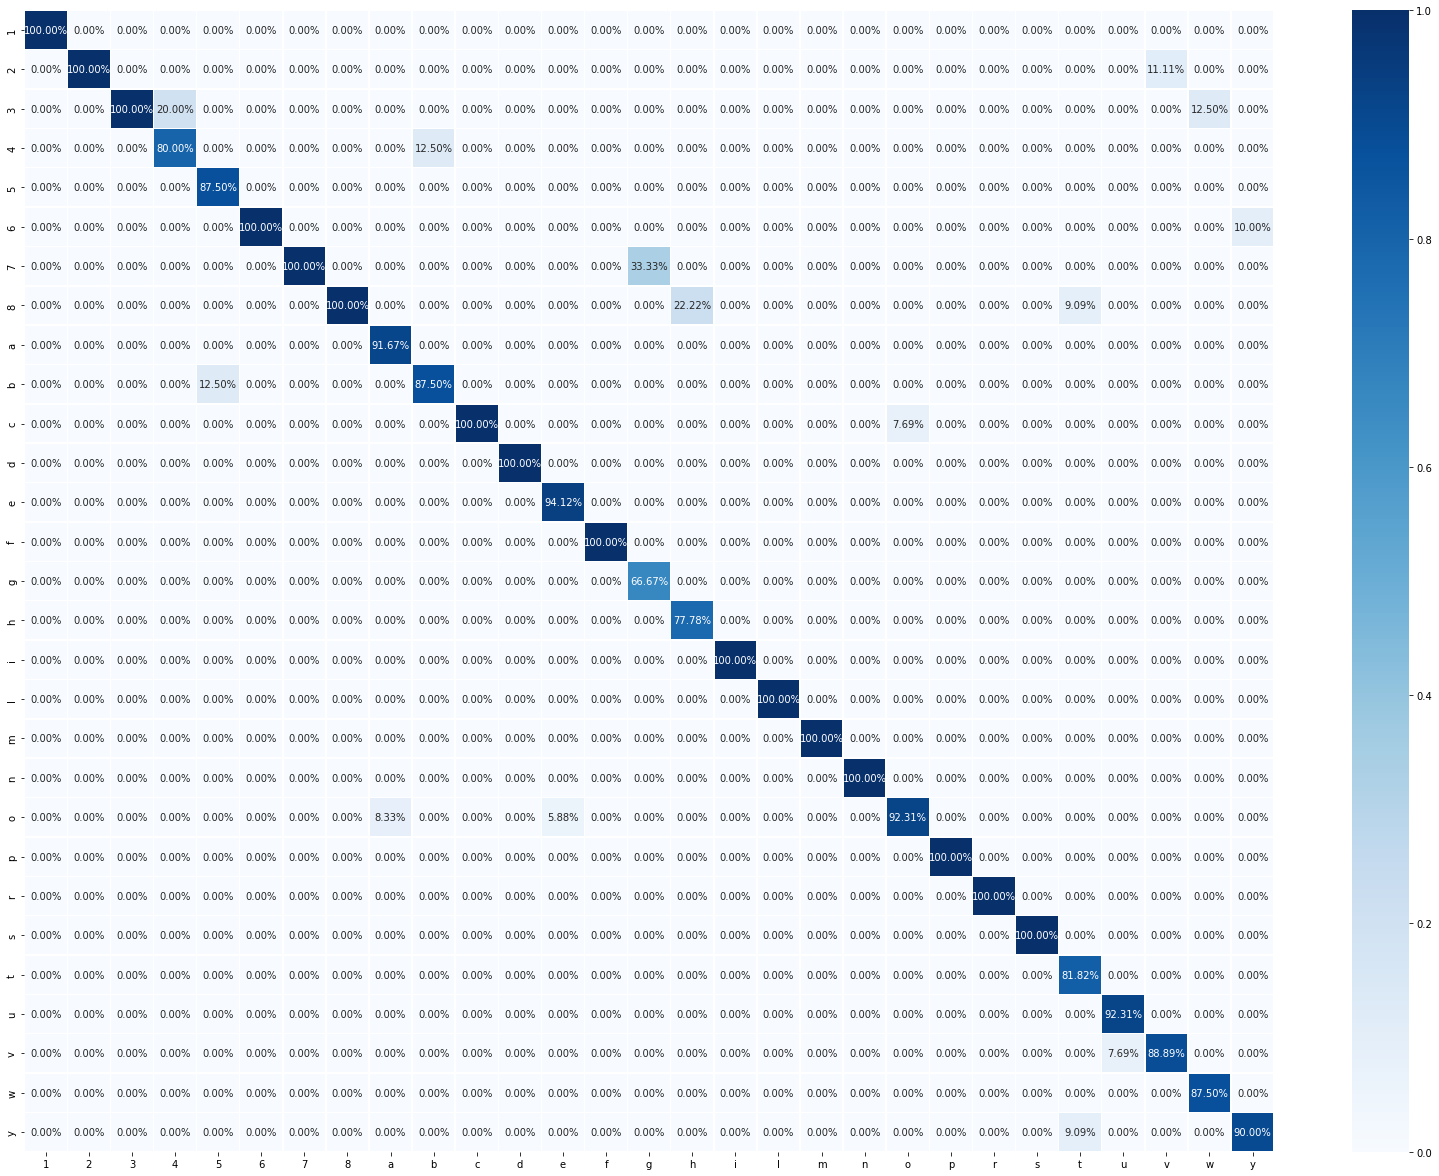

In [ ]:
#applying a model to predict the values
y_pred = loaded_model.predict(X_test)

#get the confusion matrix from the predicted values vs groundtruth values
conf_mx = confusion_matrix(y_test, y_pred)

#setting up the confusion matrix for better visualization
table = pd.DataFrame(conf_mx, columns = static_alphabets, index =static_alphabets )
plt.figure(figsize = (28,21))
ax = sns.heatmap(table/np.sum(table), annot = True , fmt='.2%', cmap = 'Blues', linewidth=.5)

#plt.matshow(conf_mx, cmap='Blues' )
print("\n")
#show cliassical report
print(classification_report(y_test,y_pred))

### check main accuracy value from the model according to its assigned value per stage
print("Training set score: %f" % loaded_model.score(X_train , y_train))
print("Testing  set score: %f" % loaded_model.score(X_test , y_test ))
print("Validation  set score: %f" % loaded_model.score(X_val , y_val ))

#STATIC SHOW ATRIBUTES
loaded_model.score


#loaded_model
#clf.score



              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.75      0.60      0.67         5
           2       1.00      0.75      0.86         8
           3       0.92      0.92      0.92        13
           4       0.86      0.86      0.86         7
           5       1.00      0.75      0.86         8
           6       0.82      1.00      0.90        14
           7       0.89      0.89      0.89         9
           8       1.00      0.90      0.95        10
           9       0.92      1.00      0.96        11
          10       0.90      1.00      0.95         9
          11       1.00      1.00      1.00        11
          12       1.00      0.92      0.96        13
          13       1.00      1.00      1.00        11
          14       0.80      0.80      0.80         5
          15       0.92      0.92      0.92        12
          16       1.00      0.93      0.96        14
          17       1.00  

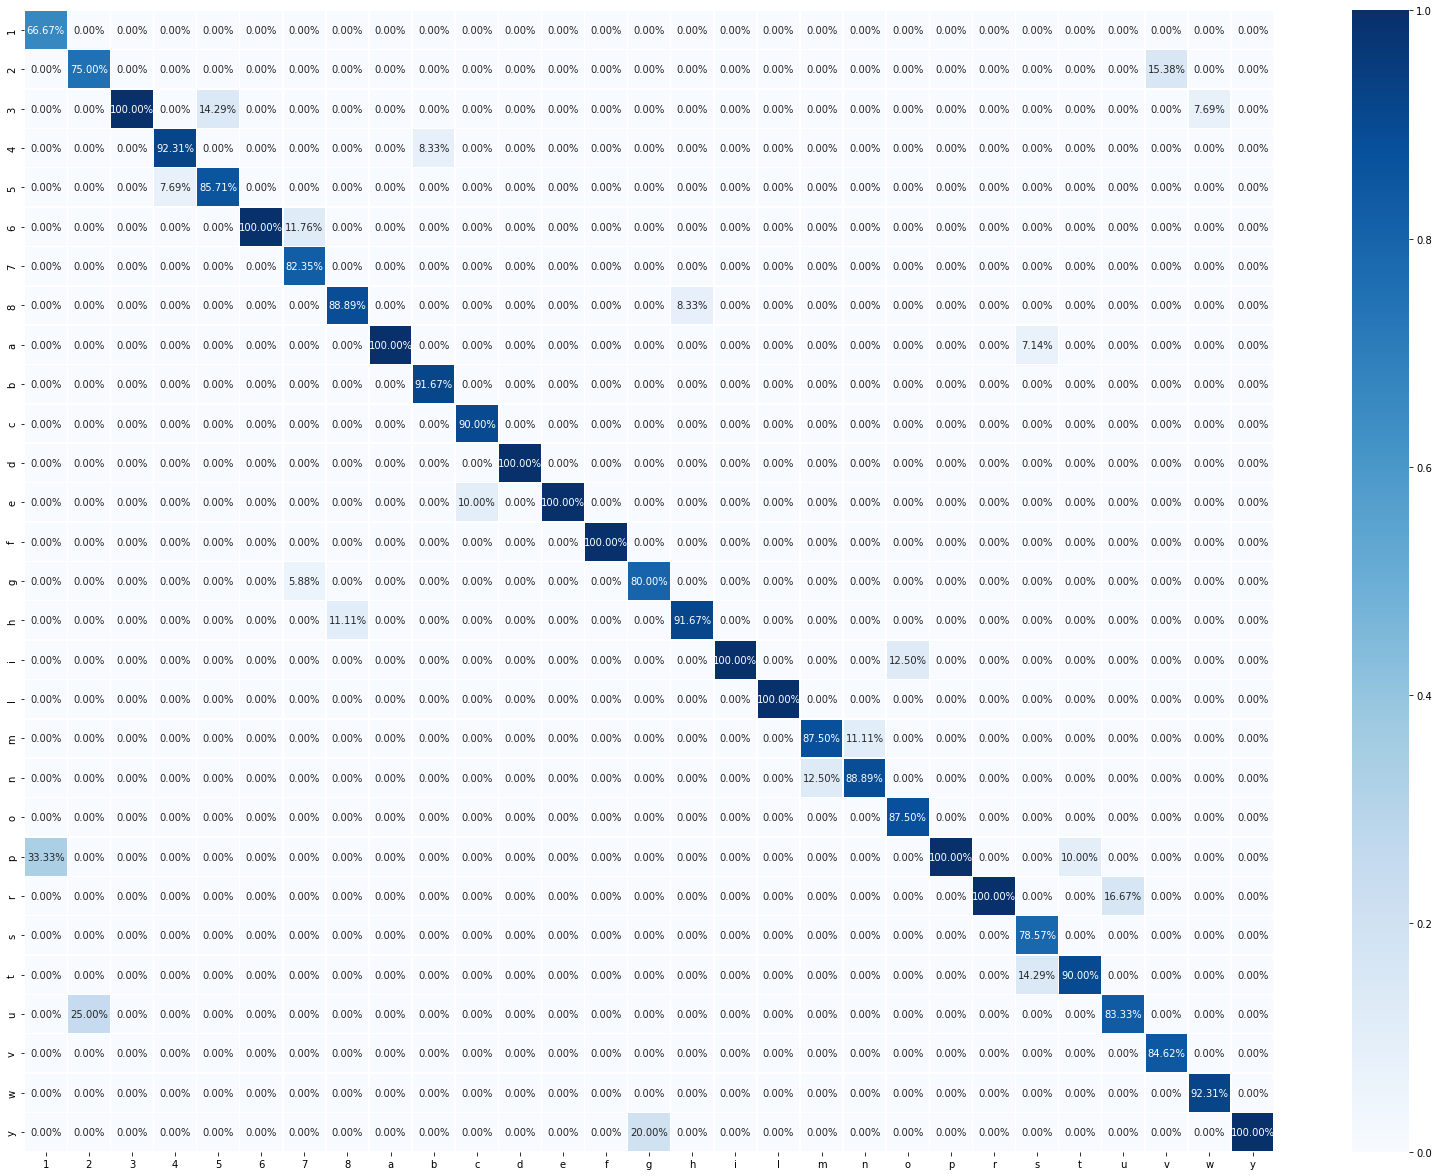

In [ ]:

#get predicted values for validation stage
y_pred_val = loaded_model.predict(X_val)

#geenrate confusion matrix values
conf_mx = confusion_matrix(y_val, y_pred_val)

#setting up confusion matrix for better visualization
table = pd.DataFrame(conf_mx, columns = static_alphabets, index =static_alphabets )
plt.figure(figsize = (28,21))
ax = sns.heatmap(table/np.sum(table), annot = True , fmt='.2%', cmap = 'Blues', linewidth=.5)

#plt.matshow(conf_mx, cmap='Blues' )
print("\n")
print(classification_report(y_val,y_pred_val))



###Evaluation Metrics

In [ ]:
#the following code gets per stage of the data distribution (Training, testing and validation ) all the evaluation metrics (accuracy, precision, recall , and f-1 score) according to its type (micro, macro and weighted) 
#TRAIN
print("\n","_________TRAINNING_________")
y_pred_train = loaded_model.predict(X_train)
print(y_train.shape, y_pred_train.shape)
print("Accuracy for Test", accuracy_score(y_train, y_pred_train), "\n")

print("Precision_micro for Test", precision_score(y_train, y_pred_train, average="micro"))
print("Precision_macro for Test", precision_score(y_train, y_pred_train, average="macro"))
print("Precision_weighted for Test", precision_score(y_train, y_pred_train, average="weighted"), "\n")

print("Recall_micro for Test", recall_score(y_train, y_pred_train, average="micro"))
print("Recall_macro for Test", recall_score(y_train, y_pred_train, average="macro"))
print("Recall_weighted for Test", recall_score(y_train, y_pred_train, average="weighted"), "\n")

print("F1_score_micro for Test", f1_score(y_train, y_pred_train, average="micro"))
print("F1_score_macro for Test", f1_score(y_train, y_pred_train, average="macro"))
print("F1_score_weighted for Test", f1_score(y_train, y_pred_train, average="weighted"), "\n")


#TEST
print("\n","_________TEST_________")
y_pred = loaded_model.predict(X_test)
print(y_test.shape, y_pred.shape)
print("Accuracy for Test", accuracy_score(y_test, y_pred), "\n")

print("Precision_micro for Test", precision_score(y_test, y_pred, average="micro"))
print("Precision_macro for Test", precision_score(y_test, y_pred, average="macro"))
print("Precision_weighted for Test", precision_score(y_test, y_pred, average="weighted"), "\n")

print("Recall_micro for Test", recall_score(y_test, y_pred, average="micro"))
print("Recall_macro for Test", recall_score(y_test, y_pred, average="macro"))
print("Recall_weighted for Test", recall_score(y_test, y_pred, average="weighted"), "\n")

print("F1_score_micro for Test", f1_score(y_test, y_pred, average="micro"))
print("F1_score_macro for Test", f1_score(y_test, y_pred, average="macro"))
print("F1_score_weighted for Test", f1_score(y_test, y_pred, average="weighted"), "\n")

#print("Roc_auc_ovr for Test", roc_auc_score(y_test, y_pred, average="None" , multi_class="ovo"))
#VALIDATION
print("\n","_________VALIDATION_________")
y_pred_val = loaded_model.predict(X_val)
print(y_val.shape, y_pred_val.shape)
print("Accuracy for Validation", accuracy_score(y_val, y_pred_val), "\n")

print("Precision_micro for Validation", precision_score(y_val, y_pred_val, average="micro"))
print("Precision_macro for Validation", precision_score(y_val, y_pred_val, average="macro"))
print("Precision_weighted for Validation", precision_score(y_val, y_pred_val, average="weighted"), "\n")

print("Recall_micro for Validation", recall_score(y_val, y_pred_val, average="micro"))
print("Recall_macro for Validation", recall_score(y_val, y_pred_val, average="macro"))
print("Recall_weighted for Validation", recall_score(y_val, y_pred_val, average="weighted"), "\n")

print("F1_score_micro for Validation", f1_score(y_val, y_pred_val, average="micro"))
print("F1_score_macro for Validation", f1_score(y_val, y_pred_val, average="macro"))
print("F1_score_weighted for Validation", f1_score(y_val, y_pred_val, average="weighted"), "\n")


 _________TRAINNING_________
(2156,) (2156,)
Accuracy for Test 0.9930426716141002 

Precision_micro for Test 0.9930426716141002
Precision_macro for Test 0.9933648487497414
Precision_weighted for Test 0.9931204438887682 

Recall_micro for Test 0.9930426716141002
Recall_macro for Test 0.9930085537494541
Recall_weighted for Test 0.9930426716141002 

F1_score_micro for Test 0.9930426716141002
F1_score_macro for Test 0.9931467674853517
F1_score_weighted for Test 0.9930417049664075 


 _________TEST_________
(270,) (270,)
Accuracy for Test 0.9407407407407408 

Precision_micro for Test 0.9407407407407408
Precision_macro for Test 0.9372590391353068
Precision_weighted for Test 0.9476552012499725 

Recall_micro for Test 0.9407407407407408
Recall_macro for Test 0.9424839528287804
Recall_weighted for Test 0.9407407407407408 

F1_score_micro for Test 0.9407407407407408
F1_score_macro for Test 0.9356474943119778
F1_score_weighted for Test 0.9405951947121538 


 _________VALIDATION_________
(270,) (

###Validation Confusion matrix

In [ ]:
#Confusion matrix display for validation stage
conf_mx = confusion_matrix(y_val, y_pred_val)
table = pd.DataFrame(conf_mx, columns = static_alphabets, index =static_alphabets )
plt.figure(figsize = (28,21))
ax = sns.heatmap(table/np.sum(table), annot = True , fmt='.2%', cmap = 'Blues', linewidth=.5)

#plt.matshow(conf_mx, cmap='Blues' )
print("\n")
print(classification_report(y_val,y_pred_val))

## Confusion matrix and evaluation metrics for dynamic/continous signs

### Variables reformating for confusion matrix input for continous signs variables

In [ ]:
#Predictions for every stage
y_pred_train = model.predict(X_train) #train
y_pred = model.predict(X_test) #test 
y_pred_val = model.predict(X_val) #validation

#Format adaptation

#True
y_train_static = np.zeros(y_train.shape[0])
y_test_static = np.zeros(y_test.shape[0])
y_val_static = np.zeros(y_val.shape[0])
#Pred
y_pred_train_static = np.zeros(y_pred_train.shape[0])
y_pred_static = np.zeros(y_pred.shape[0])
y_pred_val_static = np.zeros(y_pred_val.shape[0])


#train
for i in range(y_train.shape[0]):
  #True
  y_train_static[i] = np.argmax(y_train[i])

for i in range(y_pred_train.shape[0]):
  #Pred
  y_pred_train_static[i] = np.argmax(y_pred_train[i])


#test
for i in range(y_pred.shape[0]):
  #true
  y_test_static[i] = np.argmax(y_test[i])

  #pred
  y_pred_static[i] =np.argmax(y_pred[i])


#val
for i in range(y_pred_val.shape[0]):
  #true
  y_val_static[i] =np.argmax(y_val[i])
  #pred
  y_pred_val_static[i] = np.argmax(y_pred_val[i])

print(" Train ", y_train_static.shape, "\n",
      "Test ",y_test_static.shape, "\n",
      "Val ",y_val_static.shape, "\n",
      "Pred Train ",y_pred_train_static.shape, "\n",
      "Pred Test ",y_pred_static.shape, "\n",
      "Pred Val ",y_pred_val_static.shape, "\n"

)

4/4 [==============================] - 0s 25ms/step
 Train  (784,) 
 Test  (98,) 
 Val  (99,) 
 Pred Train  (784,) 
 Pred Test  (98,) 
 Pred Val  (99,) 



In [ ]:
y_pred_val.shape

(99, 10)

###Confusion matrix display



              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74         9
         1.0       0.90      0.82      0.86        11
         2.0       1.00      1.00      1.00         9
         3.0       0.56      0.45      0.50        11
         4.0       0.75      0.90      0.82        10
         5.0       0.73      0.89      0.80         9
         6.0       0.89      1.00      0.94         8
         7.0       0.91      0.83      0.87        12
         8.0       0.60      0.55      0.57        11
         9.0       1.00      0.88      0.93         8

    accuracy                           0.80        98
   macro avg       0.80      0.81      0.80        98
weighted avg       0.80      0.80      0.79        98



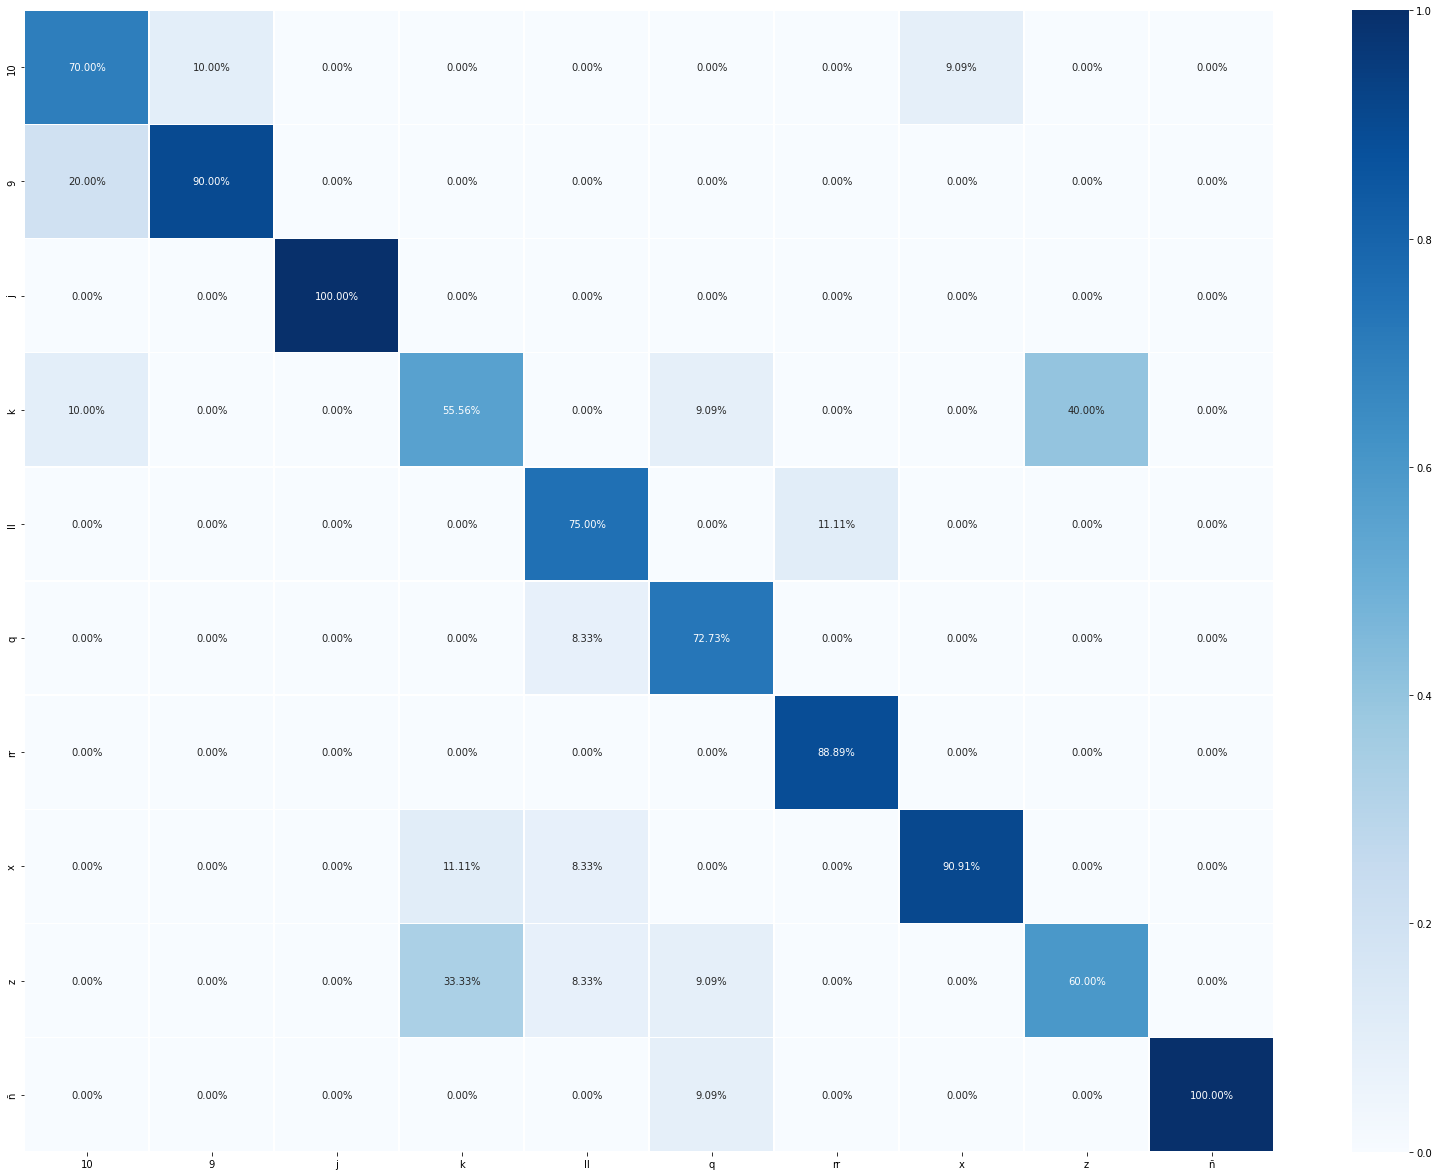

In [ ]:
#Confusion matrix for continous signs

conf_mx = confusion_matrix(y_test_static, y_pred_static)
table = pd.DataFrame(conf_mx, columns = dinamyc_alphabets, index =dinamyc_alphabets )
plt.figure(figsize = (28,21))
ax = sns.heatmap(table/np.sum(table), annot = True , fmt='.2%', cmap = 'Blues', linewidth=.5)

#plt.matshow(conf_mx, cmap='Blues' )
print("\n")
print(classification_report(y_test_static,y_pred_static))


###Evaluation Metrics

In [ ]:
#the following code gets per stage of the data distribution (Training, testing and validation ) all the evaluation metrics (accuracy, precision, recall , and f-1 score) according to its type (micro, macro and weighted) 

#TRAIN
print("\n","_________TRAINNING_________")
print(y_train_static.shape, y_pred_train_static.shape)
print("Accuracy for Test", accuracy_score(y_train_static, y_pred_train_static), "\n")

print("Precision_micro for Test", precision_score(y_train_static, y_pred_train_static, average="micro"))
print("Precision_macro for Test", precision_score(y_train_static, y_pred_train_static, average="macro"))
print("Precision_weighted for Test", precision_score(y_train_static, y_pred_train_static, average="weighted"), "\n")

print("Recall_micro for Test", recall_score(y_train_static, y_pred_train_static, average="micro"))
print("Recall_macro for Test", recall_score(y_train_static, y_pred_train_static, average="macro"))
print("Recall_weighted for Test", recall_score(y_train_static, y_pred_train_static, average="weighted"), "\n")

print("F1_score_micro for Test", f1_score(y_train_static, y_pred_train_static, average="micro"))
print("F1_score_macro for Test", f1_score(y_train_static, y_pred_train_static, average="macro"))
print("F1_score_weighted for Test", f1_score(y_train_static, y_pred_train_static, average="weighted"), "\n")


#TEST
print("\n","_________TEST_________")
print(y_test_static.shape, y_pred_static.shape)
print("Accuracy for Test", accuracy_score(y_test_static, y_pred_static), "\n")

print("Precision_micro for Test", precision_score(y_test_static, y_pred_static, average="micro"))
print("Precision_macro for Test", precision_score(y_test_static, y_pred_static, average="macro"))
print("Precision_weighted for Test", precision_score(y_test_static, y_pred_static, average="weighted"), "\n")

print("Recall_micro for Test", recall_score(y_test_static, y_pred_static, average="micro"))
print("Recall_macro for Test", recall_score(y_test_static, y_pred_static, average="macro"))
print("Recall_weighted for Test", recall_score(y_test_static, y_pred_static, average="weighted"), "\n")

print("F1_score_micro for Test", f1_score(y_test_static, y_pred_static, average="micro"))
print("F1_score_macro for Test", f1_score(y_test_static, y_pred_static, average="macro"))
print("F1_score_weighted for Test", f1_score(y_test_static, y_pred_static, average="weighted"), "\n")

#VALIDATION
print("\n","_________VALIDATION_________")
print(y_val_static.shape, y_pred_val_static.shape)
print("Accuracy for Validation", accuracy_score(y_val_static, y_pred_val_static), "\n")

print("Precision_micro for Validation", precision_score(y_val_static, y_pred_val_static, average="micro"))
print("Precision_macro for Validation", precision_score(y_val_static, y_pred_val_static, average="macro"))
print("Precision_weighted for Validation", precision_score(y_val_static, y_pred_val_static, average="weighted"), "\n")

print("Recall_micro for Validation", recall_score(y_val_static, y_pred_val_static, average="micro"))
print("Recall_macro for Validation", recall_score(y_val_static, y_pred_val_static, average="macro"))
print("Recall_weighted for Validation", recall_score(y_val_static, y_pred_val_static, average="weighted"), "\n")

print("F1_score_micro for Validation", f1_score(y_val_static, y_pred_val_static, average="micro"))
print("F1_score_macro for Validation", f1_score(y_val_static, y_pred_val_static, average="macro"))
print("F1_score_weighted for Validation", f1_score(y_val_static, y_pred_val_static, average="weighted"), "\n")


 _________TRAINNING_________
(784,) (784,)
Accuracy for Test 0.9591836734693877 

Precision_micro for Test 0.9591836734693877
Precision_macro for Test 0.9589091438306104
Precision_weighted for Test 0.9594154214857795 

Recall_micro for Test 0.9591836734693877
Recall_macro for Test 0.9600507600385013
Recall_weighted for Test 0.9591836734693877 

F1_score_micro for Test 0.9591836734693877
F1_score_macro for Test 0.9589921727479493
F1_score_weighted for Test 0.9588239500891489 


 _________TEST_________
(98,) (98,)
Accuracy for Test 0.7959183673469388 

Precision_micro for Test 0.7959183673469388
Precision_macro for Test 0.8030808080808081
Precision_weighted for Test 0.7956813028241599 

Recall_micro for Test 0.7959183673469388
Recall_macro for Test 0.8093181818181818
Recall_weighted for Test 0.7959183673469388 

F1_score_micro for Test 0.7959183673469388
F1_score_macro for Test 0.8027670373329278
F1_score_weighted for Test 0.7924341212606175 


 _________VALIDATION_________
(99,) (99,)


###Validation Confusion matrix



              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.80      0.80      0.80        10
         2.0       0.75      1.00      0.86         9
         3.0       0.75      0.55      0.63        11
         4.0       0.94      1.00      0.97        16
         5.0       0.29      0.20      0.24        10
         6.0       0.83      1.00      0.91         5
         7.0       0.73      0.89      0.80         9
         8.0       0.50      0.55      0.52        11
         9.0       1.00      0.86      0.92         7

    accuracy                           0.77        99
   macro avg       0.76      0.77      0.76        99
weighted avg       0.76      0.77      0.76        99



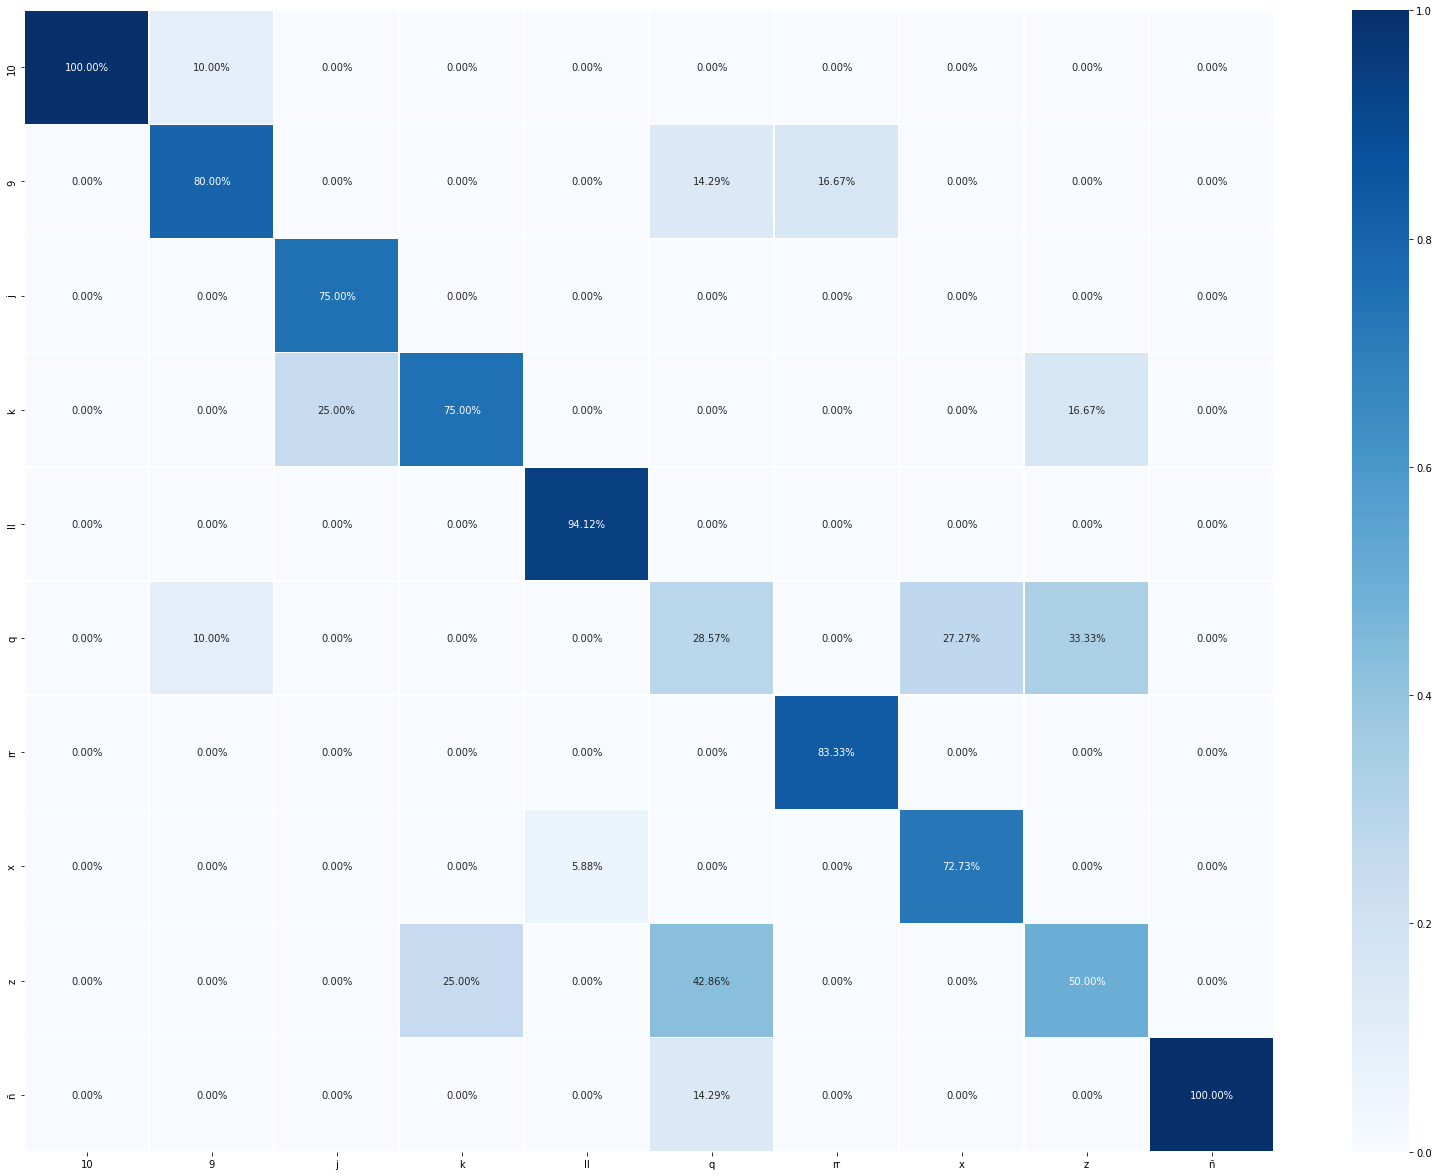

In [ ]:
#confusion matrix for continou sign for validation

conf_mx = confusion_matrix(y_val_static, y_pred_val_static)
table = pd.DataFrame(conf_mx, columns = dinamyc_alphabets, index =dinamyc_alphabets )
plt.figure(figsize = (28,21))
ax = sns.heatmap(table/np.sum(table), annot = True , fmt='.2%', cmap = 'Blues', linewidth=.5)

#plt.matshow(conf_mx, cmap='Blues' )
print("\n")
print(classification_report(y_val_static,y_pred_val_static))


##Tensorboard display

In [ ]:
#declare tensorboard path to call the training data to check
tf_direction_path= "/content/drive/MyDrive/Base de datos/key_points/dynamic_data/Logs/fit/train"
!tensorboard --logdir=tf_direction_path --load_fast true --bind_all

#It is recommended to display tensorboard locally in your own terminal for easier display

TensorBoard 2.12.0a20221225 at http://e89a5bebad69:6006/ (Press CTRL+C to quit)
^C


#Prediction in real time with webcam in Google Collab

##Javascript for webcam display

In [33]:

##Folllowing code was adapted from TheAIGuysCode. (2020). Colab-webcam. GitHub. https://github.com/theAIGuysCode/colab-webcam

#Helper functions
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [42]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    const piX = 480; // The width of the capture canvas - 1080
    const piY = 360; // The height of the capture canvas - 720
    var video; //Video element to display the webcam stream
    var div = null;//Container div for video and other elements
    var stream; //MediaStream object to capture video stream
    var captureCanvas; // Canvas element for capturing frames
    var imgElement; // Image element to display captured frames
    var labelElement; //Element to display the label/status
    
    var pendingResolve = null; // Promise resolve function for capturing frames
    var shutdown = false; // Flag to indicate if the video stream should be stopped
    
    function removeDom() {
       stream.getVideoTracks()[0].stop(); // Stop the video stream
       video.remove(); // Remove the video element
       div.remove();// Remove the container div
       video = null; // Reset variables to null
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame); // Continuously request animation frames
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, piX, piY);//Capture frame from video stream
          result = captureCanvas.toDataURL('image/jpeg', 0.8) // Convert captured frame to data URL
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result); // Resolve the promise with the captured frame
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream; //Return the existing stream if it already exists
      }

      div = document.createElement('div'); //Create a container div
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '1080px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div'); //Create a div to display status/label
      //modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      labelElement.style.fontSize = '40px'; // Size of output text
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video'); //Create a video element
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };//Set onclick event to stop the demo
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "user"}});//Request user permission for video stream
      div.appendChild(video);

      imgElement = document.createElement('img');//Create an image element
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };//Set onclick event to stop the demo
      div.appendChild(imgElement); 
      
      const instruction = document.createElement('div');//Create a div for instructions
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };//Set onclick event to stop the demo

      video.srcObject = stream;  // Set the video source to the captured stream
      await video.play();      // Start playing the video

      captureCanvas = document.createElement('canvas');  // Create a canvas for capturing frames
      captureCanvas.width = piX;  // Set the canvas width
      captureCanvas.height = piY; //Set the canvas height
      window.requestAnimationFrame(onAnimationFrame);  // Start requesting animation frames
      
      return stream;  // Return the stream
    }

    
    async function stream_frame(label, imgData) {

      if (shutdown) {
        removeDom(); // If shutdown flag is set, remove the video stream and elements
        shutdown = false;  //Reset the shutdown flag
        return '';  // Return an empty string
      }

      var preCreate = Date.now();  // Capture the timestamp before creating the DOM
      stream = await createDom();  // Create the DOM elements and get the stream
      
      var preShow = Date.now();  // Capture the timestamp before showing the label and image
            
      if (label != "") {
        labelElement.innerHTML = label;  // Set the label text
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];  // Get the size and position of the video element
        imgElement.style.top = videoRect.top + "px";  // Set the position of the image element
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;  // Set the source of the image element
      }
      
      var preCapture = Date.now();  // Capture the timestamp before capturing the frame
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;  // Set the pendingResolve function to resolve the promise
      });
      shutdown = false;  // Reset the shutdown flag

      return {'create': preShow - preCreate, // Return the timing information
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, sentence):
  data = eval_js('stream_frame("{}","{}")'.format(label,sentence))#  Call the JavaScript function with label and sentence parameters
  return data

##Livestreaming

###Dynamic/Continous signs' Livestream

In [ ]:
#from google.colab.patches import cv2_imshow

# start streaming video from webcam
video_stream()
# label for video
label_html = 'The letter predicted is: '
count = 0 

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
predicted_letter='...'

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  #print(min_detection_confidence)
  while True:
      js_reply = video_frame(label_html,predicted_letter )
      if not js_reply:
          break
      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      image, results = mediapipe_detection(img, holistic)
      
        # Draw landmarks
      draw_styled_landmarks(image, results)
      
      # 2. Prediction logic
      keypoints = extract_keypoints(results)
      sequence.append(keypoints)
      sequence = sequence[-30:]
      
      if len(sequence) == 30:
          res = model.predict(np.expand_dims(sequence, axis=0))[0]
          print(dinamyc_alphabets[np.argmax(res)])
          predictions.append(np.argmax(res))
          
          
      #3. Viz logic: the following code recognize one out of the ten signs and according to the last 5 recognized sign
          if np.unique(predictions[-10:])[0]==np.argmax(res): 
              if res[np.argmax(res)] > threshold: 
                  
                  if len(sentence) > 0: 
                      if dinamyc_alphabets[np.argmax(res)] != sentence[-1]:
                          sentence.append(dinamyc_alphabets[np.argmax(res)])
                          predicted_letter=dinamyc_alphabets[np.argmax(res)]
                          
                  else:
                      sentence.append(dinamyc_alphabets[np.argmax(res)])
                      predicted_letter=dinamyc_alphabets[np.argmax(res)]

          if len(sentence) > 5: 
              sentence = sentence[-5:]          

  ##cap.release()
  ##cv2.destroyAllWindows()

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 31ms/step
9
1/1 [==============================] - 0s 37ms/step
9
1/1 [==============================] - 0s 32ms/step
9
1/1 [==============================] - 0s 31ms/step
9
1/1 [==============================] - 0s 30ms/step
9
1/1 [==============================] - 0s 42ms/step
9
1/1 [==============================] - 0s 46ms/step
9
1/1 [==============================] - 0s 48ms/step
9
1/1 [==============================] - 0s 28ms/step
9
1/1 [==============================] - 0s 32ms/step
9
1/1 [==============================] - 0s 31ms/step
9
1/1 [==============================] - 0s 32ms/step
9
1/1 [==============================] - 0s 30ms/step
9
1/1 [==============================] - 0s 37ms/step
9
1/1 [==============================] - 0s 32ms/step
9
1/1 [==============================] - 0s 44ms/step
9
1/1 [==============================] - 0s 43ms/step
9
1/1 [==============================] - 0s 44ms/step
9
1/1 [=======================

" \n          # Viz probabilities\n          image = prob_viz(res, dinamyc_alphabets, image, colors)\n          \n      cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)\n      cv2.putText(image, ' '.join(sentence), (3,30), \n                      cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)\n    \n      # Show to screen\n      cv2_imshow(image)\n\n      # Break gracefully\n      if cv2.waitKey(1) & 0xFF == ord('s'):\n          break\n\n\n          ['9',\n'10',\n'j',\n'k',\n'll',\n'ñ',\n'q',\n'rr',\n'x',\n'z',])\n\n"

### Static signs' Livestream

In [43]:

# start streaming video from webcam
video_stream()
# label for video
label_html = 'The letter predicted is: '
count = 0 

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
predicted_letter='...'

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  #print(min_detection_confidence)
  while True:
      js_reply = video_frame(label_html,predicted_letter )
      if not js_reply:
          break
      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      image, results = mediapipe_detection(img, holistic)
      
        # Draw landmarks
      draw_styled_landmarks(image, results)
      
      # 2. Prediction logic
      keypoints = extract_keypoints(results)
      sequence.append(keypoints)
      sequence = sequence[-30:]
      
      if len(sequence) == 30:
          res = loaded_model.predict(np.expand_dims(sequence[-1], axis=0))[0]
          print(static_alphabets[res])
          #print('<font size="30">' + + '</font>')
          predictions.append(res)
          
          
      #3. Viz logic: the following code recognize one out of the 28 signs and according to the last 5 recognized sign
          if np.unique(predictions[-10:])[0]==res: 
              #if res[res] > threshold: 
                  
                  if len(sentence) > 0: 
                      if static_alphabets[res] != sentence[-1]:
                          sentence.append(static_alphabets[res])
                          predicted_letter=static_alphabets[res]
                          
                  else:
                      sentence.append(static_alphabets[res])
                      predicted_letter=static_alphabets[res]

                      


          if len(sentence) > 5: 
              sentence = sentence[-5:]          

  ##cap.release()
  ##cv2.destroyAllWindows()


    

<IPython.core.display.Javascript object>

v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
v
p
g
g
